## Imports and Setup

## Data Requirements

**IMPORTANT**: This notebook expects a data file with **11 million (1.1e7) events**.

### Data Split Strategy:
- **Total**: 11M events saved in one `.npy` file
- **Training pool**: First 10M events (indices 0 to 9,999,999)
  - Each trial randomly samples 1M from this pool
- **Validation set**: Last 1M events (indices 10,000,000 to 10,999,999)
  - **FIXED** - same validation set used for all trials


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import os
from pathlib import Path
from datetime import datetime

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from nflows.flows import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms import CompositeTransform, RandomPermutation
from nflows.transforms.coupling import PiecewiseRationalQuadraticCouplingTransform
from nflows.transforms.base import Transform
from nflows.transforms import Sigmoid, InverseTransform

# Plotting setup
sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)
plt.rcParams['text.usetex'] = False  # Set to True if you have LaTeX
plt.rcParams['font.size'] = 12

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


Helper functions

In [2]:
from Amplitude import DKpp, BKpp, DalitzSample, AmpSample, SquareDalitzPlot2

# --- Particle masses ---
mD, mKs, mpi = 1.86483, 0.497611, 0.13957018
SDP = SquareDalitzPlot2(mD, mKs, mpi, mpi)

# ============================================================================
# Numerical Stability Helper
# ============================================================================

def _finite_pos(x, eps=1e-14):
    """
    Ensure array has finite positive values for numerical stability.
    """
    x = np.asarray(x)
    x = np.where(np.isfinite(x), x, 0.0)   # Replace NaN/±inf with 0
    return np.maximum(x, eps)              # Enforce minimum positive value

# ============================================================================
# Coordinate Transformation Functions
# ============================================================================

def dp_to_sdp(points_dp, sdp_obj, idx=(1,2,3)):
    """
    Convert Dalitz Plot coordinates to Square Dalitz Plot coordinates.
    """
    i, j, k = idx
    s12 = points_dp[:, 0]
    s13 = points_dp[:, 1]
    mp = np.vectorize(lambda a, b: sdp_obj.MpfromM(a, b, i, j, k), otypes=[float])(s12, s13)
    tp = np.vectorize(lambda a, b: sdp_obj.TfromM(a, b, i, j, k), otypes=[float])(s12, s13)
    return np.column_stack([mp, tp])

def sdp_to_dp(points_sdp, sdp_obj, idx=(1,2,3)):
    """
    Convert Square Dalitz Plot coordinates to Dalitz Plot coordinates.
    """
    i, j, k = idx
    out = np.empty_like(points_sdp, dtype=float)
    for n, (mp, th) in enumerate(points_sdp):
        sij, sik = sdp_obj.M_from_MpT(mp, th, i, j, k)
        out[n, 0] = sij
        out[n, 1] = sik
    return out  # columns: [s_ij, s_ik]

def swap_to_other_pair_sdp(s12, s13, sdp_obj, pair_swap=(1,3,2)):
    """
    Convert Dalitz point to SDP coordinates for a different particle pairing.
    
    Parameters
    ----------
    s12 : array_like
        Invariant mass squared s_{12} = (p_1 + p_2)^2.
    s13 : array_like
        Invariant mass squared s_{13} = (p_1 + p_3)^2.
    sdp_obj : SquareDalitzPlot2
        Square Dalitz plot object with transformation methods.
    pair_swap : tuple of int, optional
        New particle ordering (i, j, k). Default is (1, 3, 2) which
        swaps the roles of particles 2 and 3.
    
    Returns
    -------
    ndarray, shape (N, 2)
        SDP coordinates [m', theta'] for the swapped pairing.
    
    Notes
    -----
    This is used to compute |A_D(s_{13}, s_{12})| from a flow trained
    on |A_D(s_{12}, s_{13})|. The CP-conjugate amplitude corresponds
    to swapping the pi+ and pi- labels, which is equivalent to
    swapping s12 <-> s13.
    
    Example:
    If the flow is trained on (K_S pi-) vs (K_S pi+) [i.e., s12 vs s13],
    then to evaluate at the CP-conjugate point we need to query the
    flow at the SDP coordinates corresponding to (s13, s12).
    """
    i2, j2, k2 = pair_swap
    s12 = np.asarray(s12)
    s13 = np.asarray(s13)
    mp13 = np.empty_like(s12)
    th13 = np.empty_like(s12)
    for n in range(s12.size):
        mp13[n] = sdp_obj.MpfromM(s13[n], s12[n], i2, j2, k2)
        th13[n] = sdp_obj.TfromM(s13[n], s12[n], i2, j2, k2)
    return np.column_stack([mp13, th13])

def sdp_uniform_mc(N, eps=1e-6):
    """
    Generate uniform Monte Carlo points in Square Dalitz Plot coordinates.
    """
    return np.random.rand(N, 2) * (1 - 2*eps) + eps

# ============================================================================
# Amplitude Extraction from Normalizing Flows
# ============================================================================

def mag_AD_from_flow(points_sdp, flow, sdp_obj, idx=(1,2,3), device=None, tiny=1e-300):
    """
    Extract amplitude magnitude from normalizing flow probability density.
    
    Parameters
    ----------
    points_sdp : ndarray, shape (N, 2)
        Square Dalitz Plot points [m', theta'].
    flow : Flow
        Trained normalizing flow model representing p(m', theta') ∝ |A_D|^2.
    sdp_obj : SquareDalitzPlot2
        Square Dalitz plot transformation object.
    idx : tuple of int, optional
        Particle indices (i, j, k). Default is (1, 2, 3).
    device : torch.device, optional
        Device for PyTorch computation. If None, inferred from flow.
    tiny : float, optional
        Small number to prevent division by zero (default: 1e-300).
    
    Returns
    -------
    mag : ndarray, shape (N,)
        Amplitude magnitude |A_D(s_{ij}, s_{ik})| in Dalitz plot normalization.
    invJ : ndarray, shape (N,)
        Inverse Jacobian 1/|J| = 1/|∂(m',θ')/∂(s_{ij},s_{ik})|.
    
    **Implementation:**
    
    1. Evaluate flow density: p_SDP(m', θ') = exp(flow.log_prob(m', θ'))
    2. Transform (m', θ') -> (s_{ij}, s_{ik}) to get Dalitz coordinates
    3. Compute Jacobian J(s_{ij}, s_{ik}) of the transformation
    4. Return |A_D| = √(p_SDP · J) and inverse Jacobian 1/J
    
    The inverse Jacobian 1/J is also returned because it's needed for
    converting other probability densities between SDP and DP measures.
    
    """
    if device is None:
        device = next(flow.parameters()).device

    # Evaluate flow probability density in SDP coordinates
    import torch
    pts = torch.from_numpy(np.ascontiguousarray(points_sdp)).float().to(device)
    with torch.no_grad():
        logp = flow.log_prob(pts).cpu().numpy()
    p_sdp = np.exp(logp)

    # Transform each (m', θ') -> (s_ij, s_ik) and compute Jacobian
    u = points_sdp[:, 0]
    v = points_sdp[:, 1]
    sij = np.empty_like(u)
    sik = np.empty_like(u)
    
    for n, (uu, vv) in enumerate(points_sdp):
        s12, s13 = sdp_obj.M_from_MpT(uu, vv, *idx)
        sij[n], sik[n] = s12, s13

    # Compute Jacobian at each Dalitz point
    J = np.empty_like(u)
    for n in range(u.size):
        J[n] = float(sdp_obj.jacobian(sij[n], sik[n], *idx))

    # Extract DP-normalized amplitude magnitude
    # |A_D|² ∝ p_DP = p_SDP * J
    # |A_D| = √(p_SDP * J) = √(p_SDP / (1/J))
    mag = np.sqrt(p_sdp / np.maximum(1/J, tiny))
    
    return mag, 1/J


## Dataset Class

In [3]:
class DalitzDataset(Dataset):
    """
    PyTorch Dataset for Dalitz plot coordinates.

    Args:
        data: numpy array or torch tensor of shape (N, 2)
    """
    def __init__(self, data):
        if isinstance(data, np.ndarray):
            self.data = torch.FloatTensor(data)
        else:
            self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]

In [4]:
from DKpp import DKpp, AmpSample
from Amplitude import SquareDalitzPlot2

# Generate 20M events
totalpoints = 20_000_000
Sampler = AmpSample(DKpp())
points = Sampler.generate(totalpoints, nbatch=50000)
S12_plus, S13_plus = points[:, 0], points[:, 1]

def dp_to_sdp(points_dp, sdp_obj, idx=(1,2,3)):
    """Vectorized DP -> SDP for an array of [s12, s13]."""
    i,j,k = idx
    s12 = points_dp[:,0]; s13 = points_dp[:,1]
    mp  = np.vectorize(lambda a,b: sdp_obj.MpfromM(a, b, i, j, k), otypes=[float])(s12, s13)
    tp  = np.vectorize(lambda a,b: sdp_obj.TfromM(a, b, i, j, k), otypes=[float])(s12, s13)
    return np.column_stack([mp, tp])

# Convert to SDP coordinates
S12S13 = np.array([np.array([S12_plus[i], S13_plus[i]]) for i in range(totalpoints)])
mD, mKs, mpi = 1.86483, 0.497611, 0.13957018
SDP = SquareDalitzPlot2(mD, mKs, mpi, mpi)
D_sdp = dp_to_sdp(S12S13, SDP, idx=(1,2,3))

# Save
np.save('D_Kspipi_SDP_2e7.npy', D_sdp)

## Model Architecture

In [5]:
class MLP(nn.Module):
    """
    Multi-layer perceptron for conditioning in coupling layers.

    Args:
        in_features: Input dimension
        out_features: Output dimension
        hidden: Hidden layer size
        layers: Number of hidden layers
        output_scale: Scaling factor for output (for stability)
    """
    def __init__(self, in_features, out_features,
                 hidden=64, layers=2, output_scale=0.30):
        super().__init__()
        # Build feed-forward network
        feats = [nn.Linear(in_features, hidden), nn.SiLU()]
        for _ in range(layers - 1):
            feats += [nn.Linear(hidden, hidden), nn.SiLU()]
        self.backbone = nn.Sequential(*feats)
        self.head = nn.Linear(hidden, out_features)

        # Zero initialization for numerical stability
        nn.init.zeros_(self.head.weight)
        nn.init.zeros_(self.head.bias)

        self.output_scale = output_scale

    def forward(self, x, context=None):
        h = self.backbone(x)
        return self.head(h) * self.output_scale

In [6]:
def create_flow(on_unit_box=True, num_flows=8, hidden_features=64, num_bins=8, device=None):
    """
    Create a normalizing flow model using Neural Spline Flows.

    Args:
        on_unit_box: If True, use logit transform for [0,1]^2 domain
        num_flows: Number of coupling layers
        hidden_features: Size of hidden layers in conditioner MLPs
        num_bins: Number of bins in rational quadratic splines

    Returns:
        Flow model
    """
    # Use global device if not specified
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    dim = 2
    transforms = []

    # if on_unit_box:
    #     # Logit pre-transform: (0,1) → ℝ
    #     # transforms.append(InverseTransform(Sigmoid()))
    #     # pass
        
    if on_unit_box:
    # Logit pre-transform: (0,1) → ℝ
        sigmoid = Sigmoid()
        # Manually ensure sigmoid parameters are on correct device
        if hasattr(sigmoid, 'temperature') and isinstance(sigmoid.temperature, torch.Tensor):
            sigmoid.temperature = sigmoid.temperature.to(device)
        if hasattr(sigmoid, 'eps') and isinstance(sigmoid.eps, torch.Tensor):
            sigmoid.eps = sigmoid.eps.to(device)
        transforms.append(InverseTransform(sigmoid))


    # Alternating masked coupling layers
    masks = [torch.tensor([1, 0], dtype=torch.bool),
             torch.tensor([0, 1], dtype=torch.bool)]

    for i in range(num_flows):
        mask = masks[i % 2]

        def conditioner(in_features, out_features, _hidden=hidden_features):
            return MLP(in_features, out_features, hidden=_hidden, layers=2)

        transforms.append(
            PiecewiseRationalQuadraticCouplingTransform(
                mask=mask,
                transform_net_create_fn=conditioner,
                num_bins=num_bins,
                tails="linear",
                tail_bound=5.0,
                apply_unconditional_transform=False,
            )
        )
        transforms.append(RandomPermutation(features=dim))

    transform = CompositeTransform(transforms)
    base = StandardNormal(shape=[dim])

    return Flow(transform, base)

## Training Function

In [30]:
def train_flow_fixed_epochs(
    flow,
    train_loader,
    num_epochs=50,
    lr=1e-2,
    device="cuda" if torch.cuda.is_available() else "cpu"
):
    """
    Train flow for a fixed number of epochs without validation.
    """
    flow.to(device)

    optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.7, patience=3, min_lr=1e-6
    )

    history = {
        'train_loss': [],
        'learning_rate': [],
        'epochs_trained': num_epochs
    }

    for epoch in tqdm(range(1, num_epochs + 1), desc="Training", ncols=80):
        flow.train()
        train_loss = 0.0

        for xb in train_loader:
            xb = xb.to(device)
            loss = -flow.log_prob(xb).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * xb.size(0)

        train_loss /= len(train_loader.dataset)
        history['train_loss'].append(train_loss)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])

        scheduler.step(train_loss)

        if epoch % 2 == 0 or epoch == 1:
            print(f"[{epoch:03d}] Train: {train_loss:.6f}, LR: {optimizer.param_groups[0]['lr']:.2e}")

    return flow, history


## Ensemble Training Function

In [12]:
def train_ensemble(
    data_path,
    output_dir,
    num_trials=70,
    bootstrap_size=None,
    batch_size=10000,
    lr=0.01,
    num_epochs=50,
    num_flows=12,
    hidden_features=128,
    num_bins=12,
    device="cuda" if torch.cuda.is_available() else "cpu",
    seed_offset=0
):
    """
    Train ensemble using bootstrap resampling (with replacement), fixed epochs.
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True, parents=True)

    print(f"Loading data from {data_path}...")
    full_data = np.load(data_path)
    print(f"Loaded {len(full_data):,} events")

    if bootstrap_size is None:
        bootstrap_size = len(full_data)

    print(f"\nBootstrap config:")
    print(f"  Data: {len(full_data):,} events")
    print(f"  Bootstrap size: {bootstrap_size:,}")
    print(f"  Fixed epochs: {num_epochs}")

    config = {
        'num_trials': num_trials,
        'data_size': len(full_data),
        'bootstrap_size': bootstrap_size,
        'num_epochs': num_epochs,
        'lr': lr,
        'num_flows': num_flows,
        'hidden_features': hidden_features,
        'num_bins': num_bins,
        'timestamp': datetime.now().isoformat()
    }
    with open(output_dir / 'config.json', 'w') as f:
        json.dump(config, f, indent=2)

    results = {'trial_histories': [], 'final_losses': []}

    for trial in range(1, num_trials + 1):
        print(f"\n{'='*60}")
        print(f"TRIAL {trial}/{num_trials}")

        seed = trial + seed_offset
        np.random.seed(seed)
        torch.manual_seed(seed)

        # Bootstrap: sample WITH replacement
        indices = np.random.choice(len(full_data), size=bootstrap_size, replace=False)
        train_data = full_data[indices]
        print(f"Bootstrap sample: {len(train_data):,} ({len(np.unique(indices))/len(full_data):.1%} unique)")

        train_loader = DataLoader(
            DalitzDataset(train_data),
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=(device == "cuda")
        )

        flow = create_flow(num_flows=num_flows, hidden_features=hidden_features, num_bins=num_bins)

        if trial == 1:
            print(f"Model params: {sum(p.numel() for p in flow.parameters()):,}")

        flow, history = train_flow_fixed_epochs(flow, train_loader, num_epochs=num_epochs, lr=lr, device=device)

        torch.save(flow.state_dict(), output_dir / f"trial_seed{seed}.pth")
        with open(output_dir / f"trial_seed{seed}_history.json", 'w') as f:
            json.dump(history, f, indent=2)

        results['trial_histories'].append(history)
        results['final_losses'].append(history['train_loss'][-1])
        print(f"Final loss: {history['train_loss'][-1]:.6f}")

    print(f"\n{'='*60}")
    print(f"ENSEMBLE COMPLETE: {np.mean(results['final_losses']):.6f} ± {np.std(results['final_losses']):.6f}")

    with open(output_dir / 'summary.json', 'w') as f:
        json.dump({'mean_loss': float(np.mean(results['final_losses'])), 
                   'std_loss': float(np.std(results['final_losses']))}, f, indent=2)

    return results


---
# Usage Examples

Below are different ways to use the optimized training code.

## Example 1: Train a Single Model 

In [ ]:
# Load all data
data = np.load('D_Kspipi_SDP_2e7.npy')

train_loader = DataLoader(
    DalitzDataset(data),
    batch_size=10000, 
    shuffle=True
)

flow = create_flow(num_flows=16, hidden_features = 128, num_bins=16)
print(f"Model parameters: {sum(p.numel() for p in flow.parameters()):,}")

flow, history = train_flow_fixed_epochs(
    flow, train_loader, num_epochs=100, lr=0.01, device=device,
)

# Save
torch.save(flow.state_dict(), "single_model.pth")
print(f"Final loss: {history['train_loss'][-1]:.6f}")

## Example 2: Plot Training History

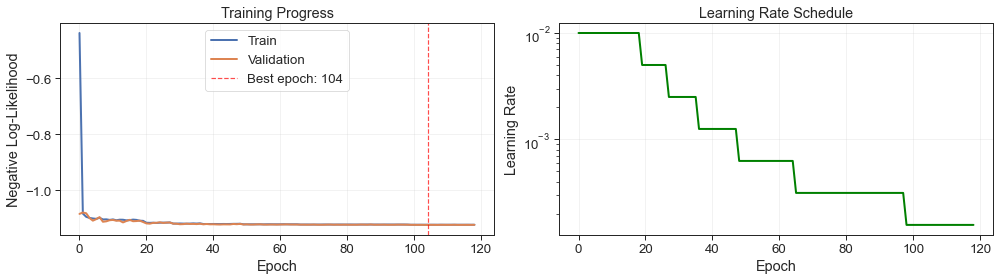

Training curve saved to: single_model_training.png


In [10]:
# Plot loss curves
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Training and validation loss
axes[0].plot(history['train_loss'], label='Train', linewidth=2)
axes[0].plot(history['val_loss'], label='Validation', linewidth=2)
axes[0].axvline(history['best_epoch'], color='red', linestyle='--', 
                label=f'Best epoch: {history["best_epoch"]}', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Negative Log-Likelihood')
axes[0].set_title('Training Progress')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Learning rate
axes[1].plot(history['learning_rate'], linewidth=2, color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('single_model_training.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Training curve saved to: single_model_training.png")

## Example 3: Sample from Trained Model

Generating 100,000 samples...
Generated samples shape: (100000, 2)
Sample range: m' ∈ [0.012, 0.991]
             θ' ∈ [0.007, 0.992]


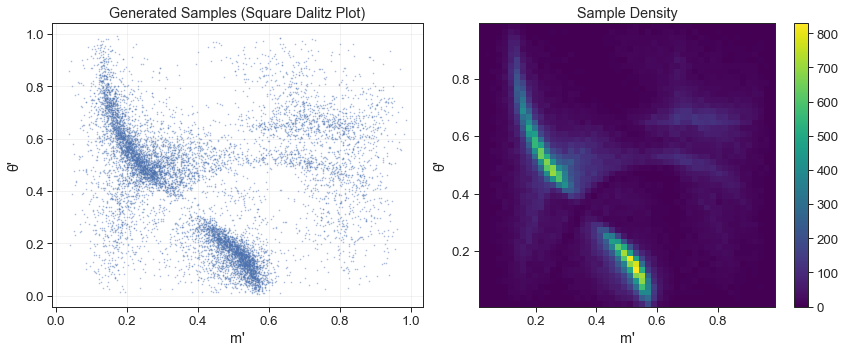

Sample plot saved to: generated_samples.png


In [11]:
# Load best model
flow.eval()
flow.to(device)

# Generate samples
print("Generating 100,000 samples...")
with torch.no_grad():
    samples = flow.sample(100_000).cpu().numpy()

print(f"Generated samples shape: {samples.shape}")
print(f"Sample range: m' ∈ [{samples[:,0].min():.3f}, {samples[:,0].max():.3f}]")
print(f"             θ' ∈ [{samples[:,1].min():.3f}, {samples[:,1].max():.3f}]")

# Plot samples
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 2D scatter
axes[0].scatter(samples[:10000, 0], samples[:10000, 1], 
                alpha=0.3, s=1, rasterized=True)
axes[0].set_xlabel("m'")
axes[0].set_ylabel("θ'")
axes[0].set_title('Generated Samples (Square Dalitz Plot)')
axes[0].grid(True, alpha=0.3)

# 2D histogram
h = axes[1].hist2d(samples[:, 0], samples[:, 1], bins=50, cmap='viridis')
axes[1].set_xlabel("m'")
axes[1].set_ylabel("θ'")
axes[1].set_title('Sample Density')
plt.colorbar(h[3], ax=axes[1])

plt.tight_layout()
plt.savefig('generated_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Sample plot saved to: generated_samples.png")

## Example 4: Train Small Ensemble (for testing)

In [32]:
# Train a small ensemble (25 models) to test the pipeline
# Uses bootstrap resampling (with replacement), fixed epochs
results = train_ensemble(
    data_path="D_Kspipi_SDP_2e7.npy",  
    output_dir="test_ensemble_2e6/",
    num_trials=25,
    bootstrap_size= 2_000_000,
    batch_size=50000,
    lr=0.009,
    num_epochs=250,
    num_flows=12,
    hidden_features=128,
    num_bins=24,
    device=device
)

print("\nSmall ensemble complete!")
print("Check the 'test_ensemble_2e6/' directory for results")

Training:  48%|██████████████▉                | 120/250 [23:32<26:26, 12.20s/it]

[120] Train: -1.125167, LR: 7.41e-04


Training:  49%|███████████████▏               | 122/250 [23:56<25:58, 12.17s/it]

[122] Train: -1.125263, LR: 7.41e-04


Training:  50%|███████████████▍               | 124/250 [24:21<25:29, 12.14s/it]

[124] Train: -1.125308, LR: 7.41e-04


Training:  50%|███████████████▌               | 126/250 [24:45<24:56, 12.07s/it]

[126] Train: -1.125154, LR: 7.41e-04


Training:  51%|███████████████▊               | 128/250 [25:09<24:42, 12.15s/it]

[128] Train: -1.125261, LR: 7.41e-04


Training:  52%|████████████████               | 130/250 [25:33<23:57, 11.98s/it]

[130] Train: -1.125031, LR: 7.41e-04


Training:  53%|████████████████▎              | 132/250 [25:57<23:42, 12.05s/it]

[132] Train: -1.125167, LR: 7.41e-04


Training:  54%|████████████████▌              | 134/250 [26:21<23:30, 12.16s/it]

[134] Train: -1.125084, LR: 7.41e-04


Training:  54%|████████████████▊              | 136/250 [26:45<22:50, 12.02s/it]

[136] Train: -1.125210, LR: 7.41e-04


Training:  55%|█████████████████              | 138/250 [27:09<22:28, 12.04s/it]

[138] Train: -1.125206, LR: 7.41e-04


Training:  56%|█████████████████▎             | 140/250 [27:34<22:12, 12.11s/it]

[140] Train: -1.124923, LR: 7.41e-04


Training:  57%|█████████████████▌             | 142/250 [27:58<21:47, 12.10s/it]

[142] Train: -1.125080, LR: 7.41e-04


Training:  58%|█████████████████▊             | 144/250 [28:22<21:24, 12.11s/it]

[144] Train: -1.125256, LR: 7.41e-04


Training:  58%|██████████████████             | 146/250 [28:46<20:38, 11.91s/it]

[146] Train: -1.125204, LR: 7.41e-04


Training:  59%|██████████████████▎            | 148/250 [29:09<20:07, 11.83s/it]

[148] Train: -1.125130, LR: 7.41e-04


Training:  60%|██████████████████▌            | 150/250 [29:33<19:41, 11.82s/it]

[150] Train: -1.125095, LR: 7.41e-04


Training:  61%|██████████████████▊            | 152/250 [29:56<19:18, 11.82s/it]

[152] Train: -1.125080, LR: 7.41e-04


Training:  62%|███████████████████            | 154/250 [30:20<18:52, 11.80s/it]

[154] Train: -1.125192, LR: 7.41e-04


Training:  62%|███████████████████▎           | 156/250 [30:44<18:28, 11.80s/it]

[156] Train: -1.125110, LR: 7.41e-04


Training:  63%|███████████████████▌           | 158/250 [31:07<18:01, 11.75s/it]

[158] Train: -1.125123, LR: 7.41e-04


Training:  64%|███████████████████▊           | 160/250 [31:31<17:38, 11.76s/it]

[160] Train: -1.125098, LR: 7.41e-04


Training:  65%|████████████████████           | 162/250 [31:54<17:23, 11.86s/it]

[162] Train: -1.125094, LR: 7.41e-04


Training:  66%|████████████████████▎          | 164/250 [32:19<17:18, 12.08s/it]

[164] Train: -1.125175, LR: 7.41e-04


Training:  66%|████████████████████▌          | 166/250 [32:44<17:13, 12.31s/it]

[166] Train: -1.125166, LR: 7.41e-04


Training:  67%|████████████████████▊          | 168/250 [33:09<16:53, 12.35s/it]

[168] Train: -1.125007, LR: 7.41e-04


Training:  68%|█████████████████████          | 170/250 [33:34<16:33, 12.42s/it]

[170] Train: -1.125310, LR: 7.41e-04


Training:  69%|█████████████████████▎         | 172/250 [33:59<16:13, 12.48s/it]

[172] Train: -1.125078, LR: 7.41e-04


Training:  70%|█████████████████████▌         | 174/250 [34:24<15:48, 12.48s/it]

[174] Train: -1.125257, LR: 7.41e-04


Training:  70%|█████████████████████▊         | 176/250 [34:49<15:29, 12.56s/it]

[176] Train: -1.125181, LR: 7.41e-04


Training:  71%|██████████████████████         | 178/250 [35:14<14:58, 12.48s/it]

[178] Train: -1.125161, LR: 7.41e-04


Training:  72%|██████████████████████▎        | 180/250 [35:39<14:36, 12.52s/it]

[180] Train: -1.125210, LR: 7.41e-04


Training:  73%|██████████████████████▌        | 182/250 [36:04<14:11, 12.52s/it]

[182] Train: -1.125217, LR: 7.41e-04


Training:  74%|██████████████████████▊        | 184/250 [36:28<13:31, 12.29s/it]

[184] Train: -1.125284, LR: 7.41e-04


Training:  74%|███████████████████████        | 186/250 [36:49<12:15, 11.50s/it]

[186] Train: -1.125359, LR: 7.41e-04


Training:  75%|███████████████████████▎       | 188/250 [37:11<11:28, 11.11s/it]

[188] Train: -1.125404, LR: 7.41e-04


Training:  76%|███████████████████████▌       | 190/250 [37:32<10:52, 10.88s/it]

[190] Train: -1.125367, LR: 7.41e-04


Training:  77%|███████████████████████▊       | 192/250 [37:54<10:26, 10.80s/it]

[192] Train: -1.125226, LR: 7.41e-04


Training:  78%|████████████████████████       | 194/250 [38:15<10:00, 10.73s/it]

[194] Train: -1.125176, LR: 7.41e-04


Training:  78%|████████████████████████▎      | 196/250 [38:36<09:38, 10.71s/it]

[196] Train: -1.125454, LR: 7.41e-04


Training:  79%|████████████████████████▌      | 198/250 [38:58<09:15, 10.68s/it]

[198] Train: -1.125276, LR: 7.41e-04


Training:  80%|████████████████████████▊      | 200/250 [39:19<08:54, 10.69s/it]

[200] Train: -1.125330, LR: 7.41e-04


Training:  81%|█████████████████████████      | 202/250 [39:41<08:32, 10.69s/it]

[202] Train: -1.125175, LR: 7.41e-04


Training:  82%|█████████████████████████▎     | 204/250 [40:02<08:10, 10.66s/it]

[204] Train: -1.125454, LR: 7.41e-04


Training:  82%|█████████████████████████▌     | 206/250 [40:23<07:50, 10.69s/it]

[206] Train: -1.124947, LR: 7.41e-04


Training:  83%|█████████████████████████▊     | 208/250 [40:45<07:29, 10.69s/it]

[208] Train: -1.125513, LR: 7.41e-04


Training:  84%|██████████████████████████     | 210/250 [41:06<07:07, 10.69s/it]

[210] Train: -1.125362, LR: 7.41e-04


Training:  85%|██████████████████████████▎    | 212/250 [41:27<06:45, 10.67s/it]

[212] Train: -1.125325, LR: 5.19e-04


Training:  86%|██████████████████████████▌    | 214/250 [41:49<06:26, 10.73s/it]

[214] Train: -1.125794, LR: 5.19e-04


Training:  86%|██████████████████████████▊    | 216/250 [42:11<06:04, 10.73s/it]

[216] Train: -1.125823, LR: 5.19e-04


Training:  87%|███████████████████████████    | 218/250 [42:32<05:42, 10.72s/it]

[218] Train: -1.125735, LR: 5.19e-04


Training:  88%|███████████████████████████▎   | 220/250 [42:53<05:20, 10.69s/it]

[220] Train: -1.125754, LR: 5.19e-04


Training:  89%|███████████████████████████▌   | 222/250 [43:15<04:59, 10.70s/it]

[222] Train: -1.125849, LR: 5.19e-04


Training:  90%|███████████████████████████▊   | 224/250 [43:36<04:37, 10.68s/it]

[224] Train: -1.125739, LR: 5.19e-04


Training:  90%|████████████████████████████   | 226/250 [43:57<04:16, 10.68s/it]

[226] Train: -1.125838, LR: 5.19e-04


Training:  91%|████████████████████████████▎  | 228/250 [44:19<03:54, 10.68s/it]

[228] Train: -1.125634, LR: 5.19e-04


Training:  92%|████████████████████████████▌  | 230/250 [44:40<03:33, 10.67s/it]

[230] Train: -1.125714, LR: 5.19e-04


Training:  93%|████████████████████████████▊  | 232/250 [45:01<03:12, 10.67s/it]

[232] Train: -1.125959, LR: 3.63e-04


Training:  94%|█████████████████████████████  | 234/250 [45:22<02:50, 10.68s/it]

[234] Train: -1.125976, LR: 3.63e-04


Training:  94%|█████████████████████████████▎ | 236/250 [45:44<02:29, 10.68s/it]

[236] Train: -1.126036, LR: 3.63e-04


Training:  95%|█████████████████████████████▌ | 238/250 [46:05<02:08, 10.67s/it]

[238] Train: -1.126092, LR: 3.63e-04


Training:  96%|█████████████████████████████▊ | 240/250 [46:26<01:46, 10.66s/it]

[240] Train: -1.125968, LR: 3.63e-04


Training:  97%|██████████████████████████████ | 242/250 [46:48<01:25, 10.65s/it]

[242] Train: -1.125966, LR: 3.63e-04


Training:  98%|██████████████████████████████▎| 244/250 [47:09<01:03, 10.65s/it]

[244] Train: -1.126065, LR: 3.63e-04


Training:  98%|██████████████████████████████▌| 246/250 [47:30<00:42, 10.67s/it]

[246] Train: -1.126095, LR: 3.63e-04


Training:  99%|██████████████████████████████▊| 248/250 [47:52<00:21, 10.65s/it]

[248] Train: -1.125925, LR: 3.63e-04


Training: 100%|███████████████████████████████| 250/250 [48:13<00:00, 11.57s/it]

[250] Train: -1.126121, LR: 3.63e-04
Final loss: -1.126121

TRIAL 5/25


Bootstrap sample: 2,000,000 (10.0% unique)


Training:   0%|▏                                | 1/250 [00:10<44:53, 10.82s/it]

[001] Train: -0.430617, LR: 9.00e-03


Training:   1%|▎                                | 2/250 [00:21<44:07, 10.68s/it]

[002] Train: -1.072841, LR: 9.00e-03


Training:   2%|▌                                | 4/250 [00:42<43:56, 10.72s/it]

[004] Train: -1.102370, LR: 9.00e-03


Training:   2%|▊                                | 6/250 [01:04<43:29, 10.69s/it]

[006] Train: -1.108224, LR: 9.00e-03


Training:   3%|█                                | 8/250 [01:25<43:04, 10.68s/it]

[008] Train: -1.109328, LR: 9.00e-03


Training:   4%|█▎                              | 10/250 [01:46<42:39, 10.66s/it]

[010] Train: -1.112986, LR: 9.00e-03


Training:   5%|█▌                              | 12/250 [02:08<42:21, 10.68s/it]

[012] Train: -1.111458, LR: 9.00e-03


Training:   6%|█▊                              | 14/250 [02:29<41:54, 10.65s/it]

[014] Train: -1.114484, LR: 9.00e-03


Training:   6%|██                              | 16/250 [02:51<41:37, 10.67s/it]

[016] Train: -1.114271, LR: 9.00e-03


Training:   7%|██▎                             | 18/250 [03:12<41:23, 10.70s/it]

[018] Train: -1.115543, LR: 9.00e-03


Training:   8%|██▌                             | 20/250 [03:33<40:58, 10.69s/it]

[020] Train: -1.115686, LR: 9.00e-03


Training:   9%|██▊                             | 22/250 [03:55<40:29, 10.66s/it]

[022] Train: -1.115017, LR: 9.00e-03


Training:  10%|███                             | 24/250 [04:16<40:09, 10.66s/it]

[024] Train: -1.116672, LR: 9.00e-03


Training:  10%|███▎                            | 26/250 [04:37<39:48, 10.66s/it]

[026] Train: -1.114697, LR: 9.00e-03


Training:  11%|███▌                            | 28/250 [04:58<39:24, 10.65s/it]

[028] Train: -1.116148, LR: 9.00e-03


Training:  12%|███▊                            | 30/250 [05:20<39:00, 10.64s/it]

[030] Train: -1.117255, LR: 9.00e-03


Training:  13%|████                            | 32/250 [05:41<38:42, 10.65s/it]

[032] Train: -1.118106, LR: 9.00e-03


Training:  14%|████▎                           | 34/250 [06:02<38:28, 10.69s/it]

[034] Train: -1.116695, LR: 9.00e-03


Training:  14%|████▌                           | 36/250 [06:24<38:04, 10.67s/it]

[036] Train: -1.117429, LR: 9.00e-03


Training:  15%|████▊                           | 38/250 [06:45<37:44, 10.68s/it]

[038] Train: -1.119709, LR: 6.30e-03


Training:  16%|█████                           | 40/250 [07:06<37:23, 10.68s/it]

[040] Train: -1.119615, LR: 6.30e-03


Training:  17%|█████▍                          | 42/250 [07:28<37:10, 10.72s/it]

[042] Train: -1.120082, LR: 6.30e-03


Training:  18%|█████▋                          | 44/250 [07:49<36:44, 10.70s/it]

[044] Train: -1.119917, LR: 6.30e-03


Training:  18%|█████▉                          | 46/250 [08:11<36:19, 10.69s/it]

[046] Train: -1.118170, LR: 6.30e-03


Training:  19%|██████▏                         | 48/250 [08:32<35:53, 10.66s/it]

[048] Train: -1.119885, LR: 6.30e-03


Training:  20%|██████▍                         | 50/250 [08:53<35:29, 10.65s/it]

[050] Train: -1.120084, LR: 6.30e-03


Training:  21%|██████▋                         | 52/250 [09:14<35:05, 10.63s/it]

[052] Train: -1.120681, LR: 4.41e-03


Training:  22%|██████▉                         | 54/250 [09:36<34:46, 10.65s/it]

[054] Train: -1.121141, LR: 4.41e-03


Training:  22%|███████▏                        | 56/250 [09:57<34:27, 10.66s/it]

[056] Train: -1.121208, LR: 4.41e-03


Training:  23%|███████▍                        | 58/250 [10:19<34:07, 10.66s/it]

[058] Train: -1.120959, LR: 4.41e-03


Training:  24%|███████▋                        | 60/250 [10:40<33:44, 10.66s/it]

[060] Train: -1.121250, LR: 4.41e-03


Training:  25%|███████▉                        | 62/250 [11:01<33:26, 10.67s/it]

[062] Train: -1.121090, LR: 4.41e-03


Training:  26%|████████▏                       | 64/250 [11:23<33:08, 10.69s/it]

[064] Train: -1.121132, LR: 4.41e-03


Training:  26%|████████▍                       | 66/250 [11:44<32:42, 10.66s/it]

[066] Train: -1.121472, LR: 3.09e-03


Training:  27%|████████▋                       | 68/250 [12:05<32:17, 10.64s/it]

[068] Train: -1.121974, LR: 3.09e-03


Training:  28%|████████▉                       | 70/250 [12:27<32:04, 10.69s/it]

[070] Train: -1.121661, LR: 3.09e-03


Training:  29%|█████████▏                      | 72/250 [12:48<31:43, 10.69s/it]

[072] Train: -1.121855, LR: 3.09e-03


Training:  30%|█████████▍                      | 74/250 [13:09<31:15, 10.66s/it]

[074] Train: -1.121511, LR: 3.09e-03


Training:  30%|█████████▋                      | 76/250 [13:31<30:52, 10.65s/it]

[076] Train: -1.121867, LR: 3.09e-03


Training:  31%|█████████▉                      | 78/250 [13:52<30:28, 10.63s/it]

[078] Train: -1.121819, LR: 3.09e-03


Training:  32%|██████████▏                     | 80/250 [14:13<30:07, 10.63s/it]

[080] Train: -1.122486, LR: 2.16e-03


Training:  33%|██████████▍                     | 82/250 [14:34<29:54, 10.68s/it]

[082] Train: -1.122403, LR: 2.16e-03


Training:  34%|██████████▊                     | 84/250 [14:56<29:33, 10.68s/it]

[084] Train: -1.122198, LR: 2.16e-03


Training:  34%|███████████                     | 86/250 [15:17<29:12, 10.69s/it]

[086] Train: -1.122281, LR: 2.16e-03


Training:  35%|███████████▎                    | 88/250 [15:39<28:54, 10.70s/it]

[088] Train: -1.122506, LR: 2.16e-03


Training:  36%|███████████▌                    | 90/250 [16:00<28:28, 10.68s/it]

[090] Train: -1.122428, LR: 2.16e-03


Training:  37%|███████████▊                    | 92/250 [16:21<28:03, 10.65s/it]

[092] Train: -1.122403, LR: 2.16e-03


Training:  38%|████████████                    | 94/250 [16:42<27:37, 10.63s/it]

[094] Train: -1.122387, LR: 2.16e-03


Training:  38%|████████████▎                   | 96/250 [17:04<27:23, 10.68s/it]

[096] Train: -1.122339, LR: 2.16e-03


Training:  39%|████████████▌                   | 98/250 [17:25<26:57, 10.64s/it]

[098] Train: -1.122347, LR: 2.16e-03


Training:  40%|████████████▍                  | 100/250 [17:46<26:36, 10.64s/it]

[100] Train: -1.122463, LR: 2.16e-03


Training:  41%|████████████▋                  | 102/250 [18:08<26:19, 10.67s/it]

[102] Train: -1.122333, LR: 2.16e-03


Training:  42%|████████████▉                  | 104/250 [18:29<25:54, 10.64s/it]

[104] Train: -1.121949, LR: 2.16e-03


Training:  42%|█████████████▏                 | 106/250 [18:50<25:30, 10.63s/it]

[106] Train: -1.122226, LR: 2.16e-03


Training:  43%|█████████████▍                 | 108/250 [19:12<25:10, 10.63s/it]

[108] Train: -1.122804, LR: 1.51e-03


Training:  44%|█████████████▋                 | 110/250 [19:33<24:46, 10.62s/it]

[110] Train: -1.122964, LR: 1.51e-03


Training:  45%|█████████████▉                 | 112/250 [19:54<24:27, 10.64s/it]

[112] Train: -1.122977, LR: 1.51e-03


Training:  46%|██████████████▏                | 114/250 [20:15<24:06, 10.63s/it]

[114] Train: -1.122774, LR: 1.51e-03


Training:  46%|██████████████▍                | 116/250 [20:37<23:44, 10.63s/it]

[116] Train: -1.122838, LR: 1.51e-03


Training:  47%|██████████████▋                | 118/250 [20:58<23:23, 10.63s/it]

[118] Train: -1.122779, LR: 1.51e-03


Training:  48%|██████████████▉                | 120/250 [21:19<23:03, 10.64s/it]

[120] Train: -1.122868, LR: 1.51e-03


Training:  49%|███████████████▏               | 122/250 [21:41<22:43, 10.65s/it]

[122] Train: -1.122818, LR: 1.51e-03


Training:  50%|███████████████▍               | 124/250 [22:02<22:28, 10.70s/it]

[124] Train: -1.123367, LR: 1.06e-03


Training:  50%|███████████████▌               | 126/250 [22:23<22:05, 10.69s/it]

[126] Train: -1.123035, LR: 1.06e-03


Training:  51%|███████████████▊               | 128/250 [22:45<21:42, 10.68s/it]

[128] Train: -1.123372, LR: 1.06e-03


Training:  52%|████████████████               | 130/250 [23:06<21:19, 10.66s/it]

[130] Train: -1.123381, LR: 1.06e-03


Training:  53%|████████████████▎              | 132/250 [23:27<20:57, 10.65s/it]

[132] Train: -1.123378, LR: 1.06e-03


Training:  54%|████████████████▌              | 134/250 [23:49<20:38, 10.68s/it]

[134] Train: -1.123398, LR: 1.06e-03


Training:  54%|████████████████▊              | 136/250 [24:10<20:15, 10.66s/it]

[136] Train: -1.123319, LR: 1.06e-03


Training:  55%|█████████████████              | 138/250 [24:31<19:52, 10.65s/it]

[138] Train: -1.123241, LR: 1.06e-03


Training:  56%|█████████████████▎             | 140/250 [24:52<19:32, 10.66s/it]

[140] Train: -1.123062, LR: 1.06e-03


Training:  57%|█████████████████▌             | 142/250 [25:14<19:12, 10.67s/it]

[142] Train: -1.123326, LR: 1.06e-03


Training:  58%|█████████████████▊             | 144/250 [25:35<18:53, 10.69s/it]

[144] Train: -1.123173, LR: 1.06e-03


Training:  58%|██████████████████             | 146/250 [25:56<18:30, 10.68s/it]

[146] Train: -1.123278, LR: 1.06e-03


Training:  59%|██████████████████▎            | 148/250 [26:18<18:07, 10.66s/it]

[148] Train: -1.123123, LR: 1.06e-03


Training:  60%|██████████████████▌            | 150/250 [26:39<17:48, 10.69s/it]

[150] Train: -1.123336, LR: 1.06e-03


Training:  61%|██████████████████▊            | 152/250 [27:00<17:23, 10.65s/it]

[152] Train: -1.123172, LR: 1.06e-03


Training:  62%|███████████████████            | 154/250 [27:22<17:02, 10.65s/it]

[154] Train: -1.123340, LR: 1.06e-03


Training:  62%|███████████████████▎           | 156/250 [27:43<16:40, 10.65s/it]

[156] Train: -1.123290, LR: 1.06e-03


Training:  63%|███████████████████▌           | 158/250 [28:05<16:22, 10.68s/it]

[158] Train: -1.123097, LR: 1.06e-03


Training:  64%|███████████████████▊           | 160/250 [28:26<15:59, 10.66s/it]

[160] Train: -1.123032, LR: 1.06e-03


Training:  65%|████████████████████           | 162/250 [28:47<15:36, 10.64s/it]

[162] Train: -1.122921, LR: 1.06e-03


Training:  66%|████████████████████▎          | 164/250 [29:08<15:15, 10.65s/it]

[164] Train: -1.123612, LR: 7.41e-04


Training:  66%|████████████████████▌          | 166/250 [29:30<14:54, 10.64s/it]

[166] Train: -1.123544, LR: 7.41e-04


Training:  67%|████████████████████▊          | 168/250 [29:51<14:32, 10.64s/it]

[168] Train: -1.123672, LR: 7.41e-04


Training:  68%|█████████████████████          | 170/250 [30:12<14:12, 10.65s/it]

[170] Train: -1.123738, LR: 7.41e-04


Training:  69%|█████████████████████▎         | 172/250 [30:34<13:50, 10.64s/it]

[172] Train: -1.123731, LR: 7.41e-04


Training:  70%|█████████████████████▌         | 174/250 [30:55<13:26, 10.61s/it]

[174] Train: -1.123724, LR: 7.41e-04


Training:  70%|█████████████████████▊         | 176/250 [31:16<13:07, 10.65s/it]

[176] Train: -1.123674, LR: 7.41e-04


Training:  71%|██████████████████████         | 178/250 [31:38<12:50, 10.71s/it]

[178] Train: -1.123555, LR: 7.41e-04


Training:  72%|██████████████████████▎        | 180/250 [31:59<12:28, 10.69s/it]

[180] Train: -1.123682, LR: 7.41e-04


Training:  73%|██████████████████████▌        | 182/250 [32:20<12:06, 10.68s/it]

[182] Train: -1.123596, LR: 7.41e-04


Training:  74%|██████████████████████▊        | 184/250 [32:42<11:46, 10.71s/it]

[184] Train: -1.123391, LR: 7.41e-04


Training:  74%|███████████████████████        | 186/250 [33:03<11:22, 10.67s/it]

[186] Train: -1.123457, LR: 7.41e-04


Training:  75%|███████████████████████▎       | 188/250 [33:24<11:01, 10.67s/it]

[188] Train: -1.123630, LR: 7.41e-04


Training:  76%|███████████████████████▌       | 190/250 [33:46<10:41, 10.70s/it]

[190] Train: -1.123405, LR: 7.41e-04


Training:  77%|███████████████████████▊       | 192/250 [34:07<10:19, 10.68s/it]

[192] Train: -1.123435, LR: 7.41e-04


Training:  78%|████████████████████████       | 194/250 [34:29<09:59, 10.71s/it]

[194] Train: -1.123567, LR: 7.41e-04


Training:  78%|████████████████████████▎      | 196/250 [34:50<09:36, 10.68s/it]

[196] Train: -1.123501, LR: 7.41e-04


Training:  79%|████████████████████████▌      | 198/250 [35:11<09:16, 10.70s/it]

[198] Train: -1.123726, LR: 7.41e-04


Training:  80%|████████████████████████▊      | 200/250 [35:33<08:55, 10.70s/it]

[200] Train: -1.123665, LR: 7.41e-04


Training:  81%|█████████████████████████      | 202/250 [35:54<08:32, 10.67s/it]

[202] Train: -1.123640, LR: 7.41e-04


Training:  82%|█████████████████████████▎     | 204/250 [36:15<08:09, 10.65s/it]

[204] Train: -1.123707, LR: 7.41e-04


Training:  82%|█████████████████████████▌     | 206/250 [36:37<07:49, 10.67s/it]

[206] Train: -1.123599, LR: 7.41e-04


Training:  83%|█████████████████████████▊     | 208/250 [36:58<07:28, 10.68s/it]

[208] Train: -1.123538, LR: 7.41e-04


Training:  84%|██████████████████████████     | 210/250 [37:19<07:05, 10.64s/it]

[210] Train: -1.123710, LR: 7.41e-04


Training:  85%|██████████████████████████▎    | 212/250 [37:41<06:44, 10.65s/it]

[212] Train: -1.123575, LR: 7.41e-04


Training:  86%|██████████████████████████▌    | 214/250 [38:02<06:23, 10.66s/it]

[214] Train: -1.123702, LR: 7.41e-04


Training:  86%|██████████████████████████▊    | 216/250 [38:23<06:01, 10.64s/it]

[216] Train: -1.123591, LR: 7.41e-04


Training:  87%|███████████████████████████    | 218/250 [38:45<05:40, 10.64s/it]

[218] Train: -1.123680, LR: 7.41e-04


Training:  88%|███████████████████████████▎   | 220/250 [39:06<05:19, 10.64s/it]

[220] Train: -1.123707, LR: 7.41e-04


Training:  89%|███████████████████████████▌   | 222/250 [39:28<05:02, 10.80s/it]

[222] Train: -1.123745, LR: 7.41e-04


Training:  90%|███████████████████████████▊   | 224/250 [39:49<04:38, 10.73s/it]

[224] Train: -1.123811, LR: 7.41e-04


Training:  90%|████████████████████████████   | 226/250 [40:10<04:16, 10.70s/it]

[226] Train: -1.123519, LR: 7.41e-04


Training:  91%|████████████████████████████▎  | 228/250 [40:32<03:55, 10.70s/it]

[228] Train: -1.123775, LR: 7.41e-04


Training:  92%|████████████████████████████▌  | 230/250 [40:53<03:33, 10.69s/it]

[230] Train: -1.123425, LR: 7.41e-04


Training:  93%|████████████████████████████▊  | 232/250 [41:14<03:11, 10.66s/it]

[232] Train: -1.123639, LR: 7.41e-04


Training:  94%|█████████████████████████████  | 234/250 [41:36<02:50, 10.67s/it]

[234] Train: -1.123452, LR: 7.41e-04


Training:  94%|█████████████████████████████▎ | 236/250 [41:57<02:28, 10.62s/it]

[236] Train: -1.123700, LR: 7.41e-04


Training:  95%|█████████████████████████████▌ | 238/250 [42:18<02:08, 10.69s/it]

[238] Train: -1.123716, LR: 7.41e-04


Training:  96%|█████████████████████████████▊ | 240/250 [42:40<01:46, 10.67s/it]

[240] Train: -1.123682, LR: 7.41e-04


Training:  97%|██████████████████████████████ | 242/250 [43:01<01:25, 10.67s/it]

[242] Train: -1.123781, LR: 7.41e-04


Training:  98%|██████████████████████████████▎| 244/250 [43:23<01:04, 10.70s/it]

[244] Train: -1.123738, LR: 7.41e-04


Training:  98%|██████████████████████████████▌| 246/250 [43:44<00:42, 10.64s/it]

[246] Train: -1.123647, LR: 7.41e-04


Training:  99%|██████████████████████████████▊| 248/250 [44:05<00:21, 10.69s/it]

[248] Train: -1.123924, LR: 7.41e-04


Training: 100%|███████████████████████████████| 250/250 [44:26<00:00, 10.67s/it]

[250] Train: -1.123618, LR: 7.41e-04
Final loss: -1.123618

TRIAL 6/25


Bootstrap sample: 2,000,000 (10.0% unique)


Training:   0%|▏                                | 1/250 [00:10<43:49, 10.56s/it]

[001] Train: -0.394084, LR: 9.00e-03


Training:   1%|▎                                | 2/250 [00:21<43:51, 10.61s/it]

[002] Train: -1.072389, LR: 9.00e-03


Training:   2%|▌                                | 4/250 [00:42<43:38, 10.64s/it]

[004] Train: -1.105640, LR: 9.00e-03


Training:   2%|▊                                | 6/250 [01:03<43:26, 10.68s/it]

[006] Train: -1.110284, LR: 9.00e-03


Training:   3%|█                                | 8/250 [01:25<43:03, 10.68s/it]

[008] Train: -1.110452, LR: 9.00e-03


Training:   4%|█▎                              | 10/250 [01:46<42:32, 10.64s/it]

[010] Train: -1.114262, LR: 9.00e-03


Training:   5%|█▌                              | 12/250 [02:07<42:18, 10.66s/it]

[012] Train: -1.115827, LR: 9.00e-03


Training:   6%|█▊                              | 14/250 [02:29<41:57, 10.67s/it]

[014] Train: -1.115860, LR: 9.00e-03


Training:   6%|██                              | 16/250 [02:50<41:28, 10.64s/it]

[016] Train: -1.116587, LR: 9.00e-03


Training:   7%|██▎                             | 18/250 [03:11<41:09, 10.65s/it]

[018] Train: -1.117159, LR: 9.00e-03


Training:   8%|██▌                             | 20/250 [03:33<40:52, 10.66s/it]

[020] Train: -1.118547, LR: 9.00e-03


Training:   9%|██▊                             | 22/250 [03:54<40:38, 10.70s/it]

[022] Train: -1.115951, LR: 9.00e-03


Training:  10%|███                             | 24/250 [04:15<40:07, 10.65s/it]

[024] Train: -1.119199, LR: 9.00e-03


Training:  10%|███▎                            | 26/250 [04:37<39:50, 10.67s/it]

[026] Train: -1.118975, LR: 9.00e-03


Training:  11%|███▌                            | 28/250 [04:58<39:25, 10.65s/it]

[028] Train: -1.117741, LR: 9.00e-03


Training:  12%|███▊                            | 30/250 [05:20<39:03, 10.65s/it]

[030] Train: -1.118021, LR: 9.00e-03


Training:  13%|████                            | 32/250 [05:41<38:42, 10.66s/it]

[032] Train: -1.121246, LR: 6.30e-03


Training:  14%|████▎                           | 34/250 [06:02<38:33, 10.71s/it]

[034] Train: -1.121207, LR: 6.30e-03


Training:  14%|████▌                           | 36/250 [06:24<38:10, 10.70s/it]

[036] Train: -1.122500, LR: 6.30e-03


Training:  15%|████▊                           | 38/250 [06:45<37:50, 10.71s/it]

[038] Train: -1.121106, LR: 6.30e-03


Training:  16%|█████                           | 40/250 [07:06<37:22, 10.68s/it]

[040] Train: -1.121282, LR: 4.41e-03


Training:  17%|█████▍                          | 42/250 [07:28<37:04, 10.69s/it]

[042] Train: -1.123769, LR: 4.41e-03


Training:  18%|█████▋                          | 44/250 [07:49<36:41, 10.69s/it]

[044] Train: -1.123268, LR: 4.41e-03


Training:  18%|█████▉                          | 46/250 [08:11<36:21, 10.70s/it]

[046] Train: -1.123576, LR: 3.09e-03


Training:  19%|██████▏                         | 48/250 [08:32<36:01, 10.70s/it]

[048] Train: -1.124225, LR: 3.09e-03


Training:  20%|██████▍                         | 50/250 [08:53<35:42, 10.71s/it]

[050] Train: -1.124102, LR: 3.09e-03


Training:  21%|██████▋                         | 52/250 [09:15<35:17, 10.69s/it]

[052] Train: -1.123642, LR: 2.16e-03


Training:  22%|██████▉                         | 54/250 [09:36<34:56, 10.70s/it]

[054] Train: -1.124394, LR: 2.16e-03


Training:  22%|███████▏                        | 56/250 [09:57<34:32, 10.68s/it]

[056] Train: -1.124615, LR: 2.16e-03


Training:  23%|███████▍                        | 58/250 [10:19<34:14, 10.70s/it]

[058] Train: -1.124599, LR: 2.16e-03


Training:  24%|███████▋                        | 60/250 [10:40<33:50, 10.69s/it]

[060] Train: -1.124832, LR: 2.16e-03


Training:  25%|███████▉                        | 62/250 [11:01<33:23, 10.66s/it]

[062] Train: -1.124521, LR: 2.16e-03


Training:  26%|████████▏                       | 64/250 [11:23<33:09, 10.70s/it]

[064] Train: -1.124523, LR: 1.51e-03


Training:  26%|████████▍                       | 66/250 [11:44<32:47, 10.69s/it]

[066] Train: -1.125203, LR: 1.51e-03


Training:  27%|████████▋                       | 68/250 [12:06<32:19, 10.65s/it]

[068] Train: -1.124837, LR: 1.51e-03


Training:  28%|████████▉                       | 70/250 [12:27<31:55, 10.64s/it]

[070] Train: -1.125184, LR: 1.51e-03


Training:  29%|█████████▏                      | 72/250 [12:48<31:35, 10.65s/it]

[072] Train: -1.125067, LR: 1.51e-03


Training:  30%|█████████▍                      | 74/250 [13:10<31:20, 10.68s/it]

[074] Train: -1.124813, LR: 1.06e-03


Training:  30%|█████████▋                      | 76/250 [13:31<30:56, 10.67s/it]

[076] Train: -1.125473, LR: 1.06e-03


Training:  31%|█████████▉                      | 78/250 [13:52<30:33, 10.66s/it]

[078] Train: -1.125536, LR: 1.06e-03


Training:  32%|██████████▏                     | 80/250 [14:14<30:14, 10.67s/it]

[080] Train: -1.125330, LR: 1.06e-03


Training:  33%|██████████▍                     | 82/250 [14:35<29:45, 10.63s/it]

[082] Train: -1.125486, LR: 1.06e-03


Training:  34%|██████████▊                     | 84/250 [14:56<29:25, 10.64s/it]

[084] Train: -1.125353, LR: 1.06e-03


Training:  34%|███████████                     | 86/250 [15:18<29:15, 10.70s/it]

[086] Train: -1.125396, LR: 1.06e-03


Training:  35%|███████████▎                    | 88/250 [15:39<28:54, 10.71s/it]

[088] Train: -1.125284, LR: 1.06e-03


Training:  36%|███████████▌                    | 90/250 [16:01<28:32, 10.70s/it]

[090] Train: -1.125187, LR: 1.06e-03


Training:  37%|███████████▊                    | 92/250 [16:22<28:08, 10.69s/it]

[092] Train: -1.125322, LR: 1.06e-03


Training:  38%|████████████                    | 94/250 [16:43<27:50, 10.71s/it]

[094] Train: -1.125222, LR: 1.06e-03


Training:  38%|████████████▎                   | 96/250 [17:05<27:32, 10.73s/it]

[096] Train: -1.125308, LR: 1.06e-03


Training:  39%|████████████▌                   | 98/250 [17:26<27:08, 10.71s/it]

[098] Train: -1.125218, LR: 1.06e-03


Training:  40%|████████████▍                  | 100/250 [17:48<26:44, 10.70s/it]

[100] Train: -1.125241, LR: 1.06e-03


Training:  41%|████████████▋                  | 102/250 [18:09<26:24, 10.71s/it]

[102] Train: -1.125336, LR: 1.06e-03


Training:  42%|████████████▉                  | 104/250 [18:30<26:03, 10.71s/it]

[104] Train: -1.125233, LR: 1.06e-03


Training:  42%|█████████████▏                 | 106/250 [18:52<25:39, 10.69s/it]

[106] Train: -1.125264, LR: 1.06e-03


Training:  43%|█████████████▍                 | 108/250 [19:14<25:41, 10.85s/it]

[108] Train: -1.125253, LR: 1.06e-03


Training:  44%|█████████████▋                 | 110/250 [19:35<25:12, 10.80s/it]

[110] Train: -1.125302, LR: 1.06e-03


Training:  45%|█████████████▉                 | 112/250 [19:57<24:42, 10.74s/it]

[112] Train: -1.125267, LR: 1.06e-03


Training:  46%|██████████████▏                | 114/250 [20:18<24:23, 10.76s/it]

[114] Train: -1.125302, LR: 1.06e-03


Training:  46%|██████████████▍                | 116/250 [20:40<23:54, 10.71s/it]

[116] Train: -1.125026, LR: 1.06e-03


Training:  47%|██████████████▋                | 118/250 [21:01<23:28, 10.67s/it]

[118] Train: -1.125347, LR: 1.06e-03


Training:  48%|██████████████▉                | 120/250 [21:22<23:05, 10.66s/it]

[120] Train: -1.125318, LR: 1.06e-03


Training:  49%|███████████████▏               | 122/250 [21:44<22:46, 10.68s/it]

[122] Train: -1.125200, LR: 1.06e-03


Training:  50%|███████████████▍               | 124/250 [22:05<22:20, 10.64s/it]

[124] Train: -1.124860, LR: 7.41e-04


Training:  50%|███████████████▌               | 126/250 [22:26<21:57, 10.63s/it]

[126] Train: -1.125574, LR: 7.41e-04


Training:  51%|███████████████▊               | 128/250 [22:47<21:41, 10.67s/it]

[128] Train: -1.125977, LR: 7.41e-04


Training:  52%|████████████████               | 130/250 [23:09<21:19, 10.66s/it]

[130] Train: -1.125716, LR: 7.41e-04


Training:  53%|████████████████▎              | 132/250 [23:30<20:58, 10.67s/it]

[132] Train: -1.125614, LR: 5.19e-04


Training:  54%|████████████████▌              | 134/250 [23:51<20:36, 10.66s/it]

[134] Train: -1.126134, LR: 5.19e-04


Training:  54%|████████████████▊              | 136/250 [24:13<20:17, 10.68s/it]

[136] Train: -1.126149, LR: 5.19e-04


Training:  55%|█████████████████              | 138/250 [24:34<19:53, 10.65s/it]

[138] Train: -1.126009, LR: 5.19e-04


Training:  56%|█████████████████▎             | 140/250 [24:56<19:37, 10.70s/it]

[140] Train: -1.126150, LR: 5.19e-04


Training:  57%|█████████████████▌             | 142/250 [25:17<19:12, 10.67s/it]

[142] Train: -1.126167, LR: 5.19e-04


Training:  58%|█████████████████▊             | 144/250 [25:38<18:54, 10.71s/it]

[144] Train: -1.126036, LR: 5.19e-04


Training:  58%|██████████████████             | 146/250 [26:00<18:29, 10.67s/it]

[146] Train: -1.126065, LR: 5.19e-04


Training:  59%|██████████████████▎            | 148/250 [26:21<18:08, 10.67s/it]

[148] Train: -1.125981, LR: 5.19e-04


Training:  60%|██████████████████▌            | 150/250 [26:42<17:46, 10.66s/it]

[150] Train: -1.125997, LR: 5.19e-04


Training:  61%|██████████████████▊            | 152/250 [27:04<17:25, 10.66s/it]

[152] Train: -1.126158, LR: 5.19e-04


Training:  62%|███████████████████            | 154/250 [27:25<17:03, 10.66s/it]

[154] Train: -1.126049, LR: 5.19e-04


Training:  62%|███████████████████▎           | 156/250 [27:46<16:42, 10.67s/it]

[156] Train: -1.125918, LR: 5.19e-04


Training:  63%|███████████████████▌           | 158/250 [28:08<16:22, 10.67s/it]

[158] Train: -1.126176, LR: 5.19e-04


Training:  64%|███████████████████▊           | 160/250 [28:29<16:01, 10.68s/it]

[160] Train: -1.125882, LR: 5.19e-04


Training:  65%|████████████████████           | 162/250 [28:50<15:37, 10.66s/it]

[162] Train: -1.126163, LR: 5.19e-04


Training:  66%|████████████████████▎          | 164/250 [29:11<15:17, 10.67s/it]

[164] Train: -1.126079, LR: 5.19e-04


Training:  66%|████████████████████▌          | 166/250 [29:33<14:57, 10.68s/it]

[166] Train: -1.126151, LR: 5.19e-04


Training:  67%|████████████████████▊          | 168/250 [29:54<14:33, 10.65s/it]

[168] Train: -1.126030, LR: 5.19e-04


Training:  68%|█████████████████████          | 170/250 [30:15<14:11, 10.64s/it]

[170] Train: -1.125917, LR: 3.63e-04


Training:  69%|█████████████████████▎         | 172/250 [30:37<13:49, 10.64s/it]

[172] Train: -1.126372, LR: 3.63e-04


Training:  70%|█████████████████████▌         | 174/250 [30:58<13:29, 10.66s/it]

[174] Train: -1.126426, LR: 3.63e-04


Training:  70%|█████████████████████▊         | 176/250 [31:19<13:07, 10.64s/it]

[176] Train: -1.126336, LR: 3.63e-04


Training:  71%|██████████████████████         | 178/250 [31:41<12:47, 10.66s/it]

[178] Train: -1.126349, LR: 3.63e-04


Training:  72%|██████████████████████▎        | 180/250 [32:02<12:25, 10.64s/it]

[180] Train: -1.126326, LR: 3.63e-04


Training:  73%|██████████████████████▌        | 182/250 [32:23<12:03, 10.64s/it]

[182] Train: -1.126448, LR: 3.63e-04


Training:  74%|██████████████████████▊        | 184/250 [32:45<11:43, 10.66s/it]

[184] Train: -1.126366, LR: 3.63e-04


Training:  74%|███████████████████████        | 186/250 [33:06<11:22, 10.67s/it]

[186] Train: -1.126315, LR: 3.63e-04


Training:  75%|███████████████████████▎       | 188/250 [33:27<10:59, 10.64s/it]

[188] Train: -1.126069, LR: 3.63e-04


Training:  76%|███████████████████████▌       | 190/250 [33:49<10:37, 10.62s/it]

[190] Train: -1.126419, LR: 3.63e-04


Training:  77%|███████████████████████▊       | 192/250 [34:10<10:19, 10.68s/it]

[192] Train: -1.126356, LR: 3.63e-04


Training:  78%|████████████████████████       | 194/250 [34:31<09:58, 10.69s/it]

[194] Train: -1.126437, LR: 3.63e-04


Training:  78%|████████████████████████▎      | 196/250 [34:53<09:36, 10.68s/it]

[196] Train: -1.126417, LR: 3.63e-04


Training:  79%|████████████████████████▌      | 198/250 [35:14<09:15, 10.67s/it]

[198] Train: -1.126346, LR: 3.63e-04


Training:  80%|████████████████████████▊      | 200/250 [35:35<08:53, 10.66s/it]

[200] Train: -1.126342, LR: 3.63e-04


Training:  81%|█████████████████████████      | 202/250 [35:56<08:30, 10.64s/it]

[202] Train: -1.126515, LR: 3.63e-04


Training:  82%|█████████████████████████▎     | 204/250 [36:18<08:11, 10.68s/it]

[204] Train: -1.126535, LR: 3.63e-04


Training:  82%|█████████████████████████▌     | 206/250 [36:39<07:49, 10.68s/it]

[206] Train: -1.126327, LR: 3.63e-04


Training:  83%|█████████████████████████▊     | 208/250 [37:01<07:28, 10.67s/it]

[208] Train: -1.126251, LR: 2.54e-04


Training:  84%|██████████████████████████     | 210/250 [37:22<07:08, 10.71s/it]

[210] Train: -1.126613, LR: 2.54e-04


Training:  85%|██████████████████████████▎    | 212/250 [37:43<06:46, 10.69s/it]

[212] Train: -1.126616, LR: 2.54e-04


Training:  86%|██████████████████████████▌    | 214/250 [38:05<06:24, 10.68s/it]

[214] Train: -1.126619, LR: 2.54e-04


Training:  86%|██████████████████████████▊    | 216/250 [38:26<06:04, 10.71s/it]

[216] Train: -1.126654, LR: 2.54e-04


Training:  87%|███████████████████████████    | 218/250 [38:47<05:41, 10.69s/it]

[218] Train: -1.126616, LR: 2.54e-04


Training:  88%|███████████████████████████▎   | 220/250 [39:09<05:19, 10.64s/it]

[220] Train: -1.126691, LR: 2.54e-04


Training:  89%|███████████████████████████▌   | 222/250 [39:30<04:58, 10.66s/it]

[222] Train: -1.126595, LR: 2.54e-04


Training:  90%|███████████████████████████▊   | 224/250 [39:51<04:37, 10.67s/it]

[224] Train: -1.126548, LR: 2.54e-04


Training:  90%|████████████████████████████   | 226/250 [40:13<04:15, 10.64s/it]

[226] Train: -1.126590, LR: 2.54e-04


Training:  91%|████████████████████████████▎  | 228/250 [40:34<03:53, 10.63s/it]

[228] Train: -1.126582, LR: 2.54e-04


Training:  92%|████████████████████████████▌  | 230/250 [40:55<03:32, 10.63s/it]

[230] Train: -1.126574, LR: 2.54e-04


Training:  93%|████████████████████████████▊  | 232/250 [41:16<03:11, 10.64s/it]

[232] Train: -1.126578, LR: 2.54e-04


Training:  94%|█████████████████████████████  | 234/250 [41:38<02:50, 10.65s/it]

[234] Train: -1.126669, LR: 2.54e-04


Training:  94%|█████████████████████████████▎ | 236/250 [41:59<02:28, 10.62s/it]

[236] Train: -1.126704, LR: 2.54e-04


Training:  95%|█████████████████████████████▌ | 238/250 [42:20<02:07, 10.63s/it]

[238] Train: -1.126653, LR: 2.54e-04


Training:  96%|█████████████████████████████▊ | 240/250 [42:42<01:46, 10.66s/it]

[240] Train: -1.126708, LR: 2.54e-04


Training:  97%|██████████████████████████████ | 242/250 [43:03<01:25, 10.64s/it]

[242] Train: -1.126720, LR: 2.54e-04


Training:  98%|██████████████████████████████▎| 244/250 [43:24<01:03, 10.64s/it]

[244] Train: -1.126699, LR: 2.54e-04


Training:  98%|██████████████████████████████▌| 246/250 [43:46<00:42, 10.70s/it]

[246] Train: -1.126711, LR: 2.54e-04


Training:  99%|██████████████████████████████▊| 248/250 [44:07<00:21, 10.71s/it]

[248] Train: -1.126757, LR: 2.54e-04


Training: 100%|███████████████████████████████| 250/250 [44:29<00:00, 10.68s/it]

[250] Train: -1.126657, LR: 2.54e-04
Final loss: -1.126657

TRIAL 7/25


Bootstrap sample: 2,000,000 (10.0% unique)


Training:   0%|▏                                | 1/250 [00:10<43:55, 10.59s/it]

[001] Train: -0.445878, LR: 9.00e-03


Training:   1%|▎                                | 2/250 [00:21<44:06, 10.67s/it]

[002] Train: -1.067937, LR: 9.00e-03


Training:   2%|▌                                | 4/250 [00:42<43:45, 10.67s/it]

[004] Train: -1.101567, LR: 9.00e-03


Training:   2%|▊                                | 6/250 [01:03<43:21, 10.66s/it]

[006] Train: -1.104944, LR: 9.00e-03


Training:   3%|█                                | 8/250 [01:25<42:56, 10.65s/it]

[008] Train: -1.111397, LR: 9.00e-03


Training:   4%|█▎                              | 10/250 [01:46<42:33, 10.64s/it]

[010] Train: -1.111373, LR: 9.00e-03


Training:   5%|█▌                              | 12/250 [02:07<42:15, 10.65s/it]

[012] Train: -1.107316, LR: 9.00e-03


Training:   6%|█▊                              | 14/250 [02:28<41:52, 10.65s/it]

[014] Train: -1.113795, LR: 9.00e-03


Training:   6%|██                              | 16/250 [02:50<41:38, 10.68s/it]

[016] Train: -1.114215, LR: 9.00e-03


Training:   7%|██▎                             | 18/250 [03:11<41:20, 10.69s/it]

[018] Train: -1.115056, LR: 9.00e-03


Training:   8%|██▌                             | 20/250 [03:33<41:02, 10.71s/it]

[020] Train: -1.115677, LR: 9.00e-03


Training:   9%|██▊                             | 22/250 [03:54<40:41, 10.71s/it]

[022] Train: -1.114502, LR: 9.00e-03


Training:  10%|███                             | 24/250 [04:15<40:15, 10.69s/it]

[024] Train: -1.117284, LR: 6.30e-03


Training:  10%|███▎                            | 26/250 [04:37<39:49, 10.67s/it]

[026] Train: -1.119728, LR: 6.30e-03


Training:  11%|███▌                            | 28/250 [04:58<39:24, 10.65s/it]

[028] Train: -1.118894, LR: 6.30e-03


Training:  12%|███▊                            | 30/250 [05:19<39:02, 10.65s/it]

[030] Train: -1.118630, LR: 4.41e-03


Training:  13%|████                            | 32/250 [05:41<38:39, 10.64s/it]

[032] Train: -1.121085, LR: 4.41e-03


Training:  14%|████▎                           | 34/250 [06:02<38:18, 10.64s/it]

[034] Train: -1.121353, LR: 4.41e-03


Training:  14%|████▌                           | 36/250 [06:23<37:57, 10.64s/it]

[036] Train: -1.120830, LR: 4.41e-03


Training:  15%|████▊                           | 38/250 [06:44<37:32, 10.63s/it]

[038] Train: -1.121979, LR: 3.09e-03


Training:  16%|█████                           | 40/250 [07:06<37:17, 10.65s/it]

[040] Train: -1.122077, LR: 3.09e-03


Training:  17%|█████▍                          | 42/250 [07:27<36:53, 10.64s/it]

[042] Train: -1.122096, LR: 3.09e-03


Training:  18%|█████▋                          | 44/250 [07:48<36:26, 10.62s/it]

[044] Train: -1.121813, LR: 3.09e-03


Training:  18%|█████▉                          | 46/250 [08:10<36:06, 10.62s/it]

[046] Train: -1.121994, LR: 3.09e-03


Training:  19%|██████▏                         | 48/250 [08:31<35:51, 10.65s/it]

[048] Train: -1.122035, LR: 3.09e-03


Training:  20%|██████▍                         | 50/250 [08:52<35:33, 10.67s/it]

[050] Train: -1.121798, LR: 3.09e-03


Training:  21%|██████▋                         | 52/250 [09:14<35:16, 10.69s/it]

[052] Train: -1.122819, LR: 2.16e-03


Training:  22%|██████▉                         | 54/250 [09:35<34:50, 10.67s/it]

[054] Train: -1.122965, LR: 2.16e-03


Training:  22%|███████▏                        | 56/250 [09:56<34:31, 10.68s/it]

[056] Train: -1.122633, LR: 2.16e-03


Training:  23%|███████▍                        | 58/250 [10:18<34:02, 10.64s/it]

[058] Train: -1.122487, LR: 1.51e-03


Training:  24%|███████▋                        | 60/250 [10:39<33:45, 10.66s/it]

[060] Train: -1.123087, LR: 1.51e-03


Training:  25%|███████▉                        | 62/250 [11:00<33:17, 10.62s/it]

[062] Train: -1.123374, LR: 1.51e-03


Training:  26%|████████▏                       | 64/250 [11:21<32:58, 10.63s/it]

[064] Train: -1.123523, LR: 1.51e-03


Training:  26%|████████▍                       | 66/250 [11:43<32:40, 10.65s/it]

[066] Train: -1.123387, LR: 1.51e-03


Training:  27%|████████▋                       | 68/250 [12:04<32:11, 10.61s/it]

[068] Train: -1.123313, LR: 1.06e-03


Training:  28%|████████▉                       | 70/250 [12:25<31:59, 10.66s/it]

[070] Train: -1.123883, LR: 1.06e-03


Training:  29%|█████████▏                      | 72/250 [12:46<31:38, 10.67s/it]

[072] Train: -1.123693, LR: 1.06e-03


Training:  30%|█████████▍                      | 74/250 [13:08<31:13, 10.65s/it]

[074] Train: -1.123872, LR: 1.06e-03


Training:  30%|█████████▋                      | 76/250 [13:29<30:51, 10.64s/it]

[076] Train: -1.123746, LR: 1.06e-03


Training:  31%|█████████▉                      | 78/250 [13:50<30:28, 10.63s/it]

[078] Train: -1.123763, LR: 1.06e-03


Training:  32%|██████████▏                     | 80/250 [14:12<30:13, 10.67s/it]

[080] Train: -1.123749, LR: 1.06e-03


Training:  33%|██████████▍                     | 82/250 [14:33<29:52, 10.67s/it]

[082] Train: -1.123746, LR: 1.06e-03


Training:  34%|██████████▊                     | 84/250 [14:54<29:26, 10.64s/it]

[084] Train: -1.123784, LR: 1.06e-03


Training:  34%|███████████                     | 86/250 [15:16<29:03, 10.63s/it]

[086] Train: -1.123708, LR: 1.06e-03


Training:  35%|███████████▎                    | 88/250 [15:37<28:41, 10.63s/it]

[088] Train: -1.123809, LR: 1.06e-03


Training:  36%|███████████▌                    | 90/250 [15:58<28:23, 10.65s/it]

[090] Train: -1.123897, LR: 7.41e-04


Training:  37%|███████████▊                    | 92/250 [16:19<28:03, 10.65s/it]

[092] Train: -1.124131, LR: 7.41e-04


Training:  38%|████████████                    | 94/250 [16:41<27:43, 10.66s/it]

[094] Train: -1.124030, LR: 7.41e-04


Training:  38%|████████████▎                   | 96/250 [17:02<27:20, 10.65s/it]

[096] Train: -1.124015, LR: 7.41e-04


Training:  39%|████████████▌                   | 98/250 [17:24<26:57, 10.64s/it]

[098] Train: -1.123609, LR: 7.41e-04


Training:  40%|████████████▍                  | 100/250 [17:45<26:39, 10.67s/it]

[100] Train: -1.123819, LR: 7.41e-04


Training:  41%|████████████▋                  | 102/250 [18:06<26:24, 10.71s/it]

[102] Train: -1.124048, LR: 7.41e-04


Training:  42%|████████████▉                  | 104/250 [18:28<25:58, 10.67s/it]

[104] Train: -1.124180, LR: 7.41e-04


Training:  42%|█████████████▏                 | 106/250 [18:49<25:39, 10.69s/it]

[106] Train: -1.124287, LR: 7.41e-04


Training:  43%|█████████████▍                 | 108/250 [19:11<25:21, 10.72s/it]

[108] Train: -1.124130, LR: 7.41e-04


Training:  44%|█████████████▋                 | 110/250 [19:32<24:55, 10.68s/it]

[110] Train: -1.124288, LR: 7.41e-04


Training:  45%|█████████████▉                 | 112/250 [19:53<24:36, 10.70s/it]

[112] Train: -1.123295, LR: 7.41e-04


Training:  46%|██████████████▏                | 114/250 [20:15<24:14, 10.69s/it]

[114] Train: -1.124158, LR: 5.19e-04


Training:  46%|██████████████▍                | 116/250 [20:36<23:52, 10.69s/it]

[116] Train: -1.124518, LR: 5.19e-04


Training:  47%|██████████████▋                | 118/250 [20:57<23:28, 10.67s/it]

[118] Train: -1.124543, LR: 5.19e-04


Training:  48%|██████████████▉                | 120/250 [21:18<23:05, 10.66s/it]

[120] Train: -1.124460, LR: 5.19e-04


Training:  49%|███████████████▏               | 122/250 [21:40<22:46, 10.67s/it]

[122] Train: -1.124686, LR: 5.19e-04


Training:  50%|███████████████▍               | 124/250 [22:01<22:26, 10.68s/it]

[124] Train: -1.124539, LR: 5.19e-04


Training:  50%|███████████████▌               | 126/250 [22:22<22:06, 10.69s/it]

[126] Train: -1.124554, LR: 5.19e-04


Training:  51%|███████████████▊               | 128/250 [22:44<21:45, 10.70s/it]

[128] Train: -1.124576, LR: 5.19e-04


Training:  52%|████████████████               | 130/250 [23:05<21:19, 10.67s/it]

[130] Train: -1.124559, LR: 5.19e-04


Training:  53%|████████████████▎              | 132/250 [23:27<20:59, 10.67s/it]

[132] Train: -1.124486, LR: 5.19e-04


Training:  54%|████████████████▌              | 134/250 [23:48<20:33, 10.63s/it]

[134] Train: -1.124688, LR: 5.19e-04


Training:  54%|████████████████▊              | 136/250 [24:09<20:16, 10.67s/it]

[136] Train: -1.124365, LR: 5.19e-04


Training:  55%|█████████████████              | 138/250 [24:30<19:52, 10.65s/it]

[138] Train: -1.124476, LR: 3.63e-04


Training:  56%|█████████████████▎             | 140/250 [24:52<19:31, 10.65s/it]

[140] Train: -1.124808, LR: 3.63e-04


Training:  57%|█████████████████▌             | 142/250 [25:13<19:10, 10.66s/it]

[142] Train: -1.124819, LR: 3.63e-04


Training:  58%|█████████████████▊             | 144/250 [25:34<18:49, 10.66s/it]

[144] Train: -1.124793, LR: 3.63e-04


Training:  58%|██████████████████             | 146/250 [25:56<18:29, 10.66s/it]

[146] Train: -1.124671, LR: 3.63e-04


Training:  59%|██████████████████▎            | 148/250 [26:17<18:07, 10.67s/it]

[148] Train: -1.124774, LR: 3.63e-04


Training:  60%|██████████████████▌            | 150/250 [26:39<17:47, 10.67s/it]

[150] Train: -1.124767, LR: 3.63e-04


Training:  61%|██████████████████▊            | 152/250 [27:00<17:24, 10.66s/it]

[152] Train: -1.124805, LR: 3.63e-04


Training:  62%|███████████████████            | 154/250 [27:21<17:01, 10.64s/it]

[154] Train: -1.124910, LR: 3.63e-04


Training:  62%|███████████████████▎           | 156/250 [27:43<16:44, 10.69s/it]

[156] Train: -1.124858, LR: 3.63e-04


Training:  63%|███████████████████▌           | 158/250 [28:04<16:24, 10.70s/it]

[158] Train: -1.124811, LR: 3.63e-04


Training:  64%|███████████████████▊           | 160/250 [28:25<16:02, 10.70s/it]

[160] Train: -1.124908, LR: 3.63e-04


Training:  65%|████████████████████           | 162/250 [28:47<15:39, 10.67s/it]

[162] Train: -1.124695, LR: 3.63e-04


Training:  66%|████████████████████▎          | 164/250 [29:08<15:16, 10.66s/it]

[164] Train: -1.124696, LR: 3.63e-04


Training:  66%|████████████████████▌          | 166/250 [29:29<14:55, 10.66s/it]

[166] Train: -1.124984, LR: 3.63e-04


Training:  67%|████████████████████▊          | 168/250 [29:51<14:36, 10.68s/it]

[168] Train: -1.124904, LR: 3.63e-04


Training:  68%|█████████████████████          | 170/250 [30:12<14:15, 10.69s/it]

[170] Train: -1.124852, LR: 3.63e-04


Training:  69%|█████████████████████▎         | 172/250 [30:33<13:56, 10.72s/it]

[172] Train: -1.124908, LR: 3.63e-04


Training:  70%|█████████████████████▌         | 174/250 [30:55<13:34, 10.72s/it]

[174] Train: -1.124790, LR: 3.63e-04


Training:  70%|█████████████████████▊         | 176/250 [31:16<13:12, 10.71s/it]

[176] Train: -1.124852, LR: 3.63e-04


Training:  71%|██████████████████████         | 178/250 [31:38<12:50, 10.70s/it]

[178] Train: -1.124809, LR: 3.63e-04


Training:  72%|██████████████████████▎        | 180/250 [31:59<12:27, 10.67s/it]

[180] Train: -1.124957, LR: 3.63e-04


Training:  73%|██████████████████████▌        | 182/250 [32:20<12:06, 10.68s/it]

[182] Train: -1.124862, LR: 3.63e-04


Training:  74%|██████████████████████▊        | 184/250 [32:41<11:40, 10.62s/it]

[184] Train: -1.124729, LR: 3.63e-04


Training:  74%|███████████████████████        | 186/250 [33:03<11:23, 10.68s/it]

[186] Train: -1.124819, LR: 3.63e-04


Training:  75%|███████████████████████▎       | 188/250 [33:24<10:59, 10.64s/it]

[188] Train: -1.124739, LR: 3.63e-04


Training:  76%|███████████████████████▌       | 190/250 [33:46<10:40, 10.68s/it]

[190] Train: -1.124876, LR: 3.63e-04


Training:  77%|███████████████████████▊       | 192/250 [34:07<10:19, 10.68s/it]

[192] Train: -1.124961, LR: 3.63e-04


Training:  78%|████████████████████████       | 194/250 [34:28<09:57, 10.67s/it]

[194] Train: -1.124849, LR: 3.63e-04


Training:  78%|████████████████████████▎      | 196/250 [34:50<09:35, 10.66s/it]

[196] Train: -1.124962, LR: 3.63e-04


Training:  79%|████████████████████████▌      | 198/250 [35:11<09:13, 10.64s/it]

[198] Train: -1.125011, LR: 3.63e-04


Training:  80%|████████████████████████▊      | 200/250 [35:32<08:53, 10.68s/it]

[200] Train: -1.124836, LR: 3.63e-04


Training:  81%|█████████████████████████      | 202/250 [35:54<08:32, 10.68s/it]

[202] Train: -1.125012, LR: 3.63e-04


Training:  82%|█████████████████████████▎     | 204/250 [36:15<08:09, 10.65s/it]

[204] Train: -1.124836, LR: 3.63e-04


Training:  82%|█████████████████████████▌     | 206/250 [36:36<07:48, 10.66s/it]

[206] Train: -1.124841, LR: 3.63e-04


Training:  83%|█████████████████████████▊     | 208/250 [36:58<07:28, 10.69s/it]

[208] Train: -1.125033, LR: 3.63e-04


Training:  84%|██████████████████████████     | 210/250 [37:19<07:06, 10.67s/it]

[210] Train: -1.125097, LR: 3.63e-04


Training:  85%|██████████████████████████▎    | 212/250 [37:40<06:45, 10.67s/it]

[212] Train: -1.124950, LR: 3.63e-04


Training:  86%|██████████████████████████▌    | 214/250 [38:02<06:23, 10.65s/it]

[214] Train: -1.124874, LR: 3.63e-04


Training:  86%|██████████████████████████▊    | 216/250 [38:23<06:02, 10.66s/it]

[216] Train: -1.124957, LR: 3.63e-04


Training:  87%|███████████████████████████    | 218/250 [38:44<05:41, 10.66s/it]

[218] Train: -1.125173, LR: 2.54e-04


Training:  88%|███████████████████████████▎   | 220/250 [39:06<05:20, 10.68s/it]

[220] Train: -1.125305, LR: 2.54e-04


Training:  89%|███████████████████████████▌   | 222/250 [39:27<04:58, 10.67s/it]

[222] Train: -1.125274, LR: 2.54e-04


Training:  90%|███████████████████████████▊   | 224/250 [39:48<04:37, 10.66s/it]

[224] Train: -1.125169, LR: 2.54e-04


Training:  90%|████████████████████████████   | 226/250 [40:09<04:15, 10.66s/it]

[226] Train: -1.125185, LR: 2.54e-04


Training:  91%|████████████████████████████▎  | 228/250 [40:31<03:54, 10.65s/it]

[228] Train: -1.125248, LR: 2.54e-04


Training:  92%|████████████████████████████▌  | 230/250 [40:52<03:33, 10.68s/it]

[230] Train: -1.125296, LR: 2.54e-04


Training:  93%|████████████████████████████▊  | 232/250 [41:13<03:11, 10.66s/it]

[232] Train: -1.125229, LR: 2.54e-04


Training:  94%|█████████████████████████████  | 234/250 [41:35<02:50, 10.64s/it]

[234] Train: -1.125171, LR: 2.54e-04


Training:  94%|█████████████████████████████▎ | 236/250 [41:56<02:29, 10.65s/it]

[236] Train: -1.125306, LR: 2.54e-04


Training:  95%|█████████████████████████████▌ | 238/250 [42:17<02:07, 10.64s/it]

[238] Train: -1.125310, LR: 2.54e-04


Training:  96%|█████████████████████████████▊ | 240/250 [42:38<01:46, 10.62s/it]

[240] Train: -1.125345, LR: 2.54e-04


Training:  97%|██████████████████████████████ | 242/250 [43:00<01:24, 10.62s/it]

[242] Train: -1.125205, LR: 2.54e-04


Training:  98%|██████████████████████████████▎| 244/250 [43:21<01:03, 10.65s/it]

[244] Train: -1.125309, LR: 2.54e-04


Training:  98%|██████████████████████████████▌| 246/250 [43:42<00:42, 10.64s/it]

[246] Train: -1.125309, LR: 2.54e-04


Training:  99%|██████████████████████████████▊| 248/250 [44:04<00:21, 10.63s/it]

[248] Train: -1.125170, LR: 2.54e-04


Training: 100%|███████████████████████████████| 250/250 [44:25<00:00, 10.66s/it]

[250] Train: -1.125208, LR: 2.54e-04
Final loss: -1.125208

TRIAL 8/25


Bootstrap sample: 2,000,000 (10.0% unique)


Training:   0%|▏                                | 1/250 [00:10<44:28, 10.72s/it]

[001] Train: -0.369082, LR: 9.00e-03


Training:   1%|▎                                | 2/250 [00:21<44:09, 10.68s/it]

[002] Train: -1.068366, LR: 9.00e-03


Training:   2%|▌                                | 4/250 [00:42<43:36, 10.64s/it]

[004] Train: -1.102280, LR: 9.00e-03


Training:   2%|▊                                | 6/250 [01:04<43:21, 10.66s/it]

[006] Train: -1.106382, LR: 9.00e-03


Training:   3%|█                                | 8/250 [01:25<42:58, 10.66s/it]

[008] Train: -1.108645, LR: 9.00e-03


Training:   4%|█▎                              | 10/250 [01:46<42:40, 10.67s/it]

[010] Train: -1.111758, LR: 9.00e-03


Training:   5%|█▌                              | 12/250 [02:08<42:25, 10.69s/it]

[012] Train: -1.111413, LR: 9.00e-03


Training:   6%|█▊                              | 14/250 [02:29<42:02, 10.69s/it]

[014] Train: -1.113736, LR: 9.00e-03


Training:   6%|██                              | 16/250 [02:50<41:44, 10.70s/it]

[016] Train: -1.114323, LR: 9.00e-03


Training:   7%|██▎                             | 18/250 [03:12<41:26, 10.72s/it]

[018] Train: -1.113686, LR: 9.00e-03


Training:   8%|██▌                             | 20/250 [03:33<40:59, 10.69s/it]

[020] Train: -1.115734, LR: 9.00e-03


Training:   9%|██▊                             | 22/250 [03:55<40:44, 10.72s/it]

[022] Train: -1.114187, LR: 9.00e-03


Training:  10%|███                             | 24/250 [04:16<40:10, 10.67s/it]

[024] Train: -1.113727, LR: 9.00e-03


Training:  10%|███▎                            | 26/250 [04:37<39:57, 10.70s/it]

[026] Train: -1.116100, LR: 9.00e-03


Training:  11%|███▌                            | 28/250 [04:59<39:38, 10.71s/it]

[028] Train: -1.118278, LR: 9.00e-03


Training:  12%|███▊                            | 30/250 [05:20<39:13, 10.70s/it]

[030] Train: -1.117930, LR: 9.00e-03


Training:  13%|████                            | 32/250 [05:41<38:51, 10.70s/it]

[032] Train: -1.118957, LR: 9.00e-03


Training:  14%|████▎                           | 34/250 [06:03<38:22, 10.66s/it]

[034] Train: -1.115808, LR: 9.00e-03


Training:  14%|████▌                           | 36/250 [06:24<38:05, 10.68s/it]

[036] Train: -1.118298, LR: 6.30e-03


Training:  15%|████▊                           | 38/250 [06:45<37:41, 10.67s/it]

[038] Train: -1.120365, LR: 6.30e-03


Training:  16%|█████                           | 40/250 [07:07<37:25, 10.69s/it]

[040] Train: -1.120777, LR: 6.30e-03


Training:  17%|█████▍                          | 42/250 [07:28<36:58, 10.67s/it]

[042] Train: -1.119909, LR: 6.30e-03


Training:  18%|█████▋                          | 44/250 [07:50<36:38, 10.67s/it]

[044] Train: -1.120393, LR: 4.41e-03


Training:  18%|█████▉                          | 46/250 [08:11<36:21, 10.69s/it]

[046] Train: -1.121647, LR: 4.41e-03


Training:  19%|██████▏                         | 48/250 [08:32<36:02, 10.70s/it]

[048] Train: -1.121628, LR: 4.41e-03


Training:  20%|██████▍                         | 50/250 [08:54<35:41, 10.71s/it]

[050] Train: -1.121557, LR: 4.41e-03


Training:  21%|██████▋                         | 52/250 [09:15<35:20, 10.71s/it]

[052] Train: -1.121360, LR: 4.41e-03


Training:  22%|██████▉                         | 54/250 [09:37<34:56, 10.70s/it]

[054] Train: -1.121289, LR: 3.09e-03


Training:  22%|███████▏                        | 56/250 [09:58<34:29, 10.67s/it]

[056] Train: -1.122438, LR: 3.09e-03


Training:  23%|███████▍                        | 58/250 [10:20<34:18, 10.72s/it]

[058] Train: -1.122200, LR: 3.09e-03


Training:  24%|███████▋                        | 60/250 [10:41<33:47, 10.67s/it]

[060] Train: -1.122415, LR: 3.09e-03


Training:  25%|███████▉                        | 62/250 [11:02<33:24, 10.66s/it]

[062] Train: -1.122260, LR: 3.09e-03


Training:  26%|████████▏                       | 64/250 [11:24<33:12, 10.71s/it]

[064] Train: -1.121728, LR: 2.16e-03


Training:  26%|████████▍                       | 66/250 [11:45<32:53, 10.73s/it]

[066] Train: -1.122891, LR: 2.16e-03


Training:  27%|████████▋                       | 68/250 [12:07<32:28, 10.70s/it]

[068] Train: -1.122725, LR: 2.16e-03


Training:  28%|████████▉                       | 70/250 [12:28<32:03, 10.68s/it]

[070] Train: -1.122714, LR: 1.51e-03


Training:  29%|█████████▏                      | 72/250 [12:49<31:44, 10.70s/it]

[072] Train: -1.123165, LR: 1.51e-03


Training:  30%|█████████▍                      | 74/250 [13:11<31:20, 10.69s/it]

[074] Train: -1.123028, LR: 1.51e-03


Training:  30%|█████████▋                      | 76/250 [13:32<30:58, 10.68s/it]

[076] Train: -1.122796, LR: 1.51e-03


Training:  31%|█████████▉                      | 78/250 [13:53<30:38, 10.69s/it]

[078] Train: -1.123052, LR: 1.51e-03


Training:  32%|██████████▏                     | 80/250 [14:15<30:18, 10.69s/it]

[080] Train: -1.123225, LR: 1.51e-03


Training:  33%|██████████▍                     | 82/250 [14:36<29:57, 10.70s/it]

[082] Train: -1.123090, LR: 1.51e-03


Training:  34%|██████████▊                     | 84/250 [14:57<29:35, 10.69s/it]

[084] Train: -1.122869, LR: 1.51e-03


Training:  34%|███████████                     | 86/250 [15:19<29:14, 10.70s/it]

[086] Train: -1.123090, LR: 1.51e-03


Training:  35%|███████████▎                    | 88/250 [15:40<28:51, 10.69s/it]

[088] Train: -1.123132, LR: 1.51e-03


Training:  36%|███████████▌                    | 90/250 [16:01<28:34, 10.71s/it]

[090] Train: -1.122879, LR: 1.51e-03


Training:  37%|███████████▊                    | 92/250 [16:23<28:13, 10.72s/it]

[092] Train: -1.122924, LR: 1.51e-03


Training:  38%|████████████                    | 94/250 [16:44<27:48, 10.69s/it]

[094] Train: -1.122978, LR: 1.51e-03


Training:  38%|████████████▎                   | 96/250 [17:06<27:32, 10.73s/it]

[096] Train: -1.123044, LR: 1.51e-03


Training:  39%|████████████▌                   | 98/250 [17:27<27:09, 10.72s/it]

[098] Train: -1.122933, LR: 1.51e-03


Training:  40%|████████████▍                  | 100/250 [17:49<26:48, 10.72s/it]

[100] Train: -1.123070, LR: 1.51e-03


Training:  41%|████████████▋                  | 102/250 [18:10<26:22, 10.69s/it]

[102] Train: -1.122829, LR: 1.51e-03


Training:  42%|████████████▉                  | 104/250 [18:31<25:56, 10.66s/it]

[104] Train: -1.122962, LR: 1.51e-03


Training:  42%|█████████████▏                 | 106/250 [18:53<25:38, 10.68s/it]

[106] Train: -1.123261, LR: 1.51e-03


Training:  43%|█████████████▍                 | 108/250 [19:14<25:18, 10.69s/it]

[108] Train: -1.122889, LR: 1.51e-03


Training:  44%|█████████████▋                 | 110/250 [19:36<24:56, 10.69s/it]

[110] Train: -1.122810, LR: 1.06e-03


Training:  45%|█████████████▉                 | 112/250 [19:57<24:37, 10.71s/it]

[112] Train: -1.123480, LR: 1.06e-03


Training:  46%|██████████████▏                | 114/250 [20:18<24:12, 10.68s/it]

[114] Train: -1.123120, LR: 1.06e-03


Training:  46%|██████████████▍                | 116/250 [20:40<23:49, 10.67s/it]

[116] Train: -1.123403, LR: 1.06e-03


Training:  47%|██████████████▋                | 118/250 [21:01<23:33, 10.71s/it]

[118] Train: -1.123445, LR: 1.06e-03


Training:  48%|██████████████▉                | 120/250 [21:23<23:09, 10.68s/it]

[120] Train: -1.123317, LR: 1.06e-03


Training:  49%|███████████████▏               | 122/250 [21:44<22:47, 10.69s/it]

[122] Train: -1.123598, LR: 1.06e-03


Training:  50%|███████████████▍               | 124/250 [22:05<22:28, 10.71s/it]

[124] Train: -1.123292, LR: 1.06e-03


Training:  50%|███████████████▌               | 126/250 [22:27<22:05, 10.69s/it]

[126] Train: -1.123277, LR: 7.41e-04


Training:  51%|███████████████▊               | 128/250 [22:48<21:44, 10.70s/it]

[128] Train: -1.123726, LR: 7.41e-04


Training:  52%|████████████████               | 130/250 [23:09<21:22, 10.69s/it]

[130] Train: -1.123529, LR: 7.41e-04


Training:  53%|████████████████▎              | 132/250 [23:31<21:01, 10.69s/it]

[132] Train: -1.123732, LR: 7.41e-04


Training:  54%|████████████████▌              | 134/250 [23:52<20:39, 10.68s/it]

[134] Train: -1.123893, LR: 7.41e-04


Training:  54%|████████████████▊              | 136/250 [24:13<20:13, 10.64s/it]

[136] Train: -1.123721, LR: 7.41e-04


Training:  55%|█████████████████              | 138/250 [24:35<19:54, 10.67s/it]

[138] Train: -1.123685, LR: 5.19e-04


Training:  56%|█████████████████▎             | 140/250 [24:56<19:35, 10.69s/it]

[140] Train: -1.123957, LR: 5.19e-04


Training:  57%|█████████████████▌             | 142/250 [25:17<19:14, 10.69s/it]

[142] Train: -1.124034, LR: 5.19e-04


Training:  58%|█████████████████▊             | 144/250 [25:39<18:54, 10.70s/it]

[144] Train: -1.123985, LR: 5.19e-04


Training:  58%|██████████████████             | 146/250 [26:00<18:31, 10.69s/it]

[146] Train: -1.124054, LR: 5.19e-04


Training:  59%|██████████████████▎            | 148/250 [26:22<18:11, 10.70s/it]

[148] Train: -1.123833, LR: 5.19e-04


Training:  60%|██████████████████▌            | 150/250 [26:43<17:47, 10.67s/it]

[150] Train: -1.123855, LR: 5.19e-04


Training:  61%|██████████████████▊            | 152/250 [27:04<17:27, 10.69s/it]

[152] Train: -1.123966, LR: 5.19e-04


Training:  62%|███████████████████            | 154/250 [27:26<17:08, 10.71s/it]

[154] Train: -1.123926, LR: 5.19e-04


Training:  62%|███████████████████▎           | 156/250 [27:47<16:45, 10.70s/it]

[156] Train: -1.123860, LR: 5.19e-04


Training:  63%|███████████████████▌           | 158/250 [28:09<16:22, 10.68s/it]

[158] Train: -1.123785, LR: 5.19e-04


Training:  64%|███████████████████▊           | 160/250 [28:30<15:58, 10.65s/it]

[160] Train: -1.124043, LR: 5.19e-04


Training:  65%|████████████████████           | 162/250 [28:51<15:40, 10.69s/it]

[162] Train: -1.123969, LR: 5.19e-04


Training:  66%|████████████████████▎          | 164/250 [29:13<15:16, 10.66s/it]

[164] Train: -1.124062, LR: 5.19e-04


Training:  66%|████████████████████▌          | 166/250 [29:34<14:55, 10.66s/it]

[166] Train: -1.124009, LR: 5.19e-04


Training:  67%|████████████████████▊          | 168/250 [29:55<14:33, 10.65s/it]

[168] Train: -1.123993, LR: 5.19e-04


Training:  68%|█████████████████████          | 170/250 [30:17<14:15, 10.69s/it]

[170] Train: -1.123848, LR: 5.19e-04


Training:  69%|█████████████████████▎         | 172/250 [30:38<13:52, 10.68s/it]

[172] Train: -1.123834, LR: 5.19e-04


Training:  70%|█████████████████████▌         | 174/250 [31:00<13:34, 10.72s/it]

[174] Train: -1.123966, LR: 5.19e-04


Training:  70%|█████████████████████▊         | 176/250 [31:21<13:10, 10.69s/it]

[176] Train: -1.123936, LR: 5.19e-04


Training:  71%|██████████████████████         | 178/250 [31:42<12:50, 10.70s/it]

[178] Train: -1.123901, LR: 5.19e-04


Training:  72%|██████████████████████▎        | 180/250 [32:04<12:28, 10.69s/it]

[180] Train: -1.123852, LR: 5.19e-04


Training:  73%|██████████████████████▌        | 182/250 [32:25<12:07, 10.70s/it]

[182] Train: -1.123882, LR: 5.19e-04


Training:  74%|██████████████████████▊        | 184/250 [32:46<11:46, 10.70s/it]

[184] Train: -1.124080, LR: 5.19e-04


Training:  74%|███████████████████████        | 186/250 [33:08<11:22, 10.67s/it]

[186] Train: -1.123823, LR: 5.19e-04


Training:  75%|███████████████████████▎       | 188/250 [33:29<11:02, 10.69s/it]

[188] Train: -1.124060, LR: 5.19e-04


Training:  76%|███████████████████████▌       | 190/250 [33:50<10:40, 10.68s/it]

[190] Train: -1.123942, LR: 5.19e-04


Training:  77%|███████████████████████▊       | 192/250 [34:12<10:22, 10.73s/it]

[192] Train: -1.123906, LR: 5.19e-04


Training:  78%|████████████████████████       | 194/250 [34:33<10:00, 10.72s/it]

[194] Train: -1.124057, LR: 3.63e-04


Training:  78%|████████████████████████▎      | 196/250 [34:54<09:37, 10.69s/it]

[196] Train: -1.124200, LR: 3.63e-04


Training:  79%|████████████████████████▌      | 198/250 [35:16<09:12, 10.63s/it]

[198] Train: -1.124169, LR: 3.63e-04


Training:  80%|████████████████████████▊      | 200/250 [35:37<08:51, 10.63s/it]

[200] Train: -1.124151, LR: 3.63e-04


Training:  81%|█████████████████████████      | 202/250 [35:58<08:30, 10.64s/it]

[202] Train: -1.124274, LR: 3.63e-04


Training:  82%|█████████████████████████▎     | 204/250 [36:20<08:10, 10.66s/it]

[204] Train: -1.124255, LR: 3.63e-04


Training:  82%|█████████████████████████▌     | 206/250 [36:41<07:48, 10.65s/it]

[206] Train: -1.124267, LR: 3.63e-04


Training:  83%|█████████████████████████▊     | 208/250 [37:02<07:28, 10.67s/it]

[208] Train: -1.124203, LR: 3.63e-04


Training:  84%|██████████████████████████     | 210/250 [37:24<07:05, 10.63s/it]

[210] Train: -1.124254, LR: 3.63e-04


Training:  85%|██████████████████████████▎    | 212/250 [37:45<06:45, 10.67s/it]

[212] Train: -1.124273, LR: 3.63e-04


Training:  86%|██████████████████████████▌    | 214/250 [38:06<06:24, 10.69s/it]

[214] Train: -1.124296, LR: 3.63e-04


Training:  86%|██████████████████████████▊    | 216/250 [38:28<06:02, 10.65s/it]

[216] Train: -1.124249, LR: 3.63e-04


Training:  87%|███████████████████████████    | 218/250 [38:49<05:41, 10.67s/it]

[218] Train: -1.124259, LR: 3.63e-04


Training:  88%|███████████████████████████▎   | 220/250 [39:10<05:19, 10.65s/it]

[220] Train: -1.124338, LR: 3.63e-04


Training:  89%|███████████████████████████▌   | 222/250 [39:32<04:57, 10.63s/it]

[222] Train: -1.124220, LR: 3.63e-04


Training:  90%|███████████████████████████▊   | 224/250 [39:53<04:37, 10.67s/it]

[224] Train: -1.124237, LR: 3.63e-04


Training:  90%|████████████████████████████   | 226/250 [40:14<04:16, 10.69s/it]

[226] Train: -1.124200, LR: 3.63e-04


Training:  91%|████████████████████████████▎  | 228/250 [40:36<03:54, 10.68s/it]

[228] Train: -1.124126, LR: 3.63e-04


Training:  92%|████████████████████████████▌  | 230/250 [40:57<03:33, 10.67s/it]

[230] Train: -1.124267, LR: 3.63e-04


Training:  93%|████████████████████████████▊  | 232/250 [41:18<03:12, 10.67s/it]

[232] Train: -1.124316, LR: 3.63e-04


Training:  94%|█████████████████████████████  | 234/250 [41:40<02:50, 10.68s/it]

[234] Train: -1.124169, LR: 3.63e-04


Training:  94%|█████████████████████████████▎ | 236/250 [42:01<02:29, 10.69s/it]

[236] Train: -1.124265, LR: 3.63e-04


Training:  95%|█████████████████████████████▌ | 238/250 [42:22<02:08, 10.71s/it]

[238] Train: -1.124233, LR: 3.63e-04


Training:  96%|█████████████████████████████▊ | 240/250 [42:44<01:46, 10.70s/it]

[240] Train: -1.124249, LR: 3.63e-04


Training:  97%|██████████████████████████████ | 242/250 [43:05<01:25, 10.69s/it]

[242] Train: -1.124189, LR: 3.63e-04


Training:  98%|██████████████████████████████▎| 244/250 [43:26<01:04, 10.68s/it]

[244] Train: -1.124307, LR: 3.63e-04


Training:  98%|██████████████████████████████▌| 246/250 [43:48<00:42, 10.65s/it]

[246] Train: -1.124291, LR: 3.63e-04


Training:  99%|██████████████████████████████▊| 248/250 [44:09<00:21, 10.67s/it]

[248] Train: -1.124360, LR: 3.63e-04


Training: 100%|███████████████████████████████| 250/250 [44:30<00:00, 10.68s/it]

[250] Train: -1.124297, LR: 3.63e-04
Final loss: -1.124297

TRIAL 9/25


Bootstrap sample: 2,000,000 (10.0% unique)


Training:   0%|▏                                | 1/250 [00:10<44:24, 10.70s/it]

[001] Train: -0.245410, LR: 9.00e-03


Training:   1%|▎                                | 2/250 [00:21<43:45, 10.58s/it]

[002] Train: -1.063517, LR: 9.00e-03


Training:   2%|▌                                | 4/250 [00:42<43:43, 10.67s/it]

[004] Train: -1.100277, LR: 9.00e-03


Training:   2%|▊                                | 6/250 [01:03<43:07, 10.60s/it]

[006] Train: -1.107746, LR: 9.00e-03


Training:   3%|█                                | 8/250 [01:25<42:51, 10.62s/it]

[008] Train: -1.108661, LR: 9.00e-03


Training:   4%|█▎                              | 10/250 [01:46<42:35, 10.65s/it]

[010] Train: -1.111614, LR: 9.00e-03


Training:   5%|█▌                              | 12/250 [02:07<42:16, 10.66s/it]

[012] Train: -1.110308, LR: 9.00e-03


Training:   6%|█▊                              | 14/250 [02:29<41:59, 10.67s/it]

[014] Train: -1.114828, LR: 9.00e-03


Training:   6%|██                              | 16/250 [02:50<41:40, 10.69s/it]

[016] Train: -1.110712, LR: 9.00e-03


Training:   7%|██▎                             | 18/250 [03:11<41:13, 10.66s/it]

[018] Train: -1.115671, LR: 9.00e-03


Training:   8%|██▌                             | 20/250 [03:33<40:44, 10.63s/it]

[020] Train: -1.115198, LR: 9.00e-03


Training:   9%|██▊                             | 22/250 [03:54<40:30, 10.66s/it]

[022] Train: -1.116345, LR: 9.00e-03


Training:  10%|███                             | 24/250 [04:15<40:16, 10.69s/it]

[024] Train: -1.116095, LR: 9.00e-03


Training:  10%|███▎                            | 26/250 [04:37<39:58, 10.71s/it]

[026] Train: -1.112388, LR: 6.30e-03


Training:  11%|███▌                            | 28/250 [04:58<39:42, 10.73s/it]

[028] Train: -1.118989, LR: 6.30e-03


Training:  12%|███▊                            | 30/250 [05:20<39:15, 10.71s/it]

[030] Train: -1.119143, LR: 6.30e-03


Training:  13%|████                            | 32/250 [05:41<38:55, 10.71s/it]

[032] Train: -1.118953, LR: 6.30e-03


Training:  14%|████▎                           | 34/250 [06:03<38:30, 10.70s/it]

[034] Train: -1.118012, LR: 4.41e-03


Training:  14%|████▌                           | 36/250 [06:24<38:05, 10.68s/it]

[036] Train: -1.120559, LR: 4.41e-03


Training:  15%|████▊                           | 38/250 [06:45<37:49, 10.71s/it]

[038] Train: -1.120637, LR: 4.41e-03


Training:  16%|█████                           | 40/250 [07:07<37:26, 10.70s/it]

[040] Train: -1.120482, LR: 4.41e-03


Training:  17%|█████▍                          | 42/250 [07:28<36:55, 10.65s/it]

[042] Train: -1.120509, LR: 4.41e-03


Training:  18%|█████▋                          | 44/250 [07:49<36:42, 10.69s/it]

[044] Train: -1.120218, LR: 4.41e-03


Training:  18%|█████▉                          | 46/250 [08:11<36:28, 10.73s/it]

[046] Train: -1.120663, LR: 4.41e-03


Training:  19%|██████▏                         | 48/250 [08:32<36:06, 10.72s/it]

[048] Train: -1.120737, LR: 4.41e-03


Training:  20%|██████▍                         | 50/250 [08:53<35:40, 10.70s/it]

[050] Train: -1.119014, LR: 4.41e-03


Training:  21%|██████▋                         | 52/250 [09:15<35:20, 10.71s/it]

[052] Train: -1.120746, LR: 4.41e-03


Training:  22%|██████▉                         | 54/250 [09:36<34:50, 10.67s/it]

[054] Train: -1.120738, LR: 4.41e-03


Training:  22%|███████▏                        | 56/250 [09:58<34:36, 10.70s/it]

[056] Train: -1.120225, LR: 4.41e-03


Training:  23%|███████▍                        | 58/250 [10:19<34:12, 10.69s/it]

[058] Train: -1.119472, LR: 3.09e-03


Training:  24%|███████▋                        | 60/250 [10:40<33:51, 10.69s/it]

[060] Train: -1.121606, LR: 3.09e-03


Training:  25%|███████▉                        | 62/250 [11:02<33:28, 10.68s/it]

[062] Train: -1.121755, LR: 3.09e-03


Training:  26%|████████▏                       | 64/250 [11:23<33:12, 10.71s/it]

[064] Train: -1.120856, LR: 3.09e-03


Training:  26%|████████▍                       | 66/250 [11:45<32:42, 10.66s/it]

[066] Train: -1.121436, LR: 2.16e-03


Training:  27%|████████▋                       | 68/250 [12:06<32:18, 10.65s/it]

[068] Train: -1.121998, LR: 2.16e-03


Training:  28%|████████▉                       | 70/250 [12:27<31:59, 10.67s/it]

[070] Train: -1.122081, LR: 2.16e-03


Training:  29%|█████████▏                      | 72/250 [12:49<31:37, 10.66s/it]

[072] Train: -1.121116, LR: 2.16e-03


Training:  30%|█████████▍                      | 74/250 [13:10<31:18, 10.67s/it]

[074] Train: -1.122011, LR: 2.16e-03


Training:  30%|█████████▋                      | 76/250 [13:31<30:56, 10.67s/it]

[076] Train: -1.121834, LR: 2.16e-03


Training:  31%|█████████▉                      | 78/250 [13:53<30:41, 10.70s/it]

[078] Train: -1.122061, LR: 2.16e-03


Training:  32%|██████████▏                     | 80/250 [14:14<30:27, 10.75s/it]

[080] Train: -1.122037, LR: 2.16e-03


Training:  33%|██████████▍                     | 82/250 [14:36<29:53, 10.68s/it]

[082] Train: -1.121919, LR: 2.16e-03


Training:  34%|██████████▊                     | 84/250 [14:57<29:31, 10.67s/it]

[084] Train: -1.121838, LR: 1.51e-03


Training:  34%|███████████                     | 86/250 [15:18<29:17, 10.72s/it]

[086] Train: -1.122756, LR: 1.51e-03


Training:  35%|███████████▎                    | 88/250 [15:40<28:54, 10.71s/it]

[088] Train: -1.122596, LR: 1.51e-03


Training:  36%|███████████▌                    | 90/250 [16:01<28:30, 10.69s/it]

[090] Train: -1.122748, LR: 1.51e-03


Training:  37%|███████████▊                    | 92/250 [16:22<28:06, 10.67s/it]

[092] Train: -1.122586, LR: 1.51e-03


Training:  38%|████████████                    | 94/250 [16:44<27:43, 10.67s/it]

[094] Train: -1.122469, LR: 1.51e-03


Training:  38%|████████████▎                   | 96/250 [17:05<27:24, 10.68s/it]

[096] Train: -1.122764, LR: 1.06e-03


Training:  39%|████████████▌                   | 98/250 [17:26<27:02, 10.68s/it]

[098] Train: -1.123156, LR: 1.06e-03


Training:  40%|████████████▍                  | 100/250 [17:48<26:44, 10.70s/it]

[100] Train: -1.123012, LR: 1.06e-03


Training:  41%|████████████▋                  | 102/250 [18:09<26:16, 10.65s/it]

[102] Train: -1.123034, LR: 1.06e-03


Training:  42%|████████████▉                  | 104/250 [18:30<26:02, 10.70s/it]

[104] Train: -1.123154, LR: 1.06e-03


Training:  42%|█████████████▏                 | 106/250 [18:52<25:41, 10.71s/it]

[106] Train: -1.123400, LR: 7.41e-04


Training:  43%|█████████████▍                 | 108/250 [19:13<25:17, 10.69s/it]

[108] Train: -1.123341, LR: 7.41e-04


Training:  44%|█████████████▋                 | 110/250 [19:34<24:54, 10.68s/it]

[110] Train: -1.123288, LR: 7.41e-04


Training:  45%|█████████████▉                 | 112/250 [19:56<24:30, 10.66s/it]

[112] Train: -1.123408, LR: 7.41e-04


Training:  46%|██████████████▏                | 114/250 [20:17<24:08, 10.65s/it]

[114] Train: -1.123537, LR: 7.41e-04


Training:  46%|██████████████▍                | 116/250 [20:38<23:49, 10.67s/it]

[116] Train: -1.123431, LR: 7.41e-04


Training:  47%|██████████████▋                | 118/250 [21:00<23:26, 10.66s/it]

[118] Train: -1.123242, LR: 7.41e-04


Training:  48%|██████████████▉                | 120/250 [21:21<23:02, 10.64s/it]

[120] Train: -1.123324, LR: 7.41e-04


Training:  49%|███████████████▏               | 122/250 [21:42<22:40, 10.63s/it]

[122] Train: -1.122933, LR: 7.41e-04


Training:  50%|███████████████▍               | 124/250 [22:04<22:17, 10.62s/it]

[124] Train: -1.123433, LR: 7.41e-04


Training:  50%|███████████████▌               | 126/250 [22:25<21:54, 10.60s/it]

[126] Train: -1.123410, LR: 7.41e-04


Training:  51%|███████████████▊               | 128/250 [22:46<21:35, 10.62s/it]

[128] Train: -1.123317, LR: 7.41e-04


Training:  52%|████████████████               | 130/250 [23:07<21:15, 10.63s/it]

[130] Train: -1.123251, LR: 7.41e-04


Training:  53%|████████████████▎              | 132/250 [23:29<20:56, 10.64s/it]

[132] Train: -1.123296, LR: 7.41e-04


Training:  54%|████████████████▌              | 134/250 [23:50<20:40, 10.70s/it]

[134] Train: -1.123302, LR: 7.41e-04


Training:  54%|████████████████▊              | 136/250 [24:12<20:18, 10.69s/it]

[136] Train: -1.123427, LR: 7.41e-04


Training:  55%|█████████████████              | 138/250 [24:33<19:57, 10.69s/it]

[138] Train: -1.123350, LR: 7.41e-04


Training:  56%|█████████████████▎             | 140/250 [24:54<19:34, 10.68s/it]

[140] Train: -1.123189, LR: 7.41e-04


Training:  57%|█████████████████▌             | 142/250 [25:15<19:10, 10.65s/it]

[142] Train: -1.123352, LR: 7.41e-04


Training:  58%|█████████████████▊             | 144/250 [25:37<18:52, 10.68s/it]

[144] Train: -1.123196, LR: 7.41e-04


Training:  58%|██████████████████             | 146/250 [25:58<18:30, 10.68s/it]

[146] Train: -1.123461, LR: 7.41e-04


Training:  59%|██████████████████▎            | 148/250 [26:19<18:07, 10.66s/it]

[148] Train: -1.123232, LR: 7.41e-04


Training:  60%|██████████████████▌            | 150/250 [26:41<17:48, 10.68s/it]

[150] Train: -1.123415, LR: 7.41e-04


Training:  61%|██████████████████▊            | 152/250 [27:02<17:27, 10.69s/it]

[152] Train: -1.123232, LR: 7.41e-04


Training:  62%|███████████████████            | 154/250 [27:23<17:05, 10.68s/it]

[154] Train: -1.123239, LR: 7.41e-04


Training:  62%|███████████████████▎           | 156/250 [27:45<16:45, 10.70s/it]

[156] Train: -1.123301, LR: 7.41e-04


Training:  63%|███████████████████▌           | 158/250 [28:06<16:21, 10.67s/it]

[158] Train: -1.123156, LR: 7.41e-04


Training:  64%|███████████████████▊           | 160/250 [28:27<15:58, 10.65s/it]

[160] Train: -1.123337, LR: 7.41e-04


Training:  65%|████████████████████           | 162/250 [28:49<15:35, 10.64s/it]

[162] Train: -1.123404, LR: 7.41e-04


Training:  66%|████████████████████▎          | 164/250 [29:10<15:14, 10.64s/it]

[164] Train: -1.123189, LR: 7.41e-04


Training:  66%|████████████████████▌          | 166/250 [29:31<14:51, 10.61s/it]

[166] Train: -1.123201, LR: 7.41e-04


Training:  67%|████████████████████▊          | 168/250 [29:52<14:30, 10.62s/it]

[168] Train: -1.123357, LR: 7.41e-04


Training:  68%|█████████████████████          | 170/250 [30:14<14:11, 10.65s/it]

[170] Train: -1.123326, LR: 7.41e-04


Training:  69%|█████████████████████▎         | 172/250 [30:35<13:49, 10.64s/it]

[172] Train: -1.123201, LR: 7.41e-04


Training:  70%|█████████████████████▌         | 174/250 [30:56<13:29, 10.65s/it]

[174] Train: -1.123377, LR: 7.41e-04


Training:  70%|█████████████████████▊         | 176/250 [31:18<13:07, 10.65s/it]

[176] Train: -1.123175, LR: 7.41e-04


Training:  71%|██████████████████████         | 178/250 [31:39<12:47, 10.66s/it]

[178] Train: -1.123446, LR: 7.41e-04


Training:  72%|██████████████████████▎        | 180/250 [32:00<12:23, 10.63s/it]

[180] Train: -1.123857, LR: 5.19e-04


Training:  73%|██████████████████████▌        | 182/250 [32:22<12:02, 10.62s/it]

[182] Train: -1.123908, LR: 5.19e-04


Training:  74%|██████████████████████▊        | 184/250 [32:43<11:43, 10.66s/it]

[184] Train: -1.123884, LR: 5.19e-04


Training:  74%|███████████████████████        | 186/250 [33:04<11:24, 10.69s/it]

[186] Train: -1.123550, LR: 5.19e-04


Training:  75%|███████████████████████▎       | 188/250 [33:26<10:58, 10.63s/it]

[188] Train: -1.123826, LR: 5.19e-04


Training:  76%|███████████████████████▌       | 190/250 [33:47<10:38, 10.64s/it]

[190] Train: -1.123865, LR: 5.19e-04


Training:  77%|███████████████████████▊       | 192/250 [34:08<10:18, 10.66s/it]

[192] Train: -1.123741, LR: 5.19e-04


Training:  78%|████████████████████████       | 194/250 [34:30<09:58, 10.69s/it]

[194] Train: -1.123777, LR: 5.19e-04


Training:  78%|████████████████████████▎      | 196/250 [34:51<09:36, 10.68s/it]

[196] Train: -1.123875, LR: 5.19e-04


Training:  79%|████████████████████████▌      | 198/250 [35:12<09:16, 10.70s/it]

[198] Train: -1.123653, LR: 5.19e-04


Training:  80%|████████████████████████▊      | 200/250 [35:34<08:55, 10.70s/it]

[200] Train: -1.123848, LR: 5.19e-04


Training:  81%|█████████████████████████      | 202/250 [35:55<08:31, 10.66s/it]

[202] Train: -1.123668, LR: 5.19e-04


Training:  82%|█████████████████████████▎     | 204/250 [36:16<08:12, 10.71s/it]

[204] Train: -1.123790, LR: 5.19e-04


Training:  82%|█████████████████████████▌     | 206/250 [36:38<07:52, 10.73s/it]

[206] Train: -1.123738, LR: 5.19e-04


Training:  83%|█████████████████████████▊     | 208/250 [36:59<07:30, 10.72s/it]

[208] Train: -1.123803, LR: 5.19e-04


Training:  84%|██████████████████████████     | 210/250 [37:21<07:07, 10.70s/it]

[210] Train: -1.123705, LR: 5.19e-04


Training:  85%|██████████████████████████▎    | 212/250 [37:42<06:47, 10.72s/it]

[212] Train: -1.123572, LR: 5.19e-04


Training:  86%|██████████████████████████▌    | 214/250 [38:03<06:24, 10.69s/it]

[214] Train: -1.124171, LR: 3.63e-04


Training:  86%|██████████████████████████▊    | 216/250 [38:25<06:02, 10.65s/it]

[216] Train: -1.124168, LR: 3.63e-04


Training:  87%|███████████████████████████    | 218/250 [38:46<05:40, 10.64s/it]

[218] Train: -1.124118, LR: 3.63e-04


Training:  88%|███████████████████████████▎   | 220/250 [39:07<05:20, 10.67s/it]

[220] Train: -1.124080, LR: 3.63e-04


Training:  89%|███████████████████████████▌   | 222/250 [39:29<04:58, 10.66s/it]

[222] Train: -1.124078, LR: 3.63e-04


Training:  90%|███████████████████████████▊   | 224/250 [39:50<04:36, 10.64s/it]

[224] Train: -1.124200, LR: 3.63e-04


Training:  90%|████████████████████████████   | 226/250 [40:11<04:15, 10.65s/it]

[226] Train: -1.124129, LR: 3.63e-04


Training:  91%|████████████████████████████▎  | 228/250 [40:33<03:53, 10.62s/it]

[228] Train: -1.124157, LR: 3.63e-04


Training:  92%|████████████████████████████▌  | 230/250 [40:54<03:32, 10.65s/it]

[230] Train: -1.124142, LR: 3.63e-04


Training:  93%|████████████████████████████▊  | 232/250 [41:15<03:12, 10.67s/it]

[232] Train: -1.124083, LR: 3.63e-04


Training:  94%|█████████████████████████████  | 234/250 [41:37<02:50, 10.67s/it]

[234] Train: -1.124162, LR: 3.63e-04


Training:  94%|█████████████████████████████▎ | 236/250 [41:58<02:29, 10.66s/it]

[236] Train: -1.124156, LR: 3.63e-04


Training:  95%|█████████████████████████████▌ | 238/250 [42:19<02:07, 10.66s/it]

[238] Train: -1.124136, LR: 3.63e-04


Training:  96%|█████████████████████████████▊ | 240/250 [42:41<01:46, 10.70s/it]

[240] Train: -1.124176, LR: 3.63e-04


Training:  97%|██████████████████████████████ | 242/250 [43:02<01:25, 10.69s/it]

[242] Train: -1.124203, LR: 3.63e-04


Training:  98%|██████████████████████████████▎| 244/250 [43:23<01:03, 10.65s/it]

[244] Train: -1.124016, LR: 3.63e-04


Training:  98%|██████████████████████████████▌| 246/250 [43:45<00:42, 10.67s/it]

[246] Train: -1.124135, LR: 3.63e-04


Training:  99%|██████████████████████████████▊| 248/250 [44:06<00:21, 10.65s/it]

[248] Train: -1.124108, LR: 3.63e-04


Training: 100%|███████████████████████████████| 250/250 [44:27<00:00, 10.67s/it]

[250] Train: -1.123969, LR: 3.63e-04
Final loss: -1.123969

TRIAL 10/25


Bootstrap sample: 2,000,000 (10.0% unique)


Training:   0%|▏                                | 1/250 [00:10<43:51, 10.57s/it]

[001] Train: -0.275765, LR: 9.00e-03


Training:   1%|▎                                | 2/250 [00:21<44:01, 10.65s/it]

[002] Train: -1.068939, LR: 9.00e-03


Training:   2%|▌                                | 4/250 [00:42<43:39, 10.65s/it]

[004] Train: -1.097596, LR: 9.00e-03


Training:   2%|▊                                | 6/250 [01:03<43:19, 10.66s/it]

[006] Train: -1.106656, LR: 9.00e-03


Training:   3%|█                                | 8/250 [01:25<42:54, 10.64s/it]

[008] Train: -1.102856, LR: 9.00e-03


Training:   4%|█▎                              | 10/250 [01:46<42:37, 10.66s/it]

[010] Train: -1.109405, LR: 9.00e-03


Training:   5%|█▌                              | 12/250 [02:07<42:18, 10.67s/it]

[012] Train: -1.108216, LR: 9.00e-03


Training:   6%|█▊                              | 14/250 [02:28<41:53, 10.65s/it]

[014] Train: -1.111785, LR: 9.00e-03


Training:   6%|██                              | 16/250 [02:50<41:31, 10.65s/it]

[016] Train: -1.110486, LR: 9.00e-03


Training:   7%|██▎                             | 18/250 [03:11<41:15, 10.67s/it]

[018] Train: -1.113211, LR: 9.00e-03


Training:   8%|██▌                             | 20/250 [03:33<40:57, 10.68s/it]

[020] Train: -1.111178, LR: 9.00e-03


Training:   9%|██▊                             | 22/250 [03:54<40:30, 10.66s/it]

[022] Train: -1.112324, LR: 9.00e-03


Training:  10%|███                             | 24/250 [04:15<40:10, 10.67s/it]

[024] Train: -1.117412, LR: 6.30e-03


Training:  10%|███▎                            | 26/250 [04:37<39:48, 10.66s/it]

[026] Train: -1.119647, LR: 6.30e-03


Training:  11%|███▌                            | 28/250 [04:58<39:27, 10.66s/it]

[028] Train: -1.118050, LR: 6.30e-03


Training:  12%|███▊                            | 30/250 [05:19<39:05, 10.66s/it]

[030] Train: -1.119317, LR: 4.41e-03


Training:  13%|████                            | 32/250 [05:41<38:44, 10.66s/it]

[032] Train: -1.120307, LR: 4.41e-03


Training:  14%|████▎                           | 34/250 [06:02<38:24, 10.67s/it]

[034] Train: -1.120736, LR: 4.41e-03


Training:  14%|████▌                           | 36/250 [06:23<37:59, 10.65s/it]

[036] Train: -1.120705, LR: 4.41e-03


Training:  15%|████▊                           | 38/250 [06:45<37:41, 10.67s/it]

[038] Train: -1.120610, LR: 4.41e-03


Training:  16%|█████                           | 40/250 [07:06<37:16, 10.65s/it]

[040] Train: -1.119435, LR: 4.41e-03


Training:  17%|█████▍                          | 42/250 [07:28<37:05, 10.70s/it]

[042] Train: -1.120762, LR: 4.41e-03


Training:  18%|█████▋                          | 44/250 [07:49<36:41, 10.69s/it]

[044] Train: -1.119750, LR: 4.41e-03


Training:  18%|█████▉                          | 46/250 [08:10<36:19, 10.69s/it]

[046] Train: -1.119217, LR: 3.09e-03


Training:  19%|██████▏                         | 48/250 [08:32<35:52, 10.66s/it]

[048] Train: -1.121723, LR: 3.09e-03


Training:  20%|██████▍                         | 50/250 [08:53<35:31, 10.66s/it]

[050] Train: -1.121573, LR: 3.09e-03


Training:  21%|██████▋                         | 52/250 [09:14<35:15, 10.68s/it]

[052] Train: -1.121222, LR: 3.09e-03


Training:  22%|██████▉                         | 54/250 [09:35<34:49, 10.66s/it]

[054] Train: -1.122179, LR: 2.16e-03


Training:  22%|███████▏                        | 56/250 [09:57<34:25, 10.65s/it]

[056] Train: -1.122037, LR: 2.16e-03


Training:  23%|███████▍                        | 58/250 [10:18<34:06, 10.66s/it]

[058] Train: -1.122122, LR: 2.16e-03


Training:  24%|███████▋                        | 60/250 [10:39<33:51, 10.69s/it]

[060] Train: -1.122281, LR: 2.16e-03


Training:  25%|███████▉                        | 62/250 [11:01<33:30, 10.69s/it]

[062] Train: -1.122866, LR: 1.51e-03


Training:  26%|████████▏                       | 64/250 [11:22<33:12, 10.71s/it]

[064] Train: -1.122696, LR: 1.51e-03


Training:  26%|████████▍                       | 66/250 [11:44<32:50, 10.71s/it]

[066] Train: -1.122999, LR: 1.51e-03


Training:  27%|████████▋                       | 68/250 [12:05<32:27, 10.70s/it]

[068] Train: -1.123049, LR: 1.51e-03


Training:  28%|████████▉                       | 70/250 [12:26<32:08, 10.71s/it]

[070] Train: -1.122921, LR: 1.51e-03


Training:  29%|█████████▏                      | 72/250 [12:48<31:46, 10.71s/it]

[072] Train: -1.123152, LR: 1.51e-03


Training:  30%|█████████▍                      | 74/250 [13:09<31:27, 10.72s/it]

[074] Train: -1.122410, LR: 1.51e-03


Training:  30%|█████████▋                      | 76/250 [13:31<30:58, 10.68s/it]

[076] Train: -1.123023, LR: 1.06e-03


Training:  31%|█████████▉                      | 78/250 [13:52<30:38, 10.69s/it]

[078] Train: -1.123486, LR: 1.06e-03


Training:  32%|██████████▏                     | 80/250 [14:13<30:18, 10.69s/it]

[080] Train: -1.123545, LR: 1.06e-03


Training:  33%|██████████▍                     | 82/250 [14:35<29:58, 10.70s/it]

[082] Train: -1.123607, LR: 1.06e-03


Training:  34%|██████████▊                     | 84/250 [14:56<29:31, 10.67s/it]

[084] Train: -1.123348, LR: 1.06e-03


Training:  34%|███████████                     | 86/250 [15:18<29:13, 10.69s/it]

[086] Train: -1.123229, LR: 1.06e-03


Training:  35%|███████████▎                    | 88/250 [15:39<28:47, 10.66s/it]

[088] Train: -1.123785, LR: 7.41e-04


Training:  36%|███████████▌                    | 90/250 [16:00<28:29, 10.68s/it]

[090] Train: -1.124105, LR: 7.41e-04


Training:  37%|███████████▊                    | 92/250 [16:22<28:07, 10.68s/it]

[092] Train: -1.123847, LR: 7.41e-04


Training:  38%|████████████                    | 94/250 [16:43<27:49, 10.71s/it]

[094] Train: -1.123718, LR: 5.19e-04


Training:  38%|████████████▎                   | 96/250 [17:05<27:32, 10.73s/it]

[096] Train: -1.124165, LR: 5.19e-04


Training:  39%|████████████▌                   | 98/250 [17:26<27:03, 10.68s/it]

[098] Train: -1.124204, LR: 5.19e-04


Training:  40%|████████████▍                  | 100/250 [17:47<26:46, 10.71s/it]

[100] Train: -1.124219, LR: 5.19e-04


Training:  41%|████████████▋                  | 102/250 [18:09<26:30, 10.75s/it]

[102] Train: -1.124109, LR: 5.19e-04


Training:  42%|████████████▉                  | 104/250 [18:31<26:09, 10.75s/it]

[104] Train: -1.124287, LR: 5.19e-04


Training:  42%|█████████████▏                 | 106/250 [18:52<25:47, 10.74s/it]

[106] Train: -1.124303, LR: 5.19e-04


Training:  43%|█████████████▍                 | 108/250 [19:13<25:25, 10.74s/it]

[108] Train: -1.124226, LR: 5.19e-04


Training:  44%|█████████████▋                 | 110/250 [19:35<25:03, 10.74s/it]

[110] Train: -1.124239, LR: 5.19e-04


Training:  45%|█████████████▉                 | 112/250 [19:56<24:35, 10.69s/it]

[112] Train: -1.124257, LR: 5.19e-04


Training:  46%|██████████████▏                | 114/250 [20:18<24:21, 10.75s/it]

[114] Train: -1.124148, LR: 5.19e-04


Training:  46%|██████████████▍                | 116/250 [20:39<24:01, 10.76s/it]

[116] Train: -1.124160, LR: 5.19e-04


Training:  47%|██████████████▋                | 118/250 [21:01<23:38, 10.75s/it]

[118] Train: -1.124199, LR: 5.19e-04


Training:  48%|██████████████▉                | 120/250 [21:22<23:19, 10.77s/it]

[120] Train: -1.124074, LR: 5.19e-04


Training:  49%|███████████████▏               | 122/250 [21:44<22:54, 10.74s/it]

[122] Train: -1.124216, LR: 5.19e-04


Training:  50%|███████████████▍               | 124/250 [22:05<22:27, 10.69s/it]

[124] Train: -1.124280, LR: 5.19e-04


Training:  50%|███████████████▌               | 126/250 [22:26<22:04, 10.68s/it]

[126] Train: -1.124230, LR: 5.19e-04


Training:  51%|███████████████▊               | 128/250 [22:48<21:42, 10.68s/it]

[128] Train: -1.124195, LR: 5.19e-04


Training:  52%|████████████████               | 130/250 [23:09<21:20, 10.67s/it]

[130] Train: -1.124085, LR: 5.19e-04


Training:  53%|████████████████▎              | 132/250 [23:31<21:02, 10.70s/it]

[132] Train: -1.124292, LR: 5.19e-04


Training:  54%|████████████████▌              | 134/250 [23:52<20:42, 10.71s/it]

[134] Train: -1.124189, LR: 5.19e-04


Training:  54%|████████████████▊              | 136/250 [24:13<20:18, 10.69s/it]

[136] Train: -1.124206, LR: 5.19e-04


Training:  55%|█████████████████              | 138/250 [24:35<19:57, 10.69s/it]

[138] Train: -1.124180, LR: 5.19e-04


Training:  56%|█████████████████▎             | 140/250 [24:56<19:37, 10.71s/it]

[140] Train: -1.124132, LR: 5.19e-04


Training:  57%|█████████████████▌             | 142/250 [25:18<19:15, 10.70s/it]

[142] Train: -1.124173, LR: 5.19e-04


Training:  58%|█████████████████▊             | 144/250 [25:39<18:56, 10.72s/it]

[144] Train: -1.124312, LR: 5.19e-04


Training:  58%|██████████████████             | 146/250 [26:01<18:33, 10.70s/it]

[146] Train: -1.124370, LR: 5.19e-04


Training:  59%|██████████████████▎            | 148/250 [26:22<18:15, 10.74s/it]

[148] Train: -1.124226, LR: 5.19e-04


Training:  60%|██████████████████▌            | 150/250 [26:44<17:52, 10.73s/it]

[150] Train: -1.124323, LR: 5.19e-04


Training:  61%|██████████████████▊            | 152/250 [27:05<17:27, 10.69s/it]

[152] Train: -1.124181, LR: 5.19e-04


Training:  62%|███████████████████            | 154/250 [27:26<17:05, 10.68s/it]

[154] Train: -1.124111, LR: 5.19e-04


Training:  62%|███████████████████▎           | 156/250 [27:48<16:45, 10.69s/it]

[156] Train: -1.124309, LR: 5.19e-04


Training:  63%|███████████████████▌           | 158/250 [28:09<16:26, 10.72s/it]

[158] Train: -1.124011, LR: 5.19e-04


Training:  64%|███████████████████▊           | 160/250 [28:31<16:07, 10.75s/it]

[160] Train: -1.124279, LR: 5.19e-04


Training:  65%|████████████████████           | 162/250 [28:52<15:46, 10.76s/it]

[162] Train: -1.124164, LR: 5.19e-04


Training:  66%|████████████████████▎          | 164/250 [29:13<15:21, 10.72s/it]

[164] Train: -1.124443, LR: 5.19e-04


Training:  66%|████████████████████▌          | 166/250 [29:35<15:00, 10.72s/it]

[166] Train: -1.124333, LR: 5.19e-04


Training:  67%|████████████████████▊          | 168/250 [29:56<14:41, 10.75s/it]

[168] Train: -1.124143, LR: 5.19e-04


Training:  68%|█████████████████████          | 170/250 [30:18<14:17, 10.72s/it]

[170] Train: -1.124359, LR: 5.19e-04


Training:  69%|█████████████████████▎         | 172/250 [30:39<13:55, 10.71s/it]

[172] Train: -1.124276, LR: 5.19e-04


Training:  70%|█████████████████████▌         | 174/250 [31:01<13:35, 10.73s/it]

[174] Train: -1.124567, LR: 5.19e-04


Training:  70%|█████████████████████▊         | 176/250 [31:22<13:12, 10.71s/it]

[176] Train: -1.124307, LR: 5.19e-04


Training:  71%|██████████████████████         | 178/250 [31:43<12:51, 10.71s/it]

[178] Train: -1.124406, LR: 3.63e-04


Training:  72%|██████████████████████▎        | 180/250 [32:05<12:28, 10.69s/it]

[180] Train: -1.124689, LR: 3.63e-04


Training:  73%|██████████████████████▌        | 182/250 [32:26<12:07, 10.69s/it]

[182] Train: -1.124664, LR: 3.63e-04


Training:  74%|██████████████████████▊        | 184/250 [32:48<11:45, 10.70s/it]

[184] Train: -1.124706, LR: 3.63e-04


Training:  74%|███████████████████████        | 186/250 [33:09<11:24, 10.69s/it]

[186] Train: -1.124718, LR: 3.63e-04


Training:  75%|███████████████████████▎       | 188/250 [33:30<11:03, 10.70s/it]

[188] Train: -1.124949, LR: 2.54e-04


Training:  76%|███████████████████████▌       | 190/250 [33:52<10:42, 10.70s/it]

[190] Train: -1.124869, LR: 2.54e-04


Training:  77%|███████████████████████▊       | 192/250 [34:13<10:18, 10.67s/it]

[192] Train: -1.124977, LR: 2.54e-04


Training:  78%|████████████████████████       | 194/250 [34:34<09:57, 10.67s/it]

[194] Train: -1.124911, LR: 2.54e-04


Training:  78%|████████████████████████▎      | 196/250 [34:56<09:36, 10.68s/it]

[196] Train: -1.125006, LR: 2.54e-04


Training:  79%|████████████████████████▌      | 198/250 [35:17<09:16, 10.71s/it]

[198] Train: -1.125025, LR: 2.54e-04


Training:  80%|████████████████████████▊      | 200/250 [35:39<08:55, 10.72s/it]

[200] Train: -1.124999, LR: 2.54e-04


Training:  81%|█████████████████████████      | 202/250 [36:00<08:35, 10.75s/it]

[202] Train: -1.124984, LR: 2.54e-04


Training:  82%|█████████████████████████▎     | 204/250 [36:22<08:14, 10.75s/it]

[204] Train: -1.124879, LR: 2.54e-04


Training:  82%|█████████████████████████▌     | 206/250 [36:43<07:53, 10.76s/it]

[206] Train: -1.125043, LR: 2.54e-04


Training:  83%|█████████████████████████▊     | 208/250 [37:05<07:30, 10.72s/it]

[208] Train: -1.124861, LR: 2.54e-04


Training:  84%|██████████████████████████     | 210/250 [37:26<07:09, 10.74s/it]

[210] Train: -1.124974, LR: 2.54e-04


Training:  85%|██████████████████████████▎    | 212/250 [37:48<06:47, 10.73s/it]

[212] Train: -1.125018, LR: 2.54e-04


Training:  86%|██████████████████████████▌    | 214/250 [38:09<06:25, 10.70s/it]

[214] Train: -1.125026, LR: 2.54e-04


Training:  86%|██████████████████████████▊    | 216/250 [38:30<06:04, 10.72s/it]

[216] Train: -1.124937, LR: 2.54e-04


Training:  87%|███████████████████████████    | 218/250 [38:52<05:43, 10.73s/it]

[218] Train: -1.125025, LR: 2.54e-04


Training:  88%|███████████████████████████▎   | 220/250 [39:13<05:22, 10.76s/it]

[220] Train: -1.124913, LR: 2.54e-04


Training:  89%|███████████████████████████▌   | 222/250 [39:35<05:00, 10.74s/it]

[222] Train: -1.125030, LR: 2.54e-04


Training:  90%|███████████████████████████▊   | 224/250 [39:56<04:39, 10.73s/it]

[224] Train: -1.125070, LR: 2.54e-04


Training:  90%|████████████████████████████   | 226/250 [40:18<04:17, 10.75s/it]

[226] Train: -1.125082, LR: 2.54e-04


Training:  91%|████████████████████████████▎  | 228/250 [40:39<03:56, 10.74s/it]

[228] Train: -1.124951, LR: 2.54e-04


Training:  92%|████████████████████████████▌  | 230/250 [41:01<03:34, 10.72s/it]

[230] Train: -1.124939, LR: 2.54e-04


Training:  93%|████████████████████████████▊  | 232/250 [41:22<03:12, 10.72s/it]

[232] Train: -1.124848, LR: 2.54e-04


Training:  94%|█████████████████████████████  | 234/250 [41:44<02:51, 10.72s/it]

[234] Train: -1.124922, LR: 2.54e-04


Training:  94%|█████████████████████████████▎ | 236/250 [42:05<02:30, 10.73s/it]

[236] Train: -1.124993, LR: 2.54e-04


Training:  95%|█████████████████████████████▌ | 238/250 [42:27<02:08, 10.72s/it]

[238] Train: -1.124967, LR: 2.54e-04


Training:  96%|█████████████████████████████▊ | 240/250 [42:48<01:47, 10.71s/it]

[240] Train: -1.125062, LR: 2.54e-04


Training:  97%|██████████████████████████████ | 242/250 [43:09<01:25, 10.71s/it]

[242] Train: -1.124906, LR: 2.54e-04


Training:  98%|██████████████████████████████▎| 244/250 [43:31<01:04, 10.70s/it]

[244] Train: -1.125129, LR: 2.54e-04


Training:  98%|██████████████████████████████▌| 246/250 [43:52<00:42, 10.70s/it]

[246] Train: -1.125056, LR: 2.54e-04


Training:  99%|██████████████████████████████▊| 248/250 [44:14<00:21, 10.72s/it]

[248] Train: -1.125074, LR: 2.54e-04


Training: 100%|███████████████████████████████| 250/250 [44:35<00:00, 10.70s/it]

[250] Train: -1.124967, LR: 2.54e-04
Final loss: -1.124967

TRIAL 11/25


Bootstrap sample: 2,000,000 (10.0% unique)


Training:   0%|▏                                | 1/250 [00:10<44:44, 10.78s/it]

[001] Train: -0.377682, LR: 9.00e-03


Training:   1%|▎                                | 2/250 [00:21<44:13, 10.70s/it]

[002] Train: -1.074500, LR: 9.00e-03


Training:   2%|▌                                | 4/250 [00:42<43:55, 10.71s/it]

[004] Train: -1.102211, LR: 9.00e-03


Training:   2%|▊                                | 6/250 [01:04<43:33, 10.71s/it]

[006] Train: -1.107290, LR: 9.00e-03


Training:   3%|█                                | 8/250 [01:25<43:17, 10.73s/it]

[008] Train: -1.111323, LR: 9.00e-03


Training:   4%|█▎                              | 10/250 [01:47<42:54, 10.73s/it]

[010] Train: -1.114625, LR: 9.00e-03


Training:   5%|█▌                              | 12/250 [02:08<42:38, 10.75s/it]

[012] Train: -1.111419, LR: 9.00e-03


Training:   6%|█▊                              | 14/250 [02:30<42:13, 10.74s/it]

[014] Train: -1.113841, LR: 9.00e-03


Training:   6%|██                              | 16/250 [02:51<41:50, 10.73s/it]

[016] Train: -1.113054, LR: 9.00e-03


Training:   7%|██▎                             | 18/250 [03:12<41:28, 10.72s/it]

[018] Train: -1.116920, LR: 9.00e-03


Training:   8%|██▌                             | 20/250 [03:34<41:09, 10.74s/it]

[020] Train: -1.118263, LR: 9.00e-03


Training:   9%|██▊                             | 22/250 [03:55<40:45, 10.73s/it]

[022] Train: -1.117336, LR: 9.00e-03


Training:  10%|███                             | 24/250 [04:17<40:20, 10.71s/it]

[024] Train: -1.116871, LR: 6.30e-03


Training:  10%|███▎                            | 26/250 [04:38<39:58, 10.71s/it]

[026] Train: -1.121199, LR: 6.30e-03


Training:  11%|███▌                            | 28/250 [05:00<39:45, 10.75s/it]

[028] Train: -1.120543, LR: 6.30e-03


Training:  12%|███▊                            | 30/250 [05:21<39:14, 10.70s/it]

[030] Train: -1.120210, LR: 4.41e-03


Training:  13%|████                            | 32/250 [05:42<38:57, 10.72s/it]

[032] Train: -1.122158, LR: 4.41e-03


Training:  14%|████▎                           | 34/250 [06:04<38:33, 10.71s/it]

[034] Train: -1.122467, LR: 4.41e-03


Training:  14%|████▌                           | 36/250 [06:25<38:10, 10.70s/it]

[036] Train: -1.122598, LR: 4.41e-03


Training:  15%|████▊                           | 38/250 [06:47<37:41, 10.67s/it]

[038] Train: -1.122387, LR: 4.41e-03


Training:  16%|█████                           | 40/250 [07:08<37:21, 10.68s/it]

[040] Train: -1.121895, LR: 3.09e-03


Training:  17%|█████▍                          | 42/250 [07:29<37:01, 10.68s/it]

[042] Train: -1.122959, LR: 3.09e-03


Training:  18%|█████▋                          | 44/250 [07:51<36:47, 10.71s/it]

[044] Train: -1.123179, LR: 3.09e-03


Training:  18%|█████▉                          | 46/250 [08:12<36:30, 10.74s/it]

[046] Train: -1.123289, LR: 3.09e-03


Training:  19%|██████▏                         | 48/250 [08:34<36:00, 10.69s/it]

[048] Train: -1.123358, LR: 3.09e-03


Training:  20%|██████▍                         | 50/250 [08:55<35:39, 10.70s/it]

[050] Train: -1.123747, LR: 2.16e-03


Training:  21%|██████▋                         | 52/250 [09:17<35:19, 10.70s/it]

[052] Train: -1.123985, LR: 2.16e-03


Training:  22%|██████▉                         | 54/250 [09:38<34:54, 10.69s/it]

[054] Train: -1.123842, LR: 2.16e-03


Training:  22%|███████▏                        | 56/250 [09:59<34:34, 10.69s/it]

[056] Train: -1.123536, LR: 1.51e-03


Training:  23%|███████▍                        | 58/250 [10:21<34:18, 10.72s/it]

[058] Train: -1.124529, LR: 1.51e-03


Training:  24%|███████▋                        | 60/250 [10:42<34:00, 10.74s/it]

[060] Train: -1.124427, LR: 1.51e-03


Training:  25%|███████▉                        | 62/250 [11:04<33:38, 10.74s/it]

[062] Train: -1.124428, LR: 1.51e-03


Training:  26%|████████▏                       | 64/250 [11:25<33:14, 10.72s/it]

[064] Train: -1.124499, LR: 1.51e-03


Training:  26%|████████▍                       | 66/250 [11:47<32:55, 10.74s/it]

[066] Train: -1.124587, LR: 1.51e-03


Training:  27%|████████▋                       | 68/250 [12:08<32:35, 10.74s/it]

[068] Train: -1.124406, LR: 1.51e-03


Training:  28%|████████▉                       | 70/250 [12:29<32:12, 10.73s/it]

[070] Train: -1.124181, LR: 1.06e-03


Training:  29%|█████████▏                      | 72/250 [12:51<31:54, 10.75s/it]

[072] Train: -1.124869, LR: 1.06e-03


Training:  30%|█████████▍                      | 74/250 [13:12<31:25, 10.71s/it]

[074] Train: -1.124845, LR: 1.06e-03


Training:  30%|█████████▋                      | 76/250 [13:34<31:06, 10.72s/it]

[076] Train: -1.124735, LR: 1.06e-03


Training:  31%|█████████▉                      | 78/250 [13:55<30:46, 10.73s/it]

[078] Train: -1.124674, LR: 1.06e-03


Training:  32%|██████████▏                     | 80/250 [14:17<30:21, 10.71s/it]

[080] Train: -1.124815, LR: 1.06e-03


Training:  33%|██████████▍                     | 82/250 [14:38<30:03, 10.73s/it]

[082] Train: -1.124900, LR: 1.06e-03


Training:  34%|██████████▊                     | 84/250 [15:00<29:41, 10.73s/it]

[084] Train: -1.124831, LR: 1.06e-03


Training:  34%|███████████                     | 86/250 [15:21<29:21, 10.74s/it]

[086] Train: -1.124772, LR: 1.06e-03


Training:  35%|███████████▎                    | 88/250 [15:42<28:56, 10.72s/it]

[088] Train: -1.124823, LR: 1.06e-03


Training:  36%|███████████▌                    | 90/250 [16:04<28:34, 10.72s/it]

[090] Train: -1.124750, LR: 1.06e-03


Training:  37%|███████████▊                    | 92/250 [16:25<28:09, 10.69s/it]

[092] Train: -1.124960, LR: 1.06e-03


Training:  38%|████████████                    | 94/250 [16:47<27:50, 10.71s/it]

[094] Train: -1.124832, LR: 1.06e-03


Training:  38%|████████████▎                   | 96/250 [17:08<27:27, 10.70s/it]

[096] Train: -1.124730, LR: 1.06e-03


Training:  39%|████████████▌                   | 98/250 [17:30<27:05, 10.69s/it]

[098] Train: -1.124946, LR: 7.41e-04


Training:  40%|████████████▍                  | 100/250 [17:51<26:47, 10.71s/it]

[100] Train: -1.125315, LR: 7.41e-04


Training:  41%|████████████▋                  | 102/250 [18:12<26:22, 10.69s/it]

[102] Train: -1.125014, LR: 7.41e-04


Training:  42%|████████████▉                  | 104/250 [18:34<26:00, 10.69s/it]

[104] Train: -1.125238, LR: 7.41e-04


Training:  42%|█████████████▏                 | 106/250 [18:55<25:37, 10.68s/it]

[106] Train: -1.125228, LR: 7.41e-04


Training:  43%|█████████████▍                 | 108/250 [19:17<25:17, 10.69s/it]

[108] Train: -1.125297, LR: 7.41e-04


Training:  44%|█████████████▋                 | 110/250 [19:38<24:57, 10.70s/it]

[110] Train: -1.125200, LR: 7.41e-04


Training:  45%|█████████████▉                 | 112/250 [20:00<24:41, 10.74s/it]

[112] Train: -1.124283, LR: 7.41e-04


Training:  46%|██████████████▏                | 114/250 [20:21<24:20, 10.74s/it]

[114] Train: -1.124768, LR: 5.19e-04


Training:  46%|██████████████▍                | 116/250 [20:42<23:55, 10.71s/it]

[116] Train: -1.125339, LR: 5.19e-04


Training:  47%|██████████████▋                | 118/250 [21:04<23:35, 10.73s/it]

[118] Train: -1.125365, LR: 5.19e-04


Training:  48%|██████████████▉                | 120/250 [21:25<23:14, 10.72s/it]

[120] Train: -1.125608, LR: 5.19e-04


Training:  49%|███████████████▏               | 122/250 [21:47<22:50, 10.70s/it]

[122] Train: -1.125506, LR: 5.19e-04


Training:  50%|███████████████▍               | 124/250 [22:08<22:27, 10.70s/it]

[124] Train: -1.125519, LR: 5.19e-04


Training:  50%|███████████████▌               | 126/250 [22:29<22:09, 10.72s/it]

[126] Train: -1.125593, LR: 5.19e-04


Training:  51%|███████████████▊               | 128/250 [22:51<21:45, 10.70s/it]

[128] Train: -1.125586, LR: 5.19e-04


Training:  52%|████████████████               | 130/250 [23:12<21:22, 10.69s/it]

[130] Train: -1.125388, LR: 5.19e-04


Training:  53%|████████████████▎              | 132/250 [23:34<21:03, 10.71s/it]

[132] Train: -1.125493, LR: 5.19e-04


Training:  54%|████████████████▌              | 134/250 [23:55<20:41, 10.70s/it]

[134] Train: -1.125540, LR: 5.19e-04


Training:  54%|████████████████▊              | 136/250 [24:17<20:24, 10.74s/it]

[136] Train: -1.125409, LR: 5.19e-04


Training:  55%|█████████████████              | 138/250 [24:38<19:59, 10.71s/it]

[138] Train: -1.125365, LR: 5.19e-04


Training:  56%|█████████████████▎             | 140/250 [24:59<19:36, 10.70s/it]

[140] Train: -1.125275, LR: 5.19e-04


Training:  57%|█████████████████▌             | 142/250 [25:21<19:13, 10.68s/it]

[142] Train: -1.125576, LR: 5.19e-04


Training:  58%|█████████████████▊             | 144/250 [25:42<18:53, 10.69s/it]

[144] Train: -1.125517, LR: 5.19e-04


Training:  58%|██████████████████             | 146/250 [26:04<18:35, 10.72s/it]

[146] Train: -1.125661, LR: 5.19e-04


Training:  59%|██████████████████▎            | 148/250 [26:25<18:09, 10.68s/it]

[148] Train: -1.125587, LR: 5.19e-04


Training:  60%|██████████████████▌            | 150/250 [26:46<17:43, 10.63s/it]

[150] Train: -1.125568, LR: 5.19e-04


Training:  61%|██████████████████▊            | 152/250 [27:08<17:25, 10.67s/it]

[152] Train: -1.125584, LR: 5.19e-04


Training:  62%|███████████████████            | 154/250 [27:29<17:01, 10.64s/it]

[154] Train: -1.125429, LR: 5.19e-04


Training:  62%|███████████████████▎           | 156/250 [27:50<16:42, 10.66s/it]

[156] Train: -1.125535, LR: 5.19e-04


Training:  63%|███████████████████▌           | 158/250 [28:12<16:20, 10.66s/it]

[158] Train: -1.125539, LR: 5.19e-04


Training:  64%|███████████████████▊           | 160/250 [28:33<16:00, 10.67s/it]

[160] Train: -1.125531, LR: 5.19e-04


Training:  65%|████████████████████           | 162/250 [28:54<15:38, 10.66s/it]

[162] Train: -1.125475, LR: 5.19e-04


Training:  66%|████████████████████▎          | 164/250 [29:16<15:23, 10.73s/it]

[164] Train: -1.125696, LR: 5.19e-04


Training:  66%|████████████████████▌          | 166/250 [29:37<15:00, 10.71s/it]

[166] Train: -1.125464, LR: 5.19e-04


Training:  67%|████████████████████▊          | 168/250 [29:59<14:38, 10.72s/it]

[168] Train: -1.125688, LR: 5.19e-04


Training:  68%|█████████████████████          | 170/250 [30:20<14:14, 10.69s/it]

[170] Train: -1.125741, LR: 5.19e-04


Training:  69%|█████████████████████▎         | 172/250 [30:42<13:56, 10.72s/it]

[172] Train: -1.125609, LR: 5.19e-04


Training:  70%|█████████████████████▌         | 174/250 [31:03<13:34, 10.71s/it]

[174] Train: -1.125548, LR: 3.63e-04


Training:  70%|█████████████████████▊         | 176/250 [31:24<13:13, 10.72s/it]

[176] Train: -1.125936, LR: 3.63e-04


Training:  71%|██████████████████████         | 178/250 [31:46<12:51, 10.72s/it]

[178] Train: -1.125950, LR: 3.63e-04


Training:  72%|██████████████████████▎        | 180/250 [32:07<12:29, 10.71s/it]

[180] Train: -1.126105, LR: 3.63e-04


Training:  73%|██████████████████████▌        | 182/250 [32:29<12:08, 10.71s/it]

[182] Train: -1.126074, LR: 3.63e-04


Training:  74%|██████████████████████▊        | 184/250 [32:50<11:48, 10.74s/it]

[184] Train: -1.125925, LR: 3.63e-04


Training:  74%|███████████████████████        | 186/250 [33:11<11:27, 10.74s/it]

[186] Train: -1.126017, LR: 3.63e-04


Training:  75%|███████████████████████▎       | 188/250 [33:33<11:04, 10.72s/it]

[188] Train: -1.125970, LR: 3.63e-04


Training:  76%|███████████████████████▌       | 190/250 [33:54<10:42, 10.72s/it]

[190] Train: -1.125999, LR: 3.63e-04


Training:  77%|███████████████████████▊       | 192/250 [34:16<10:21, 10.71s/it]

[192] Train: -1.125976, LR: 3.63e-04


Training:  78%|████████████████████████       | 194/250 [34:37<09:58, 10.69s/it]

[194] Train: -1.125856, LR: 3.63e-04


Training:  78%|████████████████████████▎      | 196/250 [34:58<09:36, 10.67s/it]

[196] Train: -1.125962, LR: 3.63e-04


Training:  79%|████████████████████████▌      | 198/250 [35:20<09:16, 10.69s/it]

[198] Train: -1.125963, LR: 3.63e-04


Training:  80%|████████████████████████▊      | 200/250 [35:41<08:56, 10.72s/it]

[200] Train: -1.126045, LR: 3.63e-04


Training:  81%|█████████████████████████      | 202/250 [36:03<08:33, 10.70s/it]

[202] Train: -1.126004, LR: 3.63e-04


Training:  82%|█████████████████████████▎     | 204/250 [36:24<08:12, 10.72s/it]

[204] Train: -1.126091, LR: 3.63e-04


Training:  82%|█████████████████████████▌     | 206/250 [36:46<07:50, 10.68s/it]

[206] Train: -1.125968, LR: 3.63e-04


Training:  83%|█████████████████████████▊     | 208/250 [37:07<07:29, 10.69s/it]

[208] Train: -1.126061, LR: 3.63e-04


Training:  84%|██████████████████████████     | 210/250 [37:28<07:07, 10.70s/it]

[210] Train: -1.126126, LR: 3.63e-04


Training:  85%|██████████████████████████▎    | 212/250 [37:50<06:45, 10.67s/it]

[212] Train: -1.126018, LR: 3.63e-04


Training:  86%|██████████████████████████▌    | 214/250 [38:11<06:24, 10.69s/it]

[214] Train: -1.125938, LR: 3.63e-04


Training:  86%|██████████████████████████▊    | 216/250 [38:33<06:03, 10.69s/it]

[216] Train: -1.126067, LR: 3.63e-04


Training:  87%|███████████████████████████    | 218/250 [38:54<05:43, 10.73s/it]

[218] Train: -1.125878, LR: 3.63e-04


Training:  88%|███████████████████████████▎   | 220/250 [39:16<05:22, 10.73s/it]

[220] Train: -1.126140, LR: 3.63e-04


Training:  89%|███████████████████████████▌   | 222/250 [39:37<05:01, 10.76s/it]

[222] Train: -1.126065, LR: 3.63e-04


Training:  90%|███████████████████████████▊   | 224/250 [39:58<04:38, 10.73s/it]

[224] Train: -1.126048, LR: 3.63e-04


Training:  90%|████████████████████████████   | 226/250 [40:20<04:17, 10.74s/it]

[226] Train: -1.126087, LR: 3.63e-04


Training:  91%|████████████████████████████▎  | 228/250 [40:41<03:56, 10.74s/it]

[228] Train: -1.126131, LR: 3.63e-04


Training:  92%|████████████████████████████▌  | 230/250 [41:03<03:35, 10.77s/it]

[230] Train: -1.125889, LR: 3.63e-04


Training:  93%|████████████████████████████▊  | 232/250 [41:24<03:12, 10.72s/it]

[232] Train: -1.126001, LR: 3.63e-04


Training:  94%|█████████████████████████████  | 234/250 [41:46<02:51, 10.71s/it]

[234] Train: -1.126153, LR: 3.63e-04


Training:  94%|█████████████████████████████▎ | 236/250 [42:07<02:29, 10.71s/it]

[236] Train: -1.126106, LR: 3.63e-04


Training:  95%|█████████████████████████████▌ | 238/250 [42:29<02:09, 10.77s/it]

[238] Train: -1.126119, LR: 3.63e-04


Training:  96%|█████████████████████████████▊ | 240/250 [42:50<01:47, 10.75s/it]

[240] Train: -1.126077, LR: 3.63e-04


Training:  97%|██████████████████████████████ | 242/250 [43:12<01:26, 10.77s/it]

[242] Train: -1.126131, LR: 3.63e-04


Training:  98%|██████████████████████████████▎| 244/250 [43:33<01:04, 10.75s/it]

[244] Train: -1.126129, LR: 3.63e-04


Training:  98%|██████████████████████████████▌| 246/250 [43:54<00:42, 10.70s/it]

[246] Train: -1.126060, LR: 3.63e-04


Training:  99%|██████████████████████████████▊| 248/250 [44:16<00:21, 10.71s/it]

[248] Train: -1.126185, LR: 3.63e-04


Training: 100%|███████████████████████████████| 250/250 [44:37<00:00, 10.71s/it]

[250] Train: -1.126152, LR: 3.63e-04
Final loss: -1.126152

TRIAL 12/25


Bootstrap sample: 2,000,000 (10.0% unique)


Training:   0%|▏                                | 1/250 [00:10<45:14, 10.90s/it]

[001] Train: -0.348822, LR: 9.00e-03


Training:   1%|▎                                | 2/250 [00:21<44:27, 10.75s/it]

[002] Train: -1.068410, LR: 9.00e-03


Training:   2%|▌                                | 4/250 [00:43<43:59, 10.73s/it]

[004] Train: -1.104072, LR: 9.00e-03


Training:   2%|▊                                | 6/250 [01:04<43:38, 10.73s/it]

[006] Train: -1.110528, LR: 9.00e-03


Training:   3%|█                                | 8/250 [01:26<43:18, 10.74s/it]

[008] Train: -1.112574, LR: 9.00e-03


Training:   4%|█▎                              | 10/250 [01:47<42:57, 10.74s/it]

[010] Train: -1.114027, LR: 9.00e-03


Training:   5%|█▌                              | 12/250 [02:09<42:35, 10.74s/it]

[012] Train: -1.113354, LR: 9.00e-03


Training:   6%|█▊                              | 14/250 [02:30<42:11, 10.73s/it]

[014] Train: -1.113619, LR: 9.00e-03


Training:   6%|██                              | 16/250 [02:51<41:40, 10.68s/it]

[016] Train: -1.117848, LR: 9.00e-03


Training:   7%|██▎                             | 18/250 [03:13<41:21, 10.70s/it]

[018] Train: -1.117126, LR: 9.00e-03


Training:   8%|██▌                             | 20/250 [03:34<41:16, 10.77s/it]

[020] Train: -1.116875, LR: 6.30e-03


Training:   9%|██▊                             | 22/250 [03:56<40:53, 10.76s/it]

[022] Train: -1.120768, LR: 6.30e-03


Training:  10%|███                             | 24/250 [04:17<40:26, 10.74s/it]

[024] Train: -1.120773, LR: 6.30e-03


Training:  10%|███▎                            | 26/250 [04:39<40:04, 10.74s/it]

[026] Train: -1.121044, LR: 6.30e-03


Training:  11%|███▌                            | 28/250 [05:00<39:46, 10.75s/it]

[028] Train: -1.120713, LR: 6.30e-03


Training:  12%|███▊                            | 30/250 [05:22<39:26, 10.76s/it]

[030] Train: -1.119891, LR: 4.41e-03


Training:  13%|████                            | 32/250 [05:43<39:09, 10.78s/it]

[032] Train: -1.121798, LR: 4.41e-03


Training:  14%|████▎                           | 34/250 [06:05<38:47, 10.77s/it]

[034] Train: -1.121649, LR: 4.41e-03


Training:  14%|████▌                           | 36/250 [06:26<38:20, 10.75s/it]

[036] Train: -1.121862, LR: 4.41e-03


Training:  15%|████▊                           | 38/250 [06:48<37:56, 10.74s/it]

[038] Train: -1.121271, LR: 4.41e-03


Training:  16%|█████                           | 40/250 [07:09<37:39, 10.76s/it]

[040] Train: -1.122381, LR: 4.41e-03


Training:  17%|█████▍                          | 42/250 [07:31<37:23, 10.79s/it]

[042] Train: -1.122045, LR: 4.41e-03


Training:  18%|█████▋                          | 44/250 [07:52<36:53, 10.74s/it]

[044] Train: -1.122163, LR: 3.09e-03


Training:  18%|█████▉                          | 46/250 [08:14<36:28, 10.73s/it]

[046] Train: -1.123245, LR: 3.09e-03


Training:  19%|██████▏                         | 48/250 [08:35<35:56, 10.67s/it]

[048] Train: -1.123330, LR: 3.09e-03


Training:  20%|██████▍                         | 50/250 [08:56<35:41, 10.71s/it]

[050] Train: -1.122973, LR: 3.09e-03


Training:  21%|██████▋                         | 52/250 [09:18<35:22, 10.72s/it]

[052] Train: -1.122386, LR: 3.09e-03


Training:  22%|██████▉                         | 54/250 [09:39<34:58, 10.71s/it]

[054] Train: -1.123662, LR: 2.16e-03


Training:  22%|███████▏                        | 56/250 [10:01<34:37, 10.71s/it]

[056] Train: -1.124014, LR: 2.16e-03


Training:  23%|███████▍                        | 58/250 [10:22<34:17, 10.71s/it]

[058] Train: -1.123979, LR: 2.16e-03


Training:  24%|███████▋                        | 60/250 [10:44<33:55, 10.71s/it]

[060] Train: -1.124211, LR: 1.51e-03


Training:  25%|███████▉                        | 62/250 [11:05<33:36, 10.73s/it]

[062] Train: -1.124346, LR: 1.51e-03


Training:  26%|████████▏                       | 64/250 [11:26<33:11, 10.71s/it]

[064] Train: -1.124135, LR: 1.51e-03


Training:  26%|████████▍                       | 66/250 [11:48<32:43, 10.67s/it]

[066] Train: -1.124202, LR: 1.51e-03


Training:  27%|████████▋                       | 68/250 [12:09<32:27, 10.70s/it]

[068] Train: -1.124355, LR: 1.51e-03


Training:  28%|████████▉                       | 70/250 [12:31<32:08, 10.71s/it]

[070] Train: -1.124387, LR: 1.51e-03


Training:  29%|█████████▏                      | 72/250 [12:52<31:38, 10.67s/it]

[072] Train: -1.124003, LR: 1.51e-03


Training:  30%|█████████▍                      | 74/250 [13:14<31:30, 10.74s/it]

[074] Train: -1.124425, LR: 1.51e-03


Training:  30%|█████████▋                      | 76/250 [13:35<31:05, 10.72s/it]

[076] Train: -1.124436, LR: 1.51e-03


Training:  31%|█████████▉                      | 78/250 [13:56<30:49, 10.75s/it]

[078] Train: -1.124324, LR: 1.51e-03


Training:  32%|██████████▏                     | 80/250 [14:18<30:23, 10.73s/it]

[080] Train: -1.123503, LR: 1.06e-03


Training:  33%|██████████▍                     | 82/250 [14:39<30:04, 10.74s/it]

[082] Train: -1.124659, LR: 1.06e-03


Training:  34%|██████████▊                     | 84/250 [15:01<29:42, 10.74s/it]

[084] Train: -1.124700, LR: 1.06e-03


Training:  34%|███████████                     | 86/250 [15:22<29:15, 10.70s/it]

[086] Train: -1.124675, LR: 1.06e-03


Training:  35%|███████████▎                    | 88/250 [15:44<29:01, 10.75s/it]

[088] Train: -1.124634, LR: 1.06e-03


Training:  36%|███████████▌                    | 90/250 [16:05<28:35, 10.72s/it]

[090] Train: -1.124612, LR: 1.06e-03


Training:  37%|███████████▊                    | 92/250 [16:27<28:17, 10.75s/it]

[092] Train: -1.124766, LR: 1.06e-03


Training:  38%|████████████                    | 94/250 [16:48<27:57, 10.75s/it]

[094] Train: -1.124549, LR: 1.06e-03


Training:  38%|████████████▎                   | 96/250 [17:09<27:29, 10.71s/it]

[096] Train: -1.124660, LR: 1.06e-03


Training:  39%|████████████▌                   | 98/250 [17:31<27:12, 10.74s/it]

[098] Train: -1.124602, LR: 1.06e-03


Training:  40%|████████████▍                  | 100/250 [17:52<26:46, 10.71s/it]

[100] Train: -1.124799, LR: 1.06e-03


Training:  41%|████████████▋                  | 102/250 [18:14<26:25, 10.71s/it]

[102] Train: -1.124593, LR: 1.06e-03


Training:  42%|████████████▉                  | 104/250 [18:35<26:04, 10.72s/it]

[104] Train: -1.124665, LR: 1.06e-03


Training:  42%|█████████████▏                 | 106/250 [18:56<25:37, 10.68s/it]

[106] Train: -1.124948, LR: 7.41e-04


Training:  43%|█████████████▍                 | 108/250 [19:18<25:19, 10.70s/it]

[108] Train: -1.125229, LR: 7.41e-04


Training:  44%|█████████████▋                 | 110/250 [19:39<24:57, 10.69s/it]

[110] Train: -1.125095, LR: 7.41e-04


Training:  45%|█████████████▉                 | 112/250 [20:01<24:38, 10.71s/it]

[112] Train: -1.125006, LR: 7.41e-04


Training:  46%|██████████████▏                | 114/250 [20:22<24:18, 10.72s/it]

[114] Train: -1.125027, LR: 7.41e-04


Training:  46%|██████████████▍                | 116/250 [20:44<23:54, 10.71s/it]

[116] Train: -1.125052, LR: 7.41e-04


Training:  47%|██████████████▋                | 118/250 [21:05<23:29, 10.68s/it]

[118] Train: -1.124932, LR: 7.41e-04


Training:  48%|██████████████▉                | 120/250 [21:26<23:09, 10.69s/it]

[120] Train: -1.125221, LR: 7.41e-04


Training:  49%|███████████████▏               | 122/250 [21:48<22:45, 10.67s/it]

[122] Train: -1.125211, LR: 7.41e-04


Training:  50%|███████████████▍               | 124/250 [22:09<22:28, 10.70s/it]

[124] Train: -1.125066, LR: 7.41e-04


Training:  50%|███████████████▌               | 126/250 [22:31<22:09, 10.72s/it]

[126] Train: -1.125022, LR: 5.19e-04


Training:  51%|███████████████▊               | 128/250 [22:52<21:49, 10.73s/it]

[128] Train: -1.125245, LR: 5.19e-04


Training:  52%|████████████████               | 130/250 [23:14<21:25, 10.72s/it]

[130] Train: -1.125432, LR: 5.19e-04


Training:  53%|████████████████▎              | 132/250 [23:35<21:02, 10.70s/it]

[132] Train: -1.125487, LR: 5.19e-04


Training:  54%|████████████████▌              | 134/250 [23:56<20:42, 10.71s/it]

[134] Train: -1.125310, LR: 5.19e-04


Training:  54%|████████████████▊              | 136/250 [24:18<20:22, 10.73s/it]

[136] Train: -1.125416, LR: 5.19e-04


Training:  55%|█████████████████              | 138/250 [24:39<20:00, 10.72s/it]

[138] Train: -1.125354, LR: 5.19e-04


Training:  56%|█████████████████▎             | 140/250 [25:00<19:35, 10.68s/it]

[140] Train: -1.125322, LR: 5.19e-04


Training:  57%|█████████████████▌             | 142/250 [25:22<19:13, 10.68s/it]

[142] Train: -1.125299, LR: 5.19e-04


Training:  58%|█████████████████▊             | 144/250 [25:43<18:56, 10.72s/it]

[144] Train: -1.125320, LR: 5.19e-04


Training:  58%|██████████████████             | 146/250 [26:05<18:37, 10.74s/it]

[146] Train: -1.125319, LR: 5.19e-04


Training:  59%|██████████████████▎            | 148/250 [26:26<18:15, 10.74s/it]

[148] Train: -1.125239, LR: 5.19e-04


Training:  60%|██████████████████▌            | 150/250 [26:48<17:53, 10.73s/it]

[150] Train: -1.125455, LR: 5.19e-04


Training:  61%|██████████████████▊            | 152/250 [27:09<17:33, 10.75s/it]

[152] Train: -1.125303, LR: 5.19e-04


Training:  62%|███████████████████            | 154/250 [27:31<17:09, 10.72s/it]

[154] Train: -1.125359, LR: 5.19e-04


Training:  62%|███████████████████▎           | 156/250 [27:52<16:45, 10.70s/it]

[156] Train: -1.125411, LR: 5.19e-04


Training:  63%|███████████████████▌           | 158/250 [28:13<16:24, 10.70s/it]

[158] Train: -1.125476, LR: 5.19e-04


Training:  64%|███████████████████▊           | 160/250 [28:35<16:02, 10.69s/it]

[160] Train: -1.125446, LR: 5.19e-04


Training:  65%|████████████████████           | 162/250 [28:56<15:42, 10.71s/it]

[162] Train: -1.125172, LR: 5.19e-04


Training:  66%|████████████████████▎          | 164/250 [29:18<15:21, 10.72s/it]

[164] Train: -1.125440, LR: 5.19e-04


Training:  66%|████████████████████▌          | 166/250 [29:39<15:00, 10.72s/it]

[166] Train: -1.125361, LR: 5.19e-04


Training:  67%|████████████████████▊          | 168/250 [30:01<14:36, 10.69s/it]

[168] Train: -1.125172, LR: 5.19e-04


Training:  68%|█████████████████████          | 170/250 [30:22<14:15, 10.69s/it]

[170] Train: -1.125403, LR: 5.19e-04


Training:  69%|█████████████████████▎         | 172/250 [30:43<13:52, 10.67s/it]

[172] Train: -1.125490, LR: 5.19e-04


Training:  70%|█████████████████████▌         | 174/250 [31:05<13:33, 10.70s/it]

[174] Train: -1.125530, LR: 5.19e-04


Training:  70%|█████████████████████▊         | 176/250 [31:26<13:11, 10.70s/it]

[176] Train: -1.125418, LR: 5.19e-04


Training:  71%|██████████████████████         | 178/250 [31:48<12:49, 10.69s/it]

[178] Train: -1.125522, LR: 5.19e-04


Training:  72%|██████████████████████▎        | 180/250 [32:09<12:31, 10.73s/it]

[180] Train: -1.125557, LR: 5.19e-04


Training:  73%|██████████████████████▌        | 182/250 [32:31<12:10, 10.75s/it]

[182] Train: -1.125532, LR: 5.19e-04


Training:  74%|██████████████████████▊        | 184/250 [32:52<11:48, 10.74s/it]

[184] Train: -1.125407, LR: 5.19e-04


Training:  74%|███████████████████████        | 186/250 [33:13<11:24, 10.70s/it]

[186] Train: -1.125533, LR: 5.19e-04


Training:  75%|███████████████████████▎       | 188/250 [33:35<11:02, 10.69s/it]

[188] Train: -1.125484, LR: 5.19e-04


Training:  76%|███████████████████████▌       | 190/250 [33:56<10:43, 10.72s/it]

[190] Train: -1.125349, LR: 5.19e-04


Training:  77%|███████████████████████▊       | 192/250 [34:18<10:22, 10.73s/it]

[192] Train: -1.125556, LR: 5.19e-04


Training:  78%|████████████████████████       | 194/250 [34:39<10:01, 10.74s/it]

[194] Train: -1.125437, LR: 5.19e-04


Training:  78%|████████████████████████▎      | 196/250 [35:00<09:38, 10.71s/it]

[196] Train: -1.125668, LR: 5.19e-04


Training:  79%|████████████████████████▌      | 198/250 [35:22<09:18, 10.75s/it]

[198] Train: -1.125495, LR: 5.19e-04


Training:  80%|████████████████████████▊      | 200/250 [35:43<08:56, 10.73s/it]

[200] Train: -1.125595, LR: 5.19e-04


Training:  81%|█████████████████████████      | 202/250 [36:05<08:35, 10.73s/it]

[202] Train: -1.125428, LR: 5.19e-04


Training:  82%|█████████████████████████▎     | 204/250 [36:26<08:13, 10.74s/it]

[204] Train: -1.125749, LR: 3.63e-04


Training:  82%|█████████████████████████▌     | 206/250 [36:48<07:53, 10.76s/it]

[206] Train: -1.125809, LR: 3.63e-04


Training:  83%|█████████████████████████▊     | 208/250 [37:09<07:29, 10.71s/it]

[208] Train: -1.125867, LR: 3.63e-04


Training:  84%|██████████████████████████     | 210/250 [37:31<07:09, 10.73s/it]

[210] Train: -1.125834, LR: 3.63e-04


Training:  85%|██████████████████████████▎    | 212/250 [37:52<06:47, 10.72s/it]

[212] Train: -1.125610, LR: 3.63e-04


Training:  86%|██████████████████████████▌    | 214/250 [38:14<06:26, 10.74s/it]

[214] Train: -1.125917, LR: 3.63e-04


Training:  86%|██████████████████████████▊    | 216/250 [38:35<06:05, 10.74s/it]

[216] Train: -1.125863, LR: 3.63e-04


Training:  87%|███████████████████████████    | 218/250 [38:57<05:42, 10.71s/it]

[218] Train: -1.125870, LR: 3.63e-04


Training:  88%|███████████████████████████▎   | 220/250 [39:18<05:21, 10.73s/it]

[220] Train: -1.125826, LR: 3.63e-04


Training:  89%|███████████████████████████▌   | 222/250 [39:39<04:59, 10.69s/it]

[222] Train: -1.125775, LR: 3.63e-04


Training:  90%|███████████████████████████▊   | 224/250 [40:01<04:38, 10.69s/it]

[224] Train: -1.125845, LR: 3.63e-04


Training:  90%|████████████████████████████   | 226/250 [40:22<04:16, 10.69s/it]

[226] Train: -1.125761, LR: 3.63e-04


Training:  91%|████████████████████████████▎  | 228/250 [40:44<03:55, 10.70s/it]

[228] Train: -1.125876, LR: 3.63e-04


Training:  92%|████████████████████████████▌  | 230/250 [41:05<03:33, 10.69s/it]

[230] Train: -1.125810, LR: 3.63e-04


Training:  93%|████████████████████████████▊  | 232/250 [41:26<03:12, 10.67s/it]

[232] Train: -1.125805, LR: 3.63e-04


Training:  94%|█████████████████████████████  | 234/250 [41:48<02:51, 10.72s/it]

[234] Train: -1.125955, LR: 3.63e-04


Training:  94%|█████████████████████████████▎ | 236/250 [42:09<02:29, 10.71s/it]

[236] Train: -1.125848, LR: 3.63e-04


Training:  95%|█████████████████████████████▌ | 238/250 [42:31<02:08, 10.72s/it]

[238] Train: -1.125946, LR: 3.63e-04


Training:  96%|█████████████████████████████▊ | 240/250 [42:52<01:47, 10.72s/it]

[240] Train: -1.125911, LR: 3.63e-04


Training:  97%|██████████████████████████████ | 242/250 [43:14<01:25, 10.72s/it]

[242] Train: -1.125768, LR: 3.63e-04


Training:  98%|██████████████████████████████▎| 244/250 [43:35<01:04, 10.74s/it]

[244] Train: -1.125855, LR: 3.63e-04


Training:  98%|██████████████████████████████▌| 246/250 [43:56<00:42, 10.71s/it]

[246] Train: -1.125925, LR: 3.63e-04


Training:  99%|██████████████████████████████▊| 248/250 [44:18<00:21, 10.71s/it]

[248] Train: -1.125879, LR: 3.63e-04


Training: 100%|███████████████████████████████| 250/250 [44:39<00:00, 10.72s/it]

[250] Train: -1.125893, LR: 3.63e-04
Final loss: -1.125893

TRIAL 13/25


Bootstrap sample: 2,000,000 (10.0% unique)


Training:   0%|▏                                | 1/250 [00:10<44:10, 10.64s/it]

[001] Train: -0.349368, LR: 9.00e-03


Training:   1%|▎                                | 2/250 [00:21<44:32, 10.78s/it]

[002] Train: -1.083109, LR: 9.00e-03


Training:   2%|▌                                | 4/250 [00:42<44:06, 10.76s/it]

[004] Train: -1.108671, LR: 9.00e-03


Training:   2%|▊                                | 6/250 [01:04<43:41, 10.74s/it]

[006] Train: -1.107763, LR: 9.00e-03


Training:   3%|█                                | 8/250 [01:25<43:16, 10.73s/it]

[008] Train: -1.111039, LR: 9.00e-03


Training:   4%|█▎                              | 10/250 [01:47<42:56, 10.73s/it]

[010] Train: -1.108941, LR: 9.00e-03


Training:   5%|█▌                              | 12/250 [02:08<42:30, 10.72s/it]

[012] Train: -1.114255, LR: 9.00e-03


Training:   6%|█▊                              | 14/250 [02:30<42:08, 10.71s/it]

[014] Train: -1.112477, LR: 9.00e-03


Training:   6%|██                              | 16/250 [02:51<41:48, 10.72s/it]

[016] Train: -1.112702, LR: 9.00e-03


Training:   7%|██▎                             | 18/250 [03:13<41:21, 10.70s/it]

[018] Train: -1.118883, LR: 6.30e-03


Training:   8%|██▌                             | 20/250 [03:34<41:06, 10.72s/it]

[020] Train: -1.118788, LR: 6.30e-03


Training:   9%|██▊                             | 22/250 [03:56<40:47, 10.74s/it]

[022] Train: -1.118320, LR: 6.30e-03


Training:  10%|███                             | 24/250 [04:17<40:25, 10.73s/it]

[024] Train: -1.117920, LR: 6.30e-03


Training:  10%|███▎                            | 26/250 [04:39<40:04, 10.74s/it]

[026] Train: -1.120180, LR: 4.41e-03


Training:  11%|███▌                            | 28/250 [05:00<39:33, 10.69s/it]

[028] Train: -1.120556, LR: 4.41e-03


Training:  12%|███▊                            | 30/250 [05:21<39:12, 10.69s/it]

[030] Train: -1.121014, LR: 4.41e-03


Training:  13%|████                            | 32/250 [05:43<38:49, 10.68s/it]

[032] Train: -1.120716, LR: 4.41e-03


Training:  14%|████▎                           | 34/250 [06:04<38:33, 10.71s/it]

[034] Train: -1.120053, LR: 4.41e-03


Training:  14%|████▌                           | 36/250 [06:26<38:28, 10.79s/it]

[036] Train: -1.121452, LR: 3.09e-03


Training:  15%|████▊                           | 38/250 [06:48<38:03, 10.77s/it]

[038] Train: -1.121661, LR: 3.09e-03


Training:  16%|█████                           | 40/250 [07:09<37:42, 10.77s/it]

[040] Train: -1.121900, LR: 3.09e-03


Training:  17%|█████▍                          | 42/250 [07:31<37:18, 10.76s/it]

[042] Train: -1.120900, LR: 3.09e-03


Training:  18%|█████▋                          | 44/250 [07:52<36:52, 10.74s/it]

[044] Train: -1.121165, LR: 2.16e-03


Training:  18%|█████▉                          | 46/250 [08:13<36:28, 10.73s/it]

[046] Train: -1.122462, LR: 2.16e-03


Training:  19%|██████▏                         | 48/250 [08:35<36:12, 10.75s/it]

[048] Train: -1.122486, LR: 2.16e-03


Training:  20%|██████▍                         | 50/250 [08:56<35:51, 10.76s/it]

[050] Train: -1.122420, LR: 2.16e-03


Training:  21%|██████▋                         | 52/250 [09:18<35:21, 10.72s/it]

[052] Train: -1.122190, LR: 2.16e-03


Training:  22%|██████▉                         | 54/250 [09:39<35:03, 10.73s/it]

[054] Train: -1.122749, LR: 1.51e-03


Training:  22%|███████▏                        | 56/250 [10:01<34:44, 10.75s/it]

[056] Train: -1.122927, LR: 1.51e-03


Training:  23%|███████▍                        | 58/250 [10:22<34:21, 10.74s/it]

[058] Train: -1.122929, LR: 1.51e-03


Training:  24%|███████▋                        | 60/250 [10:44<34:03, 10.76s/it]

[060] Train: -1.123188, LR: 1.51e-03


Training:  25%|███████▉                        | 62/250 [11:05<33:45, 10.77s/it]

[062] Train: -1.123031, LR: 1.51e-03


Training:  26%|████████▏                       | 64/250 [11:27<33:21, 10.76s/it]

[064] Train: -1.123100, LR: 1.51e-03


Training:  26%|████████▍                       | 66/250 [11:48<32:59, 10.76s/it]

[066] Train: -1.122940, LR: 1.51e-03


Training:  27%|████████▋                       | 68/250 [12:10<32:32, 10.73s/it]

[068] Train: -1.123123, LR: 1.51e-03


Training:  28%|████████▉                       | 70/250 [12:31<32:11, 10.73s/it]

[070] Train: -1.122926, LR: 1.51e-03


Training:  29%|█████████▏                      | 72/250 [12:53<31:44, 10.70s/it]

[072] Train: -1.122631, LR: 1.06e-03


Training:  30%|█████████▍                      | 74/250 [13:14<31:29, 10.74s/it]

[074] Train: -1.123453, LR: 1.06e-03


Training:  30%|█████████▋                      | 76/250 [13:36<31:08, 10.74s/it]

[076] Train: -1.123219, LR: 1.06e-03


Training:  31%|█████████▉                      | 78/250 [13:57<30:38, 10.69s/it]

[078] Train: -1.123154, LR: 1.06e-03


Training:  32%|██████████▏                     | 80/250 [14:18<30:21, 10.72s/it]

[080] Train: -1.123010, LR: 1.06e-03


Training:  33%|██████████▍                     | 82/250 [14:40<29:57, 10.70s/it]

[082] Train: -1.123293, LR: 1.06e-03


Training:  34%|██████████▊                     | 84/250 [15:01<29:38, 10.71s/it]

[084] Train: -1.123272, LR: 1.06e-03


Training:  34%|███████████                     | 86/250 [15:23<29:14, 10.70s/it]

[086] Train: -1.123445, LR: 1.06e-03


Training:  35%|███████████▎                    | 88/250 [15:44<28:55, 10.71s/it]

[088] Train: -1.123532, LR: 1.06e-03


Training:  36%|███████████▌                    | 90/250 [16:06<28:41, 10.76s/it]

[090] Train: -1.123194, LR: 1.06e-03


Training:  37%|███████████▊                    | 92/250 [16:27<28:21, 10.77s/it]

[092] Train: -1.122549, LR: 7.41e-04


Training:  38%|████████████                    | 94/250 [16:49<27:48, 10.70s/it]

[094] Train: -1.123712, LR: 7.41e-04


Training:  38%|████████████▎                   | 96/250 [17:10<27:27, 10.70s/it]

[096] Train: -1.123836, LR: 7.41e-04


Training:  39%|████████████▌                   | 98/250 [17:32<27:12, 10.74s/it]

[098] Train: -1.123920, LR: 7.41e-04


Training:  40%|████████████▍                  | 100/250 [17:53<26:49, 10.73s/it]

[100] Train: -1.123815, LR: 7.41e-04


Training:  41%|████████████▋                  | 102/250 [18:14<26:24, 10.70s/it]

[102] Train: -1.123754, LR: 7.41e-04


Training:  42%|████████████▉                  | 104/250 [18:36<26:05, 10.72s/it]

[104] Train: -1.123863, LR: 7.41e-04


Training:  42%|█████████████▏                 | 106/250 [18:57<25:39, 10.69s/it]

[106] Train: -1.123856, LR: 7.41e-04


Training:  43%|█████████████▍                 | 108/250 [19:18<25:21, 10.71s/it]

[108] Train: -1.123813, LR: 7.41e-04


Training:  44%|█████████████▋                 | 110/250 [19:40<25:02, 10.73s/it]

[110] Train: -1.123825, LR: 7.41e-04


Training:  45%|█████████████▉                 | 112/250 [20:01<24:39, 10.72s/it]

[112] Train: -1.123701, LR: 7.41e-04


Training:  46%|██████████████▏                | 114/250 [20:23<24:16, 10.71s/it]

[114] Train: -1.123888, LR: 7.41e-04


Training:  46%|██████████████▍                | 116/250 [20:44<23:58, 10.73s/it]

[116] Train: -1.123817, LR: 7.41e-04


Training:  47%|██████████████▋                | 118/250 [21:06<23:34, 10.72s/it]

[118] Train: -1.123699, LR: 7.41e-04


Training:  48%|██████████████▉                | 120/250 [21:27<23:16, 10.74s/it]

[120] Train: -1.123604, LR: 7.41e-04


Training:  49%|███████████████▏               | 122/250 [21:49<22:53, 10.73s/it]

[122] Train: -1.123787, LR: 7.41e-04


Training:  50%|███████████████▍               | 124/250 [22:10<22:32, 10.73s/it]

[124] Train: -1.123917, LR: 7.41e-04


Training:  50%|███████████████▌               | 126/250 [22:32<22:08, 10.71s/it]

[126] Train: -1.123839, LR: 7.41e-04


Training:  51%|███████████████▊               | 128/250 [22:53<21:45, 10.70s/it]

[128] Train: -1.123695, LR: 7.41e-04


Training:  52%|████████████████               | 130/250 [23:14<21:22, 10.69s/it]

[130] Train: -1.123801, LR: 7.41e-04


Training:  53%|████████████████▎              | 132/250 [23:36<21:01, 10.69s/it]

[132] Train: -1.123848, LR: 7.41e-04


Training:  54%|████████████████▌              | 134/250 [23:57<20:42, 10.71s/it]

[134] Train: -1.123822, LR: 7.41e-04


Training:  54%|████████████████▊              | 136/250 [24:19<20:22, 10.72s/it]

[136] Train: -1.124164, LR: 5.19e-04


Training:  55%|█████████████████              | 138/250 [24:40<19:56, 10.68s/it]

[138] Train: -1.124425, LR: 5.19e-04


Training:  56%|█████████████████▎             | 140/250 [25:02<19:38, 10.72s/it]

[140] Train: -1.124262, LR: 5.19e-04


Training:  57%|█████████████████▌             | 142/250 [25:23<19:19, 10.74s/it]

[142] Train: -1.124293, LR: 5.19e-04


Training:  58%|█████████████████▊             | 144/250 [25:45<18:58, 10.74s/it]

[144] Train: -1.124306, LR: 5.19e-04


Training:  58%|██████████████████             | 146/250 [26:06<18:35, 10.73s/it]

[146] Train: -1.124072, LR: 5.19e-04


Training:  59%|██████████████████▎            | 148/250 [26:27<18:13, 10.72s/it]

[148] Train: -1.124360, LR: 5.19e-04


Training:  60%|██████████████████▌            | 150/250 [26:49<17:56, 10.76s/it]

[150] Train: -1.124340, LR: 5.19e-04


Training:  61%|██████████████████▊            | 152/250 [27:10<17:34, 10.76s/it]

[152] Train: -1.124271, LR: 5.19e-04


Training:  62%|███████████████████            | 154/250 [27:32<17:12, 10.75s/it]

[154] Train: -1.124275, LR: 5.19e-04


Training:  62%|███████████████████▎           | 156/250 [27:53<16:48, 10.73s/it]

[156] Train: -1.124211, LR: 5.19e-04


Training:  63%|███████████████████▌           | 158/250 [28:15<16:26, 10.72s/it]

[158] Train: -1.124228, LR: 5.19e-04


Training:  64%|███████████████████▊           | 160/250 [28:36<16:07, 10.75s/it]

[160] Train: -1.124559, LR: 3.63e-04


Training:  65%|████████████████████           | 162/250 [28:58<15:45, 10.75s/it]

[162] Train: -1.124688, LR: 3.63e-04


Training:  66%|████████████████████▎          | 164/250 [29:19<15:26, 10.77s/it]

[164] Train: -1.124622, LR: 3.63e-04


Training:  66%|████████████████████▌          | 166/250 [29:41<15:02, 10.75s/it]

[166] Train: -1.124596, LR: 3.63e-04


Training:  67%|████████████████████▊          | 168/250 [30:02<14:39, 10.72s/it]

[168] Train: -1.124688, LR: 3.63e-04


Training:  68%|█████████████████████          | 170/250 [30:23<14:16, 10.71s/it]

[170] Train: -1.124639, LR: 3.63e-04


Training:  69%|█████████████████████▎         | 172/250 [30:45<13:55, 10.72s/it]

[172] Train: -1.124720, LR: 3.63e-04


Training:  70%|█████████████████████▌         | 174/250 [31:06<13:36, 10.75s/it]

[174] Train: -1.124744, LR: 3.63e-04


Training:  70%|█████████████████████▊         | 176/250 [31:28<13:15, 10.75s/it]

[176] Train: -1.124686, LR: 3.63e-04


Training:  71%|██████████████████████         | 178/250 [31:49<12:51, 10.71s/it]

[178] Train: -1.124660, LR: 3.63e-04


Training:  72%|██████████████████████▎        | 180/250 [32:11<12:27, 10.67s/it]

[180] Train: -1.124597, LR: 3.63e-04


Training:  73%|██████████████████████▌        | 182/250 [32:32<12:07, 10.69s/it]

[182] Train: -1.124630, LR: 3.63e-04


Training:  74%|██████████████████████▊        | 184/250 [32:54<11:47, 10.72s/it]

[184] Train: -1.124677, LR: 3.63e-04


Training:  74%|███████████████████████        | 186/250 [33:15<11:24, 10.70s/it]

[186] Train: -1.124481, LR: 3.63e-04


Training:  75%|███████████████████████▎       | 188/250 [33:36<11:03, 10.69s/it]

[188] Train: -1.124707, LR: 3.63e-04


Training:  76%|███████████████████████▌       | 190/250 [33:58<10:42, 10.70s/it]

[190] Train: -1.124691, LR: 3.63e-04


Training:  77%|███████████████████████▊       | 192/250 [34:19<10:19, 10.69s/it]

[192] Train: -1.124689, LR: 3.63e-04


Training:  78%|████████████████████████       | 194/250 [34:41<09:57, 10.68s/it]

[194] Train: -1.124770, LR: 3.63e-04


Training:  78%|████████████████████████▎      | 196/250 [35:02<09:39, 10.72s/it]

[196] Train: -1.124768, LR: 3.63e-04


Training:  79%|████████████████████████▌      | 198/250 [35:23<09:15, 10.69s/it]

[198] Train: -1.124698, LR: 3.63e-04


Training:  80%|████████████████████████▊      | 200/250 [35:45<08:54, 10.69s/it]

[200] Train: -1.124689, LR: 3.63e-04


Training:  81%|█████████████████████████      | 202/250 [36:06<08:34, 10.71s/it]

[202] Train: -1.124743, LR: 3.63e-04


Training:  82%|█████████████████████████▎     | 204/250 [36:28<08:14, 10.74s/it]

[204] Train: -1.124754, LR: 3.63e-04


Training:  82%|█████████████████████████▌     | 206/250 [36:49<07:52, 10.74s/it]

[206] Train: -1.124701, LR: 3.63e-04


Training:  83%|█████████████████████████▊     | 208/250 [37:11<07:30, 10.73s/it]

[208] Train: -1.124638, LR: 3.63e-04


Training:  84%|██████████████████████████     | 210/250 [37:32<07:08, 10.71s/it]

[210] Train: -1.124803, LR: 3.63e-04


Training:  85%|██████████████████████████▎    | 212/250 [37:53<06:46, 10.70s/it]

[212] Train: -1.124707, LR: 3.63e-04


Training:  86%|██████████████████████████▌    | 214/250 [38:15<06:25, 10.72s/it]

[214] Train: -1.124708, LR: 3.63e-04


Training:  86%|██████████████████████████▊    | 216/250 [38:36<06:03, 10.69s/it]

[216] Train: -1.124712, LR: 3.63e-04


Training:  87%|███████████████████████████    | 218/250 [38:57<05:41, 10.66s/it]

[218] Train: -1.124766, LR: 3.63e-04


Training:  88%|███████████████████████████▎   | 220/250 [39:19<05:20, 10.70s/it]

[220] Train: -1.124993, LR: 3.63e-04


Training:  89%|███████████████████████████▌   | 222/250 [39:40<05:00, 10.74s/it]

[222] Train: -1.124727, LR: 3.63e-04


Training:  90%|███████████████████████████▊   | 224/250 [40:02<04:39, 10.75s/it]

[224] Train: -1.124728, LR: 2.54e-04


Training:  90%|████████████████████████████   | 226/250 [40:23<04:17, 10.71s/it]

[226] Train: -1.125092, LR: 2.54e-04


Training:  91%|████████████████████████████▎  | 228/250 [40:45<03:55, 10.70s/it]

[228] Train: -1.124933, LR: 2.54e-04


Training:  92%|████████████████████████████▌  | 230/250 [41:06<03:33, 10.70s/it]

[230] Train: -1.125083, LR: 2.54e-04


Training:  93%|████████████████████████████▊  | 232/250 [41:28<03:12, 10.70s/it]

[232] Train: -1.124976, LR: 2.54e-04


Training:  94%|█████████████████████████████  | 234/250 [41:49<02:50, 10.68s/it]

[234] Train: -1.125006, LR: 2.54e-04


Training:  94%|█████████████████████████████▎ | 236/250 [42:10<02:29, 10.70s/it]

[236] Train: -1.124991, LR: 2.54e-04


Training:  95%|█████████████████████████████▌ | 238/250 [42:32<02:08, 10.68s/it]

[238] Train: -1.125063, LR: 2.54e-04


Training:  96%|█████████████████████████████▊ | 240/250 [42:53<01:47, 10.70s/it]

[240] Train: -1.125044, LR: 2.54e-04


Training:  97%|██████████████████████████████ | 242/250 [43:14<01:25, 10.68s/it]

[242] Train: -1.125020, LR: 2.54e-04


Training:  98%|██████████████████████████████▎| 244/250 [43:36<01:04, 10.68s/it]

[244] Train: -1.125072, LR: 2.54e-04


Training:  98%|██████████████████████████████▌| 246/250 [43:57<00:42, 10.68s/it]

[246] Train: -1.125072, LR: 2.54e-04


Training:  99%|██████████████████████████████▊| 248/250 [44:19<00:21, 10.73s/it]

[248] Train: -1.125045, LR: 2.54e-04


Training: 100%|███████████████████████████████| 250/250 [44:40<00:00, 10.72s/it]

[250] Train: -1.125141, LR: 2.54e-04
Final loss: -1.125141

TRIAL 14/25


Bootstrap sample: 2,000,000 (10.0% unique)


Training:   0%|▏                                | 1/250 [00:10<44:05, 10.62s/it]

[001] Train: -0.232570, LR: 9.00e-03


Training:   1%|▎                                | 2/250 [00:21<44:29, 10.77s/it]

[002] Train: -1.061647, LR: 9.00e-03


Training:   2%|▌                                | 4/250 [00:42<43:56, 10.72s/it]

[004] Train: -1.102149, LR: 9.00e-03


Training:   2%|▊                                | 6/250 [01:04<43:38, 10.73s/it]

[006] Train: -1.109078, LR: 9.00e-03


Training:   3%|█                                | 8/250 [01:25<43:16, 10.73s/it]

[008] Train: -1.108653, LR: 9.00e-03


Training:   4%|█▎                              | 10/250 [01:47<42:50, 10.71s/it]

[010] Train: -1.111520, LR: 9.00e-03


Training:   5%|█▌                              | 12/250 [02:08<42:32, 10.72s/it]

[012] Train: -1.113286, LR: 9.00e-03


Training:   6%|█▊                              | 14/250 [02:30<42:12, 10.73s/it]

[014] Train: -1.112794, LR: 9.00e-03


Training:   6%|██                              | 16/250 [02:51<41:49, 10.73s/it]

[016] Train: -1.117945, LR: 6.30e-03


Training:   7%|██▎                             | 18/250 [03:12<41:34, 10.75s/it]

[018] Train: -1.118959, LR: 6.30e-03


Training:   8%|██▌                             | 20/250 [03:34<41:07, 10.73s/it]

[020] Train: -1.117680, LR: 6.30e-03


Training:   9%|██▊                             | 22/250 [03:55<40:49, 10.75s/it]

[022] Train: -1.117785, LR: 6.30e-03


Training:  10%|███                             | 24/250 [04:17<40:13, 10.68s/it]

[024] Train: -1.119902, LR: 4.41e-03


Training:  10%|███▎                            | 26/250 [04:38<39:57, 10.70s/it]

[026] Train: -1.119908, LR: 4.41e-03


Training:  11%|███▌                            | 28/250 [05:00<39:40, 10.72s/it]

[028] Train: -1.120962, LR: 4.41e-03


Training:  12%|███▊                            | 30/250 [05:21<39:14, 10.70s/it]

[030] Train: -1.120533, LR: 4.41e-03


Training:  13%|████                            | 32/250 [05:42<38:57, 10.72s/it]

[032] Train: -1.120460, LR: 3.09e-03


Training:  14%|████▎                           | 34/250 [06:04<38:31, 10.70s/it]

[034] Train: -1.121773, LR: 3.09e-03


Training:  14%|████▌                           | 36/250 [06:25<38:13, 10.72s/it]

[036] Train: -1.121617, LR: 3.09e-03


Training:  15%|████▊                           | 38/250 [06:47<37:52, 10.72s/it]

[038] Train: -1.122013, LR: 3.09e-03


Training:  16%|█████                           | 40/250 [07:08<37:25, 10.69s/it]

[040] Train: -1.121157, LR: 3.09e-03


Training:  17%|█████▍                          | 42/250 [07:30<37:05, 10.70s/it]

[042] Train: -1.121641, LR: 2.16e-03


Training:  18%|█████▋                          | 44/250 [07:51<36:41, 10.69s/it]

[044] Train: -1.122075, LR: 2.16e-03


Training:  18%|█████▉                          | 46/250 [08:12<36:21, 10.69s/it]

[046] Train: -1.122255, LR: 2.16e-03


Training:  19%|██████▏                         | 48/250 [08:34<36:00, 10.69s/it]

[048] Train: -1.122295, LR: 2.16e-03


Training:  20%|██████▍                         | 50/250 [08:55<35:36, 10.68s/it]

[050] Train: -1.122353, LR: 2.16e-03


Training:  21%|██████▋                         | 52/250 [09:17<35:26, 10.74s/it]

[052] Train: -1.122574, LR: 2.16e-03


Training:  22%|██████▉                         | 54/250 [09:38<35:03, 10.73s/it]

[054] Train: -1.122714, LR: 2.16e-03


Training:  22%|███████▏                        | 56/250 [10:00<34:43, 10.74s/it]

[056] Train: -1.122489, LR: 2.16e-03


Training:  23%|███████▍                        | 58/250 [10:21<34:25, 10.76s/it]

[058] Train: -1.122387, LR: 1.51e-03


Training:  24%|███████▋                        | 60/250 [10:43<33:59, 10.74s/it]

[060] Train: -1.123184, LR: 1.51e-03


Training:  25%|███████▉                        | 62/250 [11:04<33:37, 10.73s/it]

[062] Train: -1.123005, LR: 1.51e-03


Training:  26%|████████▏                       | 64/250 [11:25<33:08, 10.69s/it]

[064] Train: -1.123099, LR: 1.51e-03


Training:  26%|████████▍                       | 66/250 [11:47<32:47, 10.69s/it]

[066] Train: -1.123088, LR: 1.51e-03


Training:  27%|████████▋                       | 68/250 [12:08<32:25, 10.69s/it]

[068] Train: -1.123010, LR: 1.51e-03


Training:  28%|████████▉                       | 70/250 [12:29<32:10, 10.72s/it]

[070] Train: -1.122975, LR: 1.51e-03


Training:  29%|█████████▏                      | 72/250 [12:51<31:50, 10.73s/it]

[072] Train: -1.123190, LR: 1.51e-03


Training:  30%|█████████▍                      | 74/250 [13:12<31:30, 10.74s/it]

[074] Train: -1.122614, LR: 1.51e-03


Training:  30%|█████████▋                      | 76/250 [13:34<31:12, 10.76s/it]

[076] Train: -1.123025, LR: 1.51e-03


Training:  31%|█████████▉                      | 78/250 [13:55<30:48, 10.75s/it]

[078] Train: -1.123091, LR: 1.51e-03


Training:  32%|██████████▏                     | 80/250 [14:17<30:25, 10.74s/it]

[080] Train: -1.122823, LR: 1.51e-03


Training:  33%|██████████▍                     | 82/250 [14:38<30:04, 10.74s/it]

[082] Train: -1.122711, LR: 1.51e-03


Training:  34%|██████████▊                     | 84/250 [15:00<29:42, 10.74s/it]

[084] Train: -1.123051, LR: 1.51e-03


Training:  34%|███████████                     | 86/250 [15:21<29:19, 10.73s/it]

[086] Train: -1.123656, LR: 1.06e-03


Training:  35%|███████████▎                    | 88/250 [15:43<28:54, 10.71s/it]

[088] Train: -1.123443, LR: 1.06e-03


Training:  36%|███████████▌                    | 90/250 [16:04<28:33, 10.71s/it]

[090] Train: -1.123522, LR: 1.06e-03


Training:  37%|███████████▊                    | 92/250 [16:26<28:12, 10.71s/it]

[092] Train: -1.123798, LR: 1.06e-03


Training:  38%|████████████                    | 94/250 [16:47<27:51, 10.72s/it]

[094] Train: -1.123669, LR: 1.06e-03


Training:  38%|████████████▎                   | 96/250 [17:09<27:35, 10.75s/it]

[096] Train: -1.123897, LR: 1.06e-03


Training:  39%|████████████▌                   | 98/250 [17:30<27:12, 10.74s/it]

[098] Train: -1.123836, LR: 1.06e-03


Training:  40%|████████████▍                  | 100/250 [17:52<26:46, 10.71s/it]

[100] Train: -1.123946, LR: 1.06e-03


Training:  41%|████████████▋                  | 102/250 [18:13<26:27, 10.73s/it]

[102] Train: -1.123496, LR: 1.06e-03


Training:  42%|████████████▉                  | 104/250 [18:35<26:09, 10.75s/it]

[104] Train: -1.123326, LR: 7.41e-04


Training:  42%|█████████████▏                 | 106/250 [18:56<25:41, 10.71s/it]

[106] Train: -1.124386, LR: 7.41e-04


Training:  43%|█████████████▍                 | 108/250 [19:17<25:20, 10.71s/it]

[108] Train: -1.124201, LR: 7.41e-04


Training:  44%|█████████████▋                 | 110/250 [19:39<24:58, 10.71s/it]

[110] Train: -1.124436, LR: 7.41e-04


Training:  45%|█████████████▉                 | 112/250 [20:00<24:40, 10.73s/it]

[112] Train: -1.124295, LR: 7.41e-04


Training:  46%|██████████████▏                | 114/250 [20:22<24:19, 10.73s/it]

[114] Train: -1.124302, LR: 5.19e-04


Training:  46%|██████████████▍                | 116/250 [20:43<24:05, 10.79s/it]

[116] Train: -1.124646, LR: 5.19e-04


Training:  47%|██████████████▋                | 118/250 [21:05<23:39, 10.75s/it]

[118] Train: -1.124704, LR: 5.19e-04


Training:  48%|██████████████▉                | 120/250 [21:26<23:18, 10.76s/it]

[120] Train: -1.124525, LR: 5.19e-04


Training:  49%|███████████████▏               | 122/250 [21:48<22:55, 10.74s/it]

[122] Train: -1.124670, LR: 5.19e-04


Training:  50%|███████████████▍               | 124/250 [22:09<22:30, 10.72s/it]

[124] Train: -1.124692, LR: 5.19e-04


Training:  50%|███████████████▌               | 126/250 [22:31<22:11, 10.74s/it]

[126] Train: -1.124526, LR: 5.19e-04


Training:  51%|███████████████▊               | 128/250 [22:52<21:49, 10.73s/it]

[128] Train: -1.124610, LR: 5.19e-04


Training:  52%|████████████████               | 130/250 [23:13<21:28, 10.74s/it]

[130] Train: -1.124474, LR: 5.19e-04


Training:  53%|████████████████▎              | 132/250 [23:35<21:02, 10.70s/it]

[132] Train: -1.124684, LR: 5.19e-04


Training:  54%|████████████████▌              | 134/250 [23:56<20:43, 10.72s/it]

[134] Train: -1.124498, LR: 5.19e-04


Training:  54%|████████████████▊              | 136/250 [24:18<20:23, 10.73s/it]

[136] Train: -1.124491, LR: 3.63e-04


Training:  55%|█████████████████              | 138/250 [24:39<20:01, 10.73s/it]

[138] Train: -1.124963, LR: 3.63e-04


Training:  56%|█████████████████▎             | 140/250 [25:01<19:45, 10.77s/it]

[140] Train: -1.124927, LR: 3.63e-04


Training:  57%|█████████████████▌             | 142/250 [25:22<19:22, 10.77s/it]

[142] Train: -1.124900, LR: 3.63e-04


Training:  58%|█████████████████▊             | 144/250 [25:44<19:01, 10.77s/it]

[144] Train: -1.124937, LR: 3.63e-04


Training:  58%|██████████████████             | 146/250 [26:05<18:35, 10.73s/it]

[146] Train: -1.124994, LR: 3.63e-04


Training:  59%|██████████████████▎            | 148/250 [26:27<18:14, 10.73s/it]

[148] Train: -1.124905, LR: 3.63e-04


Training:  60%|██████████████████▌            | 150/250 [26:48<17:51, 10.71s/it]

[150] Train: -1.124915, LR: 3.63e-04


Training:  61%|██████████████████▊            | 152/250 [27:10<17:32, 10.74s/it]

[152] Train: -1.124906, LR: 3.63e-04


Training:  62%|███████████████████            | 154/250 [27:31<17:12, 10.75s/it]

[154] Train: -1.124941, LR: 3.63e-04


Training:  62%|███████████████████▎           | 156/250 [27:53<16:50, 10.75s/it]

[156] Train: -1.124996, LR: 3.63e-04


Training:  63%|███████████████████▌           | 158/250 [28:15<16:34, 10.81s/it]

[158] Train: -1.124670, LR: 3.63e-04


Training:  64%|███████████████████▊           | 160/250 [28:36<16:08, 10.76s/it]

[160] Train: -1.124927, LR: 3.63e-04


Training:  65%|████████████████████           | 162/250 [28:58<15:46, 10.76s/it]

[162] Train: -1.124907, LR: 3.63e-04


Training:  66%|████████████████████▎          | 164/250 [29:19<15:25, 10.76s/it]

[164] Train: -1.124701, LR: 3.63e-04


Training:  66%|████████████████████▌          | 166/250 [29:41<15:03, 10.76s/it]

[166] Train: -1.124912, LR: 3.63e-04


Training:  67%|████████████████████▊          | 168/250 [30:02<14:41, 10.75s/it]

[168] Train: -1.125013, LR: 3.63e-04


Training:  68%|█████████████████████          | 170/250 [30:24<14:20, 10.76s/it]

[170] Train: -1.124943, LR: 3.63e-04


Training:  69%|█████████████████████▎         | 172/250 [30:45<13:59, 10.76s/it]

[172] Train: -1.124824, LR: 3.63e-04


Training:  70%|█████████████████████▌         | 174/250 [31:06<13:37, 10.75s/it]

[174] Train: -1.125083, LR: 3.63e-04


Training:  70%|█████████████████████▊         | 176/250 [31:28<13:14, 10.73s/it]

[176] Train: -1.124722, LR: 3.63e-04


Training:  71%|██████████████████████         | 178/250 [31:49<12:50, 10.71s/it]

[178] Train: -1.124791, LR: 2.54e-04


Training:  72%|██████████████████████▎        | 180/250 [32:11<12:29, 10.71s/it]

[180] Train: -1.125131, LR: 2.54e-04


Training:  73%|██████████████████████▌        | 182/250 [32:32<12:08, 10.71s/it]

[182] Train: -1.125212, LR: 2.54e-04


Training:  74%|██████████████████████▊        | 184/250 [32:54<11:48, 10.73s/it]

[184] Train: -1.125215, LR: 2.54e-04


Training:  74%|███████████████████████        | 186/250 [33:15<11:27, 10.75s/it]

[186] Train: -1.125267, LR: 2.54e-04


Training:  75%|███████████████████████▎       | 188/250 [33:37<11:05, 10.73s/it]

[188] Train: -1.125226, LR: 2.54e-04


Training:  76%|███████████████████████▌       | 190/250 [33:58<10:43, 10.72s/it]

[190] Train: -1.125094, LR: 2.54e-04


Training:  77%|███████████████████████▊       | 192/250 [34:19<10:21, 10.72s/it]

[192] Train: -1.125222, LR: 2.54e-04


Training:  78%|████████████████████████       | 194/250 [34:41<10:00, 10.73s/it]

[194] Train: -1.125263, LR: 2.54e-04


Training:  78%|████████████████████████▎      | 196/250 [35:02<09:39, 10.73s/it]

[196] Train: -1.125164, LR: 2.54e-04


Training:  79%|████████████████████████▌      | 198/250 [35:24<09:18, 10.75s/it]

[198] Train: -1.125182, LR: 2.54e-04


Training:  80%|████████████████████████▊      | 200/250 [35:46<08:56, 10.74s/it]

[200] Train: -1.125280, LR: 2.54e-04


Training:  81%|█████████████████████████      | 202/250 [36:07<08:35, 10.73s/it]

[202] Train: -1.125276, LR: 2.54e-04


Training:  82%|█████████████████████████▎     | 204/250 [36:28<08:13, 10.73s/it]

[204] Train: -1.125053, LR: 2.54e-04


Training:  82%|█████████████████████████▌     | 206/250 [36:50<07:52, 10.73s/it]

[206] Train: -1.125093, LR: 2.54e-04


Training:  83%|█████████████████████████▊     | 208/250 [37:11<07:29, 10.71s/it]

[208] Train: -1.125156, LR: 2.54e-04


Training:  84%|██████████████████████████     | 210/250 [37:33<07:08, 10.72s/it]

[210] Train: -1.125289, LR: 2.54e-04


Training:  85%|██████████████████████████▎    | 212/250 [37:54<06:49, 10.77s/it]

[212] Train: -1.125218, LR: 2.54e-04


Training:  86%|██████████████████████████▌    | 214/250 [38:16<06:28, 10.78s/it]

[214] Train: -1.125239, LR: 2.54e-04


Training:  86%|██████████████████████████▊    | 216/250 [38:37<06:05, 10.76s/it]

[216] Train: -1.125316, LR: 2.54e-04


Training:  87%|███████████████████████████    | 218/250 [38:59<05:43, 10.73s/it]

[218] Train: -1.125307, LR: 2.54e-04


Training:  88%|███████████████████████████▎   | 220/250 [39:20<05:21, 10.72s/it]

[220] Train: -1.125333, LR: 2.54e-04


Training:  89%|███████████████████████████▌   | 222/250 [39:42<05:00, 10.74s/it]

[222] Train: -1.125272, LR: 2.54e-04


Training:  90%|███████████████████████████▊   | 224/250 [40:03<04:38, 10.73s/it]

[224] Train: -1.125222, LR: 2.54e-04


Training:  90%|████████████████████████████   | 226/250 [40:25<04:17, 10.72s/it]

[226] Train: -1.125205, LR: 2.54e-04


Training:  91%|████████████████████████████▎  | 228/250 [40:46<03:56, 10.73s/it]

[228] Train: -1.125231, LR: 2.54e-04


Training:  92%|████████████████████████████▌  | 230/250 [41:07<03:34, 10.71s/it]

[230] Train: -1.125339, LR: 2.54e-04


Training:  93%|████████████████████████████▊  | 232/250 [41:29<03:12, 10.72s/it]

[232] Train: -1.125340, LR: 2.54e-04


Training:  94%|█████████████████████████████  | 234/250 [41:50<02:51, 10.73s/it]

[234] Train: -1.125224, LR: 2.54e-04


Training:  94%|█████████████████████████████▎ | 236/250 [42:12<02:30, 10.72s/it]

[236] Train: -1.125214, LR: 1.78e-04


Training:  95%|█████████████████████████████▌ | 238/250 [42:33<02:08, 10.71s/it]

[238] Train: -1.125466, LR: 1.78e-04


Training:  96%|█████████████████████████████▊ | 240/250 [42:55<01:47, 10.71s/it]

[240] Train: -1.125494, LR: 1.78e-04


Training:  97%|██████████████████████████████ | 242/250 [43:16<01:25, 10.69s/it]

[242] Train: -1.125419, LR: 1.78e-04


Training:  98%|██████████████████████████████▎| 244/250 [43:37<01:04, 10.70s/it]

[244] Train: -1.125489, LR: 1.78e-04


Training:  98%|██████████████████████████████▌| 246/250 [43:59<00:42, 10.71s/it]

[246] Train: -1.125475, LR: 1.78e-04


Training:  99%|██████████████████████████████▊| 248/250 [44:20<00:21, 10.70s/it]

[248] Train: -1.125480, LR: 1.78e-04


Training: 100%|███████████████████████████████| 250/250 [44:42<00:00, 10.73s/it]

[250] Train: -1.125462, LR: 1.78e-04
Final loss: -1.125462

TRIAL 15/25


Bootstrap sample: 2,000,000 (10.0% unique)


Training:   0%|▏                                | 1/250 [00:10<44:55, 10.83s/it]

[001] Train: -0.267787, LR: 9.00e-03


Training:   1%|▎                                | 2/250 [00:21<44:20, 10.73s/it]

[002] Train: -1.070283, LR: 9.00e-03


Training:   2%|▌                                | 4/250 [00:42<44:00, 10.74s/it]

[004] Train: -1.103464, LR: 9.00e-03


Training:   2%|▊                                | 6/250 [01:04<43:30, 10.70s/it]

[006] Train: -1.107333, LR: 9.00e-03


Training:   3%|█                                | 8/250 [01:25<43:09, 10.70s/it]

[008] Train: -1.104467, LR: 9.00e-03


Training:   4%|█▎                              | 10/250 [01:47<42:47, 10.70s/it]

[010] Train: -1.111633, LR: 9.00e-03


Training:   5%|█▌                              | 12/250 [02:08<42:28, 10.71s/it]

[012] Train: -1.112324, LR: 9.00e-03


Training:   6%|█▊                              | 14/250 [02:30<42:12, 10.73s/it]

[014] Train: -1.115115, LR: 9.00e-03


Training:   6%|██                              | 16/250 [02:51<41:48, 10.72s/it]

[016] Train: -1.113309, LR: 9.00e-03


Training:   7%|██▎                             | 18/250 [03:13<41:31, 10.74s/it]

[018] Train: -1.113165, LR: 6.30e-03


Training:   8%|██▌                             | 20/250 [03:34<41:17, 10.77s/it]

[020] Train: -1.118022, LR: 6.30e-03


Training:   9%|██▊                             | 22/250 [03:56<40:50, 10.75s/it]

[022] Train: -1.117705, LR: 6.30e-03


Training:  10%|███                             | 24/250 [04:17<40:28, 10.75s/it]

[024] Train: -1.119335, LR: 6.30e-03


Training:  10%|███▎                            | 26/250 [04:38<40:01, 10.72s/it]

[026] Train: -1.120298, LR: 4.41e-03


Training:  11%|███▌                            | 28/250 [05:00<39:42, 10.73s/it]

[028] Train: -1.120235, LR: 4.41e-03


Training:  12%|███▊                            | 30/250 [05:21<39:25, 10.75s/it]

[030] Train: -1.120683, LR: 4.41e-03


Training:  13%|████                            | 32/250 [05:43<39:04, 10.75s/it]

[032] Train: -1.121749, LR: 3.09e-03


Training:  14%|████▎                           | 34/250 [06:04<38:37, 10.73s/it]

[034] Train: -1.121473, LR: 3.09e-03


Training:  14%|████▌                           | 36/250 [06:26<38:20, 10.75s/it]

[036] Train: -1.122067, LR: 3.09e-03


Training:  15%|████▊                           | 38/250 [06:47<38:00, 10.76s/it]

[038] Train: -1.122055, LR: 3.09e-03


Training:  16%|█████                           | 40/250 [07:09<37:40, 10.77s/it]

[040] Train: -1.121580, LR: 3.09e-03


Training:  17%|█████▍                          | 42/250 [07:30<37:10, 10.73s/it]

[042] Train: -1.121762, LR: 3.09e-03


Training:  18%|█████▋                          | 44/250 [07:52<36:56, 10.76s/it]

[044] Train: -1.121800, LR: 3.09e-03


Training:  18%|█████▉                          | 46/250 [08:13<36:32, 10.75s/it]

[046] Train: -1.122576, LR: 2.16e-03


Training:  19%|██████▏                         | 48/250 [08:35<36:09, 10.74s/it]

[048] Train: -1.122674, LR: 2.16e-03


Training:  20%|██████▍                         | 50/250 [08:56<35:44, 10.72s/it]

[050] Train: -1.123119, LR: 2.16e-03


Training:  21%|██████▋                         | 52/250 [09:18<35:21, 10.72s/it]

[052] Train: -1.122787, LR: 2.16e-03


Training:  22%|██████▉                         | 54/250 [09:39<35:00, 10.72s/it]

[054] Train: -1.122950, LR: 1.51e-03


Training:  22%|███████▏                        | 56/250 [10:01<34:36, 10.71s/it]

[056] Train: -1.123393, LR: 1.51e-03


Training:  23%|███████▍                        | 58/250 [10:22<34:18, 10.72s/it]

[058] Train: -1.123484, LR: 1.51e-03


Training:  24%|███████▋                        | 60/250 [10:44<34:00, 10.74s/it]

[060] Train: -1.123164, LR: 1.51e-03


Training:  25%|███████▉                        | 62/250 [11:05<33:40, 10.75s/it]

[062] Train: -1.123361, LR: 1.06e-03


Training:  26%|████████▏                       | 64/250 [11:27<33:18, 10.75s/it]

[064] Train: -1.123812, LR: 1.06e-03


Training:  26%|████████▍                       | 66/250 [11:48<32:52, 10.72s/it]

[066] Train: -1.123797, LR: 1.06e-03


Training:  27%|████████▋                       | 68/250 [12:10<32:40, 10.77s/it]

[068] Train: -1.123827, LR: 1.06e-03


Training:  28%|████████▉                       | 70/250 [12:31<32:21, 10.79s/it]

[070] Train: -1.124002, LR: 1.06e-03


Training:  29%|█████████▏                      | 72/250 [12:53<32:04, 10.81s/it]

[072] Train: -1.123850, LR: 1.06e-03


Training:  30%|█████████▍                      | 74/250 [13:14<31:33, 10.76s/it]

[074] Train: -1.124072, LR: 1.06e-03


Training:  30%|█████████▋                      | 76/250 [13:36<31:05, 10.72s/it]

[076] Train: -1.123432, LR: 1.06e-03


Training:  31%|█████████▉                      | 78/250 [13:57<30:49, 10.75s/it]

[078] Train: -1.123516, LR: 7.41e-04


Training:  32%|██████████▏                     | 80/250 [14:19<30:23, 10.73s/it]

[080] Train: -1.124100, LR: 7.41e-04


Training:  33%|██████████▍                     | 82/250 [14:40<30:06, 10.75s/it]

[082] Train: -1.123947, LR: 7.41e-04


Training:  34%|██████████▊                     | 84/250 [15:01<29:40, 10.73s/it]

[084] Train: -1.124039, LR: 7.41e-04


Training:  34%|███████████                     | 86/250 [15:23<29:15, 10.70s/it]

[086] Train: -1.124018, LR: 7.41e-04


Training:  35%|███████████▎                    | 88/250 [15:45<29:08, 10.79s/it]

[088] Train: -1.123858, LR: 7.41e-04


Training:  36%|███████████▌                    | 90/250 [16:06<28:40, 10.75s/it]

[090] Train: -1.124310, LR: 5.19e-04


Training:  37%|███████████▊                    | 92/250 [16:27<28:20, 10.76s/it]

[092] Train: -1.124499, LR: 5.19e-04


Training:  38%|████████████                    | 94/250 [16:49<27:57, 10.75s/it]

[094] Train: -1.124413, LR: 5.19e-04


Training:  38%|████████████▎                   | 96/250 [17:11<27:36, 10.76s/it]

[096] Train: -1.124223, LR: 5.19e-04


Training:  39%|████████████▌                   | 98/250 [17:32<27:13, 10.74s/it]

[098] Train: -1.124326, LR: 5.19e-04


Training:  40%|████████████▍                  | 100/250 [17:53<26:50, 10.74s/it]

[100] Train: -1.124404, LR: 5.19e-04


Training:  41%|████████████▋                  | 102/250 [18:15<26:29, 10.74s/it]

[102] Train: -1.124384, LR: 5.19e-04


Training:  42%|████████████▉                  | 104/250 [18:37<26:07, 10.74s/it]

[104] Train: -1.124437, LR: 5.19e-04


Training:  42%|█████████████▏                 | 106/250 [18:58<25:43, 10.72s/it]

[106] Train: -1.124473, LR: 5.19e-04


Training:  43%|█████████████▍                 | 108/250 [19:19<25:20, 10.71s/it]

[108] Train: -1.124067, LR: 5.19e-04


Training:  44%|█████████████▋                 | 110/250 [19:41<24:59, 10.71s/it]

[110] Train: -1.124452, LR: 5.19e-04


Training:  45%|█████████████▉                 | 112/250 [20:02<24:37, 10.71s/it]

[112] Train: -1.124305, LR: 5.19e-04


Training:  46%|██████████████▏                | 114/250 [20:24<24:15, 10.71s/it]

[114] Train: -1.123968, LR: 5.19e-04


Training:  46%|██████████████▍                | 116/250 [20:45<23:48, 10.66s/it]

[116] Train: -1.124380, LR: 5.19e-04


Training:  47%|██████████████▋                | 118/250 [21:06<23:31, 10.70s/it]

[118] Train: -1.124470, LR: 5.19e-04


Training:  48%|██████████████▉                | 120/250 [21:28<23:14, 10.73s/it]

[120] Train: -1.124375, LR: 5.19e-04


Training:  49%|███████████████▏               | 122/250 [21:49<22:55, 10.75s/it]

[122] Train: -1.124545, LR: 5.19e-04


Training:  50%|███████████████▍               | 124/250 [22:11<22:34, 10.75s/it]

[124] Train: -1.124438, LR: 5.19e-04


Training:  50%|███████████████▌               | 126/250 [22:32<22:10, 10.73s/it]

[126] Train: -1.124490, LR: 5.19e-04


Training:  51%|███████████████▊               | 128/250 [22:54<21:52, 10.76s/it]

[128] Train: -1.124342, LR: 5.19e-04


Training:  52%|████████████████               | 130/250 [23:15<21:28, 10.74s/it]

[130] Train: -1.124355, LR: 5.19e-04


Training:  53%|████████████████▎              | 132/250 [23:37<21:08, 10.75s/it]

[132] Train: -1.124399, LR: 5.19e-04


Training:  54%|████████████████▌              | 134/250 [23:58<20:44, 10.73s/it]

[134] Train: -1.124281, LR: 5.19e-04


Training:  54%|████████████████▊              | 136/250 [24:20<20:22, 10.73s/it]

[136] Train: -1.124292, LR: 5.19e-04


Training:  55%|█████████████████              | 138/250 [24:41<20:05, 10.76s/it]

[138] Train: -1.124251, LR: 5.19e-04


Training:  56%|█████████████████▎             | 140/250 [25:03<19:42, 10.75s/it]

[140] Train: -1.124264, LR: 5.19e-04


Training:  57%|█████████████████▌             | 142/250 [25:24<19:19, 10.74s/it]

[142] Train: -1.124483, LR: 5.19e-04


Training:  58%|█████████████████▊             | 144/250 [25:46<18:58, 10.74s/it]

[144] Train: -1.124328, LR: 5.19e-04


Training:  58%|██████████████████             | 146/250 [26:07<18:34, 10.72s/it]

[146] Train: -1.124385, LR: 5.19e-04


Training:  59%|██████████████████▎            | 148/250 [26:29<18:16, 10.75s/it]

[148] Train: -1.124347, LR: 5.19e-04


Training:  60%|██████████████████▌            | 150/250 [26:50<17:54, 10.74s/it]

[150] Train: -1.124315, LR: 5.19e-04


Training:  61%|██████████████████▊            | 152/250 [27:11<17:29, 10.71s/it]

[152] Train: -1.124475, LR: 5.19e-04


Training:  62%|███████████████████            | 154/250 [27:33<17:07, 10.70s/it]

[154] Train: -1.124410, LR: 5.19e-04


Training:  62%|███████████████████▎           | 156/250 [27:54<16:43, 10.67s/it]

[156] Train: -1.124487, LR: 5.19e-04


Training:  63%|███████████████████▌           | 158/250 [28:15<16:20, 10.65s/it]

[158] Train: -1.124090, LR: 5.19e-04


Training:  64%|███████████████████▊           | 160/250 [28:37<16:02, 10.70s/it]

[160] Train: -1.124378, LR: 5.19e-04


Training:  65%|████████████████████           | 162/250 [28:58<15:43, 10.72s/it]

[162] Train: -1.124406, LR: 5.19e-04


Training:  66%|████████████████████▎          | 164/250 [29:20<15:22, 10.73s/it]

[164] Train: -1.124381, LR: 5.19e-04


Training:  66%|████████████████████▌          | 166/250 [29:41<14:56, 10.67s/it]

[166] Train: -1.124493, LR: 5.19e-04


Training:  67%|████████████████████▊          | 168/250 [30:03<14:39, 10.73s/it]

[168] Train: -1.124498, LR: 5.19e-04


Training:  68%|█████████████████████          | 170/250 [30:24<14:15, 10.69s/it]

[170] Train: -1.124343, LR: 5.19e-04


Training:  69%|█████████████████████▎         | 172/250 [30:46<13:54, 10.70s/it]

[172] Train: -1.124459, LR: 5.19e-04


Training:  70%|█████████████████████▌         | 174/250 [31:07<13:35, 10.73s/it]

[174] Train: -1.124730, LR: 3.63e-04


Training:  70%|█████████████████████▊         | 176/250 [31:29<13:13, 10.72s/it]

[176] Train: -1.124758, LR: 3.63e-04


Training:  71%|██████████████████████         | 178/250 [31:50<12:54, 10.76s/it]

[178] Train: -1.124745, LR: 3.63e-04


Training:  72%|██████████████████████▎        | 180/250 [32:12<12:32, 10.75s/it]

[180] Train: -1.124867, LR: 3.63e-04


Training:  73%|██████████████████████▌        | 182/250 [32:33<12:09, 10.73s/it]

[182] Train: -1.124756, LR: 3.63e-04


Training:  74%|██████████████████████▊        | 184/250 [32:54<11:48, 10.74s/it]

[184] Train: -1.124722, LR: 3.63e-04


Training:  74%|███████████████████████        | 186/250 [33:16<11:26, 10.72s/it]

[186] Train: -1.124883, LR: 3.63e-04


Training:  75%|███████████████████████▎       | 188/250 [33:37<11:07, 10.76s/it]

[188] Train: -1.124738, LR: 3.63e-04


Training:  76%|███████████████████████▌       | 190/250 [33:59<10:44, 10.74s/it]

[190] Train: -1.124920, LR: 3.63e-04


Training:  77%|███████████████████████▊       | 192/250 [34:20<10:22, 10.73s/it]

[192] Train: -1.124914, LR: 3.63e-04


Training:  78%|████████████████████████       | 194/250 [34:42<10:01, 10.74s/it]

[194] Train: -1.124880, LR: 3.63e-04


Training:  78%|████████████████████████▎      | 196/250 [35:03<09:38, 10.71s/it]

[196] Train: -1.124857, LR: 3.63e-04


Training:  79%|████████████████████████▌      | 198/250 [35:25<09:18, 10.73s/it]

[198] Train: -1.124661, LR: 3.63e-04


Training:  80%|████████████████████████▊      | 200/250 [35:46<08:56, 10.74s/it]

[200] Train: -1.124739, LR: 3.63e-04


Training:  81%|█████████████████████████      | 202/250 [36:08<08:36, 10.75s/it]

[202] Train: -1.124664, LR: 3.63e-04


Training:  82%|█████████████████████████▎     | 204/250 [36:29<08:14, 10.74s/it]

[204] Train: -1.124837, LR: 3.63e-04


Training:  82%|█████████████████████████▌     | 206/250 [36:50<07:51, 10.71s/it]

[206] Train: -1.124847, LR: 3.63e-04


Training:  83%|█████████████████████████▊     | 208/250 [37:12<07:29, 10.70s/it]

[208] Train: -1.124640, LR: 3.63e-04


Training:  84%|██████████████████████████     | 210/250 [37:33<07:08, 10.71s/it]

[210] Train: -1.124743, LR: 3.63e-04


Training:  85%|██████████████████████████▎    | 212/250 [37:55<06:48, 10.74s/it]

[212] Train: -1.124704, LR: 3.63e-04


Training:  86%|██████████████████████████▌    | 214/250 [38:16<06:26, 10.74s/it]

[214] Train: -1.124864, LR: 3.63e-04


Training:  86%|██████████████████████████▊    | 216/250 [38:38<06:05, 10.75s/it]

[216] Train: -1.124848, LR: 3.63e-04


Training:  87%|███████████████████████████    | 218/250 [39:00<05:44, 10.76s/it]

[218] Train: -1.124828, LR: 3.63e-04


Training:  88%|███████████████████████████▎   | 220/250 [39:21<05:21, 10.71s/it]

[220] Train: -1.124882, LR: 3.63e-04


Training:  89%|███████████████████████████▌   | 222/250 [39:42<05:00, 10.71s/it]

[222] Train: -1.124874, LR: 3.63e-04


Training:  90%|███████████████████████████▊   | 224/250 [40:04<04:38, 10.72s/it]

[224] Train: -1.124894, LR: 3.63e-04


Training:  90%|████████████████████████████   | 226/250 [40:25<04:18, 10.76s/it]

[226] Train: -1.124871, LR: 3.63e-04


Training:  91%|████████████████████████████▎  | 228/250 [40:47<03:55, 10.72s/it]

[228] Train: -1.124848, LR: 3.63e-04


Training:  92%|████████████████████████████▌  | 230/250 [41:08<03:34, 10.72s/it]

[230] Train: -1.124903, LR: 3.63e-04


Training:  93%|████████████████████████████▊  | 232/250 [41:30<03:13, 10.74s/it]

[232] Train: -1.124901, LR: 3.63e-04


Training:  94%|█████████████████████████████  | 234/250 [41:51<02:51, 10.74s/it]

[234] Train: -1.124856, LR: 3.63e-04


Training:  94%|█████████████████████████████▎ | 236/250 [42:13<02:30, 10.75s/it]

[236] Train: -1.124770, LR: 3.63e-04


Training:  95%|█████████████████████████████▌ | 238/250 [42:34<02:09, 10.79s/it]

[238] Train: -1.124816, LR: 3.63e-04


Training:  96%|█████████████████████████████▊ | 240/250 [42:56<01:47, 10.78s/it]

[240] Train: -1.124778, LR: 3.63e-04


Training:  97%|██████████████████████████████ | 242/250 [43:17<01:26, 10.78s/it]

[242] Train: -1.124894, LR: 3.63e-04


Training:  98%|██████████████████████████████▎| 244/250 [43:39<01:04, 10.77s/it]

[244] Train: -1.124725, LR: 3.63e-04


Training:  98%|██████████████████████████████▌| 246/250 [44:00<00:43, 10.75s/it]

[246] Train: -1.125025, LR: 3.63e-04


Training:  99%|██████████████████████████████▊| 248/250 [44:22<00:21, 10.76s/it]

[248] Train: -1.124929, LR: 3.63e-04


Training: 100%|███████████████████████████████| 250/250 [44:43<00:00, 10.73s/it]

[250] Train: -1.124789, LR: 3.63e-04
Final loss: -1.124789

TRIAL 16/25


Bootstrap sample: 2,000,000 (10.0% unique)


Training:   0%|▏                                | 1/250 [00:10<44:16, 10.67s/it]

[001] Train: -0.440110, LR: 9.00e-03


Training:   1%|▎                                | 2/250 [00:21<44:29, 10.76s/it]

[002] Train: -1.074637, LR: 9.00e-03


Training:   2%|▌                                | 4/250 [00:42<43:53, 10.71s/it]

[004] Train: -1.106588, LR: 9.00e-03


Training:   2%|▊                                | 6/250 [01:04<43:41, 10.74s/it]

[006] Train: -1.110662, LR: 9.00e-03


Training:   3%|█                                | 8/250 [01:25<43:19, 10.74s/it]

[008] Train: -1.112350, LR: 9.00e-03


Training:   4%|█▎                              | 10/250 [01:47<43:03, 10.76s/it]

[010] Train: -1.114229, LR: 9.00e-03


Training:   5%|█▌                              | 12/250 [02:09<42:40, 10.76s/it]

[012] Train: -1.113454, LR: 9.00e-03


Training:   6%|█▊                              | 14/250 [02:30<42:19, 10.76s/it]

[014] Train: -1.118139, LR: 6.30e-03


Training:   6%|██                              | 16/250 [02:52<41:53, 10.74s/it]

[016] Train: -1.119081, LR: 6.30e-03


Training:   7%|██▎                             | 18/250 [03:13<41:37, 10.77s/it]

[018] Train: -1.117142, LR: 6.30e-03


Training:   8%|██▌                             | 20/250 [03:35<41:15, 10.76s/it]

[020] Train: -1.118260, LR: 4.41e-03


Training:   9%|██▊                             | 22/250 [03:56<40:49, 10.74s/it]

[022] Train: -1.119880, LR: 4.41e-03


Training:  10%|███                             | 24/250 [04:18<40:27, 10.74s/it]

[024] Train: -1.120338, LR: 4.41e-03


Training:  10%|███▎                            | 26/250 [04:39<40:06, 10.74s/it]

[026] Train: -1.120320, LR: 4.41e-03


Training:  11%|███▌                            | 28/250 [05:01<39:45, 10.75s/it]

[028] Train: -1.120182, LR: 4.41e-03


Training:  12%|███▊                            | 30/250 [05:22<39:33, 10.79s/it]

[030] Train: -1.120162, LR: 4.41e-03


Training:  13%|████                            | 32/250 [05:44<39:11, 10.79s/it]

[032] Train: -1.119706, LR: 4.41e-03


Training:  14%|████▎                           | 34/250 [06:06<38:50, 10.79s/it]

[034] Train: -1.120990, LR: 4.41e-03


Training:  14%|████▌                           | 36/250 [06:27<38:24, 10.77s/it]

[036] Train: -1.120601, LR: 4.41e-03


Training:  15%|████▊                           | 38/250 [06:49<38:05, 10.78s/it]

[038] Train: -1.120227, LR: 3.09e-03


Training:  16%|█████                           | 40/250 [07:10<37:44, 10.78s/it]

[040] Train: -1.122199, LR: 3.09e-03


Training:  17%|█████▍                          | 42/250 [07:32<37:22, 10.78s/it]

[042] Train: -1.121944, LR: 3.09e-03


Training:  18%|█████▋                          | 44/250 [07:53<37:00, 10.78s/it]

[044] Train: -1.121861, LR: 2.16e-03


Training:  18%|█████▉                          | 46/250 [08:15<36:36, 10.77s/it]

[046] Train: -1.122766, LR: 2.16e-03


Training:  19%|██████▏                         | 48/250 [08:36<36:14, 10.76s/it]

[048] Train: -1.122960, LR: 2.16e-03


Training:  20%|██████▍                         | 50/250 [08:58<35:53, 10.77s/it]

[050] Train: -1.122482, LR: 2.16e-03


Training:  21%|██████▋                         | 52/250 [09:19<35:26, 10.74s/it]

[052] Train: -1.122661, LR: 2.16e-03


Training:  22%|██████▉                         | 54/250 [09:41<35:04, 10.74s/it]

[054] Train: -1.122247, LR: 2.16e-03


Training:  22%|███████▏                        | 56/250 [10:02<34:45, 10.75s/it]

[056] Train: -1.123308, LR: 1.51e-03


Training:  23%|███████▍                        | 58/250 [10:23<34:16, 10.71s/it]

[058] Train: -1.123476, LR: 1.51e-03


Training:  24%|███████▋                        | 60/250 [10:45<34:02, 10.75s/it]

[060] Train: -1.123280, LR: 1.51e-03


Training:  25%|███████▉                        | 62/250 [11:07<33:41, 10.75s/it]

[062] Train: -1.123615, LR: 1.51e-03


Training:  26%|████████▏                       | 64/250 [11:28<33:20, 10.76s/it]

[064] Train: -1.123331, LR: 1.51e-03


Training:  26%|████████▍                       | 66/250 [11:50<33:00, 10.76s/it]

[066] Train: -1.123483, LR: 1.51e-03


Training:  27%|████████▋                       | 68/250 [12:11<32:36, 10.75s/it]

[068] Train: -1.123888, LR: 1.06e-03


Training:  28%|████████▉                       | 70/250 [12:33<32:05, 10.70s/it]

[070] Train: -1.124141, LR: 1.06e-03


Training:  29%|█████████▏                      | 72/250 [12:54<31:46, 10.71s/it]

[072] Train: -1.123983, LR: 1.06e-03


Training:  30%|█████████▍                      | 74/250 [13:15<31:25, 10.71s/it]

[074] Train: -1.124039, LR: 1.06e-03


Training:  30%|█████████▋                      | 76/250 [13:37<31:05, 10.72s/it]

[076] Train: -1.123795, LR: 1.06e-03


Training:  31%|█████████▉                      | 78/250 [13:58<30:42, 10.71s/it]

[078] Train: -1.123762, LR: 1.06e-03


Training:  32%|██████████▏                     | 80/250 [14:20<30:22, 10.72s/it]

[080] Train: -1.123871, LR: 1.06e-03


Training:  33%|██████████▍                     | 82/250 [14:41<30:06, 10.76s/it]

[082] Train: -1.123569, LR: 1.06e-03


Training:  34%|██████████▊                     | 84/250 [15:03<29:49, 10.78s/it]

[084] Train: -1.123890, LR: 1.06e-03


Training:  34%|███████████                     | 86/250 [15:25<29:27, 10.78s/it]

[086] Train: -1.123911, LR: 1.06e-03


Training:  35%|███████████▎                    | 88/250 [15:46<28:57, 10.72s/it]

[088] Train: -1.123855, LR: 1.06e-03


Training:  36%|███████████▌                    | 90/250 [16:08<28:43, 10.77s/it]

[090] Train: -1.123975, LR: 1.06e-03


Training:  37%|███████████▊                    | 92/250 [16:29<28:12, 10.71s/it]

[092] Train: -1.124005, LR: 1.06e-03


Training:  38%|████████████                    | 94/250 [16:50<27:51, 10.71s/it]

[094] Train: -1.123990, LR: 1.06e-03


Training:  38%|████████████▎                   | 96/250 [17:12<27:31, 10.73s/it]

[096] Train: -1.123850, LR: 1.06e-03


Training:  39%|████████████▌                   | 98/250 [17:33<27:07, 10.71s/it]

[098] Train: -1.123707, LR: 1.06e-03


Training:  40%|████████████▍                  | 100/250 [17:55<26:52, 10.75s/it]

[100] Train: -1.124178, LR: 1.06e-03


Training:  41%|████████████▋                  | 102/250 [18:16<26:29, 10.74s/it]

[102] Train: -1.123910, LR: 1.06e-03


Training:  42%|████████████▉                  | 104/250 [18:38<26:09, 10.75s/it]

[104] Train: -1.123801, LR: 1.06e-03


Training:  42%|█████████████▏                 | 106/250 [18:59<25:48, 10.75s/it]

[106] Train: -1.123988, LR: 1.06e-03


Training:  43%|█████████████▍                 | 108/250 [19:21<25:27, 10.75s/it]

[108] Train: -1.124085, LR: 1.06e-03


Training:  44%|█████████████▋                 | 110/250 [19:42<25:04, 10.75s/it]

[110] Train: -1.123768, LR: 1.06e-03


Training:  45%|█████████████▉                 | 112/250 [20:04<24:44, 10.75s/it]

[112] Train: -1.123964, LR: 7.41e-04


Training:  46%|██████████████▏                | 114/250 [20:25<24:19, 10.73s/it]

[114] Train: -1.124335, LR: 7.41e-04


Training:  46%|██████████████▍                | 116/250 [20:46<23:58, 10.73s/it]

[116] Train: -1.124442, LR: 7.41e-04


Training:  47%|██████████████▋                | 118/250 [21:08<23:37, 10.74s/it]

[118] Train: -1.124551, LR: 7.41e-04


Training:  48%|██████████████▉                | 120/250 [21:29<23:12, 10.71s/it]

[120] Train: -1.124321, LR: 7.41e-04


Training:  49%|███████████████▏               | 122/250 [21:51<22:47, 10.69s/it]

[122] Train: -1.124484, LR: 7.41e-04


Training:  50%|███████████████▍               | 124/250 [22:12<22:30, 10.72s/it]

[124] Train: -1.124487, LR: 7.41e-04


Training:  50%|███████████████▌               | 126/250 [22:34<22:07, 10.70s/it]

[126] Train: -1.124664, LR: 7.41e-04


Training:  51%|███████████████▊               | 128/250 [22:55<21:45, 10.70s/it]

[128] Train: -1.124507, LR: 7.41e-04


Training:  52%|████████████████               | 130/250 [23:17<21:23, 10.70s/it]

[130] Train: -1.124478, LR: 5.19e-04


Training:  53%|████████████████▎              | 132/250 [23:38<21:02, 10.70s/it]

[132] Train: -1.124750, LR: 5.19e-04


Training:  54%|████████████████▌              | 134/250 [23:59<20:42, 10.71s/it]

[134] Train: -1.124847, LR: 5.19e-04


Training:  54%|████████████████▊              | 136/250 [24:21<20:25, 10.75s/it]

[136] Train: -1.124836, LR: 5.19e-04


Training:  55%|█████████████████              | 138/250 [24:43<20:06, 10.77s/it]

[138] Train: -1.124884, LR: 5.19e-04


Training:  56%|█████████████████▎             | 140/250 [25:04<19:43, 10.76s/it]

[140] Train: -1.124870, LR: 5.19e-04


Training:  57%|█████████████████▌             | 142/250 [25:26<19:20, 10.74s/it]

[142] Train: -1.124765, LR: 5.19e-04


Training:  58%|█████████████████▊             | 144/250 [25:47<18:56, 10.72s/it]

[144] Train: -1.124795, LR: 5.19e-04


Training:  58%|██████████████████             | 146/250 [26:08<18:34, 10.72s/it]

[146] Train: -1.124814, LR: 5.19e-04


Training:  59%|██████████████████▎            | 148/250 [26:30<18:13, 10.72s/it]

[148] Train: -1.124658, LR: 5.19e-04


Training:  60%|██████████████████▌            | 150/250 [26:51<17:57, 10.78s/it]

[150] Train: -1.124812, LR: 5.19e-04


Training:  61%|██████████████████▊            | 152/250 [27:13<17:32, 10.74s/it]

[152] Train: -1.124905, LR: 5.19e-04


Training:  62%|███████████████████            | 154/250 [27:34<17:12, 10.76s/it]

[154] Train: -1.124957, LR: 5.19e-04


Training:  62%|███████████████████▎           | 156/250 [27:56<16:53, 10.78s/it]

[156] Train: -1.124955, LR: 5.19e-04


Training:  63%|███████████████████▌           | 158/250 [28:17<16:33, 10.80s/it]

[158] Train: -1.124650, LR: 5.19e-04


Training:  64%|███████████████████▊           | 160/250 [28:39<16:08, 10.76s/it]

[160] Train: -1.124838, LR: 3.63e-04


Training:  65%|████████████████████           | 162/250 [29:00<15:46, 10.75s/it]

[162] Train: -1.125191, LR: 3.63e-04


Training:  66%|████████████████████▎          | 164/250 [29:22<15:24, 10.75s/it]

[164] Train: -1.125104, LR: 3.63e-04


Training:  66%|████████████████████▌          | 166/250 [29:43<15:05, 10.78s/it]

[166] Train: -1.125111, LR: 3.63e-04


Training:  67%|████████████████████▊          | 168/250 [30:05<14:41, 10.75s/it]

[168] Train: -1.125163, LR: 3.63e-04


Training:  68%|█████████████████████          | 170/250 [30:26<14:17, 10.72s/it]

[170] Train: -1.125140, LR: 3.63e-04


Training:  69%|█████████████████████▎         | 172/250 [30:48<13:57, 10.73s/it]

[172] Train: -1.125129, LR: 3.63e-04


Training:  70%|█████████████████████▌         | 174/250 [31:09<13:31, 10.68s/it]

[174] Train: -1.125181, LR: 3.63e-04


Training:  70%|█████████████████████▊         | 176/250 [31:31<13:12, 10.71s/it]

[176] Train: -1.125093, LR: 3.63e-04


Training:  71%|██████████████████████         | 178/250 [31:52<12:52, 10.72s/it]

[178] Train: -1.125281, LR: 3.63e-04


Training:  72%|██████████████████████▎        | 180/250 [32:14<12:32, 10.75s/it]

[180] Train: -1.125180, LR: 3.63e-04


Training:  73%|██████████████████████▌        | 182/250 [32:35<12:10, 10.74s/it]

[182] Train: -1.125169, LR: 3.63e-04


Training:  74%|██████████████████████▊        | 184/250 [32:57<11:49, 10.75s/it]

[184] Train: -1.125037, LR: 3.63e-04


Training:  74%|███████████████████████        | 186/250 [33:18<11:28, 10.75s/it]

[186] Train: -1.125175, LR: 3.63e-04


Training:  75%|███████████████████████▎       | 188/250 [33:40<11:06, 10.75s/it]

[188] Train: -1.125113, LR: 3.63e-04


Training:  76%|███████████████████████▌       | 190/250 [34:01<10:47, 10.80s/it]

[190] Train: -1.125146, LR: 3.63e-04


Training:  77%|███████████████████████▊       | 192/250 [34:23<10:23, 10.75s/it]

[192] Train: -1.125070, LR: 3.63e-04


Training:  78%|████████████████████████       | 194/250 [34:44<10:03, 10.78s/it]

[194] Train: -1.125071, LR: 3.63e-04


Training:  78%|████████████████████████▎      | 196/250 [35:06<09:40, 10.75s/it]

[196] Train: -1.125228, LR: 3.63e-04


Training:  79%|████████████████████████▌      | 198/250 [35:27<09:18, 10.73s/it]

[198] Train: -1.125208, LR: 3.63e-04


Training:  80%|████████████████████████▊      | 200/250 [35:49<08:56, 10.74s/it]

[200] Train: -1.125166, LR: 3.63e-04


Training:  81%|█████████████████████████      | 202/250 [36:10<08:35, 10.74s/it]

[202] Train: -1.125136, LR: 3.63e-04


Training:  82%|█████████████████████████▎     | 204/250 [36:32<08:13, 10.73s/it]

[204] Train: -1.125216, LR: 3.63e-04


Training:  82%|█████████████████████████▌     | 206/250 [36:53<07:52, 10.74s/it]

[206] Train: -1.125280, LR: 3.63e-04


Training:  83%|█████████████████████████▊     | 208/250 [37:14<07:29, 10.71s/it]

[208] Train: -1.125168, LR: 3.63e-04


Training:  84%|██████████████████████████     | 210/250 [37:36<07:09, 10.74s/it]

[210] Train: -1.125260, LR: 3.63e-04


Training:  85%|██████████████████████████▎    | 212/250 [37:57<06:47, 10.72s/it]

[212] Train: -1.125235, LR: 3.63e-04


Training:  86%|██████████████████████████▌    | 214/250 [38:19<06:26, 10.73s/it]

[214] Train: -1.125130, LR: 3.63e-04


Training:  86%|██████████████████████████▊    | 216/250 [38:40<06:05, 10.74s/it]

[216] Train: -1.125207, LR: 3.63e-04


Training:  87%|███████████████████████████    | 218/250 [39:02<05:42, 10.70s/it]

[218] Train: -1.125172, LR: 3.63e-04


Training:  88%|███████████████████████████▎   | 220/250 [39:23<05:21, 10.71s/it]

[220] Train: -1.125441, LR: 2.54e-04


Training:  89%|███████████████████████████▌   | 222/250 [39:44<04:59, 10.71s/it]

[222] Train: -1.125492, LR: 2.54e-04


Training:  90%|███████████████████████████▊   | 224/250 [40:06<04:39, 10.75s/it]

[224] Train: -1.125406, LR: 2.54e-04


Training:  90%|████████████████████████████   | 226/250 [40:27<04:17, 10.71s/it]

[226] Train: -1.125430, LR: 2.54e-04


Training:  91%|████████████████████████████▎  | 228/250 [40:49<03:55, 10.71s/it]

[228] Train: -1.125463, LR: 2.54e-04


Training:  92%|████████████████████████████▌  | 230/250 [41:10<03:34, 10.73s/it]

[230] Train: -1.125409, LR: 2.54e-04


Training:  93%|████████████████████████████▊  | 232/250 [41:32<03:12, 10.71s/it]

[232] Train: -1.125463, LR: 2.54e-04


Training:  94%|█████████████████████████████  | 234/250 [41:53<02:51, 10.73s/it]

[234] Train: -1.125397, LR: 2.54e-04


Training:  94%|█████████████████████████████▎ | 236/250 [42:15<02:30, 10.75s/it]

[236] Train: -1.125380, LR: 2.54e-04


Training:  95%|█████████████████████████████▌ | 238/250 [42:36<02:09, 10.75s/it]

[238] Train: -1.125399, LR: 2.54e-04


Training:  96%|█████████████████████████████▊ | 240/250 [42:58<01:47, 10.77s/it]

[240] Train: -1.125451, LR: 2.54e-04


Training:  97%|██████████████████████████████ | 242/250 [43:20<01:26, 10.77s/it]

[242] Train: -1.125559, LR: 2.54e-04


Training:  98%|██████████████████████████████▎| 244/250 [43:41<01:04, 10.79s/it]

[244] Train: -1.125406, LR: 2.54e-04


Training:  98%|██████████████████████████████▌| 246/250 [44:03<00:43, 10.76s/it]

[246] Train: -1.125404, LR: 2.54e-04


Training:  99%|██████████████████████████████▊| 248/250 [44:24<00:21, 10.78s/it]

[248] Train: -1.125432, LR: 2.54e-04


Training: 100%|███████████████████████████████| 250/250 [44:46<00:00, 10.74s/it]

[250] Train: -1.125437, LR: 2.54e-04
Final loss: -1.125437

TRIAL 17/25


Bootstrap sample: 2,000,000 (10.0% unique)


Training:   0%|▏                                | 1/250 [00:10<43:53, 10.58s/it]

[001] Train: -0.366984, LR: 9.00e-03


Training:   1%|▎                                | 2/250 [00:21<44:20, 10.73s/it]

[002] Train: -1.055678, LR: 9.00e-03


Training:   2%|▌                                | 4/250 [00:42<44:01, 10.74s/it]

[004] Train: -1.097337, LR: 9.00e-03


Training:   2%|▊                                | 6/250 [01:04<43:45, 10.76s/it]

[006] Train: -1.100573, LR: 9.00e-03


Training:   3%|█                                | 8/250 [01:25<43:25, 10.77s/it]

[008] Train: -1.098116, LR: 9.00e-03


Training:   4%|█▎                              | 10/250 [01:47<43:02, 10.76s/it]

[010] Train: -1.114063, LR: 9.00e-03


Training:   5%|█▌                              | 12/250 [02:08<42:35, 10.74s/it]

[012] Train: -1.107042, LR: 9.00e-03


Training:   6%|█▊                              | 14/250 [02:30<42:08, 10.71s/it]

[014] Train: -1.110896, LR: 6.30e-03


Training:   6%|██                              | 16/250 [02:51<41:50, 10.73s/it]

[016] Train: -1.117646, LR: 6.30e-03


Training:   7%|██▎                             | 18/250 [03:13<41:33, 10.75s/it]

[018] Train: -1.117435, LR: 6.30e-03


Training:   8%|██▌                             | 20/250 [03:34<41:06, 10.72s/it]

[020] Train: -1.116513, LR: 6.30e-03


Training:   9%|██▊                             | 22/250 [03:56<40:46, 10.73s/it]

[022] Train: -1.116730, LR: 6.30e-03


Training:  10%|███                             | 24/250 [04:17<40:24, 10.73s/it]

[024] Train: -1.117922, LR: 4.41e-03


Training:  10%|███▎                            | 26/250 [04:39<40:10, 10.76s/it]

[026] Train: -1.118696, LR: 4.41e-03


Training:  11%|███▌                            | 28/250 [05:00<39:46, 10.75s/it]

[028] Train: -1.119337, LR: 4.41e-03


Training:  12%|███▊                            | 30/250 [05:22<39:24, 10.75s/it]

[030] Train: -1.119732, LR: 4.41e-03


Training:  13%|████                            | 32/250 [05:43<39:06, 10.76s/it]

[032] Train: -1.119437, LR: 4.41e-03


Training:  14%|████▎                           | 34/250 [06:05<38:49, 10.79s/it]

[034] Train: -1.119251, LR: 3.09e-03


Training:  14%|████▌                           | 36/250 [06:27<38:28, 10.79s/it]

[036] Train: -1.120940, LR: 3.09e-03


Training:  15%|████▊                           | 38/250 [06:48<38:01, 10.76s/it]

[038] Train: -1.120671, LR: 3.09e-03


Training:  16%|█████                           | 40/250 [07:10<37:38, 10.75s/it]

[040] Train: -1.120975, LR: 3.09e-03


Training:  17%|█████▍                          | 42/250 [07:31<37:16, 10.75s/it]

[042] Train: -1.120867, LR: 3.09e-03


Training:  18%|█████▋                          | 44/250 [07:52<36:47, 10.72s/it]

[044] Train: -1.121270, LR: 2.16e-03


Training:  18%|█████▉                          | 46/250 [08:14<36:40, 10.79s/it]

[046] Train: -1.121853, LR: 2.16e-03


Training:  19%|██████▏                         | 48/250 [08:36<36:08, 10.74s/it]

[048] Train: -1.121162, LR: 2.16e-03


Training:  20%|██████▍                         | 50/250 [08:57<35:51, 10.76s/it]

[050] Train: -1.121659, LR: 2.16e-03


Training:  21%|██████▋                         | 52/250 [09:19<35:30, 10.76s/it]

[052] Train: -1.121879, LR: 1.51e-03


Training:  22%|██████▉                         | 54/250 [09:40<35:02, 10.73s/it]

[054] Train: -1.122434, LR: 1.51e-03


Training:  22%|███████▏                        | 56/250 [10:01<34:45, 10.75s/it]

[056] Train: -1.122264, LR: 1.51e-03


Training:  23%|███████▍                        | 58/250 [10:23<34:19, 10.72s/it]

[058] Train: -1.121963, LR: 1.51e-03


Training:  24%|███████▋                        | 60/250 [10:44<34:01, 10.74s/it]

[060] Train: -1.122397, LR: 1.51e-03


Training:  25%|███████▉                        | 62/250 [11:06<33:38, 10.73s/it]

[062] Train: -1.122694, LR: 1.06e-03


Training:  26%|████████▏                       | 64/250 [11:27<33:18, 10.74s/it]

[064] Train: -1.123157, LR: 1.06e-03


Training:  26%|████████▍                       | 66/250 [11:49<32:57, 10.75s/it]

[066] Train: -1.122892, LR: 1.06e-03


Training:  27%|████████▋                       | 68/250 [12:10<32:36, 10.75s/it]

[068] Train: -1.122845, LR: 7.41e-04


Training:  28%|████████▉                       | 70/250 [12:32<32:17, 10.77s/it]

[070] Train: -1.123183, LR: 7.41e-04


Training:  29%|█████████▏                      | 72/250 [12:53<31:55, 10.76s/it]

[072] Train: -1.123425, LR: 7.41e-04


Training:  30%|█████████▍                      | 74/250 [13:15<31:32, 10.75s/it]

[074] Train: -1.123398, LR: 7.41e-04


Training:  30%|█████████▋                      | 76/250 [13:36<31:11, 10.75s/it]

[076] Train: -1.123210, LR: 7.41e-04


Training:  31%|█████████▉                      | 78/250 [13:58<30:51, 10.77s/it]

[078] Train: -1.123048, LR: 5.19e-04


Training:  32%|██████████▏                     | 80/250 [14:19<30:27, 10.75s/it]

[080] Train: -1.123440, LR: 5.19e-04


Training:  33%|██████████▍                     | 82/250 [14:41<30:05, 10.75s/it]

[082] Train: -1.123629, LR: 5.19e-04


Training:  34%|██████████▊                     | 84/250 [15:03<29:45, 10.76s/it]

[084] Train: -1.123734, LR: 5.19e-04


Training:  34%|███████████                     | 86/250 [15:24<29:20, 10.73s/it]

[086] Train: -1.123406, LR: 5.19e-04


Training:  35%|███████████▎                    | 88/250 [15:45<28:55, 10.71s/it]

[088] Train: -1.123608, LR: 3.63e-04


Training:  36%|███████████▌                    | 90/250 [16:07<28:38, 10.74s/it]

[090] Train: -1.123905, LR: 3.63e-04


Training:  37%|███████████▊                    | 92/250 [16:28<28:18, 10.75s/it]

[092] Train: -1.123866, LR: 3.63e-04


Training:  38%|████████████                    | 94/250 [16:50<27:54, 10.73s/it]

[094] Train: -1.123831, LR: 3.63e-04


Training:  38%|████████████▎                   | 96/250 [17:11<27:32, 10.73s/it]

[096] Train: -1.124054, LR: 3.63e-04


Training:  39%|████████████▌                   | 98/250 [17:33<27:19, 10.79s/it]

[098] Train: -1.123917, LR: 3.63e-04


Training:  40%|████████████▍                  | 100/250 [17:55<26:54, 10.76s/it]

[100] Train: -1.123837, LR: 3.63e-04


Training:  41%|████████████▋                  | 102/250 [18:16<26:33, 10.77s/it]

[102] Train: -1.123891, LR: 3.63e-04


Training:  42%|████████████▉                  | 104/250 [18:37<26:08, 10.74s/it]

[104] Train: -1.123851, LR: 3.63e-04


Training:  42%|█████████████▏                 | 106/250 [18:59<25:47, 10.75s/it]

[106] Train: -1.123891, LR: 3.63e-04


Training:  43%|█████████████▍                 | 108/250 [19:20<25:25, 10.74s/it]

[108] Train: -1.123783, LR: 3.63e-04


Training:  44%|█████████████▋                 | 110/250 [19:42<25:04, 10.75s/it]

[110] Train: -1.123992, LR: 3.63e-04


Training:  45%|█████████████▉                 | 112/250 [20:03<24:42, 10.75s/it]

[112] Train: -1.124011, LR: 3.63e-04


Training:  46%|██████████████▏                | 114/250 [20:25<24:20, 10.74s/it]

[114] Train: -1.123880, LR: 3.63e-04


Training:  46%|██████████████▍                | 116/250 [20:46<23:57, 10.73s/it]

[116] Train: -1.123983, LR: 3.63e-04


Training:  47%|██████████████▋                | 118/250 [21:08<23:38, 10.75s/it]

[118] Train: -1.123801, LR: 3.63e-04


Training:  48%|██████████████▉                | 120/250 [21:29<23:14, 10.73s/it]

[120] Train: -1.124040, LR: 3.63e-04


Training:  49%|███████████████▏               | 122/250 [21:51<22:54, 10.74s/it]

[122] Train: -1.123999, LR: 3.63e-04


Training:  50%|███████████████▍               | 124/250 [22:12<22:32, 10.74s/it]

[124] Train: -1.123714, LR: 3.63e-04


Training:  50%|███████████████▌               | 126/250 [22:34<22:11, 10.74s/it]

[126] Train: -1.123947, LR: 3.63e-04


Training:  51%|███████████████▊               | 128/250 [22:55<21:51, 10.75s/it]

[128] Train: -1.123887, LR: 3.63e-04


Training:  52%|████████████████               | 130/250 [23:17<21:29, 10.75s/it]

[130] Train: -1.123906, LR: 3.63e-04


Training:  53%|████████████████▎              | 132/250 [23:38<21:08, 10.75s/it]

[132] Train: -1.123948, LR: 3.63e-04


Training:  54%|████████████████▌              | 134/250 [24:00<20:45, 10.74s/it]

[134] Train: -1.124084, LR: 3.63e-04


Training:  54%|████████████████▊              | 136/250 [24:21<20:22, 10.72s/it]

[136] Train: -1.124092, LR: 3.63e-04


Training:  55%|█████████████████              | 138/250 [24:43<20:01, 10.73s/it]

[138] Train: -1.123973, LR: 3.63e-04


Training:  56%|█████████████████▎             | 140/250 [25:04<19:39, 10.72s/it]

[140] Train: -1.123991, LR: 3.63e-04


Training:  57%|█████████████████▌             | 142/250 [25:25<19:19, 10.73s/it]

[142] Train: -1.124029, LR: 3.63e-04


Training:  58%|█████████████████▊             | 144/250 [25:47<18:55, 10.71s/it]

[144] Train: -1.123980, LR: 3.63e-04


Training:  58%|██████████████████             | 146/250 [26:08<18:34, 10.72s/it]

[146] Train: -1.124129, LR: 3.63e-04


Training:  59%|██████████████████▎            | 148/250 [26:30<18:12, 10.71s/it]

[148] Train: -1.124091, LR: 3.63e-04


Training:  60%|██████████████████▌            | 150/250 [26:51<17:51, 10.71s/it]

[150] Train: -1.124055, LR: 3.63e-04


Training:  61%|██████████████████▊            | 152/250 [27:13<17:35, 10.77s/it]

[152] Train: -1.123910, LR: 3.63e-04


Training:  62%|███████████████████            | 154/250 [27:34<17:14, 10.77s/it]

[154] Train: -1.124188, LR: 3.63e-04


Training:  62%|███████████████████▎           | 156/250 [27:56<16:52, 10.77s/it]

[156] Train: -1.124027, LR: 3.63e-04


Training:  63%|███████████████████▌           | 158/250 [28:17<16:30, 10.77s/it]

[158] Train: -1.124125, LR: 3.63e-04


Training:  64%|███████████████████▊           | 160/250 [28:39<16:07, 10.75s/it]

[160] Train: -1.124132, LR: 3.63e-04


Training:  65%|████████████████████           | 162/250 [29:00<15:45, 10.75s/it]

[162] Train: -1.124055, LR: 3.63e-04


Training:  66%|████████████████████▎          | 164/250 [29:22<15:23, 10.74s/it]

[164] Train: -1.124220, LR: 3.63e-04


Training:  66%|████████████████████▌          | 166/250 [29:43<15:04, 10.76s/it]

[166] Train: -1.124226, LR: 3.63e-04


Training:  67%|████████████████████▊          | 168/250 [30:05<14:41, 10.75s/it]

[168] Train: -1.124243, LR: 3.63e-04


Training:  68%|█████████████████████          | 170/250 [30:26<14:20, 10.76s/it]

[170] Train: -1.124058, LR: 3.63e-04


Training:  69%|█████████████████████▎         | 172/250 [30:48<14:00, 10.78s/it]

[172] Train: -1.124134, LR: 3.63e-04


Training:  70%|█████████████████████▌         | 174/250 [31:09<13:36, 10.74s/it]

[174] Train: -1.124222, LR: 3.63e-04


Training:  70%|█████████████████████▊         | 176/250 [31:31<13:15, 10.75s/it]

[176] Train: -1.124215, LR: 3.63e-04


Training:  71%|██████████████████████         | 178/250 [31:52<12:54, 10.76s/it]

[178] Train: -1.124266, LR: 3.63e-04


Training:  72%|██████████████████████▎        | 180/250 [32:14<12:30, 10.73s/it]

[180] Train: -1.124055, LR: 3.63e-04


Training:  73%|██████████████████████▌        | 182/250 [32:35<12:10, 10.74s/it]

[182] Train: -1.124380, LR: 3.63e-04


Training:  74%|██████████████████████▊        | 184/250 [32:57<11:49, 10.75s/it]

[184] Train: -1.124324, LR: 3.63e-04


Training:  74%|███████████████████████        | 186/250 [33:18<11:25, 10.71s/it]

[186] Train: -1.124257, LR: 3.63e-04


Training:  75%|███████████████████████▎       | 188/250 [33:40<11:04, 10.72s/it]

[188] Train: -1.124239, LR: 3.63e-04


Training:  76%|███████████████████████▌       | 190/250 [34:01<10:41, 10.70s/it]

[190] Train: -1.124301, LR: 3.63e-04


Training:  77%|███████████████████████▊       | 192/250 [34:22<10:21, 10.71s/it]

[192] Train: -1.124303, LR: 3.63e-04


Training:  78%|████████████████████████       | 194/250 [34:44<09:58, 10.70s/it]

[194] Train: -1.124233, LR: 3.63e-04


Training:  78%|████████████████████████▎      | 196/250 [35:05<09:37, 10.70s/it]

[196] Train: -1.124057, LR: 3.63e-04


Training:  79%|████████████████████████▌      | 198/250 [35:27<09:17, 10.72s/it]

[198] Train: -1.124409, LR: 3.63e-04


Training:  80%|████████████████████████▊      | 200/250 [35:48<08:56, 10.74s/it]

[200] Train: -1.124214, LR: 3.63e-04


Training:  81%|█████████████████████████      | 202/250 [36:10<08:34, 10.72s/it]

[202] Train: -1.124295, LR: 3.63e-04


Training:  82%|█████████████████████████▎     | 204/250 [36:31<08:14, 10.74s/it]

[204] Train: -1.124257, LR: 3.63e-04


Training:  82%|█████████████████████████▌     | 206/250 [36:53<07:53, 10.76s/it]

[206] Train: -1.124209, LR: 3.63e-04


Training:  83%|█████████████████████████▊     | 208/250 [37:14<07:32, 10.77s/it]

[208] Train: -1.124408, LR: 3.63e-04


Training:  84%|██████████████████████████     | 210/250 [37:36<07:10, 10.75s/it]

[210] Train: -1.124131, LR: 3.63e-04


Training:  85%|██████████████████████████▎    | 212/250 [37:57<06:49, 10.77s/it]

[212] Train: -1.124347, LR: 3.63e-04


Training:  86%|██████████████████████████▌    | 214/250 [38:19<06:26, 10.74s/it]

[214] Train: -1.124311, LR: 3.63e-04


Training:  86%|██████████████████████████▊    | 216/250 [38:40<06:05, 10.74s/it]

[216] Train: -1.124643, LR: 2.54e-04


Training:  87%|███████████████████████████    | 218/250 [39:02<05:43, 10.75s/it]

[218] Train: -1.124666, LR: 2.54e-04


Training:  88%|███████████████████████████▎   | 220/250 [39:23<05:22, 10.73s/it]

[220] Train: -1.124709, LR: 2.54e-04


Training:  89%|███████████████████████████▌   | 222/250 [39:45<05:00, 10.75s/it]

[222] Train: -1.124689, LR: 2.54e-04


Training:  90%|███████████████████████████▊   | 224/250 [40:06<04:39, 10.74s/it]

[224] Train: -1.124752, LR: 2.54e-04


Training:  90%|████████████████████████████   | 226/250 [40:27<04:17, 10.72s/it]

[226] Train: -1.124602, LR: 2.54e-04


Training:  91%|████████████████████████████▎  | 228/250 [40:49<03:55, 10.71s/it]

[228] Train: -1.124390, LR: 2.54e-04


Training:  92%|████████████████████████████▌  | 230/250 [41:10<03:34, 10.73s/it]

[230] Train: -1.124671, LR: 2.54e-04


Training:  93%|████████████████████████████▊  | 232/250 [41:32<03:13, 10.73s/it]

[232] Train: -1.124583, LR: 2.54e-04


Training:  94%|█████████████████████████████  | 234/250 [41:53<02:51, 10.72s/it]

[234] Train: -1.124667, LR: 2.54e-04


Training:  94%|█████████████████████████████▎ | 236/250 [42:14<02:29, 10.70s/it]

[236] Train: -1.124570, LR: 2.54e-04


Training:  95%|█████████████████████████████▌ | 238/250 [42:36<02:08, 10.70s/it]

[238] Train: -1.124788, LR: 2.54e-04


Training:  96%|█████████████████████████████▊ | 240/250 [42:57<01:47, 10.73s/it]

[240] Train: -1.124583, LR: 2.54e-04


Training:  97%|██████████████████████████████ | 242/250 [43:19<01:25, 10.72s/it]

[242] Train: -1.124773, LR: 2.54e-04


Training:  98%|██████████████████████████████▎| 244/250 [43:40<01:04, 10.73s/it]

[244] Train: -1.124685, LR: 2.54e-04


Training:  98%|██████████████████████████████▌| 246/250 [44:02<00:43, 10.76s/it]

[246] Train: -1.124646, LR: 2.54e-04


Training:  99%|██████████████████████████████▊| 248/250 [44:23<00:21, 10.73s/it]

[248] Train: -1.124880, LR: 1.78e-04


Training: 100%|███████████████████████████████| 250/250 [44:45<00:00, 10.74s/it]

[250] Train: -1.124972, LR: 1.78e-04
Final loss: -1.124972

TRIAL 18/25


Bootstrap sample: 2,000,000 (10.0% unique)


Training:   0%|▏                                | 1/250 [00:10<45:08, 10.88s/it]

[001] Train: -0.634121, LR: 9.00e-03


Training:   1%|▎                                | 2/250 [00:21<44:32, 10.78s/it]

[002] Train: -1.081999, LR: 9.00e-03


Training:   2%|▌                                | 4/250 [00:43<44:04, 10.75s/it]

[004] Train: -1.106634, LR: 9.00e-03


Training:   2%|▊                                | 6/250 [01:04<43:47, 10.77s/it]

[006] Train: -1.109014, LR: 9.00e-03


Training:   3%|█                                | 8/250 [01:26<43:39, 10.82s/it]

[008] Train: -1.111125, LR: 9.00e-03


Training:   4%|█▎                              | 10/250 [01:47<43:13, 10.80s/it]

[010] Train: -1.112474, LR: 9.00e-03


Training:   5%|█▌                              | 12/250 [02:09<42:52, 10.81s/it]

[012] Train: -1.111042, LR: 9.00e-03


Training:   6%|█▊                              | 14/250 [02:31<42:26, 10.79s/it]

[014] Train: -1.113362, LR: 9.00e-03


Training:   6%|██                              | 16/250 [02:52<42:03, 10.78s/it]

[016] Train: -1.117382, LR: 6.30e-03


Training:   7%|██▎                             | 18/250 [03:14<41:37, 10.76s/it]

[018] Train: -1.116277, LR: 6.30e-03


Training:   8%|██▌                             | 20/250 [03:35<41:10, 10.74s/it]

[020] Train: -1.117679, LR: 6.30e-03


Training:   9%|██▊                             | 22/250 [03:56<40:52, 10.75s/it]

[022] Train: -1.119091, LR: 4.41e-03


Training:  10%|███                             | 24/250 [04:18<40:29, 10.75s/it]

[024] Train: -1.119598, LR: 4.41e-03


Training:  10%|███▎                            | 26/250 [04:39<40:07, 10.75s/it]

[026] Train: -1.120058, LR: 4.41e-03


Training:  11%|███▌                            | 28/250 [05:01<39:48, 10.76s/it]

[028] Train: -1.119850, LR: 4.41e-03


Training:  12%|███▊                            | 30/250 [05:22<39:23, 10.74s/it]

[030] Train: -1.119791, LR: 4.41e-03


Training:  13%|████                            | 32/250 [05:44<39:15, 10.80s/it]

[032] Train: -1.118517, LR: 4.41e-03


Training:  14%|████▎                           | 34/250 [06:06<38:49, 10.79s/it]

[034] Train: -1.120746, LR: 3.09e-03


Training:  14%|████▌                           | 36/250 [06:27<38:25, 10.77s/it]

[036] Train: -1.121113, LR: 3.09e-03


Training:  15%|████▊                           | 38/250 [06:49<38:04, 10.78s/it]

[038] Train: -1.120992, LR: 3.09e-03


Training:  16%|█████                           | 40/250 [07:10<37:38, 10.76s/it]

[040] Train: -1.121337, LR: 3.09e-03


Training:  17%|█████▍                          | 42/250 [07:32<37:18, 10.76s/it]

[042] Train: -1.121414, LR: 3.09e-03


Training:  18%|█████▋                          | 44/250 [07:53<36:49, 10.73s/it]

[044] Train: -1.121240, LR: 3.09e-03


Training:  18%|█████▉                          | 46/250 [08:15<36:25, 10.71s/it]

[046] Train: -1.120813, LR: 2.16e-03


Training:  19%|██████▏                         | 48/250 [08:36<36:08, 10.74s/it]

[048] Train: -1.122030, LR: 2.16e-03


Training:  20%|██████▍                         | 50/250 [08:58<35:48, 10.74s/it]

[050] Train: -1.121814, LR: 2.16e-03


Training:  21%|██████▋                         | 52/250 [09:19<35:23, 10.73s/it]

[052] Train: -1.121808, LR: 2.16e-03


Training:  22%|██████▉                         | 54/250 [09:41<35:03, 10.73s/it]

[054] Train: -1.122047, LR: 2.16e-03


Training:  22%|███████▏                        | 56/250 [10:02<34:41, 10.73s/it]

[056] Train: -1.122113, LR: 2.16e-03


Training:  23%|███████▍                        | 58/250 [10:24<34:21, 10.74s/it]

[058] Train: -1.121907, LR: 2.16e-03


Training:  24%|███████▋                        | 60/250 [10:45<34:10, 10.79s/it]

[060] Train: -1.121981, LR: 1.51e-03


Training:  25%|███████▉                        | 62/250 [11:07<33:47, 10.78s/it]

[062] Train: -1.122434, LR: 1.51e-03


Training:  26%|████████▏                       | 64/250 [11:28<33:22, 10.76s/it]

[064] Train: -1.122503, LR: 1.51e-03


Training:  26%|████████▍                       | 66/250 [11:50<32:57, 10.75s/it]

[066] Train: -1.122648, LR: 1.51e-03


Training:  27%|████████▋                       | 68/250 [12:11<32:34, 10.74s/it]

[068] Train: -1.122905, LR: 1.51e-03


Training:  28%|████████▉                       | 70/250 [12:33<32:16, 10.76s/it]

[070] Train: -1.122532, LR: 1.51e-03


Training:  29%|█████████▏                      | 72/250 [12:54<31:52, 10.74s/it]

[072] Train: -1.122270, LR: 1.51e-03


Training:  30%|█████████▍                      | 74/250 [13:16<31:31, 10.75s/it]

[074] Train: -1.123012, LR: 1.06e-03


Training:  30%|█████████▋                      | 76/250 [13:37<31:11, 10.75s/it]

[076] Train: -1.123219, LR: 1.06e-03


Training:  31%|█████████▉                      | 78/250 [13:59<30:50, 10.76s/it]

[078] Train: -1.122921, LR: 1.06e-03


Training:  32%|██████████▏                     | 80/250 [14:20<30:31, 10.78s/it]

[080] Train: -1.123105, LR: 7.41e-04


Training:  33%|██████████▍                     | 82/250 [14:42<30:06, 10.76s/it]

[082] Train: -1.123450, LR: 7.41e-04


Training:  34%|██████████▊                     | 84/250 [15:03<29:46, 10.76s/it]

[084] Train: -1.123518, LR: 7.41e-04


Training:  34%|███████████                     | 86/250 [15:25<29:23, 10.75s/it]

[086] Train: -1.123316, LR: 7.41e-04


Training:  35%|███████████▎                    | 88/250 [15:46<29:01, 10.75s/it]

[088] Train: -1.123471, LR: 7.41e-04


Training:  36%|███████████▌                    | 90/250 [16:08<28:40, 10.75s/it]

[090] Train: -1.123511, LR: 7.41e-04


Training:  37%|███████████▊                    | 92/250 [16:29<28:26, 10.80s/it]

[092] Train: -1.123469, LR: 7.41e-04


Training:  38%|████████████                    | 94/250 [16:51<27:56, 10.75s/it]

[094] Train: -1.123492, LR: 7.41e-04


Training:  38%|████████████▎                   | 96/250 [17:12<27:33, 10.74s/it]

[096] Train: -1.123526, LR: 7.41e-04


Training:  39%|████████████▌                   | 98/250 [17:34<27:14, 10.75s/it]

[098] Train: -1.123488, LR: 7.41e-04


Training:  40%|████████████▍                  | 100/250 [17:55<26:50, 10.73s/it]

[100] Train: -1.123412, LR: 7.41e-04


Training:  41%|████████████▋                  | 102/250 [18:17<26:31, 10.76s/it]

[102] Train: -1.123329, LR: 7.41e-04


Training:  42%|████████████▉                  | 104/250 [18:38<26:10, 10.76s/it]

[104] Train: -1.123266, LR: 7.41e-04


Training:  42%|█████████████▏                 | 106/250 [19:00<25:45, 10.73s/it]

[106] Train: -1.123680, LR: 5.19e-04


Training:  43%|█████████████▍                 | 108/250 [19:21<25:26, 10.75s/it]

[108] Train: -1.123572, LR: 5.19e-04


Training:  44%|█████████████▋                 | 110/250 [19:43<25:05, 10.75s/it]

[110] Train: -1.123746, LR: 5.19e-04


Training:  45%|█████████████▉                 | 112/250 [20:04<24:39, 10.72s/it]

[112] Train: -1.123578, LR: 5.19e-04


Training:  46%|██████████████▏                | 114/250 [20:26<24:29, 10.80s/it]

[114] Train: -1.123654, LR: 5.19e-04


Training:  46%|██████████████▍                | 116/250 [20:48<24:04, 10.78s/it]

[116] Train: -1.123731, LR: 5.19e-04


Training:  47%|██████████████▋                | 118/250 [21:09<23:41, 10.77s/it]

[118] Train: -1.123762, LR: 5.19e-04


Training:  48%|██████████████▉                | 120/250 [21:31<23:20, 10.77s/it]

[120] Train: -1.123681, LR: 5.19e-04


Training:  49%|███████████████▏               | 122/250 [21:52<22:59, 10.78s/it]

[122] Train: -1.123599, LR: 5.19e-04


Training:  50%|███████████████▍               | 124/250 [22:14<22:34, 10.75s/it]

[124] Train: -1.123636, LR: 5.19e-04


Training:  50%|███████████████▌               | 126/250 [22:35<22:13, 10.76s/it]

[126] Train: -1.123697, LR: 5.19e-04


Training:  51%|███████████████▊               | 128/250 [22:56<21:49, 10.73s/it]

[128] Train: -1.123658, LR: 5.19e-04


Training:  52%|████████████████               | 130/250 [23:18<21:29, 10.74s/it]

[130] Train: -1.123522, LR: 5.19e-04


Training:  53%|████████████████▎              | 132/250 [23:39<21:08, 10.75s/it]

[132] Train: -1.123723, LR: 5.19e-04


Training:  54%|████████████████▌              | 134/250 [24:01<20:47, 10.75s/it]

[134] Train: -1.123712, LR: 5.19e-04


Training:  54%|████████████████▊              | 136/250 [24:22<20:28, 10.77s/it]

[136] Train: -1.123704, LR: 5.19e-04


Training:  55%|█████████████████              | 138/250 [24:44<20:09, 10.80s/it]

[138] Train: -1.123788, LR: 5.19e-04


Training:  56%|█████████████████▎             | 140/250 [25:06<19:44, 10.77s/it]

[140] Train: -1.123789, LR: 5.19e-04


Training:  57%|█████████████████▌             | 142/250 [25:27<19:24, 10.78s/it]

[142] Train: -1.123733, LR: 5.19e-04


Training:  58%|█████████████████▊             | 144/250 [25:49<18:58, 10.74s/it]

[144] Train: -1.123718, LR: 5.19e-04


Training:  58%|██████████████████             | 146/250 [26:10<18:37, 10.74s/it]

[146] Train: -1.123849, LR: 5.19e-04


Training:  59%|██████████████████▎            | 148/250 [26:32<18:16, 10.75s/it]

[148] Train: -1.123523, LR: 5.19e-04


Training:  60%|██████████████████▌            | 150/250 [26:53<17:52, 10.72s/it]

[150] Train: -1.123738, LR: 5.19e-04


Training:  61%|██████████████████▊            | 152/250 [27:15<17:31, 10.73s/it]

[152] Train: -1.123750, LR: 5.19e-04


Training:  62%|███████████████████            | 154/250 [27:36<17:12, 10.76s/it]

[154] Train: -1.123665, LR: 5.19e-04


Training:  62%|███████████████████▎           | 156/250 [27:58<16:52, 10.77s/it]

[156] Train: -1.123680, LR: 5.19e-04


Training:  63%|███████████████████▌           | 158/250 [28:19<16:31, 10.77s/it]

[158] Train: -1.123679, LR: 5.19e-04


Training:  64%|███████████████████▊           | 160/250 [28:41<16:07, 10.76s/it]

[160] Train: -1.123648, LR: 5.19e-04


Training:  65%|████████████████████           | 162/250 [29:02<15:45, 10.75s/it]

[162] Train: -1.123659, LR: 5.19e-04


Training:  66%|████████████████████▎          | 164/250 [29:24<15:24, 10.75s/it]

[164] Train: -1.123757, LR: 5.19e-04


Training:  66%|████████████████████▌          | 166/250 [29:45<15:04, 10.77s/it]

[166] Train: -1.123736, LR: 5.19e-04


Training:  67%|████████████████████▊          | 168/250 [30:07<14:46, 10.82s/it]

[168] Train: -1.123825, LR: 5.19e-04


Training:  68%|█████████████████████          | 170/250 [30:29<14:22, 10.78s/it]

[170] Train: -1.123801, LR: 5.19e-04


Training:  69%|█████████████████████▎         | 172/250 [30:50<13:59, 10.76s/it]

[172] Train: -1.123842, LR: 5.19e-04


Training:  70%|█████████████████████▌         | 174/250 [31:12<13:37, 10.76s/it]

[174] Train: -1.123876, LR: 5.19e-04


Training:  70%|█████████████████████▊         | 176/250 [31:33<13:16, 10.76s/it]

[176] Train: -1.123946, LR: 5.19e-04


Training:  71%|██████████████████████         | 178/250 [31:55<12:54, 10.76s/it]

[178] Train: -1.123881, LR: 5.19e-04


Training:  72%|██████████████████████▎        | 180/250 [32:16<12:32, 10.75s/it]

[180] Train: -1.123847, LR: 5.19e-04


Training:  73%|██████████████████████▌        | 182/250 [32:38<12:12, 10.77s/it]

[182] Train: -1.123672, LR: 5.19e-04


Training:  74%|██████████████████████▊        | 184/250 [32:59<11:51, 10.78s/it]

[184] Train: -1.123908, LR: 5.19e-04


Training:  74%|███████████████████████        | 186/250 [33:21<11:29, 10.77s/it]

[186] Train: -1.123887, LR: 5.19e-04


Training:  75%|███████████████████████▎       | 188/250 [33:42<11:07, 10.76s/it]

[188] Train: -1.123897, LR: 5.19e-04


Training:  76%|███████████████████████▌       | 190/250 [34:04<10:46, 10.78s/it]

[190] Train: -1.123778, LR: 5.19e-04


Training:  77%|███████████████████████▊       | 192/250 [34:25<10:23, 10.75s/it]

[192] Train: -1.123754, LR: 3.63e-04


Training:  78%|████████████████████████       | 194/250 [34:47<10:02, 10.75s/it]

[194] Train: -1.124109, LR: 3.63e-04


Training:  78%|████████████████████████▎      | 196/250 [35:08<09:39, 10.73s/it]

[196] Train: -1.124247, LR: 3.63e-04


Training:  79%|████████████████████████▌      | 198/250 [35:30<09:19, 10.75s/it]

[198] Train: -1.124101, LR: 3.63e-04


Training:  80%|████████████████████████▊      | 200/250 [35:51<08:58, 10.77s/it]

[200] Train: -1.124101, LR: 3.63e-04


Training:  81%|█████████████████████████      | 202/250 [36:13<08:35, 10.75s/it]

[202] Train: -1.124184, LR: 3.63e-04


Training:  82%|█████████████████████████▎     | 204/250 [36:34<08:14, 10.74s/it]

[204] Train: -1.124143, LR: 3.63e-04


Training:  82%|█████████████████████████▌     | 206/250 [36:56<07:52, 10.74s/it]

[206] Train: -1.124141, LR: 3.63e-04


Training:  83%|█████████████████████████▊     | 208/250 [37:17<07:30, 10.72s/it]

[208] Train: -1.124155, LR: 3.63e-04


Training:  84%|██████████████████████████     | 210/250 [37:39<07:09, 10.73s/it]

[210] Train: -1.124224, LR: 3.63e-04


Training:  85%|██████████████████████████▎    | 212/250 [38:00<06:47, 10.72s/it]

[212] Train: -1.124219, LR: 3.63e-04


Training:  86%|██████████████████████████▌    | 214/250 [38:22<06:26, 10.74s/it]

[214] Train: -1.124010, LR: 3.63e-04


Training:  86%|██████████████████████████▊    | 216/250 [38:43<06:05, 10.74s/it]

[216] Train: -1.124145, LR: 3.63e-04


Training:  87%|███████████████████████████    | 218/250 [39:05<05:44, 10.76s/it]

[218] Train: -1.124096, LR: 3.63e-04


Training:  88%|███████████████████████████▎   | 220/250 [39:26<05:22, 10.76s/it]

[220] Train: -1.124137, LR: 3.63e-04


Training:  89%|███████████████████████████▌   | 222/250 [39:48<05:01, 10.77s/it]

[222] Train: -1.124192, LR: 3.63e-04


Training:  90%|███████████████████████████▊   | 224/250 [40:09<04:39, 10.77s/it]

[224] Train: -1.124187, LR: 3.63e-04


Training:  90%|████████████████████████████   | 226/250 [40:31<04:18, 10.77s/it]

[226] Train: -1.124313, LR: 3.63e-04


Training:  91%|████████████████████████████▎  | 228/250 [40:52<03:56, 10.75s/it]

[228] Train: -1.124199, LR: 3.63e-04


Training:  92%|████████████████████████████▌  | 230/250 [41:14<03:34, 10.75s/it]

[230] Train: -1.124079, LR: 2.54e-04


Training:  93%|████████████████████████████▊  | 232/250 [41:35<03:13, 10.74s/it]

[232] Train: -1.124438, LR: 2.54e-04


Training:  94%|█████████████████████████████  | 234/250 [41:57<02:52, 10.75s/it]

[234] Train: -1.124459, LR: 2.54e-04


Training:  94%|█████████████████████████████▎ | 236/250 [42:18<02:30, 10.72s/it]

[236] Train: -1.124452, LR: 2.54e-04


Training:  95%|█████████████████████████████▌ | 238/250 [42:40<02:09, 10.76s/it]

[238] Train: -1.124412, LR: 2.54e-04


Training:  96%|█████████████████████████████▊ | 240/250 [43:01<01:47, 10.77s/it]

[240] Train: -1.124481, LR: 2.54e-04


Training:  97%|██████████████████████████████ | 242/250 [43:23<01:26, 10.75s/it]

[242] Train: -1.124388, LR: 2.54e-04


Training:  98%|██████████████████████████████▎| 244/250 [43:44<01:04, 10.79s/it]

[244] Train: -1.124405, LR: 2.54e-04


Training:  98%|██████████████████████████████▌| 246/250 [44:06<00:43, 10.81s/it]

[246] Train: -1.124457, LR: 2.54e-04


Training:  99%|██████████████████████████████▊| 248/250 [44:27<00:21, 10.78s/it]

[248] Train: -1.124418, LR: 2.54e-04


Training: 100%|███████████████████████████████| 250/250 [44:49<00:00, 10.76s/it]

[250] Train: -1.124438, LR: 2.54e-04
Final loss: -1.124438

TRIAL 19/25


Bootstrap sample: 2,000,000 (10.0% unique)


Training:   0%|▏                                | 1/250 [00:10<44:53, 10.82s/it]

[001] Train: -0.491826, LR: 9.00e-03


Training:   1%|▎                                | 2/250 [00:21<44:15, 10.71s/it]

[002] Train: -1.082488, LR: 9.00e-03


Training:   2%|▌                                | 4/250 [00:42<43:58, 10.72s/it]

[004] Train: -1.100437, LR: 9.00e-03


Training:   2%|▊                                | 6/250 [01:04<43:45, 10.76s/it]

[006] Train: -1.102141, LR: 9.00e-03


Training:   3%|█                                | 8/250 [01:26<43:22, 10.76s/it]

[008] Train: -1.106836, LR: 9.00e-03


Training:   4%|█▎                              | 10/250 [01:47<43:01, 10.76s/it]

[010] Train: -1.110399, LR: 9.00e-03


Training:   5%|█▌                              | 12/250 [02:09<42:37, 10.75s/it]

[012] Train: -1.111102, LR: 9.00e-03


Training:   6%|█▊                              | 14/250 [02:30<42:16, 10.75s/it]

[014] Train: -1.112924, LR: 9.00e-03


Training:   6%|██                              | 16/250 [02:52<41:53, 10.74s/it]

[016] Train: -1.111405, LR: 9.00e-03


Training:   7%|██▎                             | 18/250 [03:13<41:28, 10.73s/it]

[018] Train: -1.115189, LR: 9.00e-03


Training:   8%|██▌                             | 20/250 [03:35<41:13, 10.76s/it]

[020] Train: -1.115078, LR: 9.00e-03


Training:   9%|██▊                             | 22/250 [03:56<40:55, 10.77s/it]

[022] Train: -1.115216, LR: 9.00e-03


Training:  10%|███                             | 24/250 [04:18<40:42, 10.81s/it]

[024] Train: -1.114964, LR: 9.00e-03


Training:  10%|███▎                            | 26/250 [04:40<40:20, 10.80s/it]

[026] Train: -1.116647, LR: 9.00e-03


Training:  11%|███▌                            | 28/250 [05:01<39:52, 10.78s/it]

[028] Train: -1.116948, LR: 9.00e-03


Training:  12%|███▊                            | 30/250 [05:22<39:27, 10.76s/it]

[030] Train: -1.115760, LR: 9.00e-03


Training:  13%|████                            | 32/250 [05:44<39:09, 10.78s/it]

[032] Train: -1.115570, LR: 6.30e-03


Training:  14%|████▎                           | 34/250 [06:06<38:49, 10.78s/it]

[034] Train: -1.119676, LR: 6.30e-03


Training:  14%|████▌                           | 36/250 [06:27<38:26, 10.78s/it]

[036] Train: -1.120407, LR: 6.30e-03


Training:  15%|████▊                           | 38/250 [06:49<38:06, 10.79s/it]

[038] Train: -1.119192, LR: 6.30e-03


Training:  16%|█████                           | 40/250 [07:10<37:41, 10.77s/it]

[040] Train: -1.119692, LR: 4.41e-03


Training:  17%|█████▍                          | 42/250 [07:32<37:19, 10.77s/it]

[042] Train: -1.121306, LR: 4.41e-03


Training:  18%|█████▋                          | 44/250 [07:53<37:01, 10.79s/it]

[044] Train: -1.121220, LR: 4.41e-03


Training:  18%|█████▉                          | 46/250 [08:15<36:41, 10.79s/it]

[046] Train: -1.121514, LR: 4.41e-03


Training:  19%|██████▏                         | 48/250 [08:36<36:19, 10.79s/it]

[048] Train: -1.122052, LR: 3.09e-03


Training:  20%|██████▍                         | 50/250 [08:58<35:56, 10.78s/it]

[050] Train: -1.122198, LR: 3.09e-03


Training:  21%|██████▋                         | 52/250 [09:19<35:31, 10.77s/it]

[052] Train: -1.122271, LR: 3.09e-03


Training:  22%|██████▉                         | 54/250 [09:41<35:14, 10.79s/it]

[054] Train: -1.122207, LR: 3.09e-03


Training:  22%|███████▏                        | 56/250 [10:03<34:47, 10.76s/it]

[056] Train: -1.122490, LR: 3.09e-03


Training:  23%|███████▍                        | 58/250 [10:24<34:20, 10.73s/it]

[058] Train: -1.122255, LR: 3.09e-03


Training:  24%|███████▋                        | 60/250 [10:46<34:03, 10.76s/it]

[060] Train: -1.122170, LR: 2.16e-03


Training:  25%|███████▉                        | 62/250 [11:07<33:36, 10.73s/it]

[062] Train: -1.123006, LR: 2.16e-03


Training:  26%|████████▏                       | 64/250 [11:29<33:16, 10.74s/it]

[064] Train: -1.122998, LR: 2.16e-03


Training:  26%|████████▍                       | 66/250 [11:50<32:53, 10.72s/it]

[066] Train: -1.122983, LR: 2.16e-03


Training:  27%|████████▋                       | 68/250 [12:12<32:34, 10.74s/it]

[068] Train: -1.122818, LR: 2.16e-03


Training:  28%|████████▉                       | 70/250 [12:33<32:11, 10.73s/it]

[070] Train: -1.122719, LR: 2.16e-03


Training:  29%|█████████▏                      | 72/250 [12:55<31:51, 10.74s/it]

[072] Train: -1.122569, LR: 2.16e-03


Training:  30%|█████████▍                      | 74/250 [13:16<31:30, 10.74s/it]

[074] Train: -1.122693, LR: 2.16e-03


Training:  30%|█████████▋                      | 76/250 [13:38<31:21, 10.81s/it]

[076] Train: -1.123314, LR: 1.51e-03


Training:  31%|█████████▉                      | 78/250 [13:59<30:55, 10.79s/it]

[078] Train: -1.123398, LR: 1.51e-03


Training:  32%|██████████▏                     | 80/250 [14:21<30:38, 10.82s/it]

[080] Train: -1.123362, LR: 1.51e-03


Training:  33%|██████████▍                     | 82/250 [14:43<30:14, 10.80s/it]

[082] Train: -1.123376, LR: 1.51e-03


Training:  34%|██████████▊                     | 84/250 [15:04<29:52, 10.80s/it]

[084] Train: -1.123362, LR: 1.51e-03


Training:  34%|███████████                     | 86/250 [15:26<29:31, 10.80s/it]

[086] Train: -1.123481, LR: 1.51e-03


Training:  35%|███████████▎                    | 88/250 [15:47<29:09, 10.80s/it]

[088] Train: -1.123315, LR: 1.51e-03


Training:  36%|███████████▌                    | 90/250 [16:09<28:42, 10.77s/it]

[090] Train: -1.123499, LR: 1.51e-03


Training:  37%|███████████▊                    | 92/250 [16:30<28:18, 10.75s/it]

[092] Train: -1.123242, LR: 1.51e-03


Training:  38%|████████████                    | 94/250 [16:52<27:58, 10.76s/it]

[094] Train: -1.122943, LR: 1.51e-03


Training:  38%|████████████▎                   | 96/250 [17:13<27:38, 10.77s/it]

[096] Train: -1.123820, LR: 1.06e-03


Training:  39%|████████████▌                   | 98/250 [17:35<27:19, 10.79s/it]

[098] Train: -1.123787, LR: 1.06e-03


Training:  40%|████████████▍                  | 100/250 [17:56<26:53, 10.75s/it]

[100] Train: -1.123786, LR: 1.06e-03


Training:  41%|████████████▋                  | 102/250 [18:18<26:31, 10.76s/it]

[102] Train: -1.123835, LR: 1.06e-03


Training:  42%|████████████▉                  | 104/250 [18:39<26:12, 10.77s/it]

[104] Train: -1.123813, LR: 1.06e-03


Training:  42%|█████████████▏                 | 106/250 [19:01<25:50, 10.77s/it]

[106] Train: -1.123643, LR: 1.06e-03


Training:  43%|█████████████▍                 | 108/250 [19:23<25:30, 10.78s/it]

[108] Train: -1.123762, LR: 1.06e-03


Training:  44%|█████████████▋                 | 110/250 [19:44<25:05, 10.75s/it]

[110] Train: -1.123744, LR: 1.06e-03


Training:  45%|█████████████▉                 | 112/250 [20:06<24:43, 10.75s/it]

[112] Train: -1.123715, LR: 1.06e-03


Training:  46%|██████████████▏                | 114/250 [20:27<24:27, 10.79s/it]

[114] Train: -1.124014, LR: 1.06e-03


Training:  46%|██████████████▍                | 116/250 [20:49<24:00, 10.75s/it]

[116] Train: -1.123799, LR: 1.06e-03


Training:  47%|██████████████▋                | 118/250 [21:10<23:37, 10.74s/it]

[118] Train: -1.123723, LR: 7.41e-04


Training:  48%|██████████████▉                | 120/250 [21:32<23:17, 10.75s/it]

[120] Train: -1.124306, LR: 7.41e-04


Training:  49%|███████████████▏               | 122/250 [21:53<22:51, 10.71s/it]

[122] Train: -1.124246, LR: 7.41e-04


Training:  50%|███████████████▍               | 124/250 [22:15<22:35, 10.76s/it]

[124] Train: -1.124195, LR: 7.41e-04


Training:  50%|███████████████▌               | 126/250 [22:36<22:12, 10.75s/it]

[126] Train: -1.124315, LR: 7.41e-04


Training:  51%|███████████████▊               | 128/250 [22:58<21:49, 10.73s/it]

[128] Train: -1.124118, LR: 7.41e-04


Training:  52%|████████████████               | 130/250 [23:19<21:36, 10.80s/it]

[130] Train: -1.124240, LR: 7.41e-04


Training:  53%|████████████████▎              | 132/250 [23:41<21:15, 10.81s/it]

[132] Train: -1.124345, LR: 7.41e-04


Training:  54%|████████████████▌              | 134/250 [24:03<20:53, 10.80s/it]

[134] Train: -1.123955, LR: 7.41e-04


Training:  54%|████████████████▊              | 136/250 [24:24<20:29, 10.78s/it]

[136] Train: -1.124428, LR: 7.41e-04


Training:  55%|█████████████████              | 138/250 [24:46<20:05, 10.76s/it]

[138] Train: -1.124310, LR: 7.41e-04


Training:  56%|█████████████████▎             | 140/250 [25:07<19:42, 10.75s/it]

[140] Train: -1.124226, LR: 7.41e-04


Training:  57%|█████████████████▌             | 142/250 [25:29<19:22, 10.77s/it]

[142] Train: -1.124331, LR: 7.41e-04


Training:  58%|█████████████████▊             | 144/250 [25:50<18:58, 10.74s/it]

[144] Train: -1.124080, LR: 7.41e-04


Training:  58%|██████████████████             | 146/250 [26:11<18:39, 10.77s/it]

[146] Train: -1.124240, LR: 7.41e-04


Training:  59%|██████████████████▎            | 148/250 [26:33<18:17, 10.76s/it]

[148] Train: -1.124276, LR: 7.41e-04


Training:  60%|██████████████████▌            | 150/250 [26:55<17:57, 10.78s/it]

[150] Train: -1.124297, LR: 7.41e-04


Training:  61%|██████████████████▊            | 152/250 [27:16<17:34, 10.76s/it]

[152] Train: -1.124167, LR: 7.41e-04


Training:  62%|███████████████████            | 154/250 [27:37<17:12, 10.76s/it]

[154] Train: -1.124361, LR: 7.41e-04


Training:  62%|███████████████████▎           | 156/250 [27:59<16:54, 10.79s/it]

[156] Train: -1.124114, LR: 7.41e-04


Training:  63%|███████████████████▌           | 158/250 [28:21<16:31, 10.77s/it]

[158] Train: -1.124356, LR: 7.41e-04


Training:  64%|███████████████████▊           | 160/250 [28:42<16:09, 10.78s/it]

[160] Train: -1.124106, LR: 7.41e-04


Training:  65%|████████████████████           | 162/250 [29:04<15:45, 10.74s/it]

[162] Train: -1.124233, LR: 7.41e-04


Training:  66%|████████████████████▎          | 164/250 [29:25<15:26, 10.77s/it]

[164] Train: -1.124334, LR: 7.41e-04


Training:  66%|████████████████████▌          | 166/250 [29:47<15:03, 10.75s/it]

[166] Train: -1.124329, LR: 7.41e-04


Training:  67%|████████████████████▊          | 168/250 [30:08<14:41, 10.75s/it]

[168] Train: -1.124342, LR: 7.41e-04


Training:  68%|█████████████████████          | 170/250 [30:30<14:20, 10.76s/it]

[170] Train: -1.124125, LR: 7.41e-04


Training:  69%|█████████████████████▎         | 172/250 [30:52<14:06, 10.85s/it]

[172] Train: -1.124340, LR: 7.41e-04


Training:  70%|█████████████████████▌         | 174/250 [31:13<13:42, 10.82s/it]

[174] Train: -1.124418, LR: 7.41e-04


Training:  70%|█████████████████████▊         | 176/250 [31:35<13:20, 10.82s/it]

[176] Train: -1.124326, LR: 7.41e-04


Training:  71%|██████████████████████         | 178/250 [31:57<12:57, 10.80s/it]

[178] Train: -1.124340, LR: 7.41e-04


Training:  72%|██████████████████████▎        | 180/250 [32:18<12:36, 10.80s/it]

[180] Train: -1.124298, LR: 7.41e-04


Training:  73%|██████████████████████▌        | 182/250 [32:40<12:14, 10.80s/it]

[182] Train: -1.124456, LR: 7.41e-04


Training:  74%|██████████████████████▊        | 184/250 [33:01<11:53, 10.81s/it]

[184] Train: -1.124149, LR: 7.41e-04


Training:  74%|███████████████████████        | 186/250 [33:23<11:30, 10.79s/it]

[186] Train: -1.124377, LR: 7.41e-04


Training:  75%|███████████████████████▎       | 188/250 [33:45<11:09, 10.80s/it]

[188] Train: -1.124321, LR: 7.41e-04


Training:  76%|███████████████████████▌       | 190/250 [34:06<10:47, 10.79s/it]

[190] Train: -1.124501, LR: 7.41e-04


Training:  77%|███████████████████████▊       | 192/250 [34:28<10:27, 10.82s/it]

[192] Train: -1.124525, LR: 7.41e-04


Training:  78%|████████████████████████       | 194/250 [34:49<10:05, 10.82s/it]

[194] Train: -1.124376, LR: 7.41e-04


Training:  78%|████████████████████████▎      | 196/250 [35:11<09:43, 10.81s/it]

[196] Train: -1.124372, LR: 7.41e-04


Training:  79%|████████████████████████▌      | 198/250 [35:32<09:21, 10.79s/it]

[198] Train: -1.124118, LR: 7.41e-04


Training:  80%|████████████████████████▊      | 200/250 [35:54<08:59, 10.78s/it]

[200] Train: -1.124271, LR: 7.41e-04


Training:  81%|█████████████████████████      | 202/250 [36:16<08:37, 10.79s/it]

[202] Train: -1.124837, LR: 5.19e-04


Training:  82%|█████████████████████████▎     | 204/250 [36:37<08:15, 10.78s/it]

[204] Train: -1.124928, LR: 5.19e-04


Training:  82%|█████████████████████████▌     | 206/250 [36:59<07:53, 10.76s/it]

[206] Train: -1.124741, LR: 5.19e-04


Training:  83%|█████████████████████████▊     | 208/250 [37:20<07:32, 10.77s/it]

[208] Train: -1.124888, LR: 5.19e-04


Training:  84%|██████████████████████████     | 210/250 [37:42<07:11, 10.79s/it]

[210] Train: -1.124779, LR: 5.19e-04


Training:  85%|██████████████████████████▎    | 212/250 [38:03<06:49, 10.78s/it]

[212] Train: -1.124874, LR: 5.19e-04


Training:  86%|██████████████████████████▌    | 214/250 [38:25<06:28, 10.80s/it]

[214] Train: -1.124851, LR: 5.19e-04


Training:  86%|██████████████████████████▊    | 216/250 [38:46<06:06, 10.79s/it]

[216] Train: -1.124589, LR: 5.19e-04


Training:  87%|███████████████████████████    | 218/250 [39:08<05:44, 10.75s/it]

[218] Train: -1.124982, LR: 5.19e-04


Training:  88%|███████████████████████████▎   | 220/250 [39:30<05:23, 10.77s/it]

[220] Train: -1.124902, LR: 5.19e-04


Training:  89%|███████████████████████████▌   | 222/250 [39:51<05:01, 10.77s/it]

[222] Train: -1.124815, LR: 5.19e-04


Training:  90%|███████████████████████████▊   | 224/250 [40:13<04:39, 10.75s/it]

[224] Train: -1.124772, LR: 5.19e-04


Training:  90%|████████████████████████████   | 226/250 [40:34<04:17, 10.73s/it]

[226] Train: -1.124706, LR: 5.19e-04


Training:  91%|████████████████████████████▎  | 228/250 [40:56<03:56, 10.75s/it]

[228] Train: -1.124852, LR: 5.19e-04


Training:  92%|████████████████████████████▌  | 230/250 [41:17<03:35, 10.76s/it]

[230] Train: -1.124827, LR: 5.19e-04


Training:  93%|████████████████████████████▊  | 232/250 [41:39<03:14, 10.78s/it]

[232] Train: -1.124782, LR: 5.19e-04


Training:  94%|█████████████████████████████  | 234/250 [42:00<02:51, 10.74s/it]

[234] Train: -1.124818, LR: 5.19e-04


Training:  94%|█████████████████████████████▎ | 236/250 [42:22<02:31, 10.82s/it]

[236] Train: -1.125092, LR: 3.63e-04


Training:  95%|█████████████████████████████▌ | 238/250 [42:44<02:09, 10.80s/it]

[238] Train: -1.125192, LR: 3.63e-04


Training:  96%|█████████████████████████████▊ | 240/250 [43:05<01:48, 10.81s/it]

[240] Train: -1.125144, LR: 3.63e-04


Training:  97%|██████████████████████████████ | 242/250 [43:27<01:26, 10.82s/it]

[242] Train: -1.125100, LR: 3.63e-04


Training:  98%|██████████████████████████████▎| 244/250 [43:49<01:05, 10.87s/it]

[244] Train: -1.125140, LR: 3.63e-04


Training:  98%|██████████████████████████████▌| 246/250 [44:10<00:43, 10.81s/it]

[246] Train: -1.125030, LR: 3.63e-04


Training:  99%|██████████████████████████████▊| 248/250 [44:32<00:21, 10.81s/it]

[248] Train: -1.124998, LR: 3.63e-04


Training: 100%|███████████████████████████████| 250/250 [44:53<00:00, 10.78s/it]

[250] Train: -1.125278, LR: 2.54e-04
Final loss: -1.125278

TRIAL 20/25


Bootstrap sample: 2,000,000 (10.0% unique)


Training:   0%|▏                                | 1/250 [00:10<44:14, 10.66s/it]

[001] Train: -0.520249, LR: 9.00e-03


Training:   1%|▎                                | 2/250 [00:21<44:32, 10.78s/it]

[002] Train: -1.086381, LR: 9.00e-03


Training:   2%|▌                                | 4/250 [00:43<44:14, 10.79s/it]

[004] Train: -1.106492, LR: 9.00e-03


Training:   2%|▊                                | 6/250 [01:04<43:56, 10.80s/it]

[006] Train: -1.108341, LR: 9.00e-03


Training:   3%|█                                | 8/250 [01:26<43:38, 10.82s/it]

[008] Train: -1.109700, LR: 9.00e-03


Training:   4%|█▎                              | 10/250 [01:47<43:10, 10.79s/it]

[010] Train: -1.113371, LR: 9.00e-03


Training:   5%|█▌                              | 12/250 [02:09<42:44, 10.78s/it]

[012] Train: -1.114799, LR: 9.00e-03


Training:   6%|█▊                              | 14/250 [02:30<42:19, 10.76s/it]

[014] Train: -1.116148, LR: 9.00e-03


Training:   6%|██                              | 16/250 [02:52<42:00, 10.77s/it]

[016] Train: -1.118647, LR: 9.00e-03


Training:   7%|██▎                             | 18/250 [03:13<41:35, 10.76s/it]

[018] Train: -1.116718, LR: 9.00e-03


Training:   8%|██▌                             | 20/250 [03:35<41:13, 10.75s/it]

[020] Train: -1.117743, LR: 6.30e-03


Training:   9%|██▊                             | 22/250 [03:57<40:57, 10.78s/it]

[022] Train: -1.121558, LR: 6.30e-03


Training:  10%|███                             | 24/250 [04:18<40:32, 10.76s/it]

[024] Train: -1.120668, LR: 6.30e-03


Training:  10%|███▎                            | 26/250 [04:40<40:11, 10.77s/it]

[026] Train: -1.120554, LR: 4.41e-03


Training:  11%|███▌                            | 28/250 [05:01<39:51, 10.77s/it]

[028] Train: -1.122596, LR: 4.41e-03


Training:  12%|███▊                            | 30/250 [05:23<39:28, 10.77s/it]

[030] Train: -1.122468, LR: 4.41e-03


Training:  13%|████                            | 32/250 [05:44<39:08, 10.77s/it]

[032] Train: -1.122845, LR: 4.41e-03


Training:  14%|████▎                           | 34/250 [06:06<38:44, 10.76s/it]

[034] Train: -1.122410, LR: 4.41e-03


Training:  14%|████▌                           | 36/250 [06:27<38:22, 10.76s/it]

[036] Train: -1.122031, LR: 4.41e-03


Training:  15%|████▊                           | 38/250 [06:49<38:07, 10.79s/it]

[038] Train: -1.123350, LR: 3.09e-03


Training:  16%|█████                           | 40/250 [07:11<37:47, 10.80s/it]

[040] Train: -1.123759, LR: 3.09e-03


Training:  17%|█████▍                          | 42/250 [07:32<37:25, 10.80s/it]

[042] Train: -1.123472, LR: 3.09e-03


Training:  18%|█████▋                          | 44/250 [07:54<37:02, 10.79s/it]

[044] Train: -1.123635, LR: 2.16e-03


Training:  18%|█████▉                          | 46/250 [08:16<36:49, 10.83s/it]

[046] Train: -1.124366, LR: 2.16e-03


Training:  19%|██████▏                         | 48/250 [08:37<36:23, 10.81s/it]

[048] Train: -1.124160, LR: 2.16e-03


Training:  20%|██████▍                         | 50/250 [08:59<36:06, 10.83s/it]

[050] Train: -1.124092, LR: 2.16e-03


Training:  21%|██████▋                         | 52/250 [09:20<35:40, 10.81s/it]

[052] Train: -1.124174, LR: 2.16e-03


Training:  22%|██████▉                         | 54/250 [09:42<35:14, 10.79s/it]

[054] Train: -1.124317, LR: 2.16e-03


Training:  22%|███████▏                        | 56/250 [10:03<34:50, 10.78s/it]

[056] Train: -1.123795, LR: 2.16e-03


Training:  23%|███████▍                        | 58/250 [10:25<34:31, 10.79s/it]

[058] Train: -1.123883, LR: 2.16e-03


Training:  24%|███████▋                        | 60/250 [10:46<34:08, 10.78s/it]

[060] Train: -1.124064, LR: 2.16e-03


Training:  25%|███████▉                        | 62/250 [11:08<33:48, 10.79s/it]

[062] Train: -1.124246, LR: 2.16e-03


Training:  26%|████████▏                       | 64/250 [11:30<33:29, 10.80s/it]

[064] Train: -1.123781, LR: 2.16e-03


Training:  26%|████████▍                       | 66/250 [11:51<33:05, 10.79s/it]

[066] Train: -1.124254, LR: 2.16e-03


Training:  27%|████████▋                       | 68/250 [12:13<32:42, 10.78s/it]

[068] Train: -1.123975, LR: 2.16e-03


Training:  28%|████████▉                       | 70/250 [12:34<32:19, 10.77s/it]

[070] Train: -1.123713, LR: 2.16e-03


Training:  29%|█████████▏                      | 72/250 [12:56<31:54, 10.76s/it]

[072] Train: -1.123634, LR: 2.16e-03


Training:  30%|█████████▍                      | 74/250 [13:17<31:34, 10.77s/it]

[074] Train: -1.124067, LR: 2.16e-03


Training:  30%|█████████▋                      | 76/250 [13:39<31:14, 10.77s/it]

[076] Train: -1.124456, LR: 2.16e-03


Training:  31%|█████████▉                      | 78/250 [14:00<30:51, 10.76s/it]

[078] Train: -1.123738, LR: 2.16e-03


Training:  32%|██████████▏                     | 80/250 [14:22<30:30, 10.77s/it]

[080] Train: -1.124192, LR: 1.51e-03


Training:  33%|██████████▍                     | 82/250 [14:44<30:05, 10.75s/it]

[082] Train: -1.125045, LR: 1.51e-03


Training:  34%|██████████▊                     | 84/250 [15:05<29:43, 10.74s/it]

[084] Train: -1.125095, LR: 1.51e-03


Training:  34%|███████████                     | 86/250 [15:27<29:23, 10.76s/it]

[086] Train: -1.124710, LR: 1.51e-03


Training:  35%|███████████▎                    | 88/250 [15:48<28:59, 10.73s/it]

[088] Train: -1.124986, LR: 1.51e-03


Training:  36%|███████████▌                    | 90/250 [16:10<28:41, 10.76s/it]

[090] Train: -1.124794, LR: 1.51e-03


Training:  37%|███████████▊                    | 92/250 [16:31<28:25, 10.80s/it]

[092] Train: -1.125009, LR: 1.51e-03


Training:  38%|████████████                    | 94/250 [16:53<28:06, 10.81s/it]

[094] Train: -1.125079, LR: 1.51e-03


Training:  38%|████████████▎                   | 96/250 [17:14<27:40, 10.78s/it]

[096] Train: -1.124654, LR: 1.51e-03


Training:  39%|████████████▌                   | 98/250 [17:36<27:17, 10.78s/it]

[098] Train: -1.124808, LR: 1.51e-03


Training:  40%|████████████▍                  | 100/250 [17:57<26:58, 10.79s/it]

[100] Train: -1.125048, LR: 1.51e-03


Training:  41%|████████████▋                  | 102/250 [18:19<26:39, 10.81s/it]

[102] Train: -1.124947, LR: 1.51e-03


Training:  42%|████████████▉                  | 104/250 [18:41<26:17, 10.81s/it]

[104] Train: -1.125054, LR: 1.51e-03


Training:  42%|█████████████▏                 | 106/250 [19:02<25:54, 10.79s/it]

[106] Train: -1.124567, LR: 1.51e-03


Training:  43%|█████████████▍                 | 108/250 [19:24<25:31, 10.79s/it]

[108] Train: -1.124886, LR: 1.51e-03


Training:  44%|█████████████▋                 | 110/250 [19:45<25:10, 10.79s/it]

[110] Train: -1.124420, LR: 1.51e-03


Training:  45%|█████████████▉                 | 112/250 [20:07<24:52, 10.82s/it]

[112] Train: -1.125073, LR: 1.51e-03


Training:  46%|██████████████▏                | 114/250 [20:28<24:27, 10.79s/it]

[114] Train: -1.125278, LR: 1.51e-03


Training:  46%|██████████████▍                | 116/250 [20:50<24:07, 10.80s/it]

[116] Train: -1.124856, LR: 1.51e-03


Training:  47%|██████████████▋                | 118/250 [21:12<23:44, 10.79s/it]

[118] Train: -1.124570, LR: 1.06e-03


Training:  48%|██████████████▉                | 120/250 [21:33<23:17, 10.75s/it]

[120] Train: -1.125447, LR: 1.06e-03


Training:  49%|███████████████▏               | 122/250 [21:55<22:54, 10.74s/it]

[122] Train: -1.125798, LR: 1.06e-03


Training:  50%|███████████████▍               | 124/250 [22:16<22:35, 10.75s/it]

[124] Train: -1.125594, LR: 1.06e-03


Training:  50%|███████████████▌               | 126/250 [22:38<22:12, 10.75s/it]

[126] Train: -1.125552, LR: 1.06e-03


Training:  51%|███████████████▊               | 128/250 [22:59<21:54, 10.77s/it]

[128] Train: -1.125796, LR: 1.06e-03


Training:  52%|████████████████               | 130/250 [23:21<21:35, 10.80s/it]

[130] Train: -1.125728, LR: 1.06e-03


Training:  53%|████████████████▎              | 132/250 [23:42<21:12, 10.79s/it]

[132] Train: -1.125779, LR: 1.06e-03


Training:  54%|████████████████▌              | 134/250 [24:04<20:49, 10.77s/it]

[134] Train: -1.125800, LR: 1.06e-03


Training:  54%|████████████████▊              | 136/250 [24:26<20:26, 10.76s/it]

[136] Train: -1.125368, LR: 1.06e-03


Training:  55%|█████████████████              | 138/250 [24:47<20:06, 10.78s/it]

[138] Train: -1.125587, LR: 1.06e-03


Training:  56%|█████████████████▎             | 140/250 [25:09<19:45, 10.77s/it]

[140] Train: -1.125564, LR: 1.06e-03


Training:  57%|█████████████████▌             | 142/250 [25:30<19:25, 10.79s/it]

[142] Train: -1.125542, LR: 1.06e-03


Training:  58%|█████████████████▊             | 144/250 [25:52<19:01, 10.77s/it]

[144] Train: -1.125864, LR: 1.06e-03


Training:  58%|██████████████████             | 146/250 [26:14<18:43, 10.81s/it]

[146] Train: -1.125772, LR: 1.06e-03


Training:  59%|██████████████████▎            | 148/250 [26:35<18:21, 10.80s/it]

[148] Train: -1.125948, LR: 1.06e-03


Training:  60%|██████████████████▌            | 150/250 [26:57<17:57, 10.77s/it]

[150] Train: -1.125712, LR: 1.06e-03


Training:  61%|██████████████████▊            | 152/250 [27:18<17:34, 10.76s/it]

[152] Train: -1.125800, LR: 7.41e-04


Training:  62%|███████████████████            | 154/250 [27:40<17:13, 10.77s/it]

[154] Train: -1.126265, LR: 7.41e-04


Training:  62%|███████████████████▎           | 156/250 [28:01<16:53, 10.79s/it]

[156] Train: -1.126272, LR: 7.41e-04


Training:  63%|███████████████████▌           | 158/250 [28:23<16:31, 10.78s/it]

[158] Train: -1.126232, LR: 7.41e-04


Training:  64%|███████████████████▊           | 160/250 [28:44<16:10, 10.79s/it]

[160] Train: -1.126318, LR: 7.41e-04


Training:  65%|████████████████████           | 162/250 [29:06<15:47, 10.76s/it]

[162] Train: -1.126191, LR: 7.41e-04


Training:  66%|████████████████████▎          | 164/250 [29:27<15:25, 10.76s/it]

[164] Train: -1.126148, LR: 5.19e-04


Training:  66%|████████████████████▌          | 166/250 [29:49<15:07, 10.80s/it]

[166] Train: -1.126531, LR: 5.19e-04


Training:  67%|████████████████████▊          | 168/250 [30:10<14:42, 10.77s/it]

[168] Train: -1.126451, LR: 5.19e-04


Training:  68%|█████████████████████          | 170/250 [30:32<14:18, 10.73s/it]

[170] Train: -1.126643, LR: 5.19e-04


Training:  69%|█████████████████████▎         | 172/250 [30:53<13:58, 10.75s/it]

[172] Train: -1.126561, LR: 5.19e-04


Training:  70%|█████████████████████▌         | 174/250 [31:15<13:36, 10.74s/it]

[174] Train: -1.126354, LR: 5.19e-04


Training:  70%|█████████████████████▊         | 176/250 [31:36<13:14, 10.74s/it]

[176] Train: -1.126607, LR: 5.19e-04


Training:  71%|██████████████████████         | 178/250 [31:58<12:53, 10.75s/it]

[178] Train: -1.126607, LR: 5.19e-04


Training:  72%|██████████████████████▎        | 180/250 [32:19<12:32, 10.74s/it]

[180] Train: -1.126513, LR: 5.19e-04


Training:  73%|██████████████████████▌        | 182/250 [32:41<12:12, 10.77s/it]

[182] Train: -1.126571, LR: 5.19e-04


Training:  74%|██████████████████████▊        | 184/250 [33:03<11:50, 10.77s/it]

[184] Train: -1.126447, LR: 5.19e-04


Training:  74%|███████████████████████        | 186/250 [33:24<11:28, 10.76s/it]

[186] Train: -1.126581, LR: 5.19e-04


Training:  75%|███████████████████████▎       | 188/250 [33:46<11:06, 10.75s/it]

[188] Train: -1.126491, LR: 5.19e-04


Training:  76%|███████████████████████▌       | 190/250 [34:07<10:45, 10.76s/it]

[190] Train: -1.126577, LR: 5.19e-04


Training:  77%|███████████████████████▊       | 192/250 [34:29<10:24, 10.76s/it]

[192] Train: -1.126709, LR: 5.19e-04


Training:  78%|████████████████████████       | 194/250 [34:50<10:02, 10.76s/it]

[194] Train: -1.126471, LR: 5.19e-04


Training:  78%|████████████████████████▎      | 196/250 [35:12<09:41, 10.76s/it]

[196] Train: -1.126570, LR: 5.19e-04


Training:  79%|████████████████████████▌      | 198/250 [35:33<09:21, 10.79s/it]

[198] Train: -1.126396, LR: 5.19e-04


Training:  80%|████████████████████████▊      | 200/250 [35:55<08:58, 10.78s/it]

[200] Train: -1.126721, LR: 5.19e-04


Training:  81%|█████████████████████████      | 202/250 [36:16<08:36, 10.76s/it]

[202] Train: -1.126631, LR: 5.19e-04


Training:  82%|█████████████████████████▎     | 204/250 [36:38<08:15, 10.78s/it]

[204] Train: -1.126669, LR: 5.19e-04


Training:  82%|█████████████████████████▌     | 206/250 [37:00<07:54, 10.79s/it]

[206] Train: -1.126425, LR: 5.19e-04


Training:  83%|█████████████████████████▊     | 208/250 [37:21<07:33, 10.79s/it]

[208] Train: -1.126609, LR: 5.19e-04


Training:  84%|██████████████████████████     | 210/250 [37:43<07:10, 10.76s/it]

[210] Train: -1.126614, LR: 5.19e-04


Training:  85%|██████████████████████████▎    | 212/250 [38:04<06:49, 10.77s/it]

[212] Train: -1.126560, LR: 5.19e-04


Training:  86%|██████████████████████████▌    | 214/250 [38:26<06:28, 10.79s/it]

[214] Train: -1.126620, LR: 5.19e-04


Training:  86%|██████████████████████████▊    | 216/250 [38:47<06:07, 10.81s/it]

[216] Train: -1.126602, LR: 5.19e-04


Training:  87%|███████████████████████████    | 218/250 [39:09<05:45, 10.80s/it]

[218] Train: -1.126907, LR: 3.63e-04


Training:  88%|███████████████████████████▎   | 220/250 [39:30<05:23, 10.79s/it]

[220] Train: -1.126954, LR: 3.63e-04


Training:  89%|███████████████████████████▌   | 222/250 [39:52<05:01, 10.78s/it]

[222] Train: -1.126727, LR: 3.63e-04


Training:  90%|███████████████████████████▊   | 224/250 [40:13<04:39, 10.76s/it]

[224] Train: -1.126863, LR: 3.63e-04


Training:  90%|████████████████████████████   | 226/250 [40:35<04:17, 10.74s/it]

[226] Train: -1.126981, LR: 3.63e-04


Training:  91%|████████████████████████████▎  | 228/250 [40:56<03:56, 10.73s/it]

[228] Train: -1.126968, LR: 3.63e-04


Training:  92%|████████████████████████████▌  | 230/250 [41:18<03:35, 10.75s/it]

[230] Train: -1.126896, LR: 3.63e-04


Training:  93%|████████████████████████████▊  | 232/250 [41:40<03:13, 10.77s/it]

[232] Train: -1.126867, LR: 3.63e-04


Training:  94%|█████████████████████████████  | 234/250 [42:01<02:51, 10.74s/it]

[234] Train: -1.126861, LR: 3.63e-04


Training:  94%|█████████████████████████████▎ | 236/250 [42:23<02:30, 10.76s/it]

[236] Train: -1.126875, LR: 3.63e-04


Training:  95%|█████████████████████████████▌ | 238/250 [42:44<02:09, 10.77s/it]

[238] Train: -1.126923, LR: 3.63e-04


Training:  96%|█████████████████████████████▊ | 240/250 [43:06<01:47, 10.78s/it]

[240] Train: -1.126967, LR: 3.63e-04


Training:  97%|██████████████████████████████ | 242/250 [43:27<01:26, 10.80s/it]

[242] Train: -1.126895, LR: 3.63e-04


Training:  98%|██████████████████████████████▎| 244/250 [43:49<01:04, 10.78s/it]

[244] Train: -1.126771, LR: 3.63e-04


Training:  98%|██████████████████████████████▌| 246/250 [44:11<00:43, 10.78s/it]

[246] Train: -1.126938, LR: 3.63e-04


Training:  99%|██████████████████████████████▊| 248/250 [44:32<00:21, 10.75s/it]

[248] Train: -1.126951, LR: 3.63e-04


Training: 100%|███████████████████████████████| 250/250 [44:54<00:00, 10.78s/it]

[250] Train: -1.126803, LR: 3.63e-04
Final loss: -1.126803

TRIAL 21/25


Bootstrap sample: 2,000,000 (10.0% unique)


Training:   0%|▏                                | 1/250 [00:10<44:51, 10.81s/it]

[001] Train: -0.499118, LR: 9.00e-03


Training:   1%|▎                                | 2/250 [00:21<44:47, 10.84s/it]

[002] Train: -1.070437, LR: 9.00e-03


Training:   2%|▌                                | 4/250 [00:43<44:27, 10.84s/it]

[004] Train: -1.103357, LR: 9.00e-03


Training:   2%|▊                                | 6/250 [01:04<43:56, 10.81s/it]

[006] Train: -1.109352, LR: 9.00e-03


Training:   3%|█                                | 8/250 [01:26<43:32, 10.80s/it]

[008] Train: -1.111986, LR: 9.00e-03


Training:   4%|█▎                              | 10/250 [01:47<43:11, 10.80s/it]

[010] Train: -1.113191, LR: 9.00e-03


Training:   5%|█▌                              | 12/250 [02:09<42:46, 10.79s/it]

[012] Train: -1.115153, LR: 9.00e-03


Training:   6%|█▊                              | 14/250 [02:31<42:27, 10.79s/it]

[014] Train: -1.115807, LR: 9.00e-03


Training:   6%|██                              | 16/250 [02:52<42:09, 10.81s/it]

[016] Train: -1.113294, LR: 9.00e-03


Training:   7%|██▎                             | 18/250 [03:14<41:42, 10.79s/it]

[018] Train: -1.117039, LR: 9.00e-03


Training:   8%|██▌                             | 20/250 [03:35<41:22, 10.79s/it]

[020] Train: -1.117178, LR: 9.00e-03


Training:   9%|██▊                             | 22/250 [03:57<40:59, 10.79s/it]

[022] Train: -1.117461, LR: 9.00e-03


Training:  10%|███                             | 24/250 [04:18<40:31, 10.76s/it]

[024] Train: -1.117862, LR: 9.00e-03


Training:  10%|███▎                            | 26/250 [04:40<40:16, 10.79s/it]

[026] Train: -1.117849, LR: 9.00e-03


Training:  11%|███▌                            | 28/250 [05:02<39:58, 10.80s/it]

[028] Train: -1.119917, LR: 6.30e-03


Training:  12%|███▊                            | 30/250 [05:23<39:32, 10.79s/it]

[030] Train: -1.120444, LR: 6.30e-03


Training:  13%|████                            | 32/250 [05:45<39:17, 10.81s/it]

[032] Train: -1.120094, LR: 6.30e-03


Training:  14%|████▎                           | 34/250 [06:06<38:45, 10.77s/it]

[034] Train: -1.121062, LR: 6.30e-03


Training:  14%|████▌                           | 36/250 [06:28<38:33, 10.81s/it]

[036] Train: -1.120664, LR: 6.30e-03


Training:  15%|████▊                           | 38/250 [06:50<38:09, 10.80s/it]

[038] Train: -1.120093, LR: 4.41e-03


Training:  16%|█████                           | 40/250 [07:11<37:39, 10.76s/it]

[040] Train: -1.122506, LR: 4.41e-03


Training:  17%|█████▍                          | 42/250 [07:33<37:20, 10.77s/it]

[042] Train: -1.121733, LR: 4.41e-03


Training:  18%|█████▋                          | 44/250 [07:54<36:59, 10.77s/it]

[044] Train: -1.122110, LR: 4.41e-03


Training:  18%|█████▉                          | 46/250 [08:16<36:37, 10.77s/it]

[046] Train: -1.122481, LR: 4.41e-03


Training:  19%|██████▏                         | 48/250 [08:37<36:12, 10.75s/it]

[048] Train: -1.122363, LR: 4.41e-03


Training:  20%|██████▍                         | 50/250 [08:59<35:54, 10.77s/it]

[050] Train: -1.122261, LR: 3.09e-03


Training:  21%|██████▋                         | 52/250 [09:21<35:31, 10.76s/it]

[052] Train: -1.123002, LR: 3.09e-03


Training:  22%|██████▉                         | 54/250 [09:42<35:22, 10.83s/it]

[054] Train: -1.122719, LR: 3.09e-03


Training:  22%|███████▏                        | 56/250 [10:04<35:00, 10.83s/it]

[056] Train: -1.122906, LR: 3.09e-03


Training:  23%|███████▍                        | 58/250 [10:25<34:37, 10.82s/it]

[058] Train: -1.123070, LR: 3.09e-03


Training:  24%|███████▋                        | 60/250 [10:47<34:05, 10.76s/it]

[060] Train: -1.122760, LR: 3.09e-03


Training:  25%|███████▉                        | 62/250 [11:08<33:49, 10.80s/it]

[062] Train: -1.122709, LR: 3.09e-03


Training:  26%|████████▏                       | 64/250 [11:30<33:27, 10.79s/it]

[064] Train: -1.123580, LR: 2.16e-03


Training:  26%|████████▍                       | 66/250 [11:52<33:11, 10.83s/it]

[066] Train: -1.123690, LR: 2.16e-03


Training:  27%|████████▋                       | 68/250 [12:13<32:43, 10.79s/it]

[068] Train: -1.123687, LR: 2.16e-03


Training:  28%|████████▉                       | 70/250 [12:35<32:19, 10.77s/it]

[070] Train: -1.123527, LR: 2.16e-03


Training:  29%|█████████▏                      | 72/250 [12:56<32:03, 10.81s/it]

[072] Train: -1.123473, LR: 2.16e-03


Training:  30%|█████████▍                      | 74/250 [13:18<31:42, 10.81s/it]

[074] Train: -1.124183, LR: 1.51e-03


Training:  30%|█████████▋                      | 76/250 [13:39<31:15, 10.78s/it]

[076] Train: -1.124196, LR: 1.51e-03


Training:  31%|█████████▉                      | 78/250 [14:01<30:54, 10.78s/it]

[078] Train: -1.124156, LR: 1.51e-03


Training:  32%|██████████▏                     | 80/250 [14:22<30:31, 10.77s/it]

[080] Train: -1.124562, LR: 1.06e-03


Training:  33%|██████████▍                     | 82/250 [14:44<30:08, 10.77s/it]

[082] Train: -1.124548, LR: 1.06e-03


Training:  34%|██████████▊                     | 84/250 [15:06<29:46, 10.76s/it]

[084] Train: -1.124563, LR: 1.06e-03


Training:  34%|███████████                     | 86/250 [15:27<29:28, 10.79s/it]

[086] Train: -1.124590, LR: 1.06e-03


Training:  35%|███████████▎                    | 88/250 [15:49<29:04, 10.77s/it]

[088] Train: -1.124392, LR: 1.06e-03


Training:  36%|███████████▌                    | 90/250 [16:10<28:36, 10.73s/it]

[090] Train: -1.124432, LR: 1.06e-03


Training:  37%|███████████▊                    | 92/250 [16:32<28:16, 10.74s/it]

[092] Train: -1.124527, LR: 1.06e-03


Training:  38%|████████████                    | 94/250 [16:53<27:54, 10.74s/it]

[094] Train: -1.124395, LR: 1.06e-03


Training:  38%|████████████▎                   | 96/250 [17:15<27:31, 10.73s/it]

[096] Train: -1.124338, LR: 1.06e-03


Training:  39%|████████████▌                   | 98/250 [17:36<27:16, 10.76s/it]

[098] Train: -1.124350, LR: 1.06e-03


Training:  40%|████████████▍                  | 100/250 [17:58<26:49, 10.73s/it]

[100] Train: -1.124633, LR: 7.41e-04


Training:  41%|████████████▋                  | 102/250 [18:19<26:25, 10.72s/it]

[102] Train: -1.124766, LR: 7.41e-04


Training:  42%|████████████▉                  | 104/250 [18:41<26:10, 10.76s/it]

[104] Train: -1.124692, LR: 7.41e-04


Training:  42%|█████████████▏                 | 106/250 [19:02<25:47, 10.75s/it]

[106] Train: -1.124844, LR: 7.41e-04


Training:  43%|█████████████▍                 | 108/250 [19:24<25:29, 10.77s/it]

[108] Train: -1.124601, LR: 7.41e-04


Training:  44%|█████████████▋                 | 110/250 [19:45<25:09, 10.78s/it]

[110] Train: -1.124720, LR: 7.41e-04


Training:  45%|█████████████▉                 | 112/250 [20:07<24:47, 10.78s/it]

[112] Train: -1.124762, LR: 7.41e-04


Training:  46%|██████████████▏                | 114/250 [20:28<24:26, 10.78s/it]

[114] Train: -1.124725, LR: 7.41e-04


Training:  46%|██████████████▍                | 116/250 [20:50<24:08, 10.81s/it]

[116] Train: -1.124678, LR: 7.41e-04


Training:  47%|██████████████▋                | 118/250 [21:12<23:41, 10.77s/it]

[118] Train: -1.124655, LR: 7.41e-04


Training:  48%|██████████████▉                | 120/250 [21:33<23:21, 10.78s/it]

[120] Train: -1.124825, LR: 7.41e-04


Training:  49%|███████████████▏               | 122/250 [21:55<23:00, 10.79s/it]

[122] Train: -1.124451, LR: 7.41e-04


Training:  50%|███████████████▍               | 124/250 [22:16<22:38, 10.78s/it]

[124] Train: -1.124655, LR: 7.41e-04


Training:  50%|███████████████▌               | 126/250 [22:38<22:20, 10.81s/it]

[126] Train: -1.124629, LR: 7.41e-04


Training:  51%|███████████████▊               | 128/250 [22:59<21:57, 10.80s/it]

[128] Train: -1.124279, LR: 7.41e-04


Training:  52%|████████████████               | 130/250 [23:21<21:31, 10.76s/it]

[130] Train: -1.124614, LR: 7.41e-04


Training:  53%|████████████████▎              | 132/250 [23:42<21:10, 10.76s/it]

[132] Train: -1.124545, LR: 7.41e-04


Training:  54%|████████████████▌              | 134/250 [24:04<20:47, 10.76s/it]

[134] Train: -1.124587, LR: 7.41e-04


Training:  54%|████████████████▊              | 136/250 [24:25<20:26, 10.76s/it]

[136] Train: -1.124608, LR: 7.41e-04


Training:  55%|█████████████████              | 138/250 [24:47<20:06, 10.78s/it]

[138] Train: -1.124662, LR: 7.41e-04


Training:  56%|█████████████████▎             | 140/250 [25:09<19:43, 10.76s/it]

[140] Train: -1.124533, LR: 7.41e-04


Training:  57%|█████████████████▌             | 142/250 [25:30<19:21, 10.75s/it]

[142] Train: -1.124766, LR: 7.41e-04


Training:  58%|█████████████████▊             | 144/250 [25:52<18:58, 10.74s/it]

[144] Train: -1.124668, LR: 7.41e-04


Training:  58%|██████████████████             | 146/250 [26:13<18:38, 10.75s/it]

[146] Train: -1.124764, LR: 7.41e-04


Training:  59%|██████████████████▎            | 148/250 [26:35<18:16, 10.75s/it]

[148] Train: -1.124655, LR: 7.41e-04


Training:  60%|██████████████████▌            | 150/250 [26:56<17:57, 10.77s/it]

[150] Train: -1.124623, LR: 7.41e-04


Training:  61%|██████████████████▊            | 152/250 [27:18<17:33, 10.75s/it]

[152] Train: -1.124703, LR: 7.41e-04


Training:  62%|███████████████████            | 154/250 [27:39<17:14, 10.77s/it]

[154] Train: -1.124679, LR: 7.41e-04


Training:  62%|███████████████████▎           | 156/250 [28:01<16:53, 10.78s/it]

[156] Train: -1.124616, LR: 7.41e-04


Training:  63%|███████████████████▌           | 158/250 [28:22<16:28, 10.75s/it]

[158] Train: -1.124754, LR: 7.41e-04


Training:  64%|███████████████████▊           | 160/250 [28:44<16:11, 10.80s/it]

[160] Train: -1.124645, LR: 7.41e-04


Training:  65%|████████████████████           | 162/250 [29:06<15:49, 10.79s/it]

[162] Train: -1.124765, LR: 7.41e-04


Training:  66%|████████████████████▎          | 164/250 [29:27<15:27, 10.79s/it]

[164] Train: -1.124672, LR: 7.41e-04


Training:  66%|████████████████████▌          | 166/250 [29:49<15:07, 10.80s/it]

[166] Train: -1.124815, LR: 7.41e-04


Training:  67%|████████████████████▊          | 168/250 [30:10<14:45, 10.80s/it]

[168] Train: -1.124871, LR: 7.41e-04


Training:  68%|█████████████████████          | 170/250 [30:32<14:21, 10.77s/it]

[170] Train: -1.124551, LR: 7.41e-04


Training:  69%|█████████████████████▎         | 172/250 [30:53<13:59, 10.76s/it]

[172] Train: -1.124762, LR: 7.41e-04


Training:  70%|█████████████████████▌         | 174/250 [31:15<13:38, 10.78s/it]

[174] Train: -1.124715, LR: 7.41e-04


Training:  70%|█████████████████████▊         | 176/250 [31:36<13:18, 10.78s/it]

[176] Train: -1.124577, LR: 7.41e-04


Training:  71%|██████████████████████         | 178/250 [31:58<12:57, 10.80s/it]

[178] Train: -1.124733, LR: 7.41e-04


Training:  72%|██████████████████████▎        | 180/250 [32:20<12:36, 10.80s/it]

[180] Train: -1.124778, LR: 7.41e-04


Training:  73%|██████████████████████▌        | 182/250 [32:41<12:13, 10.79s/it]

[182] Train: -1.124694, LR: 7.41e-04


Training:  74%|██████████████████████▊        | 184/250 [33:03<11:51, 10.78s/it]

[184] Train: -1.124655, LR: 7.41e-04


Training:  74%|███████████████████████        | 186/250 [33:24<11:30, 10.79s/it]

[186] Train: -1.124645, LR: 7.41e-04


Training:  75%|███████████████████████▎       | 188/250 [33:46<11:09, 10.80s/it]

[188] Train: -1.124753, LR: 5.19e-04


Training:  76%|███████████████████████▌       | 190/250 [34:07<10:45, 10.76s/it]

[190] Train: -1.125188, LR: 5.19e-04


Training:  77%|███████████████████████▊       | 192/250 [34:29<10:22, 10.73s/it]

[192] Train: -1.125202, LR: 5.19e-04


Training:  78%|████████████████████████       | 194/250 [34:50<10:01, 10.73s/it]

[194] Train: -1.125098, LR: 5.19e-04


Training:  78%|████████████████████████▎      | 196/250 [35:12<09:39, 10.73s/it]

[196] Train: -1.125133, LR: 5.19e-04


Training:  79%|████████████████████████▌      | 198/250 [35:33<09:18, 10.74s/it]

[198] Train: -1.125005, LR: 5.19e-04


Training:  80%|████████████████████████▊      | 200/250 [35:55<08:56, 10.73s/it]

[200] Train: -1.125090, LR: 5.19e-04


Training:  81%|█████████████████████████      | 202/250 [36:16<08:35, 10.73s/it]

[202] Train: -1.124978, LR: 5.19e-04


Training:  82%|█████████████████████████▎     | 204/250 [36:38<08:13, 10.73s/it]

[204] Train: -1.125118, LR: 5.19e-04


Training:  82%|█████████████████████████▌     | 206/250 [36:59<07:52, 10.73s/it]

[206] Train: -1.125182, LR: 5.19e-04


Training:  83%|█████████████████████████▊     | 208/250 [37:21<07:31, 10.74s/it]

[208] Train: -1.125148, LR: 5.19e-04


Training:  84%|██████████████████████████     | 210/250 [37:42<07:10, 10.76s/it]

[210] Train: -1.125177, LR: 5.19e-04


Training:  85%|██████████████████████████▎    | 212/250 [38:04<06:48, 10.76s/it]

[212] Train: -1.125067, LR: 5.19e-04


Training:  86%|██████████████████████████▌    | 214/250 [38:26<06:29, 10.81s/it]

[214] Train: -1.125121, LR: 5.19e-04


Training:  86%|██████████████████████████▊    | 216/250 [38:47<06:06, 10.78s/it]

[216] Train: -1.125093, LR: 5.19e-04


Training:  87%|███████████████████████████    | 218/250 [39:09<05:45, 10.79s/it]

[218] Train: -1.125090, LR: 5.19e-04


Training:  88%|███████████████████████████▎   | 220/250 [39:30<05:23, 10.77s/it]

[220] Train: -1.125168, LR: 5.19e-04


Training:  89%|███████████████████████████▌   | 222/250 [39:52<05:02, 10.81s/it]

[222] Train: -1.125044, LR: 5.19e-04


Training:  90%|███████████████████████████▊   | 224/250 [40:13<04:40, 10.80s/it]

[224] Train: -1.125077, LR: 5.19e-04


Training:  90%|████████████████████████████   | 226/250 [40:35<04:18, 10.78s/it]

[226] Train: -1.125070, LR: 5.19e-04


Training:  91%|████████████████████████████▎  | 228/250 [40:56<03:57, 10.79s/it]

[228] Train: -1.125100, LR: 5.19e-04


Training:  92%|████████████████████████████▌  | 230/250 [41:18<03:35, 10.78s/it]

[230] Train: -1.124943, LR: 5.19e-04


Training:  93%|████████████████████████████▊  | 232/250 [41:39<03:14, 10.78s/it]

[232] Train: -1.125209, LR: 5.19e-04


Training:  94%|█████████████████████████████  | 234/250 [42:01<02:52, 10.80s/it]

[234] Train: -1.125008, LR: 5.19e-04


Training:  94%|█████████████████████████████▎ | 236/250 [42:23<02:31, 10.79s/it]

[236] Train: -1.125152, LR: 5.19e-04


Training:  95%|█████████████████████████████▌ | 238/250 [42:44<02:09, 10.80s/it]

[238] Train: -1.125244, LR: 5.19e-04


Training:  96%|█████████████████████████████▊ | 240/250 [43:05<01:47, 10.75s/it]

[240] Train: -1.125144, LR: 5.19e-04


Training:  97%|██████████████████████████████ | 242/250 [43:27<01:26, 10.79s/it]

[242] Train: -1.125167, LR: 5.19e-04


Training:  98%|██████████████████████████████▎| 244/250 [43:49<01:04, 10.77s/it]

[244] Train: -1.125075, LR: 5.19e-04


Training:  98%|██████████████████████████████▌| 246/250 [44:10<00:43, 10.77s/it]

[246] Train: -1.125125, LR: 5.19e-04


Training:  99%|██████████████████████████████▊| 248/250 [44:32<00:21, 10.76s/it]

[248] Train: -1.125081, LR: 5.19e-04


Training: 100%|███████████████████████████████| 250/250 [44:53<00:00, 10.77s/it]

[250] Train: -1.125017, LR: 5.19e-04
Final loss: -1.125017

TRIAL 22/25


Bootstrap sample: 2,000,000 (10.0% unique)


Training:   0%|▏                                | 1/250 [00:10<45:07, 10.87s/it]

[001] Train: -0.414825, LR: 9.00e-03


Training:   1%|▎                                | 2/250 [00:21<44:32, 10.78s/it]

[002] Train: -1.061348, LR: 9.00e-03


Training:   2%|▌                                | 4/250 [00:43<44:07, 10.76s/it]

[004] Train: -1.107054, LR: 9.00e-03


Training:   2%|▊                                | 6/250 [01:04<43:40, 10.74s/it]

[006] Train: -1.106945, LR: 9.00e-03


Training:   3%|█                                | 8/250 [01:26<43:26, 10.77s/it]

[008] Train: -1.107933, LR: 9.00e-03


Training:   4%|█▎                              | 10/250 [01:47<43:04, 10.77s/it]

[010] Train: -1.111762, LR: 9.00e-03


Training:   5%|█▌                              | 12/250 [02:09<42:38, 10.75s/it]

[012] Train: -1.112678, LR: 9.00e-03


Training:   6%|█▊                              | 14/250 [02:30<42:10, 10.72s/it]

[014] Train: -1.113163, LR: 9.00e-03


Training:   6%|██                              | 16/250 [02:52<42:11, 10.82s/it]

[016] Train: -1.113470, LR: 9.00e-03


Training:   7%|██▎                             | 18/250 [03:14<41:47, 10.81s/it]

[018] Train: -1.111673, LR: 9.00e-03


Training:   8%|██▌                             | 20/250 [03:35<41:22, 10.79s/it]

[020] Train: -1.115395, LR: 9.00e-03


Training:   9%|██▊                             | 22/250 [03:57<41:01, 10.79s/it]

[022] Train: -1.115382, LR: 9.00e-03


Training:  10%|███                             | 24/250 [04:18<40:38, 10.79s/it]

[024] Train: -1.110684, LR: 9.00e-03


Training:  10%|███▎                            | 26/250 [04:40<40:13, 10.78s/it]

[026] Train: -1.116062, LR: 9.00e-03


Training:  11%|███▌                            | 28/250 [05:01<39:51, 10.77s/it]

[028] Train: -1.119512, LR: 6.30e-03


Training:  12%|███▊                            | 30/250 [05:23<39:27, 10.76s/it]

[030] Train: -1.119079, LR: 6.30e-03


Training:  13%|████                            | 32/250 [05:44<39:10, 10.78s/it]

[032] Train: -1.119331, LR: 6.30e-03


Training:  14%|████▎                           | 34/250 [06:06<38:43, 10.76s/it]

[034] Train: -1.119140, LR: 6.30e-03


Training:  14%|████▌                           | 36/250 [06:27<38:26, 10.78s/it]

[036] Train: -1.119558, LR: 6.30e-03


Training:  15%|████▊                           | 38/250 [06:49<38:04, 10.77s/it]

[038] Train: -1.118553, LR: 6.30e-03


Training:  16%|█████                           | 40/250 [07:10<37:42, 10.77s/it]

[040] Train: -1.119240, LR: 6.30e-03


Training:  17%|█████▍                          | 42/250 [07:32<37:24, 10.79s/it]

[042] Train: -1.118351, LR: 6.30e-03


Training:  18%|█████▋                          | 44/250 [07:53<36:57, 10.76s/it]

[044] Train: -1.121287, LR: 4.41e-03


Training:  18%|█████▉                          | 46/250 [08:15<36:34, 10.76s/it]

[046] Train: -1.121606, LR: 4.41e-03


Training:  19%|██████▏                         | 48/250 [08:37<36:14, 10.76s/it]

[048] Train: -1.120610, LR: 4.41e-03


Training:  20%|██████▍                         | 50/250 [08:58<35:48, 10.74s/it]

[050] Train: -1.121621, LR: 4.41e-03


Training:  21%|██████▋                         | 52/250 [09:19<35:24, 10.73s/it]

[052] Train: -1.121310, LR: 4.41e-03


Training:  22%|██████▉                         | 54/250 [09:41<35:03, 10.73s/it]

[054] Train: -1.121548, LR: 4.41e-03


Training:  22%|███████▏                        | 56/250 [10:03<34:47, 10.76s/it]

[056] Train: -1.121703, LR: 4.41e-03


Training:  23%|███████▍                        | 58/250 [10:24<34:29, 10.78s/it]

[058] Train: -1.122363, LR: 3.09e-03


Training:  24%|███████▋                        | 60/250 [10:46<34:04, 10.76s/it]

[060] Train: -1.123025, LR: 3.09e-03


Training:  25%|███████▉                        | 62/250 [11:07<33:43, 10.77s/it]

[062] Train: -1.122835, LR: 3.09e-03


Training:  26%|████████▏                       | 64/250 [11:29<33:24, 10.78s/it]

[064] Train: -1.122703, LR: 3.09e-03


Training:  26%|████████▍                       | 66/250 [11:50<33:02, 10.77s/it]

[066] Train: -1.122682, LR: 3.09e-03


Training:  27%|████████▋                       | 68/250 [12:12<32:40, 10.77s/it]

[068] Train: -1.123640, LR: 2.16e-03


Training:  28%|████████▉                       | 70/250 [12:34<32:31, 10.84s/it]

[070] Train: -1.123451, LR: 2.16e-03


Training:  29%|█████████▏                      | 72/250 [12:55<32:04, 10.81s/it]

[072] Train: -1.124040, LR: 2.16e-03


Training:  30%|█████████▍                      | 74/250 [13:17<31:35, 10.77s/it]

[074] Train: -1.123662, LR: 2.16e-03


Training:  30%|█████████▋                      | 76/250 [13:38<31:11, 10.76s/it]

[076] Train: -1.123612, LR: 1.51e-03


Training:  31%|█████████▉                      | 78/250 [14:00<30:55, 10.79s/it]

[078] Train: -1.124400, LR: 1.51e-03


Training:  32%|██████████▏                     | 80/250 [14:21<30:34, 10.79s/it]

[080] Train: -1.124334, LR: 1.51e-03


Training:  33%|██████████▍                     | 82/250 [14:43<30:13, 10.79s/it]

[082] Train: -1.124409, LR: 1.51e-03


Training:  34%|██████████▊                     | 84/250 [15:05<29:48, 10.78s/it]

[084] Train: -1.124328, LR: 1.06e-03


Training:  34%|███████████                     | 86/250 [15:26<29:25, 10.76s/it]

[086] Train: -1.124925, LR: 1.06e-03


Training:  35%|███████████▎                    | 88/250 [15:48<29:07, 10.79s/it]

[088] Train: -1.124942, LR: 1.06e-03


Training:  36%|███████████▌                    | 90/250 [16:09<28:49, 10.81s/it]

[090] Train: -1.124969, LR: 1.06e-03


Training:  37%|███████████▊                    | 92/250 [16:31<28:28, 10.81s/it]

[092] Train: -1.124829, LR: 1.06e-03


Training:  38%|████████████                    | 94/250 [16:52<28:03, 10.79s/it]

[094] Train: -1.124604, LR: 7.41e-04


Training:  38%|████████████▎                   | 96/250 [17:14<27:31, 10.73s/it]

[096] Train: -1.125050, LR: 7.41e-04


Training:  39%|████████████▌                   | 98/250 [17:35<27:15, 10.76s/it]

[098] Train: -1.124811, LR: 7.41e-04


Training:  40%|████████████▍                  | 100/250 [17:57<26:58, 10.79s/it]

[100] Train: -1.125234, LR: 7.41e-04


Training:  41%|████████████▋                  | 102/250 [18:18<26:27, 10.73s/it]

[102] Train: -1.125140, LR: 7.41e-04


Training:  42%|████████████▉                  | 104/250 [18:40<26:10, 10.75s/it]

[104] Train: -1.125244, LR: 7.41e-04


Training:  42%|█████████████▏                 | 106/250 [19:01<25:45, 10.73s/it]

[106] Train: -1.125099, LR: 7.41e-04


Training:  43%|█████████████▍                 | 108/250 [19:23<25:21, 10.72s/it]

[108] Train: -1.125013, LR: 5.19e-04


Training:  44%|█████████████▋                 | 110/250 [19:44<25:07, 10.77s/it]

[110] Train: -1.125411, LR: 5.19e-04


Training:  45%|█████████████▉                 | 112/250 [20:06<24:41, 10.74s/it]

[112] Train: -1.125514, LR: 5.19e-04


Training:  46%|██████████████▏                | 114/250 [20:27<24:21, 10.75s/it]

[114] Train: -1.125377, LR: 5.19e-04


Training:  46%|██████████████▍                | 116/250 [20:49<23:59, 10.74s/it]

[116] Train: -1.125174, LR: 5.19e-04


Training:  47%|██████████████▋                | 118/250 [21:10<23:36, 10.73s/it]

[118] Train: -1.125341, LR: 5.19e-04


Training:  48%|██████████████▉                | 120/250 [21:32<23:16, 10.75s/it]

[120] Train: -1.125412, LR: 5.19e-04


Training:  49%|███████████████▏               | 122/250 [21:53<22:51, 10.71s/it]

[122] Train: -1.125440, LR: 5.19e-04


Training:  50%|███████████████▍               | 124/250 [22:15<22:36, 10.77s/it]

[124] Train: -1.125492, LR: 5.19e-04


Training:  50%|███████████████▌               | 126/250 [22:36<22:15, 10.77s/it]

[126] Train: -1.125448, LR: 5.19e-04


Training:  51%|███████████████▊               | 128/250 [22:58<21:55, 10.78s/it]

[128] Train: -1.125352, LR: 5.19e-04


Training:  52%|████████████████               | 130/250 [23:19<21:27, 10.73s/it]

[130] Train: -1.125305, LR: 5.19e-04


Training:  53%|████████████████▎              | 132/250 [23:41<21:09, 10.76s/it]

[132] Train: -1.125504, LR: 5.19e-04


Training:  54%|████████████████▌              | 134/250 [24:02<20:48, 10.77s/it]

[134] Train: -1.125431, LR: 5.19e-04


Training:  54%|████████████████▊              | 136/250 [24:24<20:24, 10.74s/it]

[136] Train: -1.125422, LR: 5.19e-04


Training:  55%|█████████████████              | 138/250 [24:45<20:04, 10.75s/it]

[138] Train: -1.125313, LR: 5.19e-04


Training:  56%|█████████████████▎             | 140/250 [25:07<19:44, 10.77s/it]

[140] Train: -1.125416, LR: 5.19e-04


Training:  57%|█████████████████▌             | 142/250 [25:28<19:21, 10.76s/it]

[142] Train: -1.125492, LR: 5.19e-04


Training:  58%|█████████████████▊             | 144/250 [25:50<18:58, 10.74s/it]

[144] Train: -1.125308, LR: 5.19e-04


Training:  58%|██████████████████             | 146/250 [26:11<18:37, 10.74s/it]

[146] Train: -1.125414, LR: 5.19e-04


Training:  59%|██████████████████▎            | 148/250 [26:33<18:16, 10.75s/it]

[148] Train: -1.125301, LR: 5.19e-04


Training:  60%|██████████████████▌            | 150/250 [26:54<17:55, 10.75s/it]

[150] Train: -1.125556, LR: 5.19e-04


Training:  61%|██████████████████▊            | 152/250 [27:16<17:32, 10.74s/it]

[152] Train: -1.125312, LR: 5.19e-04


Training:  62%|███████████████████            | 154/250 [27:37<17:11, 10.75s/it]

[154] Train: -1.125192, LR: 3.63e-04


Training:  62%|███████████████████▎           | 156/250 [27:59<16:49, 10.74s/it]

[156] Train: -1.125675, LR: 3.63e-04


Training:  63%|███████████████████▌           | 158/250 [28:20<16:29, 10.75s/it]

[158] Train: -1.125756, LR: 3.63e-04


Training:  64%|███████████████████▊           | 160/250 [28:42<16:09, 10.77s/it]

[160] Train: -1.125749, LR: 3.63e-04


Training:  65%|████████████████████           | 162/250 [29:03<15:45, 10.74s/it]

[162] Train: -1.125524, LR: 3.63e-04


Training:  66%|████████████████████▎          | 164/250 [29:25<15:23, 10.73s/it]

[164] Train: -1.125703, LR: 3.63e-04


Training:  66%|████████████████████▌          | 166/250 [29:46<15:02, 10.74s/it]

[166] Train: -1.125524, LR: 3.63e-04


Training:  67%|████████████████████▊          | 168/250 [30:08<14:42, 10.77s/it]

[168] Train: -1.125801, LR: 3.63e-04


Training:  68%|█████████████████████          | 170/250 [30:29<14:20, 10.76s/it]

[170] Train: -1.125679, LR: 3.63e-04


Training:  69%|█████████████████████▎         | 172/250 [30:51<13:56, 10.72s/it]

[172] Train: -1.125725, LR: 3.63e-04


Training:  70%|█████████████████████▌         | 174/250 [31:12<13:35, 10.73s/it]

[174] Train: -1.125711, LR: 3.63e-04


Training:  70%|█████████████████████▊         | 176/250 [31:34<13:16, 10.76s/it]

[176] Train: -1.125697, LR: 3.63e-04


Training:  71%|██████████████████████         | 178/250 [31:55<12:55, 10.77s/it]

[178] Train: -1.125576, LR: 3.63e-04


Training:  72%|██████████████████████▎        | 180/250 [32:17<12:34, 10.77s/it]

[180] Train: -1.125667, LR: 3.63e-04


Training:  73%|██████████████████████▌        | 182/250 [32:39<12:11, 10.76s/it]

[182] Train: -1.125622, LR: 3.63e-04


Training:  74%|██████████████████████▊        | 184/250 [33:00<11:49, 10.75s/it]

[184] Train: -1.125752, LR: 3.63e-04


Training:  74%|███████████████████████        | 186/250 [33:21<11:27, 10.74s/it]

[186] Train: -1.125559, LR: 3.63e-04


Training:  75%|███████████████████████▎       | 188/250 [33:43<11:05, 10.74s/it]

[188] Train: -1.125803, LR: 3.63e-04


Training:  76%|███████████████████████▌       | 190/250 [34:04<10:45, 10.76s/it]

[190] Train: -1.125693, LR: 3.63e-04


Training:  77%|███████████████████████▊       | 192/250 [34:26<10:24, 10.77s/it]

[192] Train: -1.125683, LR: 3.63e-04


Training:  78%|████████████████████████       | 194/250 [34:47<10:01, 10.75s/it]

[194] Train: -1.125855, LR: 3.63e-04


Training:  78%|████████████████████████▎      | 196/250 [35:09<09:40, 10.75s/it]

[196] Train: -1.125763, LR: 3.63e-04


Training:  79%|████████████████████████▌      | 198/250 [35:30<09:19, 10.77s/it]

[198] Train: -1.125748, LR: 3.63e-04


Training:  80%|████████████████████████▊      | 200/250 [35:52<08:58, 10.77s/it]

[200] Train: -1.125749, LR: 3.63e-04


Training:  81%|█████████████████████████      | 202/250 [36:13<08:36, 10.76s/it]

[202] Train: -1.125780, LR: 3.63e-04


Training:  82%|█████████████████████████▎     | 204/250 [36:35<08:14, 10.74s/it]

[204] Train: -1.125574, LR: 3.63e-04


Training:  82%|█████████████████████████▌     | 206/250 [36:56<07:54, 10.79s/it]

[206] Train: -1.125707, LR: 3.63e-04


Training:  83%|█████████████████████████▊     | 208/250 [37:18<07:31, 10.75s/it]

[208] Train: -1.125793, LR: 3.63e-04


Training:  84%|██████████████████████████     | 210/250 [37:39<07:09, 10.74s/it]

[210] Train: -1.125809, LR: 3.63e-04


Training:  85%|██████████████████████████▎    | 212/250 [38:01<06:46, 10.69s/it]

[212] Train: -1.125809, LR: 3.63e-04


Training:  86%|██████████████████████████▌    | 214/250 [38:22<06:26, 10.73s/it]

[214] Train: -1.125774, LR: 3.63e-04


Training:  86%|██████████████████████████▊    | 216/250 [38:44<06:05, 10.76s/it]

[216] Train: -1.125763, LR: 3.63e-04


Training:  87%|███████████████████████████    | 218/250 [39:05<05:43, 10.75s/it]

[218] Train: -1.125799, LR: 3.63e-04


Training:  88%|███████████████████████████▎   | 220/250 [39:27<05:22, 10.74s/it]

[220] Train: -1.125787, LR: 3.63e-04


Training:  89%|███████████████████████████▌   | 222/250 [39:48<05:01, 10.76s/it]

[222] Train: -1.125721, LR: 3.63e-04


Training:  90%|███████████████████████████▊   | 224/250 [40:10<04:39, 10.75s/it]

[224] Train: -1.125827, LR: 3.63e-04


Training:  90%|████████████████████████████   | 226/250 [40:31<04:17, 10.75s/it]

[226] Train: -1.125775, LR: 3.63e-04


Training:  91%|████████████████████████████▎  | 228/250 [40:53<03:56, 10.76s/it]

[228] Train: -1.125768, LR: 3.63e-04


Training:  92%|████████████████████████████▌  | 230/250 [41:15<03:35, 10.77s/it]

[230] Train: -1.125692, LR: 3.63e-04


Training:  93%|████████████████████████████▊  | 232/250 [41:36<03:14, 10.78s/it]

[232] Train: -1.125845, LR: 3.63e-04


Training:  94%|█████████████████████████████  | 234/250 [41:58<02:52, 10.78s/it]

[234] Train: -1.125852, LR: 3.63e-04


Training:  94%|█████████████████████████████▎ | 236/250 [42:19<02:30, 10.75s/it]

[236] Train: -1.125712, LR: 3.63e-04


Training:  95%|█████████████████████████████▌ | 238/250 [42:41<02:09, 10.78s/it]

[238] Train: -1.125764, LR: 3.63e-04


Training:  96%|█████████████████████████████▊ | 240/250 [43:02<01:47, 10.75s/it]

[240] Train: -1.125819, LR: 3.63e-04


Training:  97%|██████████████████████████████ | 242/250 [43:24<01:26, 10.75s/it]

[242] Train: -1.125827, LR: 3.63e-04


Training:  98%|██████████████████████████████▎| 244/250 [43:45<01:04, 10.79s/it]

[244] Train: -1.125878, LR: 3.63e-04


Training:  98%|██████████████████████████████▌| 246/250 [44:07<00:43, 10.77s/it]

[246] Train: -1.125796, LR: 3.63e-04


Training:  99%|██████████████████████████████▊| 248/250 [44:28<00:21, 10.76s/it]

[248] Train: -1.125835, LR: 3.63e-04


Training: 100%|███████████████████████████████| 250/250 [44:50<00:00, 10.76s/it]

[250] Train: -1.125688, LR: 3.63e-04
Final loss: -1.125688

TRIAL 23/25


Bootstrap sample: 2,000,000 (10.0% unique)


Training:   0%|▏                                | 1/250 [00:10<44:11, 10.65s/it]

[001] Train: -0.385382, LR: 9.00e-03


Training:   1%|▎                                | 2/250 [00:21<44:31, 10.77s/it]

[002] Train: -1.086252, LR: 9.00e-03


Training:   2%|▌                                | 4/250 [00:42<44:05, 10.76s/it]

[004] Train: -1.104712, LR: 9.00e-03


Training:   2%|▊                                | 6/250 [01:04<43:48, 10.77s/it]

[006] Train: -1.106932, LR: 9.00e-03


Training:   3%|█                                | 8/250 [01:26<43:16, 10.73s/it]

[008] Train: -1.108160, LR: 9.00e-03


Training:   4%|█▎                              | 10/250 [01:47<42:59, 10.75s/it]

[010] Train: -1.108347, LR: 9.00e-03


Training:   5%|█▌                              | 12/250 [02:09<42:33, 10.73s/it]

[012] Train: -1.111967, LR: 9.00e-03


Training:   6%|█▊                              | 14/250 [02:30<42:14, 10.74s/it]

[014] Train: -1.114915, LR: 9.00e-03


Training:   6%|██                              | 16/250 [02:52<41:57, 10.76s/it]

[016] Train: -1.113886, LR: 9.00e-03


Training:   7%|██▎                             | 18/250 [03:13<41:38, 10.77s/it]

[018] Train: -1.111980, LR: 6.30e-03


Training:   8%|██▌                             | 20/250 [03:35<41:18, 10.78s/it]

[020] Train: -1.120240, LR: 6.30e-03


Training:   9%|██▊                             | 22/250 [03:56<40:55, 10.77s/it]

[022] Train: -1.118516, LR: 6.30e-03


Training:  10%|███                             | 24/250 [04:18<40:32, 10.76s/it]

[024] Train: -1.119112, LR: 4.41e-03


Training:  10%|███▎                            | 26/250 [04:39<40:08, 10.75s/it]

[026] Train: -1.120882, LR: 4.41e-03


Training:  11%|███▌                            | 28/250 [05:01<39:42, 10.73s/it]

[028] Train: -1.120823, LR: 4.41e-03


Training:  12%|███▊                            | 30/250 [05:22<39:22, 10.74s/it]

[030] Train: -1.121773, LR: 3.09e-03


Training:  13%|████                            | 32/250 [05:44<39:14, 10.80s/it]

[032] Train: -1.122376, LR: 3.09e-03


Training:  14%|████▎                           | 34/250 [06:06<38:52, 10.80s/it]

[034] Train: -1.121970, LR: 3.09e-03


Training:  14%|████▌                           | 36/250 [06:27<38:29, 10.79s/it]

[036] Train: -1.121855, LR: 2.16e-03


Training:  15%|████▊                           | 38/250 [06:49<38:04, 10.78s/it]

[038] Train: -1.122827, LR: 2.16e-03


Training:  16%|█████                           | 40/250 [07:10<37:45, 10.79s/it]

[040] Train: -1.122847, LR: 2.16e-03


Training:  17%|█████▍                          | 42/250 [07:32<37:24, 10.79s/it]

[042] Train: -1.122917, LR: 2.16e-03


Training:  18%|█████▋                          | 44/250 [07:53<36:55, 10.75s/it]

[044] Train: -1.122957, LR: 2.16e-03


Training:  18%|█████▉                          | 46/250 [08:15<36:37, 10.77s/it]

[046] Train: -1.122909, LR: 2.16e-03


Training:  19%|██████▏                         | 48/250 [08:36<36:16, 10.77s/it]

[048] Train: -1.123158, LR: 2.16e-03


Training:  20%|██████▍                         | 50/250 [08:58<35:56, 10.78s/it]

[050] Train: -1.122748, LR: 2.16e-03


Training:  21%|██████▋                         | 52/250 [09:19<35:36, 10.79s/it]

[052] Train: -1.122988, LR: 1.51e-03


Training:  22%|██████▉                         | 54/250 [09:41<35:07, 10.75s/it]

[054] Train: -1.123264, LR: 1.51e-03


Training:  22%|███████▏                        | 56/250 [10:02<34:48, 10.77s/it]

[056] Train: -1.123339, LR: 1.51e-03


Training:  23%|███████▍                        | 58/250 [10:24<34:24, 10.75s/it]

[058] Train: -1.123367, LR: 1.51e-03


Training:  24%|███████▋                        | 60/250 [10:45<34:07, 10.78s/it]

[060] Train: -1.123480, LR: 1.51e-03


Training:  25%|███████▉                        | 62/250 [11:07<33:42, 10.76s/it]

[062] Train: -1.123373, LR: 1.51e-03


Training:  26%|████████▏                       | 64/250 [11:28<33:19, 10.75s/it]

[064] Train: -1.123473, LR: 1.51e-03


Training:  26%|████████▍                       | 66/250 [11:50<32:58, 10.75s/it]

[066] Train: -1.123374, LR: 1.51e-03


Training:  27%|████████▋                       | 68/250 [12:12<32:38, 10.76s/it]

[068] Train: -1.123263, LR: 1.51e-03


Training:  28%|████████▉                       | 70/250 [12:33<32:21, 10.79s/it]

[070] Train: -1.123592, LR: 1.51e-03


Training:  29%|█████████▏                      | 72/250 [12:55<31:53, 10.75s/it]

[072] Train: -1.123648, LR: 1.06e-03


Training:  30%|█████████▍                      | 74/250 [13:16<31:31, 10.75s/it]

[074] Train: -1.123990, LR: 1.06e-03


Training:  30%|█████████▋                      | 76/250 [13:38<31:08, 10.74s/it]

[076] Train: -1.124241, LR: 1.06e-03


Training:  31%|█████████▉                      | 78/250 [13:59<30:40, 10.70s/it]

[078] Train: -1.123991, LR: 1.06e-03


Training:  32%|██████████▏                     | 80/250 [14:21<30:28, 10.75s/it]

[080] Train: -1.123939, LR: 1.06e-03


Training:  33%|██████████▍                     | 82/250 [14:42<30:07, 10.76s/it]

[082] Train: -1.124623, LR: 7.41e-04


Training:  34%|██████████▊                     | 84/250 [15:04<29:45, 10.75s/it]

[084] Train: -1.124667, LR: 7.41e-04


Training:  34%|███████████                     | 86/250 [15:26<29:34, 10.82s/it]

[086] Train: -1.124555, LR: 7.41e-04


Training:  35%|███████████▎                    | 88/250 [15:47<29:08, 10.79s/it]

[088] Train: -1.124762, LR: 7.41e-04


Training:  36%|███████████▌                    | 90/250 [16:09<28:48, 10.80s/it]

[090] Train: -1.124607, LR: 7.41e-04


Training:  37%|███████████▊                    | 92/250 [16:30<28:22, 10.77s/it]

[092] Train: -1.124796, LR: 7.41e-04


Training:  38%|████████████                    | 94/250 [16:52<28:00, 10.77s/it]

[094] Train: -1.124510, LR: 7.41e-04


Training:  38%|████████████▎                   | 96/250 [17:13<27:36, 10.76s/it]

[096] Train: -1.124504, LR: 7.41e-04


Training:  39%|████████████▌                   | 98/250 [17:35<27:15, 10.76s/it]

[098] Train: -1.124589, LR: 7.41e-04


Training:  40%|████████████▍                  | 100/250 [17:56<26:55, 10.77s/it]

[100] Train: -1.124740, LR: 7.41e-04


Training:  41%|████████████▋                  | 102/250 [18:17<26:31, 10.75s/it]

[102] Train: -1.124536, LR: 7.41e-04


Training:  42%|████████████▉                  | 104/250 [18:39<26:10, 10.76s/it]

[104] Train: -1.124600, LR: 7.41e-04


Training:  42%|█████████████▏                 | 106/250 [19:01<25:54, 10.80s/it]

[106] Train: -1.124700, LR: 7.41e-04


Training:  43%|█████████████▍                 | 108/250 [19:22<25:32, 10.79s/it]

[108] Train: -1.124716, LR: 7.41e-04


Training:  44%|█████████████▋                 | 110/250 [19:44<25:14, 10.82s/it]

[110] Train: -1.124700, LR: 7.41e-04


Training:  45%|█████████████▉                 | 112/250 [20:05<24:45, 10.76s/it]

[112] Train: -1.124842, LR: 7.41e-04


Training:  46%|██████████████▏                | 114/250 [20:27<24:18, 10.73s/it]

[114] Train: -1.124834, LR: 7.41e-04


Training:  46%|██████████████▍                | 116/250 [20:48<24:01, 10.76s/it]

[116] Train: -1.124743, LR: 7.41e-04


Training:  47%|██████████████▋                | 118/250 [21:10<23:37, 10.74s/it]

[118] Train: -1.124793, LR: 7.41e-04


Training:  48%|██████████████▉                | 120/250 [21:31<23:17, 10.75s/it]

[120] Train: -1.124642, LR: 7.41e-04


Training:  49%|███████████████▏               | 122/250 [21:53<22:54, 10.74s/it]

[122] Train: -1.124329, LR: 7.41e-04


Training:  50%|███████████████▍               | 124/250 [22:14<22:38, 10.78s/it]

[124] Train: -1.124790, LR: 7.41e-04


Training:  50%|███████████████▌               | 126/250 [22:36<22:14, 10.76s/it]

[126] Train: -1.124789, LR: 7.41e-04


Training:  51%|███████████████▊               | 128/250 [22:57<21:54, 10.78s/it]

[128] Train: -1.124568, LR: 7.41e-04


Training:  52%|████████████████               | 130/250 [23:19<21:31, 10.76s/it]

[130] Train: -1.124794, LR: 7.41e-04


Training:  53%|████████████████▎              | 132/250 [23:41<21:10, 10.77s/it]

[132] Train: -1.124452, LR: 7.41e-04


Training:  54%|████████████████▌              | 134/250 [24:02<20:48, 10.76s/it]

[134] Train: -1.124788, LR: 7.41e-04


Training:  54%|████████████████▊              | 136/250 [24:24<20:29, 10.79s/it]

[136] Train: -1.124766, LR: 7.41e-04


Training:  55%|█████████████████              | 138/250 [24:45<20:10, 10.81s/it]

[138] Train: -1.124649, LR: 7.41e-04


Training:  56%|█████████████████▎             | 140/250 [25:07<19:47, 10.80s/it]

[140] Train: -1.124760, LR: 7.41e-04


Training:  57%|█████████████████▌             | 142/250 [25:29<19:24, 10.78s/it]

[142] Train: -1.124929, LR: 7.41e-04


Training:  58%|█████████████████▊             | 144/250 [25:50<18:56, 10.72s/it]

[144] Train: -1.124902, LR: 7.41e-04


Training:  58%|██████████████████             | 146/250 [26:11<18:37, 10.75s/it]

[146] Train: -1.124613, LR: 7.41e-04


Training:  59%|██████████████████▎            | 148/250 [26:33<18:17, 10.76s/it]

[148] Train: -1.124663, LR: 5.19e-04


Training:  60%|██████████████████▌            | 150/250 [26:54<17:55, 10.75s/it]

[150] Train: -1.125264, LR: 5.19e-04


Training:  61%|██████████████████▊            | 152/250 [27:16<17:34, 10.76s/it]

[152] Train: -1.125406, LR: 5.19e-04


Training:  62%|███████████████████            | 154/250 [27:37<17:07, 10.71s/it]

[154] Train: -1.125333, LR: 5.19e-04


Training:  62%|███████████████████▎           | 156/250 [27:59<16:46, 10.71s/it]

[156] Train: -1.125322, LR: 5.19e-04


Training:  63%|███████████████████▌           | 158/250 [28:20<16:25, 10.72s/it]

[158] Train: -1.125354, LR: 5.19e-04


Training:  64%|███████████████████▊           | 160/250 [28:41<16:06, 10.74s/it]

[160] Train: -1.125244, LR: 5.19e-04


Training:  65%|████████████████████           | 162/250 [29:03<15:48, 10.78s/it]

[162] Train: -1.125258, LR: 5.19e-04


Training:  66%|████████████████████▎          | 164/250 [29:25<15:27, 10.79s/it]

[164] Train: -1.125429, LR: 5.19e-04


Training:  66%|████████████████████▌          | 166/250 [29:46<15:06, 10.79s/it]

[166] Train: -1.125360, LR: 5.19e-04


Training:  67%|████████████████████▊          | 168/250 [30:08<14:43, 10.77s/it]

[168] Train: -1.125244, LR: 5.19e-04


Training:  68%|█████████████████████          | 170/250 [30:29<14:22, 10.78s/it]

[170] Train: -1.125250, LR: 5.19e-04


Training:  69%|█████████████████████▎         | 172/250 [30:51<13:59, 10.76s/it]

[172] Train: -1.124865, LR: 5.19e-04


Training:  70%|█████████████████████▌         | 174/250 [31:12<13:37, 10.76s/it]

[174] Train: -1.125382, LR: 5.19e-04


Training:  70%|█████████████████████▊         | 176/250 [31:34<13:15, 10.75s/it]

[176] Train: -1.125384, LR: 5.19e-04


Training:  71%|██████████████████████         | 178/250 [31:55<12:53, 10.75s/it]

[178] Train: -1.125435, LR: 5.19e-04


Training:  72%|██████████████████████▎        | 180/250 [32:17<12:32, 10.75s/it]

[180] Train: -1.125380, LR: 5.19e-04


Training:  73%|██████████████████████▌        | 182/250 [32:38<12:08, 10.72s/it]

[182] Train: -1.125458, LR: 5.19e-04


Training:  74%|██████████████████████▊        | 184/250 [33:00<11:48, 10.74s/it]

[184] Train: -1.125456, LR: 5.19e-04


Training:  74%|███████████████████████        | 186/250 [33:22<11:28, 10.76s/it]

[186] Train: -1.125644, LR: 3.63e-04


Training:  75%|███████████████████████▎       | 188/250 [33:43<11:07, 10.76s/it]

[188] Train: -1.125767, LR: 3.63e-04


Training:  76%|███████████████████████▌       | 190/250 [34:04<10:43, 10.73s/it]

[190] Train: -1.125700, LR: 3.63e-04


Training:  77%|███████████████████████▊       | 192/250 [34:26<10:26, 10.80s/it]

[192] Train: -1.125651, LR: 3.63e-04


Training:  78%|████████████████████████       | 194/250 [34:48<10:02, 10.76s/it]

[194] Train: -1.125739, LR: 3.63e-04


Training:  78%|████████████████████████▎      | 196/250 [35:09<09:41, 10.77s/it]

[196] Train: -1.125789, LR: 3.63e-04


Training:  79%|████████████████████████▌      | 198/250 [35:31<09:20, 10.78s/it]

[198] Train: -1.125772, LR: 3.63e-04


Training:  80%|████████████████████████▊      | 200/250 [35:52<08:58, 10.77s/it]

[200] Train: -1.125682, LR: 3.63e-04


Training:  81%|█████████████████████████      | 202/250 [36:14<08:36, 10.75s/it]

[202] Train: -1.125545, LR: 3.63e-04


Training:  82%|█████████████████████████▎     | 204/250 [36:35<08:14, 10.74s/it]

[204] Train: -1.125819, LR: 3.63e-04


Training:  82%|█████████████████████████▌     | 206/250 [36:57<07:54, 10.77s/it]

[206] Train: -1.125708, LR: 3.63e-04


Training:  83%|█████████████████████████▊     | 208/250 [37:18<07:31, 10.76s/it]

[208] Train: -1.125883, LR: 3.63e-04


Training:  84%|██████████████████████████     | 210/250 [37:40<07:10, 10.76s/it]

[210] Train: -1.125630, LR: 3.63e-04


Training:  85%|██████████████████████████▎    | 212/250 [38:01<06:49, 10.78s/it]

[212] Train: -1.125582, LR: 3.63e-04


Training:  86%|██████████████████████████▌    | 214/250 [38:23<06:27, 10.76s/it]

[214] Train: -1.125970, LR: 2.54e-04


Training:  86%|██████████████████████████▊    | 216/250 [38:44<06:05, 10.76s/it]

[216] Train: -1.125984, LR: 2.54e-04


Training:  87%|███████████████████████████    | 218/250 [39:06<05:48, 10.90s/it]

[218] Train: -1.126135, LR: 2.54e-04


Training:  88%|███████████████████████████▎   | 220/250 [39:28<05:25, 10.83s/it]

[220] Train: -1.126029, LR: 2.54e-04


Training:  89%|███████████████████████████▌   | 222/250 [39:49<05:02, 10.82s/it]

[222] Train: -1.126005, LR: 2.54e-04


Training:  90%|███████████████████████████▊   | 224/250 [40:11<04:39, 10.77s/it]

[224] Train: -1.126054, LR: 2.54e-04


Training:  90%|████████████████████████████   | 226/250 [40:32<04:18, 10.78s/it]

[226] Train: -1.126019, LR: 2.54e-04


Training:  91%|████████████████████████████▎  | 228/250 [40:54<03:56, 10.74s/it]

[228] Train: -1.125997, LR: 2.54e-04


Training:  92%|████████████████████████████▌  | 230/250 [41:15<03:34, 10.75s/it]

[230] Train: -1.126012, LR: 2.54e-04


Training:  93%|████████████████████████████▊  | 232/250 [41:37<03:13, 10.74s/it]

[232] Train: -1.126036, LR: 2.54e-04


Training:  94%|█████████████████████████████  | 234/250 [41:58<02:51, 10.75s/it]

[234] Train: -1.126021, LR: 2.54e-04


Training:  94%|█████████████████████████████▎ | 236/250 [42:20<02:30, 10.73s/it]

[236] Train: -1.125869, LR: 2.54e-04


Training:  95%|█████████████████████████████▌ | 238/250 [42:42<02:09, 10.78s/it]

[238] Train: -1.125990, LR: 2.54e-04


Training:  96%|█████████████████████████████▊ | 240/250 [43:03<01:47, 10.73s/it]

[240] Train: -1.125996, LR: 2.54e-04


Training:  97%|██████████████████████████████ | 242/250 [43:24<01:25, 10.73s/it]

[242] Train: -1.126011, LR: 2.54e-04


Training:  98%|██████████████████████████████▎| 244/250 [43:46<01:04, 10.73s/it]

[244] Train: -1.125979, LR: 2.54e-04


Training:  98%|██████████████████████████████▌| 246/250 [44:08<00:43, 10.78s/it]

[246] Train: -1.125842, LR: 2.54e-04


Training:  99%|██████████████████████████████▊| 248/250 [44:29<00:21, 10.74s/it]

[248] Train: -1.126124, LR: 2.54e-04


Training: 100%|███████████████████████████████| 250/250 [44:51<00:00, 10.76s/it]

[250] Train: -1.126016, LR: 2.54e-04
Final loss: -1.126016

TRIAL 24/25


Bootstrap sample: 2,000,000 (10.0% unique)


Training:   0%|▏                                | 1/250 [00:10<44:43, 10.78s/it]

[001] Train: -0.384212, LR: 9.00e-03


Training:   1%|▎                                | 2/250 [00:21<44:36, 10.79s/it]

[002] Train: -1.067958, LR: 9.00e-03


Training:   2%|▌                                | 4/250 [00:43<44:07, 10.76s/it]

[004] Train: -1.096184, LR: 9.00e-03


Training:   2%|▊                                | 6/250 [01:04<43:49, 10.78s/it]

[006] Train: -1.104571, LR: 9.00e-03


Training:   3%|█                                | 8/250 [01:26<43:28, 10.78s/it]

[008] Train: -1.106418, LR: 9.00e-03


Training:   4%|█▎                              | 10/250 [01:47<43:08, 10.79s/it]

[010] Train: -1.108256, LR: 9.00e-03


Training:   5%|█▌                              | 12/250 [02:09<42:51, 10.80s/it]

[012] Train: -1.112382, LR: 9.00e-03


Training:   6%|█▊                              | 14/250 [02:30<42:24, 10.78s/it]

[014] Train: -1.113366, LR: 9.00e-03


Training:   6%|██                              | 16/250 [02:52<42:04, 10.79s/it]

[016] Train: -1.112244, LR: 9.00e-03


Training:   7%|██▎                             | 18/250 [03:13<41:32, 10.74s/it]

[018] Train: -1.112963, LR: 9.00e-03


Training:   8%|██▌                             | 20/250 [03:35<41:10, 10.74s/it]

[020] Train: -1.117642, LR: 6.30e-03


Training:   9%|██▊                             | 22/250 [03:56<40:46, 10.73s/it]

[022] Train: -1.116949, LR: 6.30e-03


Training:  10%|███                             | 24/250 [04:18<40:28, 10.75s/it]

[024] Train: -1.118671, LR: 6.30e-03


Training:  10%|███▎                            | 26/250 [04:39<40:12, 10.77s/it]

[026] Train: -1.119127, LR: 6.30e-03


Training:  11%|███▌                            | 28/250 [05:01<39:48, 10.76s/it]

[028] Train: -1.118083, LR: 6.30e-03


Training:  12%|███▊                            | 30/250 [05:22<39:23, 10.74s/it]

[030] Train: -1.117896, LR: 4.41e-03


Training:  13%|████                            | 32/250 [05:44<39:05, 10.76s/it]

[032] Train: -1.120853, LR: 4.41e-03


Training:  14%|████▎                           | 34/250 [06:05<38:42, 10.75s/it]

[034] Train: -1.120704, LR: 4.41e-03


Training:  14%|████▌                           | 36/250 [06:27<38:27, 10.78s/it]

[036] Train: -1.119835, LR: 3.09e-03


Training:  15%|████▊                           | 38/250 [06:49<38:06, 10.79s/it]

[038] Train: -1.121558, LR: 3.09e-03


Training:  16%|█████                           | 40/250 [07:10<37:40, 10.76s/it]

[040] Train: -1.121732, LR: 3.09e-03


Training:  17%|█████▍                          | 42/250 [07:32<37:16, 10.75s/it]

[042] Train: -1.122055, LR: 3.09e-03


Training:  18%|█████▋                          | 44/250 [07:53<36:44, 10.70s/it]

[044] Train: -1.122052, LR: 3.09e-03


Training:  18%|█████▉                          | 46/250 [08:15<36:31, 10.74s/it]

[046] Train: -1.121334, LR: 3.09e-03


Training:  19%|██████▏                         | 48/250 [08:36<36:18, 10.79s/it]

[048] Train: -1.121751, LR: 2.16e-03


Training:  20%|██████▍                         | 50/250 [08:58<35:55, 10.78s/it]

[050] Train: -1.122378, LR: 2.16e-03


Training:  21%|██████▋                         | 52/250 [09:19<35:32, 10.77s/it]

[052] Train: -1.122138, LR: 2.16e-03


Training:  22%|██████▉                         | 54/250 [09:41<35:08, 10.76s/it]

[054] Train: -1.123007, LR: 1.51e-03


Training:  22%|███████▏                        | 56/250 [10:02<34:54, 10.79s/it]

[056] Train: -1.123143, LR: 1.51e-03


Training:  23%|███████▍                        | 58/250 [10:24<34:34, 10.80s/it]

[058] Train: -1.122619, LR: 1.51e-03


Training:  24%|███████▋                        | 60/250 [10:45<34:06, 10.77s/it]

[060] Train: -1.122947, LR: 1.51e-03


Training:  25%|███████▉                        | 62/250 [11:07<33:46, 10.78s/it]

[062] Train: -1.122916, LR: 1.51e-03


Training:  26%|████████▏                       | 64/250 [11:28<33:19, 10.75s/it]

[064] Train: -1.122989, LR: 1.51e-03


Training:  26%|████████▍                       | 66/250 [11:50<32:59, 10.76s/it]

[066] Train: -1.122679, LR: 1.51e-03


Training:  27%|████████▋                       | 68/250 [12:11<32:36, 10.75s/it]

[068] Train: -1.122870, LR: 1.06e-03


Training:  28%|████████▉                       | 70/250 [12:33<32:18, 10.77s/it]

[070] Train: -1.123525, LR: 1.06e-03


Training:  29%|█████████▏                      | 72/250 [12:54<32:00, 10.79s/it]

[072] Train: -1.123442, LR: 1.06e-03


Training:  30%|█████████▍                      | 74/250 [13:16<31:37, 10.78s/it]

[074] Train: -1.123349, LR: 1.06e-03


Training:  30%|█████████▋                      | 76/250 [13:37<31:11, 10.76s/it]

[076] Train: -1.123424, LR: 1.06e-03


Training:  31%|█████████▉                      | 78/250 [13:59<30:45, 10.73s/it]

[078] Train: -1.123346, LR: 1.06e-03


Training:  32%|██████████▏                     | 80/250 [14:20<30:21, 10.71s/it]

[080] Train: -1.123328, LR: 1.06e-03


Training:  33%|██████████▍                     | 82/250 [14:42<30:02, 10.73s/it]

[082] Train: -1.123444, LR: 1.06e-03


Training:  34%|██████████▊                     | 84/250 [15:03<29:38, 10.72s/it]

[084] Train: -1.123323, LR: 1.06e-03


Training:  34%|███████████                     | 86/250 [15:25<29:16, 10.71s/it]

[086] Train: -1.123309, LR: 1.06e-03


Training:  35%|███████████▎                    | 88/250 [15:46<29:01, 10.75s/it]

[088] Train: -1.123413, LR: 1.06e-03


Training:  36%|███████████▌                    | 90/250 [16:08<28:32, 10.70s/it]

[090] Train: -1.123518, LR: 1.06e-03


Training:  37%|███████████▊                    | 92/250 [16:29<28:15, 10.73s/it]

[092] Train: -1.123272, LR: 1.06e-03


Training:  38%|████████████                    | 94/250 [16:51<27:48, 10.70s/it]

[094] Train: -1.123254, LR: 1.06e-03


Training:  38%|████████████▎                   | 96/250 [17:12<27:31, 10.73s/it]

[096] Train: -1.123290, LR: 1.06e-03


Training:  39%|████████████▌                   | 98/250 [17:34<27:11, 10.73s/it]

[098] Train: -1.123483, LR: 1.06e-03


Training:  40%|████████████▍                  | 100/250 [17:55<26:46, 10.71s/it]

[100] Train: -1.122828, LR: 1.06e-03


Training:  41%|████████████▋                  | 102/250 [18:17<26:33, 10.76s/it]

[102] Train: -1.123175, LR: 7.41e-04


Training:  42%|████████████▉                  | 104/250 [18:38<26:13, 10.78s/it]

[104] Train: -1.123873, LR: 7.41e-04


Training:  42%|█████████████▏                 | 106/250 [19:00<25:51, 10.77s/it]

[106] Train: -1.123800, LR: 7.41e-04


Training:  43%|█████████████▍                 | 108/250 [19:21<25:28, 10.76s/it]

[108] Train: -1.123840, LR: 7.41e-04


Training:  44%|█████████████▋                 | 110/250 [19:43<24:59, 10.71s/it]

[110] Train: -1.123676, LR: 7.41e-04


Training:  45%|█████████████▉                 | 112/250 [20:04<24:44, 10.76s/it]

[112] Train: -1.123718, LR: 7.41e-04


Training:  46%|██████████████▏                | 114/250 [20:26<24:27, 10.79s/it]

[114] Train: -1.123938, LR: 7.41e-04


Training:  46%|██████████████▍                | 116/250 [20:47<24:00, 10.75s/it]

[116] Train: -1.123748, LR: 7.41e-04


Training:  47%|██████████████▋                | 118/250 [21:09<23:40, 10.76s/it]

[118] Train: -1.123790, LR: 5.19e-04


Training:  48%|██████████████▉                | 120/250 [21:30<23:18, 10.76s/it]

[120] Train: -1.124131, LR: 5.19e-04


Training:  49%|███████████████▏               | 122/250 [21:52<22:59, 10.78s/it]

[122] Train: -1.124113, LR: 5.19e-04


Training:  50%|███████████████▍               | 124/250 [22:13<22:38, 10.78s/it]

[124] Train: -1.124097, LR: 5.19e-04


Training:  50%|███████████████▌               | 126/250 [22:35<22:18, 10.79s/it]

[126] Train: -1.124177, LR: 5.19e-04


Training:  51%|███████████████▊               | 128/250 [22:56<21:52, 10.75s/it]

[128] Train: -1.124007, LR: 5.19e-04


Training:  52%|████████████████               | 130/250 [23:18<21:30, 10.76s/it]

[130] Train: -1.124218, LR: 5.19e-04


Training:  53%|████████████████▎              | 132/250 [23:39<21:08, 10.75s/it]

[132] Train: -1.124194, LR: 5.19e-04


Training:  54%|████████████████▌              | 134/250 [24:01<20:47, 10.75s/it]

[134] Train: -1.124034, LR: 5.19e-04


Training:  54%|████████████████▊              | 136/250 [24:22<20:25, 10.75s/it]

[136] Train: -1.124072, LR: 5.19e-04


Training:  55%|█████████████████              | 138/250 [24:44<20:05, 10.76s/it]

[138] Train: -1.124220, LR: 5.19e-04


Training:  56%|█████████████████▎             | 140/250 [25:06<19:43, 10.76s/it]

[140] Train: -1.124228, LR: 5.19e-04


Training:  57%|█████████████████▌             | 142/250 [25:27<19:20, 10.75s/it]

[142] Train: -1.124133, LR: 5.19e-04


Training:  58%|█████████████████▊             | 144/250 [25:49<18:58, 10.74s/it]

[144] Train: -1.124123, LR: 5.19e-04


Training:  58%|██████████████████             | 146/250 [26:10<18:41, 10.78s/it]

[146] Train: -1.124118, LR: 5.19e-04


Training:  59%|██████████████████▎            | 148/250 [26:32<18:17, 10.76s/it]

[148] Train: -1.124178, LR: 5.19e-04


Training:  60%|██████████████████▌            | 150/250 [26:53<17:54, 10.75s/it]

[150] Train: -1.124105, LR: 5.19e-04


Training:  61%|██████████████████▊            | 152/250 [27:15<17:33, 10.75s/it]

[152] Train: -1.123987, LR: 5.19e-04


Training:  62%|███████████████████            | 154/250 [27:36<17:14, 10.78s/it]

[154] Train: -1.124131, LR: 5.19e-04


Training:  62%|███████████████████▎           | 156/250 [27:58<16:51, 10.76s/it]

[156] Train: -1.124118, LR: 5.19e-04


Training:  63%|███████████████████▌           | 158/250 [28:19<16:31, 10.78s/it]

[158] Train: -1.124129, LR: 5.19e-04


Training:  64%|███████████████████▊           | 160/250 [28:41<16:10, 10.78s/it]

[160] Train: -1.124219, LR: 5.19e-04


Training:  65%|████████████████████           | 162/250 [29:03<15:49, 10.79s/it]

[162] Train: -1.124076, LR: 5.19e-04


Training:  66%|████████████████████▎          | 164/250 [29:24<15:28, 10.79s/it]

[164] Train: -1.124268, LR: 5.19e-04


Training:  66%|████████████████████▌          | 166/250 [29:46<15:04, 10.77s/it]

[166] Train: -1.124201, LR: 5.19e-04


Training:  67%|████████████████████▊          | 168/250 [30:07<14:44, 10.79s/it]

[168] Train: -1.124256, LR: 5.19e-04


Training:  68%|█████████████████████          | 170/250 [30:29<14:23, 10.80s/it]

[170] Train: -1.124091, LR: 5.19e-04


Training:  69%|█████████████████████▎         | 172/250 [30:50<14:04, 10.82s/it]

[172] Train: -1.124064, LR: 5.19e-04


Training:  70%|█████████████████████▌         | 174/250 [31:12<13:39, 10.79s/it]

[174] Train: -1.124218, LR: 5.19e-04


Training:  70%|█████████████████████▊         | 176/250 [31:33<13:18, 10.79s/it]

[176] Train: -1.124159, LR: 5.19e-04


Training:  71%|██████████████████████         | 178/250 [31:55<12:56, 10.78s/it]

[178] Train: -1.124209, LR: 5.19e-04


Training:  72%|██████████████████████▎        | 180/250 [32:17<12:35, 10.79s/it]

[180] Train: -1.124052, LR: 5.19e-04


Training:  73%|██████████████████████▌        | 182/250 [32:38<12:13, 10.79s/it]

[182] Train: -1.124223, LR: 5.19e-04


Training:  74%|██████████████████████▊        | 184/250 [33:00<11:50, 10.77s/it]

[184] Train: -1.124191, LR: 5.19e-04


Training:  74%|███████████████████████        | 186/250 [33:21<11:29, 10.77s/it]

[186] Train: -1.124157, LR: 5.19e-04


Training:  75%|███████████████████████▎       | 188/250 [33:43<11:06, 10.75s/it]

[188] Train: -1.124214, LR: 5.19e-04


Training:  76%|███████████████████████▌       | 190/250 [34:04<10:46, 10.77s/it]

[190] Train: -1.124199, LR: 5.19e-04


Training:  77%|███████████████████████▊       | 192/250 [34:26<10:24, 10.76s/it]

[192] Train: -1.124076, LR: 5.19e-04


Training:  78%|████████████████████████       | 194/250 [34:47<10:03, 10.77s/it]

[194] Train: -1.123926, LR: 3.63e-04


Training:  78%|████████████████████████▎      | 196/250 [35:09<09:41, 10.76s/it]

[196] Train: -1.124503, LR: 3.63e-04


Training:  79%|████████████████████████▌      | 198/250 [35:30<09:18, 10.75s/it]

[198] Train: -1.124605, LR: 3.63e-04


Training:  80%|████████████████████████▊      | 200/250 [35:52<08:56, 10.74s/it]

[200] Train: -1.124448, LR: 3.63e-04


Training:  81%|█████████████████████████      | 202/250 [36:14<08:37, 10.78s/it]

[202] Train: -1.124537, LR: 3.63e-04


Training:  82%|█████████████████████████▎     | 204/250 [36:35<08:16, 10.80s/it]

[204] Train: -1.124508, LR: 3.63e-04


Training:  82%|█████████████████████████▌     | 206/250 [36:57<07:53, 10.77s/it]

[206] Train: -1.124535, LR: 3.63e-04


Training:  83%|█████████████████████████▊     | 208/250 [37:18<07:32, 10.78s/it]

[208] Train: -1.124489, LR: 3.63e-04


Training:  84%|██████████████████████████     | 210/250 [37:40<07:11, 10.78s/it]

[210] Train: -1.124446, LR: 3.63e-04


Training:  85%|██████████████████████████▎    | 212/250 [38:01<06:48, 10.76s/it]

[212] Train: -1.124496, LR: 3.63e-04


Training:  86%|██████████████████████████▌    | 214/250 [38:23<06:27, 10.77s/it]

[214] Train: -1.124395, LR: 3.63e-04


Training:  86%|██████████████████████████▊    | 216/250 [38:44<06:05, 10.75s/it]

[216] Train: -1.124616, LR: 3.63e-04


Training:  87%|███████████████████████████    | 218/250 [39:06<05:43, 10.75s/it]

[218] Train: -1.124543, LR: 3.63e-04


Training:  88%|███████████████████████████▎   | 220/250 [39:27<05:23, 10.77s/it]

[220] Train: -1.124566, LR: 3.63e-04


Training:  89%|███████████████████████████▌   | 222/250 [39:49<05:02, 10.80s/it]

[222] Train: -1.124061, LR: 3.63e-04


Training:  90%|███████████████████████████▊   | 224/250 [40:11<04:41, 10.82s/it]

[224] Train: -1.124409, LR: 3.63e-04


Training:  90%|████████████████████████████   | 226/250 [40:32<04:19, 10.79s/it]

[226] Train: -1.124491, LR: 3.63e-04


Training:  91%|████████████████████████████▎  | 228/250 [40:54<03:57, 10.81s/it]

[228] Train: -1.124513, LR: 3.63e-04


Training:  92%|████████████████████████████▌  | 230/250 [41:15<03:35, 10.78s/it]

[230] Train: -1.124513, LR: 3.63e-04


Training:  93%|████████████████████████████▊  | 232/250 [41:37<03:14, 10.79s/it]

[232] Train: -1.124704, LR: 3.63e-04


Training:  94%|█████████████████████████████  | 234/250 [41:58<02:52, 10.77s/it]

[234] Train: -1.124575, LR: 3.63e-04


Training:  94%|█████████████████████████████▎ | 236/250 [42:20<02:30, 10.77s/it]

[236] Train: -1.124347, LR: 3.63e-04


Training:  95%|█████████████████████████████▌ | 238/250 [42:41<02:09, 10.76s/it]

[238] Train: -1.124490, LR: 3.63e-04


Training:  96%|█████████████████████████████▊ | 240/250 [43:03<01:47, 10.76s/it]

[240] Train: -1.124351, LR: 3.63e-04


Training:  97%|██████████████████████████████ | 242/250 [43:24<01:26, 10.76s/it]

[242] Train: -1.124390, LR: 3.63e-04


Training:  98%|██████████████████████████████▎| 244/250 [43:46<01:04, 10.75s/it]

[244] Train: -1.124545, LR: 3.63e-04


Training:  98%|██████████████████████████████▌| 246/250 [44:08<00:43, 10.76s/it]

[246] Train: -1.124438, LR: 3.63e-04


Training:  99%|██████████████████████████████▊| 248/250 [44:29<00:21, 10.74s/it]

[248] Train: -1.124611, LR: 3.63e-04


Training: 100%|███████████████████████████████| 250/250 [44:50<00:00, 10.76s/it]

[250] Train: -1.124537, LR: 3.63e-04
Final loss: -1.124537

TRIAL 25/25


Bootstrap sample: 2,000,000 (10.0% unique)


Training:   0%|▏                                | 1/250 [00:10<45:10, 10.89s/it]

[001] Train: -0.565667, LR: 9.00e-03


Training:   1%|▎                                | 2/250 [00:21<44:32, 10.78s/it]

[002] Train: -1.069658, LR: 9.00e-03


Training:   2%|▌                                | 4/250 [00:43<44:02, 10.74s/it]

[004] Train: -1.106941, LR: 9.00e-03


Training:   2%|▊                                | 6/250 [01:04<43:42, 10.75s/it]

[006] Train: -1.108522, LR: 9.00e-03


Training:   3%|█                                | 8/250 [01:26<43:17, 10.73s/it]

[008] Train: -1.112193, LR: 9.00e-03


Training:   4%|█▎                              | 10/250 [01:47<43:11, 10.80s/it]

[010] Train: -1.108350, LR: 9.00e-03


Training:   5%|█▌                              | 12/250 [02:09<42:53, 10.81s/it]

[012] Train: -1.111908, LR: 9.00e-03


Training:   6%|█▊                              | 14/250 [02:30<42:25, 10.78s/it]

[014] Train: -1.115260, LR: 9.00e-03


Training:   6%|██                              | 16/250 [02:52<42:01, 10.78s/it]

[016] Train: -1.115719, LR: 9.00e-03


Training:   7%|██▎                             | 18/250 [03:14<41:44, 10.79s/it]

[018] Train: -1.112897, LR: 9.00e-03


Training:   8%|██▌                             | 20/250 [03:35<41:22, 10.79s/it]

[020] Train: -1.114717, LR: 6.30e-03


Training:   9%|██▊                             | 22/250 [03:57<40:55, 10.77s/it]

[022] Train: -1.118827, LR: 6.30e-03


Training:  10%|███                             | 24/250 [04:18<40:33, 10.77s/it]

[024] Train: -1.119099, LR: 6.30e-03


Training:  10%|███▎                            | 26/250 [04:40<40:15, 10.78s/it]

[026] Train: -1.118847, LR: 6.30e-03


Training:  11%|███▌                            | 28/250 [05:01<39:57, 10.80s/it]

[028] Train: -1.118493, LR: 6.30e-03


Training:  12%|███▊                            | 30/250 [05:23<39:31, 10.78s/it]

[030] Train: -1.120508, LR: 4.41e-03


Training:  13%|████                            | 32/250 [05:44<39:02, 10.74s/it]

[032] Train: -1.120302, LR: 4.41e-03


Training:  14%|████▎                           | 34/250 [06:06<38:41, 10.75s/it]

[034] Train: -1.120007, LR: 4.41e-03


Training:  14%|████▌                           | 36/250 [06:27<38:25, 10.77s/it]

[036] Train: -1.120306, LR: 4.41e-03


Training:  15%|████▊                           | 38/250 [06:49<38:01, 10.76s/it]

[038] Train: -1.120469, LR: 4.41e-03


Training:  16%|█████                           | 40/250 [07:10<37:42, 10.77s/it]

[040] Train: -1.120038, LR: 4.41e-03


Training:  17%|█████▍                          | 42/250 [07:32<37:18, 10.76s/it]

[042] Train: -1.120197, LR: 4.41e-03


Training:  18%|█████▋                          | 44/250 [07:53<36:56, 10.76s/it]

[044] Train: -1.121417, LR: 3.09e-03


Training:  18%|█████▉                          | 46/250 [08:15<36:20, 10.69s/it]

[046] Train: -1.121756, LR: 3.09e-03


Training:  19%|██████▏                         | 48/250 [08:36<36:04, 10.72s/it]

[048] Train: -1.121943, LR: 3.09e-03


Training:  20%|██████▍                         | 50/250 [08:58<35:46, 10.73s/it]

[050] Train: -1.121859, LR: 3.09e-03


Training:  21%|██████▋                         | 52/250 [09:19<35:21, 10.71s/it]

[052] Train: -1.121234, LR: 3.09e-03


Training:  22%|██████▉                         | 54/250 [09:41<35:07, 10.75s/it]

[054] Train: -1.121553, LR: 3.09e-03


Training:  22%|███████▏                        | 56/250 [10:02<34:43, 10.74s/it]

[056] Train: -1.121616, LR: 3.09e-03


Training:  23%|███████▍                        | 58/250 [10:24<34:21, 10.74s/it]

[058] Train: -1.121696, LR: 3.09e-03


Training:  24%|███████▋                        | 60/250 [10:45<34:02, 10.75s/it]

[060] Train: -1.121575, LR: 3.09e-03


Training:  25%|███████▉                        | 62/250 [11:07<33:37, 10.73s/it]

[062] Train: -1.121320, LR: 3.09e-03


Training:  26%|████████▏                       | 64/250 [11:28<33:26, 10.79s/it]

[064] Train: -1.122591, LR: 2.16e-03


Training:  26%|████████▍                       | 66/250 [11:50<33:00, 10.76s/it]

[066] Train: -1.122773, LR: 2.16e-03


Training:  27%|████████▋                       | 68/250 [12:11<32:37, 10.76s/it]

[068] Train: -1.122644, LR: 2.16e-03


Training:  28%|████████▉                       | 70/250 [12:33<32:11, 10.73s/it]

[070] Train: -1.122739, LR: 2.16e-03


Training:  29%|█████████▏                      | 72/250 [12:54<31:54, 10.75s/it]

[072] Train: -1.123318, LR: 1.51e-03


Training:  30%|█████████▍                      | 74/250 [13:16<31:32, 10.76s/it]

[074] Train: -1.123592, LR: 1.51e-03


Training:  30%|█████████▋                      | 76/250 [13:37<31:19, 10.80s/it]

[076] Train: -1.123453, LR: 1.51e-03


Training:  31%|█████████▉                      | 78/250 [13:59<30:56, 10.79s/it]

[078] Train: -1.123384, LR: 1.51e-03


Training:  32%|██████████▏                     | 80/250 [14:20<30:30, 10.77s/it]

[080] Train: -1.123392, LR: 1.51e-03


Training:  33%|██████████▍                     | 82/250 [14:42<30:06, 10.76s/it]

[082] Train: -1.122973, LR: 1.51e-03


Training:  34%|██████████▊                     | 84/250 [15:03<29:51, 10.79s/it]

[084] Train: -1.123537, LR: 1.51e-03


Training:  34%|███████████                     | 86/250 [15:25<29:24, 10.76s/it]

[086] Train: -1.123405, LR: 1.51e-03


Training:  35%|███████████▎                    | 88/250 [15:46<29:00, 10.75s/it]

[088] Train: -1.123106, LR: 1.51e-03


Training:  36%|███████████▌                    | 90/250 [16:08<28:43, 10.77s/it]

[090] Train: -1.123557, LR: 1.51e-03


Training:  37%|███████████▊                    | 92/250 [16:30<28:25, 10.80s/it]

[092] Train: -1.123246, LR: 1.51e-03


Training:  38%|████████████                    | 94/250 [16:51<28:00, 10.77s/it]

[094] Train: -1.123573, LR: 1.51e-03


Training:  38%|████████████▎                   | 96/250 [17:13<27:37, 10.76s/it]

[096] Train: -1.123246, LR: 1.51e-03


Training:  39%|████████████▌                   | 98/250 [17:34<27:14, 10.75s/it]

[098] Train: -1.122972, LR: 1.06e-03


Training:  40%|████████████▍                  | 100/250 [17:56<26:50, 10.74s/it]

[100] Train: -1.123961, LR: 1.06e-03


Training:  41%|████████████▋                  | 102/250 [18:17<26:28, 10.73s/it]

[102] Train: -1.123875, LR: 1.06e-03


Training:  42%|████████████▉                  | 104/250 [18:39<26:07, 10.74s/it]

[104] Train: -1.123859, LR: 1.06e-03


Training:  42%|█████████████▏                 | 106/250 [19:00<25:44, 10.73s/it]

[106] Train: -1.124106, LR: 1.06e-03


Training:  43%|█████████████▍                 | 108/250 [19:22<25:25, 10.74s/it]

[108] Train: -1.124000, LR: 1.06e-03


Training:  44%|█████████████▋                 | 110/250 [19:43<25:04, 10.74s/it]

[110] Train: -1.123675, LR: 1.06e-03


Training:  45%|█████████████▉                 | 112/250 [20:05<24:41, 10.73s/it]

[112] Train: -1.124049, LR: 1.06e-03


Training:  46%|██████████████▏                | 114/250 [20:26<24:17, 10.72s/it]

[114] Train: -1.123998, LR: 1.06e-03


Training:  46%|██████████████▍                | 116/250 [20:48<23:59, 10.74s/it]

[116] Train: -1.123983, LR: 1.06e-03


Training:  47%|██████████████▋                | 118/250 [21:09<23:34, 10.71s/it]

[118] Train: -1.124167, LR: 1.06e-03


Training:  48%|██████████████▉                | 120/250 [21:30<23:15, 10.74s/it]

[120] Train: -1.124014, LR: 1.06e-03


Training:  49%|███████████████▏               | 122/250 [21:52<22:56, 10.76s/it]

[122] Train: -1.123795, LR: 1.06e-03


Training:  50%|███████████████▍               | 124/250 [22:13<22:34, 10.75s/it]

[124] Train: -1.124116, LR: 1.06e-03


Training:  50%|███████████████▌               | 126/250 [22:35<22:13, 10.75s/it]

[126] Train: -1.123966, LR: 1.06e-03


Training:  51%|███████████████▊               | 128/250 [22:56<21:51, 10.75s/it]

[128] Train: -1.124146, LR: 1.06e-03


Training:  52%|████████████████               | 130/250 [23:18<21:30, 10.75s/it]

[130] Train: -1.123901, LR: 1.06e-03


Training:  53%|████████████████▎              | 132/250 [23:39<21:06, 10.73s/it]

[132] Train: -1.123739, LR: 1.06e-03


Training:  54%|████████████████▌              | 134/250 [24:01<20:48, 10.76s/it]

[134] Train: -1.124116, LR: 1.06e-03


Training:  54%|████████████████▊              | 136/250 [24:22<20:26, 10.76s/it]

[136] Train: -1.124179, LR: 1.06e-03


Training:  55%|█████████████████              | 138/250 [24:44<20:03, 10.75s/it]

[138] Train: -1.124137, LR: 1.06e-03


Training:  56%|█████████████████▎             | 140/250 [25:05<19:43, 10.76s/it]

[140] Train: -1.123881, LR: 1.06e-03


Training:  57%|█████████████████▌             | 142/250 [25:27<19:24, 10.78s/it]

[142] Train: -1.124255, LR: 1.06e-03


Training:  58%|█████████████████▊             | 144/250 [25:48<19:03, 10.79s/it]

[144] Train: -1.124153, LR: 1.06e-03


Training:  58%|██████████████████             | 146/250 [26:10<18:39, 10.76s/it]

[146] Train: -1.123949, LR: 1.06e-03


Training:  59%|██████████████████▎            | 148/250 [26:31<18:16, 10.75s/it]

[148] Train: -1.124105, LR: 1.06e-03


Training:  60%|██████████████████▌            | 150/250 [26:53<17:53, 10.74s/it]

[150] Train: -1.124172, LR: 1.06e-03


Training:  61%|██████████████████▊            | 152/250 [27:14<17:33, 10.75s/it]

[152] Train: -1.124412, LR: 7.41e-04


Training:  62%|███████████████████            | 154/250 [27:36<17:16, 10.79s/it]

[154] Train: -1.124743, LR: 7.41e-04


Training:  62%|███████████████████▎           | 156/250 [27:58<16:53, 10.78s/it]

[156] Train: -1.124684, LR: 7.41e-04


Training:  63%|███████████████████▌           | 158/250 [28:19<16:31, 10.78s/it]

[158] Train: -1.124727, LR: 7.41e-04


Training:  64%|███████████████████▊           | 160/250 [28:41<16:07, 10.74s/it]

[160] Train: -1.124438, LR: 7.41e-04


Training:  65%|████████████████████           | 162/250 [29:02<15:46, 10.75s/it]

[162] Train: -1.124492, LR: 5.19e-04


Training:  66%|████████████████████▎          | 164/250 [29:24<15:24, 10.75s/it]

[164] Train: -1.125051, LR: 5.19e-04


Training:  66%|████████████████████▌          | 166/250 [29:45<15:03, 10.76s/it]

[166] Train: -1.124934, LR: 5.19e-04


Training:  67%|████████████████████▊          | 168/250 [30:07<14:42, 10.76s/it]

[168] Train: -1.124769, LR: 5.19e-04


Training:  68%|█████████████████████          | 170/250 [30:28<14:21, 10.77s/it]

[170] Train: -1.124926, LR: 5.19e-04


Training:  69%|█████████████████████▎         | 172/250 [30:50<13:58, 10.75s/it]

[172] Train: -1.125081, LR: 5.19e-04


Training:  70%|█████████████████████▌         | 174/250 [31:11<13:37, 10.76s/it]

[174] Train: -1.125011, LR: 5.19e-04


Training:  70%|█████████████████████▊         | 176/250 [31:33<13:16, 10.77s/it]

[176] Train: -1.125045, LR: 5.19e-04


Training:  71%|██████████████████████         | 178/250 [31:54<12:55, 10.77s/it]

[178] Train: -1.125121, LR: 5.19e-04


Training:  72%|██████████████████████▎        | 180/250 [32:16<12:33, 10.76s/it]

[180] Train: -1.125123, LR: 5.19e-04


Training:  73%|██████████████████████▌        | 182/250 [32:37<12:11, 10.76s/it]

[182] Train: -1.125017, LR: 5.19e-04


Training:  74%|██████████████████████▊        | 184/250 [32:59<11:49, 10.75s/it]

[184] Train: -1.124955, LR: 5.19e-04


Training:  74%|███████████████████████        | 186/250 [33:20<11:30, 10.78s/it]

[186] Train: -1.124901, LR: 5.19e-04


Training:  75%|███████████████████████▎       | 188/250 [33:42<11:08, 10.79s/it]

[188] Train: -1.124908, LR: 5.19e-04


Training:  76%|███████████████████████▌       | 190/250 [34:03<10:45, 10.76s/it]

[190] Train: -1.125028, LR: 5.19e-04


Training:  77%|███████████████████████▊       | 192/250 [34:25<10:23, 10.75s/it]

[192] Train: -1.124963, LR: 5.19e-04


Training:  78%|████████████████████████       | 194/250 [34:47<10:02, 10.76s/it]

[194] Train: -1.125016, LR: 5.19e-04


Training:  78%|████████████████████████▎      | 196/250 [35:08<09:41, 10.77s/it]

[196] Train: -1.125033, LR: 5.19e-04


Training:  79%|████████████████████████▌      | 198/250 [35:29<09:16, 10.71s/it]

[198] Train: -1.124945, LR: 5.19e-04


Training:  80%|████████████████████████▊      | 200/250 [35:51<08:56, 10.72s/it]

[200] Train: -1.124828, LR: 5.19e-04


Training:  81%|█████████████████████████      | 202/250 [36:12<08:35, 10.73s/it]

[202] Train: -1.125014, LR: 5.19e-04


Training:  82%|█████████████████████████▎     | 204/250 [36:34<08:15, 10.77s/it]

[204] Train: -1.125048, LR: 5.19e-04


Training:  82%|█████████████████████████▌     | 206/250 [36:55<07:52, 10.74s/it]

[206] Train: -1.125008, LR: 5.19e-04


Training:  83%|█████████████████████████▊     | 208/250 [37:17<07:31, 10.75s/it]

[208] Train: -1.125201, LR: 5.19e-04


Training:  84%|██████████████████████████     | 210/250 [37:39<07:10, 10.76s/it]

[210] Train: -1.125180, LR: 5.19e-04


Training:  85%|██████████████████████████▎    | 212/250 [38:00<06:49, 10.76s/it]

[212] Train: -1.125190, LR: 5.19e-04


Training:  86%|██████████████████████████▌    | 214/250 [38:22<06:26, 10.72s/it]

[214] Train: -1.125059, LR: 5.19e-04


Training:  86%|██████████████████████████▊    | 216/250 [38:43<06:06, 10.77s/it]

[216] Train: -1.125176, LR: 5.19e-04


Training:  87%|███████████████████████████    | 218/250 [39:05<05:44, 10.77s/it]

[218] Train: -1.125033, LR: 5.19e-04


Training:  88%|███████████████████████████▎   | 220/250 [39:26<05:22, 10.77s/it]

[220] Train: -1.125068, LR: 5.19e-04


Training:  89%|███████████████████████████▌   | 222/250 [39:48<05:00, 10.74s/it]

[222] Train: -1.125148, LR: 5.19e-04


Training:  90%|███████████████████████████▊   | 224/250 [40:09<04:40, 10.77s/it]

[224] Train: -1.125190, LR: 5.19e-04


Training:  90%|████████████████████████████   | 226/250 [40:31<04:18, 10.78s/it]

[226] Train: -1.125130, LR: 5.19e-04


Training:  91%|████████████████████████████▎  | 228/250 [40:52<03:57, 10.78s/it]

[228] Train: -1.125103, LR: 5.19e-04


Training:  92%|████████████████████████████▌  | 230/250 [41:14<03:34, 10.73s/it]

[230] Train: -1.125020, LR: 5.19e-04


Training:  93%|████████████████████████████▊  | 232/250 [41:35<03:12, 10.72s/it]

[232] Train: -1.124917, LR: 5.19e-04


Training:  94%|█████████████████████████████  | 234/250 [41:57<02:51, 10.73s/it]

[234] Train: -1.125060, LR: 5.19e-04


Training:  94%|█████████████████████████████▎ | 236/250 [42:18<02:30, 10.76s/it]

[236] Train: -1.125094, LR: 5.19e-04


Training:  95%|█████████████████████████████▌ | 238/250 [42:40<02:08, 10.73s/it]

[238] Train: -1.125210, LR: 5.19e-04


Training:  96%|█████████████████████████████▊ | 240/250 [43:01<01:47, 10.74s/it]

[240] Train: -1.125298, LR: 5.19e-04


Training:  97%|██████████████████████████████ | 242/250 [43:23<01:25, 10.74s/it]

[242] Train: -1.125180, LR: 5.19e-04


Training:  98%|██████████████████████████████▎| 244/250 [43:44<01:04, 10.75s/it]

[244] Train: -1.125298, LR: 5.19e-04


Training:  98%|██████████████████████████████▌| 246/250 [44:05<00:42, 10.75s/it]

[246] Train: -1.125207, LR: 5.19e-04


Training:  99%|██████████████████████████████▊| 248/250 [44:27<00:21, 10.75s/it]

[248] Train: -1.125268, LR: 5.19e-04


Training: 100%|███████████████████████████████| 250/250 [44:48<00:00, 10.76s/it]

[250] Train: -1.125289, LR: 5.19e-04
Final loss: -1.125289

ENSEMBLE COMPLETE: -1.125162 ± 0.000830

Small ensemble complete!
Check the 'test_ensemble_2e6/' directory for results


## Visualization

In [33]:
def make_sdp_grid(nx=400, ny=400):
    u = np.linspace(0, 1, nx)
    v = np.linspace(0, 1, ny)
    U, V = np.meshgrid(u, v, indexing='xy')
    pts = np.column_stack([U.ravel(), V.ravel()])
    return U, V, pts

Computing density on grid...


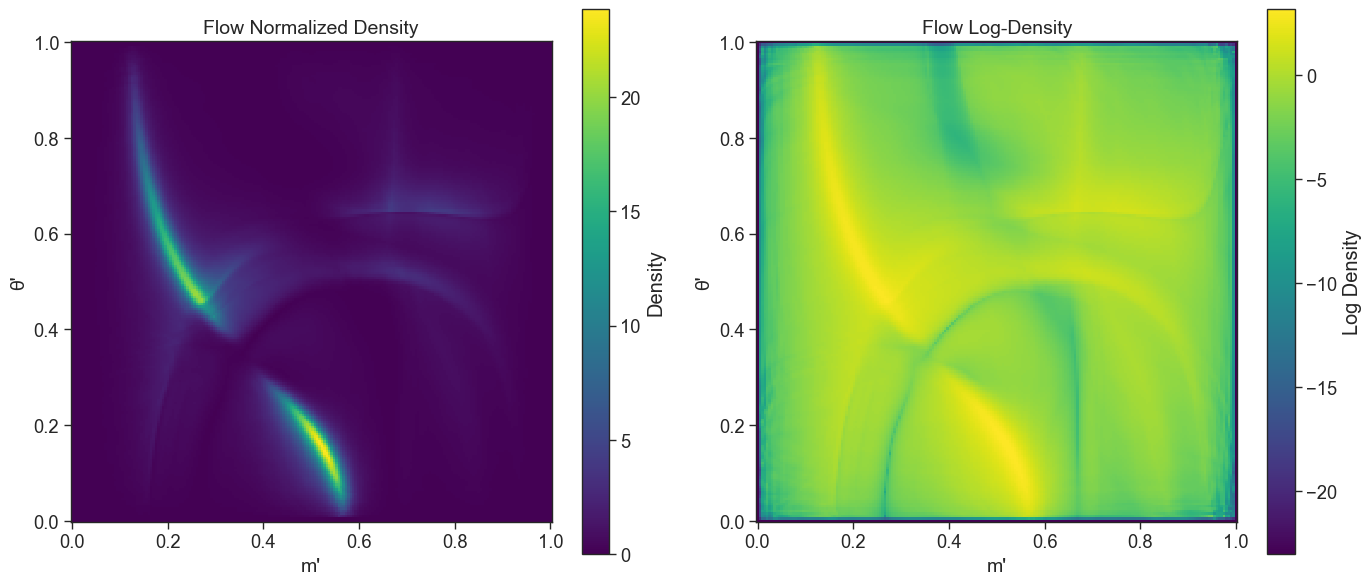


Density statistics:
  Min density: 0.000000e+00
  Max density: 2.386616e+01
  Mean density: 9.898767e-01
  Integral (approx): 0.989877

Plot saved to: flow_density_over_sdp.pdf


In [36]:
# Plot normalized density from the flow over the SDP

# Create model
flow = create_flow(
    num_flows=12,
    hidden_features=128,
    num_bins=24
)

flow.load_state_dict(torch.load('test_ensemble_2e6/trial_seed1.pth', map_location=device))
flow.eval()
flow.to(device)

# Create grid over [0,1]×[0,1]
U, V, pts = make_sdp_grid(nx=200, ny=200)

print("Computing density on grid...")
# Compute log probability on grid
with torch.no_grad():
    pts_tensor = torch.from_numpy(pts.astype(np.float32)).to(device)
    # Process in batches to avoid memory issues
    batch_size = 10000
    log_probs = []
    for i in range(0, len(pts_tensor), batch_size):
        batch = pts_tensor[i:i+batch_size]
        log_probs.append(flow.log_prob(batch).cpu().numpy())
    log_prob = np.concatenate(log_probs)

# Convert to probability density
density = np.exp(log_prob).reshape(U.shape)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Density heatmap
im1 = axes[0].pcolormesh(U, V, density, cmap='viridis', shading='auto')
axes[0].set_xlabel("m'", fontsize=14)
axes[0].set_ylabel("θ'", fontsize=14)
axes[0].set_title('Flow Normalized Density', fontsize=14)
axes[0].set_aspect('equal')
plt.colorbar(im1, ax=axes[0], label='Density')

# 2. Log density heatmap (better for seeing structure)
log_density = np.log(density + 1e-10)  # Add small constant to avoid log(0)
im2 = axes[1].pcolormesh(U, V, log_density, cmap='viridis', shading='auto')
axes[1].set_xlabel("m'", fontsize=14)
axes[1].set_ylabel("θ'", fontsize=14)
axes[1].set_title('Flow Log-Density', fontsize=14)
axes[1].set_aspect('equal')
plt.colorbar(im2, ax=axes[1], label='Log Density')

plt.tight_layout()
plt.savefig('flow_density_over_sdp.pdf', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nDensity statistics:")
print(f"  Min density: {density.min():.6e}")
print(f"  Max density: {density.max():.6e}")
print(f"  Mean density: {density.mean():.6e}")
print(f"  Integral (approx): {density.sum() / (U.shape[0] * U.shape[1]):.6f}")
print(f"\nPlot saved to: flow_density_over_sdp.pdf")

In [37]:
def compute_mag_exact(pts, sdp_obj, flow, dkpp_model, device=None):
    
    S = sdp_to_dp(pts, sdp_obj)
    s12, s13 = S[:,0], S[:,1] 

    # amplitudes
    A12  = dkpp_model.full(np.column_stack([s12, s13]))
    mag12 = np.abs(A12)

    # Jacobian 
    _, invJ = mag_AD_from_flow(pts, flow, sdp_obj, idx = (1,2,3), device=device)
    invJ = _finite_pos(invJ)

    mag_exact = mag12 **2 * invJ
    return mag_exact

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

def plot_C_comparison_mtheta(
    C_flow,
    C_exact,
    *,
    extent=(0, 1, 0, 1),
    cmap="RdBu_r",            # back to previous scheme
    percentile=98,
    flow_title=r"Normalizing-flow estimate: $\mathcal{C}_{\mathrm{flow}}(m',\theta')$",
    exact_title=r"Isobar-model prediction: $\mathcal{C}_{\mathrm{exact}}(m',\theta')$",
    xlabel=r"$m'$",
    ylabel=r"$\theta'$",
    figsize=(12, 4.8),
    dpi=200,
    savepath=None,
):
    """
    Side-by-side comparison of C(m', theta') from a normalizing flow vs exact isobar model.
    - Shared robust, symmetric color normalization (centered at 0)
    - No colorbar
    - y-axis label shown on BOTH panels
    """

    # Robust symmetric color scale shared across panels
    ref = np.concatenate([np.ravel(C_exact), np.ravel(C_flow)])
    ref = ref[np.isfinite(ref)]
    vmax = np.nanpercentile(np.abs(ref), percentile) if ref.size else 1.0
    norm = TwoSlopeNorm(vcenter=0.0, vmin=-vmax, vmax=vmax)

    fig, axs = plt.subplots(1, 2, figsize=figsize, constrained_layout=True, dpi=dpi)

    axs[0].imshow(
        C_flow, origin="lower", extent=extent, norm=norm, cmap=cmap,
        interpolation="nearest", aspect="equal"
    )
    axs[0].set_title(flow_title, pad=8)
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel(ylabel)

    axs[1].imshow(
        C_exact, origin="lower", extent=extent, norm=norm, cmap=cmap,
        interpolation="nearest", aspect="equal"
    )
    axs[1].set_title(exact_title, pad=8)
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel(ylabel)

    # Subpanel labels
    axs[0].text(0.02, 0.98, "(a)", transform=axs[0].transAxes, va="top", ha="left")
    axs[1].text(0.02, 0.98, "(b)", transform=axs[1].transAxes, va="top", ha="left")

    # Paper-style ticks/spines
    for ax in axs:
        ax.tick_params(direction="out", length=3, width=0.8)
        for spine in ax.spines.values():
            spine.set_linewidth(0.8)

    if savepath is not None:
        fig.savefig(savepath, bbox_inches="tight")
    return fig, axs


Comparing flow density with exact isobar model...
Computing flow density...


c:\Users\chinh\anaconda3\Lib\site-packages\nflows\transforms\coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


Computing exact isobar model density...


c:\Users\chinh\OneDrive\Documents\GitHub\Extraction-of-Gamma-with-Normalising-flows\Amplitude.py:487: RuntimeWarning: divide by zero encountered in scalar divide
  dmp_dsij = -(1.0 / np.pi) * (1.0 / np.sqrt(one_minus_x2)) * (1.0 / (denom_m * np.sqrt(mijSq)))
c:\Users\chinh\OneDrive\Documents\GitHub\Extraction-of-Gamma-with-Normalising-flows\Amplitude.py:426: RuntimeWarning: divide by zero encountered in scalar divide
  cosHel = -(mikSq - self.mSq[i] - self.mSq[k] - 2.0 * EiCmsij * EkCmsij) / (2.0 * self.qi * self.qk)



Density statistics:
  Flow  - Min: 0.000000e+00, Max: 2.386616e+01, Mean: 9.898767e-01
  Exact - Min: 2.721803e-12, Max: 1.801406e+04, Mean: 7.321109e+02


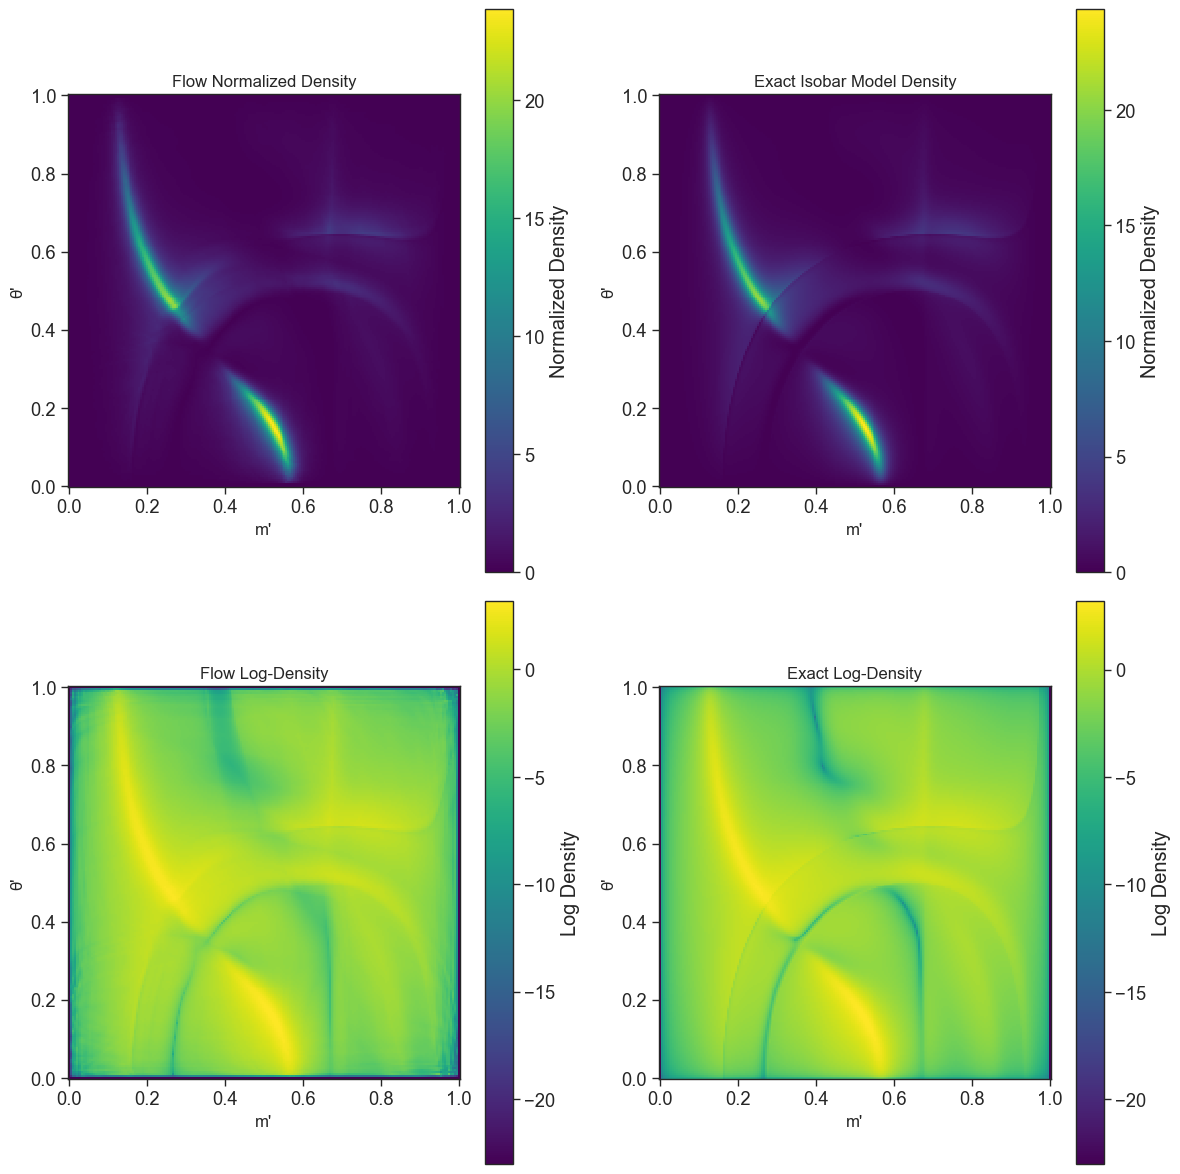


Comparison Metrics (normalized densities):
  MSE: 1.067989e-02
  MAE: 4.286731e-02
  Max absolute error: 2.230932e+00
  Correlation coefficient: 0.998969

Plot saved to: flow_vs_isobar_comparison.pdf


In [38]:
# Compare flow density with exact isobar model density
print("Comparing flow density with exact isobar model...")

# Initialize the isobar model
dkpp_model = DKpp()

# Create grid over [0,1]×[0,1] (reuse if already computed, or create new)
U, V, pts = make_sdp_grid(nx=200, ny=200)

# 1. Compute flow density (already done above, or recompute)
print("Computing flow density...")
flow.eval()
flow.to(device)

with torch.no_grad():
    pts_tensor = torch.from_numpy(pts.astype(np.float32)).to(device)
    batch_size = 10000
    log_probs = []
    for i in range(0, len(pts_tensor), batch_size):
        batch = pts_tensor[i:i+batch_size]
        log_probs.append(flow.log_prob(batch).cpu().numpy())
    log_prob_flow = np.concatenate(log_probs)

density_flow = np.exp(log_prob_flow).reshape(U.shape)

# 2. Compute exact density from isobar model
print("Computing exact isobar model density...")
density_exact = compute_mag_exact(pts, SDP, flow, dkpp_model, device=device).reshape(U.shape)

# Normalize both to have same integral (for fair comparison)
integral_exact = density_exact.sum()/ density_flow.sum()
density_flow_norm = density_flow 
density_exact_norm = density_exact / integral_exact

print(f"\nDensity statistics:")
print(f"  Flow  - Min: {density_flow.min():.6e}, Max: {density_flow.max():.6e}, Mean: {density_flow.mean():.6e}")
print(f"  Exact - Min: {density_exact.min():.6e}, Max: {density_exact.max():.6e}, Mean: {density_exact.mean():.6e}")

# 3. Plot comparison (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Row 1: Density comparisons
im0 = axes[0, 0].pcolormesh(U, V, density_flow_norm, cmap='viridis', shading='auto')
axes[0, 0].set_xlabel("m'", fontsize=12)
axes[0, 0].set_ylabel("θ'", fontsize=12)
axes[0, 0].set_title('Flow Normalized Density', fontsize=12)
axes[0, 0].set_aspect('equal')
plt.colorbar(im0, ax=axes[0, 0], label='Normalized Density')

im1 = axes[0, 1].pcolormesh(U, V, density_exact_norm, cmap='viridis', shading='auto')
axes[0, 1].set_xlabel("m'", fontsize=12)
axes[0, 1].set_ylabel("θ'", fontsize=12)
axes[0, 1].set_title('Exact Isobar Model Density', fontsize=12)
axes[0, 1].set_aspect('equal')
plt.colorbar(im1, ax=axes[0, 1], label='Normalized Density')

# Row 2: Log-scale comparisons
log_flow = np.log(density_flow_norm + 1e-10)
log_exact = np.log(density_exact_norm + 1e-10)

im3 = axes[1, 0].pcolormesh(U, V, log_flow, cmap='viridis', shading='auto')
axes[1, 0].set_xlabel("m'", fontsize=12)
axes[1, 0].set_ylabel("θ'", fontsize=12)
axes[1, 0].set_title('Flow Log-Density', fontsize=12)
axes[1, 0].set_aspect('equal')
plt.colorbar(im3, ax=axes[1, 0], label='Log Density')

im4 = axes[1, 1].pcolormesh(U, V, log_exact, cmap='viridis', shading='auto')
axes[1, 1].set_xlabel("m'", fontsize=12)
axes[1, 1].set_ylabel("θ'", fontsize=12)
axes[1, 1].set_title('Exact Log-Density', fontsize=12)
axes[1, 1].set_aspect('equal')
plt.colorbar(im4, ax=axes[1, 1], label='Log Density')

plt.tight_layout()
plt.savefig('flow_vs_isobar_comparison.pdf', dpi=150, bbox_inches='tight')
plt.show()

# 4. Compute and print comparison metrics
mse = np.mean((density_flow_norm - density_exact_norm)**2)
mae = np.mean(np.abs(density_flow_norm - density_exact_norm))
max_abs_error = np.max(np.abs(density_flow_norm - density_exact_norm))
correlation = np.corrcoef(density_flow_norm.ravel(), density_exact_norm.ravel())[0, 1]

print(f"\nComparison Metrics (normalized densities):")
print(f"  MSE: {mse:.6e}")
print(f"  MAE: {mae:.6e}")
print(f"  Max absolute error: {max_abs_error:.6e}")
print(f"  Correlation coefficient: {correlation:.6f}")
print(f"\nPlot saved to: flow_vs_isobar_comparison.pdf")

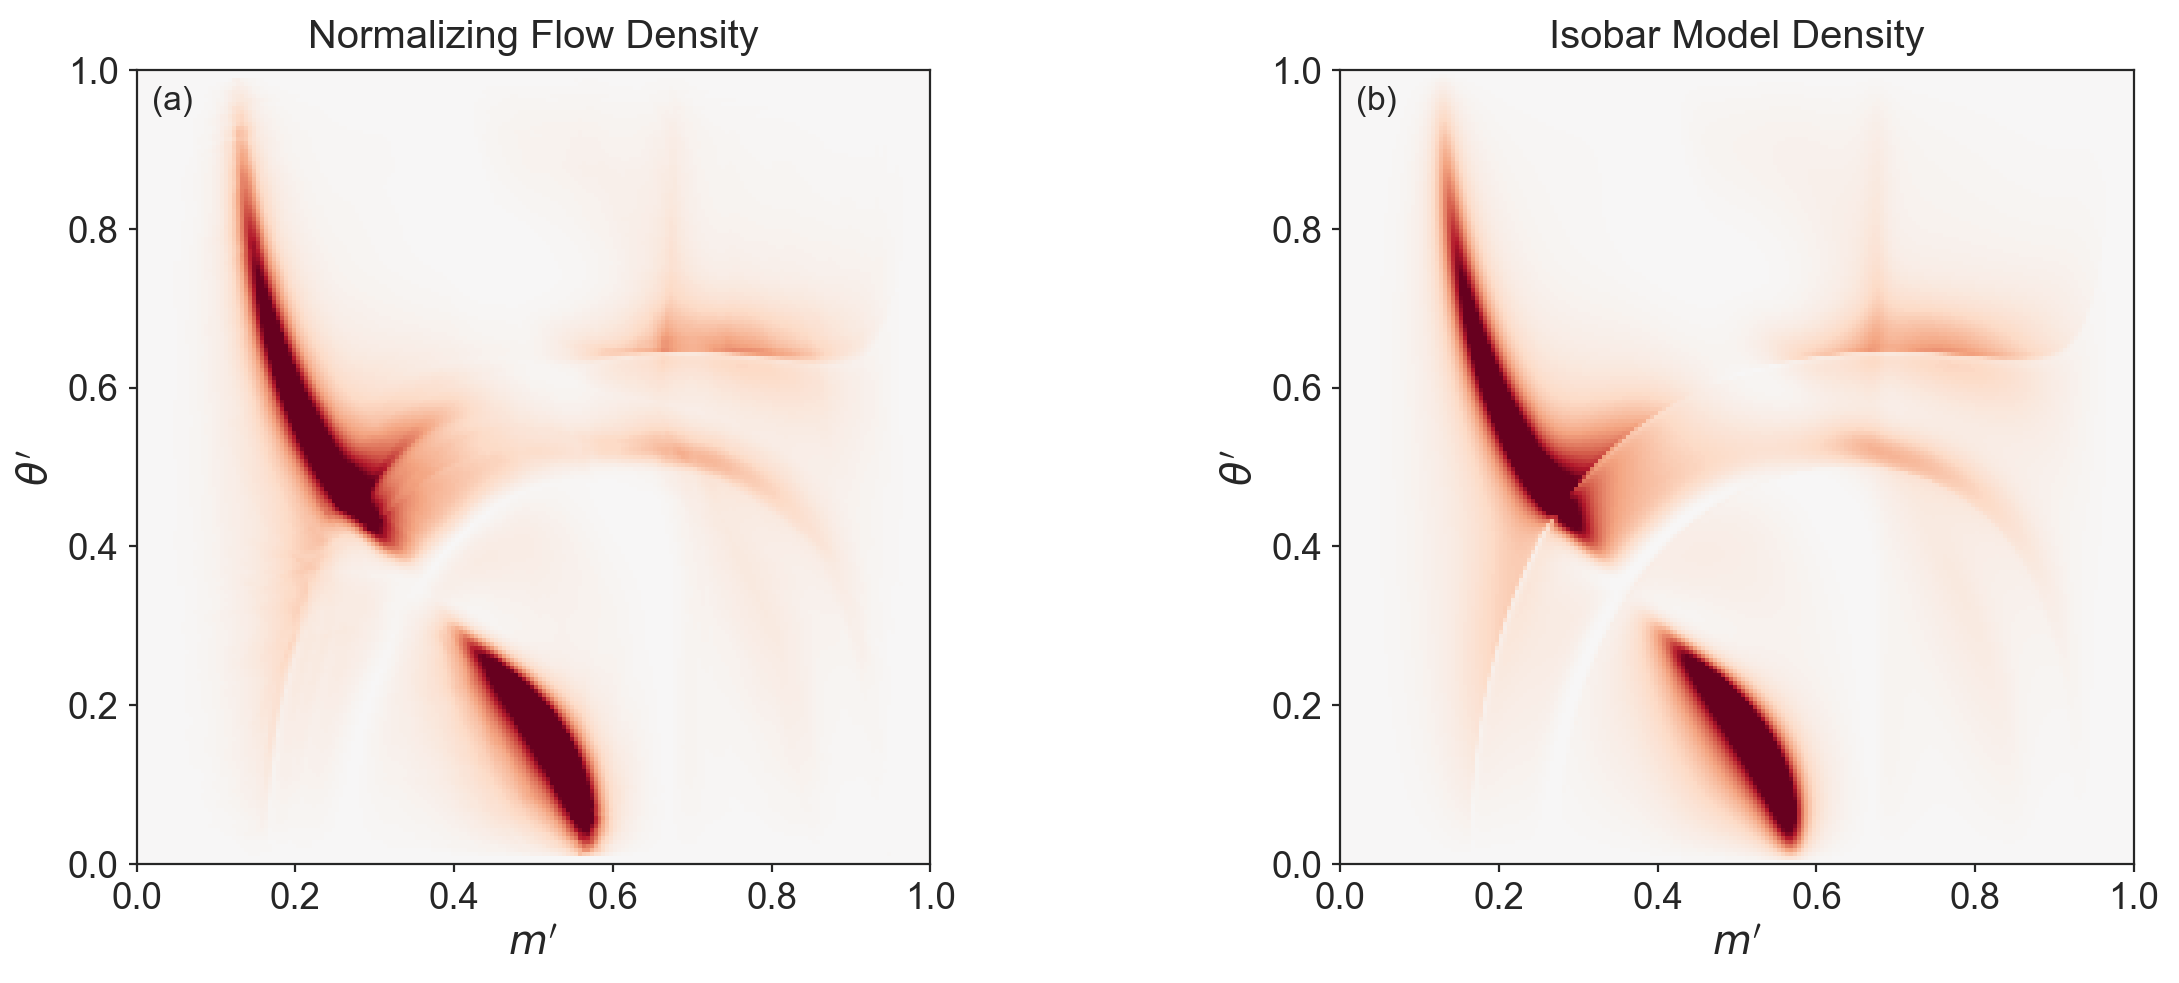

Publication-ready comparison saved to: C_comparison_mtheta.pdf


In [41]:
# Alternative visualization using the specialized plot_C_comparison_mtheta function

# Use the specialized comparison plotting function
fig, axs = plot_C_comparison_mtheta(
    C_flow=density_flow_norm,
    C_exact=density_exact_norm,
    extent=(0, 1, 0, 1),
    cmap="RdBu_r",
    percentile=98,
    flow_title=r"Normalizing Flow Density",
    exact_title=r"Isobar Model Density",
    xlabel=r"$m'$",
    ylabel=r"$\theta'$",
    figsize=(12, 4.8),
    dpi=200,
    savepath='C_comparison_mtheta.pdf'
)

plt.show()
print("Publication-ready comparison saved to: C_comparison_mtheta.pdf")

In [42]:
def make_sdp_grid_1d_slice(fixed_dim='m', fixed_value=0.5, n_points=200):
    """
    Create a 1D slice of the SDP grid with one dimension fixed.
    
    Parameters
    ----------
    fixed_dim : str
        Which dimension to fix: 'm' for m' or 'theta' for θ'
    fixed_value : float
        Value to fix the dimension at
    n_points : int
        Number of points along the varying dimension
    
    Returns
    -------
    varying_values : ndarray, shape (n_points,)
        Values along the varying dimension
    pts : ndarray, shape (n_points, 2)
        Points as (m', θ') pairs
    """
    if fixed_dim == 'm':
        # Fix m', vary θ'
        varying_values = np.linspace(0, 1, n_points)
        pts = np.column_stack([
            np.full(n_points, fixed_value),  # Fixed m'
            varying_values                    # Varying θ'
        ])
        return varying_values, pts
    elif fixed_dim == 'theta':
        # Fix θ', vary m'
        varying_values = np.linspace(0, 1, n_points)
        pts = np.column_stack([
            varying_values,                   # Varying m'
            np.full(n_points, fixed_value)   # Fixed θ'
        ])
        return varying_values, pts
    else:
        raise ValueError("fixed_dim must be 'm' or 'theta'")


def plot_density_slice_comparison(fixed_dim='m', fixed_value=0.5, n_points=200,
                                  flow_model=None, SDP_model=None, dkpp_model=None,
                                  device='cpu', savepath=None):
    """
    Compare flow density with exact isobar model density along a 1D slice.
    
    Parameters
    ----------
    fixed_dim : str
        Which dimension to fix: 'm' for m' or 'theta' for θ'
    fixed_value : float
        Value to fix the dimension at
    n_points : int
        Number of points along the varying dimension
    flow_model : torch model
        Trained flow model
    SDP_model : torch model
        SDP model for exact density computation
    dkpp_model : DKpp instance
        D→Kππ amplitude model
    device : str
        Device for computation
    savepath : str, optional
        Path to save the figure
    
    Returns
    -------
    varying_values : ndarray
        Values along the varying dimension
    density_exact_norm : ndarray
        Normalized exact density
    density_flow_norm : ndarray
        Normalized flow density
    """
    # Determine labels based on fixed dimension
    if fixed_dim == 'm':
        varying_label = "θ'"
        fixed_label = "m'"
    elif fixed_dim == 'theta':
        varying_label = "m'"
        fixed_label = "θ'"
    else:
        raise ValueError("fixed_dim must be 'm' or 'theta'")
    
    print(f"Comparing flow density with exact isobar model at fixed {fixed_label} = {fixed_value:.4f}...")
    
    # Create 1D grid
    varying_values, pts = make_sdp_grid_1d_slice(fixed_dim=fixed_dim, 
                                                  fixed_value=fixed_value, 
                                                  n_points=n_points)
    
    # 1. Compute flow density
    print(f"Computing flow density...")
    flow_model.eval()
    flow_model.to(device)
    
    with torch.no_grad():
        pts_tensor = torch.from_numpy(pts.astype(np.float32)).to(device)
        batch_size = 10000
        log_probs = []
        for i in range(0, len(pts_tensor), batch_size):
            batch = pts_tensor[i:i+batch_size]
            log_probs.append(flow_model.log_prob(batch).cpu().numpy())
        log_prob_flow = np.concatenate(log_probs)
    
    density_flow = np.exp(log_prob_flow)  # 1D array
    
    # 2. Compute exact density from isobar model
    print("Computing exact isobar model density...")
    density_exact = compute_mag_exact(pts, SDP_model, flow_model, dkpp_model, device=device)
    
    # Convert to numpy if tensor
    if torch.is_tensor(density_exact):
        density_exact = density_exact.cpu().numpy()
    
    density_exact = density_exact.flatten()  # Ensure 1D
    
    # Normalize both
    integral_exact = density_exact.sum()
    density_flow_norm = density_flow / density_flow.sum()
    density_exact_norm = density_exact / integral_exact
    
    print(f"\nDensity statistics:")
    print(f"  Flow  - Min: {density_flow.min():.6e}, Max: {density_flow.max():.6e}, Mean: {density_flow.mean():.6e}")
    print(f"  Exact - Min: {density_exact.min():.6e}, Max: {density_exact.max():.6e}, Mean: {density_exact.mean():.6e}")
    
    # 3. Plot comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(varying_values, density_exact_norm, 'b-', linewidth=2.5, 
            label='Exact (Isobar)', marker='o', markersize=3)
    ax.plot(varying_values, density_flow_norm, 'r--', linewidth=2.5, 
            label='Flow', marker='s', markersize=3)
    ax.set_xlabel(varying_label, fontsize=14)
    ax.set_ylabel('Normalized Density', fontsize=14)
    ax.set_title(f"Density vs {varying_label} at {fixed_label} = {fixed_value:.4f}", 
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=12, loc='best')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    # Generate default savepath if not provided
    if savepath is None:
        savepath = f'flow_vs_isobar_1d_slice_{fixed_dim}{fixed_value:.2f}.pdf'
    
    plt.savefig(savepath, dpi=150, bbox_inches='tight')
    plt.show()
    
    # 4. Compute and print comparison metrics
    mse = np.mean((density_flow_norm - density_exact_norm)**2)
    mae = np.mean(np.abs(density_flow_norm - density_exact_norm))
    max_abs_error = np.max(np.abs(density_flow_norm - density_exact_norm))
    correlation = np.corrcoef(density_flow_norm, density_exact_norm)[0, 1]
    
    print(f"\nComparison Metrics (normalized densities):")
    print(f"  MSE: {mse:.6e}")
    print(f"  MAE: {mae:.6e}")
    print(f"  Max absolute error: {max_abs_error:.6e}")
    print(f"  Correlation coefficient: {correlation:.6f}")
    print(f"\nPlot saved to: {savepath}")
    
    return varying_values, density_exact_norm, density_flow_norm



Comparing flow density with exact isobar model at fixed m' = 0.5000...
Computing flow density...
Computing exact isobar model density...

Density statistics:
  Flow  - Min: 1.895677e-41, Max: 2.224463e+01, Mean: 2.106565e+00
  Exact - Min: 2.396805e+00, Max: 1.651551e+04, Mean: 1.523762e+03


c:\Users\chinh\anaconda3\Lib\site-packages\nflows\transforms\coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


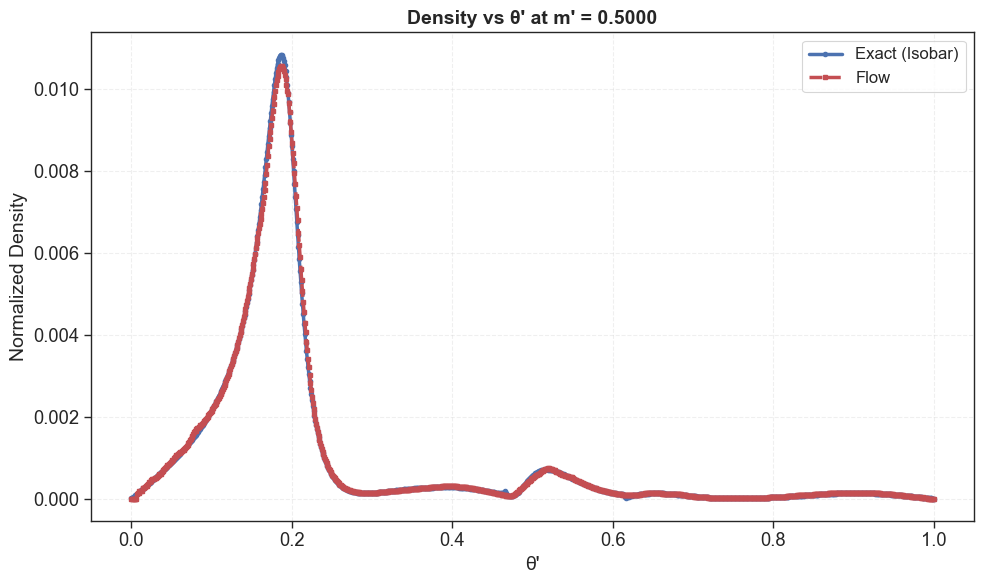


Comparison Metrics (normalized densities):
  MSE: 5.070800e-09
  MAE: 2.905998e-05
  Max absolute error: 3.918847e-04
  Correlation coefficient: 0.999506

Plot saved to: flow_vs_isobar_1d_slice_m0.50.pdf
Comparing flow density with exact isobar model at fixed θ' = 0.5000...
Computing flow density...
Computing exact isobar model density...

Density statistics:
  Flow  - Min: 5.338947e-43, Max: 1.907006e+01, Mean: 2.316871e+00
  Exact - Min: 2.721803e-12, Max: 1.470571e+04, Mean: 1.736948e+03


c:\Users\chinh\anaconda3\Lib\site-packages\nflows\transforms\coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(
c:\Users\chinh\OneDrive\Documents\GitHub\Extraction-of-Gamma-with-Normalising-flows\Amplitude.py:487: RuntimeWarning: divide by zero encountered in scalar divide
  dmp_dsij = -(1.0 / np.pi) * (1.0 / np.sqrt(one_minus_x2)) * (1.0 / (denom_m * np.sqrt(mijSq)))
c:\Users\chinh\OneDrive\Documents\GitHub\Extraction-of-Gamma-with-Normalising-flows\Amplitude.py:426: RuntimeWarning: divide by zero encountered in scalar divide
  cosHel = -(mikSq - self.mSq[i] - self.mSq[k] - 2.0 * EiCmsij * EkCmsij) / (2.0 * self.qi * self.qk)


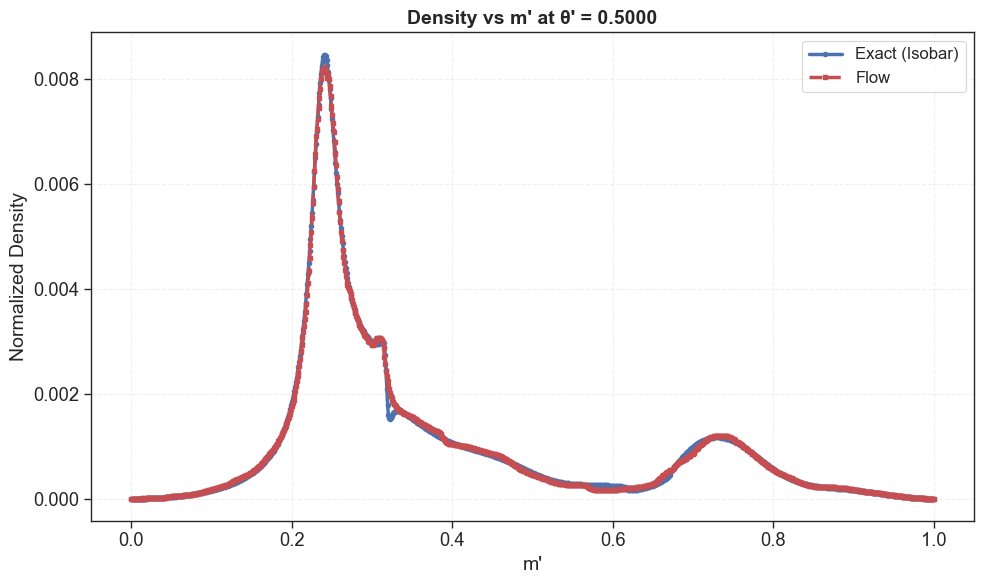


Comparison Metrics (normalized densities):
  MSE: 4.104244e-09
  MAE: 3.655795e-05
  Max absolute error: 5.544434e-04
  Correlation coefficient: 0.999113

Plot saved to: flow_vs_isobar_1d_slice_theta0.50.pdf


(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [43]:
# Example usage:

# Plot density vs θ' at fixed m' = 0.5
plot_density_slice_comparison(
    fixed_dim='m', 
    fixed_value=0.5, 
    n_points=1000,
    flow_model=flow, 
    SDP_model=SDP, 
    dkpp_model=dkpp_model,
    device=device
)

# Plot density vs m' at fixed θ' = 0.3
plot_density_slice_comparison(
    fixed_dim='theta', 
    fixed_value=0.5, 
    n_points=1000,
    flow_model=flow, 
    SDP_model=SDP, 
    dkpp_model=dkpp_model,
    device=device
)


In [44]:
# ============================================================================
# COMBINED MULTI-ENSEMBLE PULL MAP ANALYSIS
# ============================================================================
# This cell combines models from multiple ensemble directories into one
# larger ensemble for analysis. Easily reusable for any combination.

def load_combined_ensemble_densities(ensemble_dirs, pts, grid_shape, num_flows=16, 
                                     hidden_features=128, num_bins=16, device='cpu'):
    """
    Load and combine models from multiple ensemble directories into one ensemble.
    
    Parameters
    ----------
    ensemble_dirs : str or list of str
        Single ensemble directory or list of ensemble directories to combine
        Examples: "test_ensemble" or ["test_ensemble", "test_ensemble2_odd"]
    pts : ndarray, shape (N, 2)
        Grid points in SDP coordinates
    grid_shape : tuple
        Shape of grid (ny, nx) for reshaping
    num_flows, hidden_features, num_bins : int
        Flow architecture parameters
    device : str
        Device for computation
    
    Returns
    -------
    ensemble_densities : ndarray, shape (total_models, ny, nx)
        Combined normalized densities from all models in all ensembles
    total_models : int
        Total number of models loaded
    ensemble_info : dict
        Information about which models came from which ensemble
    """
    from pathlib import Path
    import glob
    
    # Make ensemble_dirs a list if it's a single string
    if isinstance(ensemble_dirs, str):
        ensemble_dirs = [ensemble_dirs]
    
    print(f"Combining models from {len(ensemble_dirs)} ensemble(s): {ensemble_dirs}")
    
    all_densities = []
    ensemble_info = {'ensemble_dirs': ensemble_dirs, 'models_per_ensemble': []}
    
    for ens_idx, ensemble_dir in enumerate(ensemble_dirs, 1):
        print(f"\n  Loading from {ensemble_dir}...")
        
        # Find all model files in this ensemble
        model_files = sorted(glob.glob(f"{ensemble_dir}/trial_seed*.pth"))
        model_files = [f for f in model_files if not f.endswith('_best.pth')]
        num_models_this_ensemble = len(model_files)
        
        if num_models_this_ensemble == 0:
            print(f"    WARNING: No models found in {ensemble_dir}, skipping")
            continue
        
        print(f"    Found {num_models_this_ensemble} models")
        ensemble_info['models_per_ensemble'].append({
            'dir': ensemble_dir,
            'num_models': num_models_this_ensemble
        })
        
        for model_idx, model_path in enumerate(model_files, 1):
            print(f"      Processing model {model_idx}/{num_models_this_ensemble}...")
            
            # Load model
            model_flow = create_flow(num_flows=num_flows, hidden_features=hidden_features, 
                                     num_bins=num_bins)
            model_flow.load_state_dict(torch.load(model_path, map_location=device))
            model_flow.eval()
            model_flow.to(device)
            
            # Compute density
            with torch.no_grad():
                pts_tensor = torch.from_numpy(pts.astype(np.float32)).to(device)
                batch_size = 10000
                log_probs = []
                for i in range(0, len(pts_tensor), batch_size):
                    batch = pts_tensor[i:i+batch_size]
                    log_probs.append(model_flow.log_prob(batch).cpu().numpy())
                log_prob = np.concatenate(log_probs)
            
            density = np.exp(log_prob).reshape(grid_shape)
            density_norm = density / density.sum()  # Normalize
            all_densities.append(density_norm)
    
    if len(all_densities) == 0:
        raise ValueError("No models loaded from any ensemble!")
    
    total_models = len(all_densities)
    print(f"\n  Total models combined: {total_models}")
    
    return np.array(all_densities), total_models, ensemble_info

Comparing ensemble flow density with exact isobar model at fixed m' = 0.5000...
Loading ensemble densities...
Combining models from 1 ensemble(s): ['test_ensemble_2e6']

  Loading from test_ensemble_2e6...
    Found 25 models
      Processing model 1/25...
      Processing model 2/25...
      Processing model 3/25...


c:\Users\chinh\anaconda3\Lib\site-packages\nflows\transforms\coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


      Processing model 4/25...
      Processing model 5/25...
      Processing model 6/25...
      Processing model 7/25...
      Processing model 8/25...
      Processing model 9/25...
      Processing model 10/25...
      Processing model 11/25...
      Processing model 12/25...
      Processing model 13/25...
      Processing model 14/25...
      Processing model 15/25...
      Processing model 16/25...
      Processing model 17/25...
      Processing model 18/25...
      Processing model 19/25...
      Processing model 20/25...
      Processing model 21/25...
      Processing model 22/25...
      Processing model 23/25...
      Processing model 24/25...
      Processing model 25/25...

  Total models combined: 25
Computing exact isobar model density...

Density statistics:
  Ensemble Mean - Min: 6.722673e-40, Max: 5.414370e-02
  Ensemble Std  - Min: 0.000000e+00, Max: 1.396829e-03
  Exact         - Min: 7.896585e-06, Max: 5.438991e-02


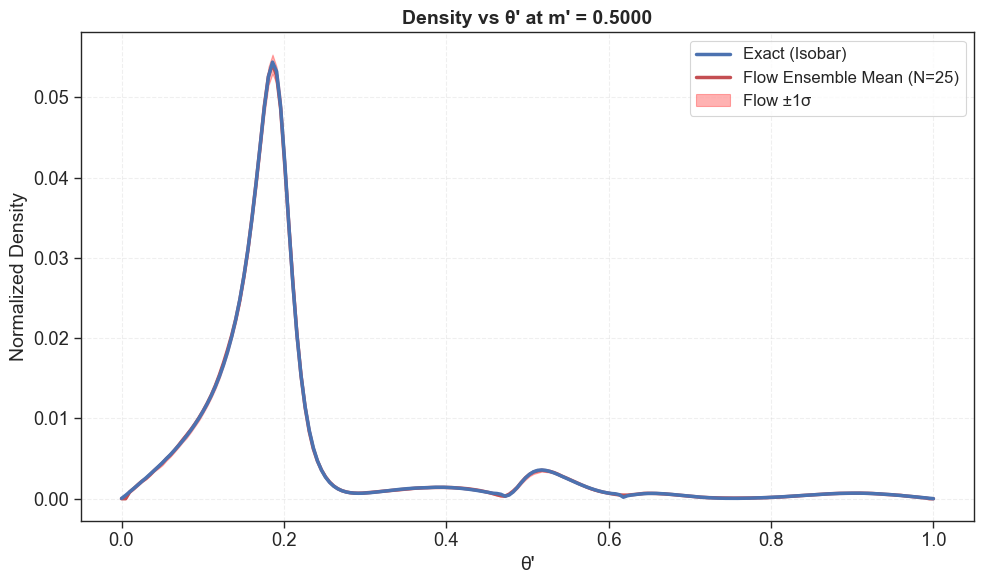


Comparison Metrics (normalized densities):
  MSE: 7.090545e-09
  MAE: 4.343426e-05
  Max absolute error: 5.107226e-04
  Correlation coefficient: 0.999970
  Coverage (exact within ±1σ): 89.5% (Expected: ~68%)

Plot saved to: ensemble_vs_isobar_1d_slice_m0.50.pdf
Comparing ensemble flow density with exact isobar model at fixed θ' = 0.3000...
Loading ensemble densities...
Combining models from 1 ensemble(s): ['test_ensemble_2e6']

  Loading from test_ensemble_2e6...
    Found 25 models
      Processing model 1/25...
      Processing model 2/25...
      Processing model 3/25...
      Processing model 4/25...


c:\Users\chinh\anaconda3\Lib\site-packages\nflows\transforms\coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


      Processing model 5/25...
      Processing model 6/25...
      Processing model 7/25...
      Processing model 8/25...
      Processing model 9/25...
      Processing model 10/25...
      Processing model 11/25...
      Processing model 12/25...
      Processing model 13/25...
      Processing model 14/25...
      Processing model 15/25...
      Processing model 16/25...
      Processing model 17/25...
      Processing model 18/25...
      Processing model 19/25...
      Processing model 20/25...
      Processing model 21/25...
      Processing model 22/25...
      Processing model 23/25...
      Processing model 24/25...
      Processing model 25/25...

  Total models combined: 25
Computing exact isobar model density...

Density statistics:
  Ensemble Mean - Min: 8.529690e-40, Max: 2.626099e-02
  Ensemble Std  - Min: 0.000000e+00, Max: 2.283917e-03
  Exact         - Min: 3.640702e-17, Max: 2.578006e-02


c:\Users\chinh\OneDrive\Documents\GitHub\Extraction-of-Gamma-with-Normalising-flows\Amplitude.py:487: RuntimeWarning: divide by zero encountered in scalar divide
  dmp_dsij = -(1.0 / np.pi) * (1.0 / np.sqrt(one_minus_x2)) * (1.0 / (denom_m * np.sqrt(mijSq)))
c:\Users\chinh\OneDrive\Documents\GitHub\Extraction-of-Gamma-with-Normalising-flows\Amplitude.py:426: RuntimeWarning: divide by zero encountered in scalar divide
  cosHel = -(mikSq - self.mSq[i] - self.mSq[k] - 2.0 * EiCmsij * EkCmsij) / (2.0 * self.qi * self.qk)


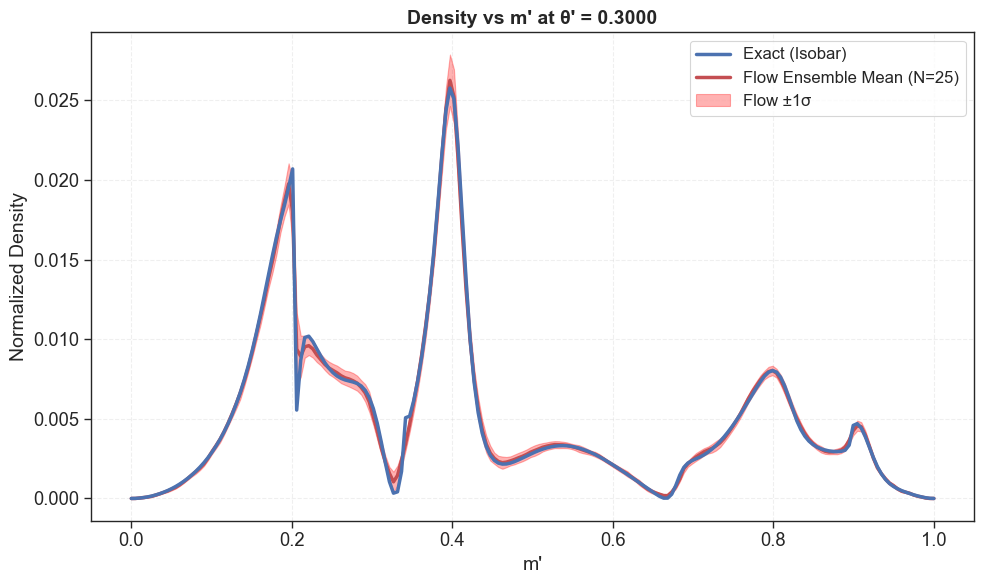


Comparison Metrics (normalized densities):
  MSE: 1.668310e-07
  MAE: 1.680347e-04
  Max absolute error: 3.828847e-03
  Correlation coefficient: 0.996925
  Coverage (exact within ±1σ): 90.0% (Expected: ~68%)

Plot saved to: ensemble_vs_isobar_1d_slice_theta0.30.pdf


(array([0.        , 0.00502513, 0.01005025, 0.01507538, 0.0201005 ,
        0.02512563, 0.03015075, 0.03517588, 0.04020101, 0.04522613,
        0.05025126, 0.05527638, 0.06030151, 0.06532663, 0.07035176,
        0.07537688, 0.08040201, 0.08542714, 0.09045226, 0.09547739,
        0.10050251, 0.10552764, 0.11055276, 0.11557789, 0.12060302,
        0.12562814, 0.13065327, 0.13567839, 0.14070352, 0.14572864,
        0.15075377, 0.15577889, 0.16080402, 0.16582915, 0.17085427,
        0.1758794 , 0.18090452, 0.18592965, 0.19095477, 0.1959799 ,
        0.20100503, 0.20603015, 0.21105528, 0.2160804 , 0.22110553,
        0.22613065, 0.23115578, 0.2361809 , 0.24120603, 0.24623116,
        0.25125628, 0.25628141, 0.26130653, 0.26633166, 0.27135678,
        0.27638191, 0.28140704, 0.28643216, 0.29145729, 0.29648241,
        0.30150754, 0.30653266, 0.31155779, 0.31658291, 0.32160804,
        0.32663317, 0.33165829, 0.33668342, 0.34170854, 0.34673367,
        0.35175879, 0.35678392, 0.36180905, 0.36

In [47]:
def plot_density_slice_ensemble_comparison(fixed_dim='m', fixed_value=0.5, n_points=200,
                                          ensemble_dirs='test_ensemble2',
                                          num_flows=16, hidden_features=128, num_bins=16,
                                          SDP_model=None, dkpp_model=None,
                                          device='cpu', savepath=None):
    """
    Compare ensemble flow density (mean ± std) with exact isobar model density along a 1D slice.
    
    Parameters
    ----------
    fixed_dim : str
        Which dimension to fix: 'm' for m' or 'theta' for θ'
    fixed_value : float
        Value to fix the dimension at
    n_points : int
        Number of points along the varying dimension
    ensemble_dirs : str or list of str
        Ensemble directory/directories to load models from
    num_flows, hidden_features, num_bins : int
        Flow architecture parameters
    SDP_model : torch model
        SDP model for exact density computation
    dkpp_model : DKpp instance
        D→Kππ amplitude model
    device : str
        Device for computation
    savepath : str, optional
        Path to save the figure
    
    Returns
    -------
    varying_values : ndarray
        Values along the varying dimension
    density_exact_norm : ndarray
        Normalized exact density
    ensemble_mean : ndarray
        Mean of normalized ensemble densities
    ensemble_std : ndarray
        Std of normalized ensemble densities
    """
    # Determine labels based on fixed dimension
    if fixed_dim == 'm':
        varying_label = "θ'"
        fixed_label = "m'"
    elif fixed_dim == 'theta':
        varying_label = "m'"
        fixed_label = "θ'"
    else:
        raise ValueError("fixed_dim must be 'm' or 'theta'")
    
    print(f"Comparing ensemble flow density with exact isobar model at fixed {fixed_label} = {fixed_value:.4f}...")
    
    # Create 1D grid
    varying_values, pts = make_sdp_grid_1d_slice(fixed_dim=fixed_dim, 
                                                  fixed_value=fixed_value, 
                                                  n_points=n_points)
    
    # Grid shape for 1D slice
    grid_shape = (n_points,)
    
    # Load ensemble and compute densities
    print(f"Loading ensemble densities...")
    ensemble_densities, total_models, ensemble_info = load_combined_ensemble_densities(
        ensemble_dirs=ensemble_dirs,
        pts=pts,
        grid_shape=grid_shape,
        num_flows=num_flows,
        hidden_features=hidden_features,
        num_bins=num_bins,
        device=device
    )
    
    # Compute ensemble statistics
    # ensemble_densities shape: (total_models, n_points)
    ensemble_mean = np.mean(ensemble_densities, axis=0)
    ensemble_std = np.std(ensemble_densities, axis=0)
    
    # Compute exact density from isobar model
    print("Computing exact isobar model density...")
    
    # Load a flow model for compute_mag_exact (use first from ensemble or create dummy)
    flow_dummy = create_flow(num_flows=num_flows, hidden_features=hidden_features, num_bins=num_bins)
    flow_dummy.eval()
    flow_dummy.to(device)
    
    density_exact = compute_mag_exact(pts, SDP_model, flow_dummy, dkpp_model, device=device)
    
    # Convert to numpy if tensor
    if torch.is_tensor(density_exact):
        density_exact = density_exact.cpu().numpy()
    
    density_exact = density_exact.flatten()  # Ensure 1D
    
    # Normalize exact density
    density_exact_norm = density_exact / density_exact.sum()
    
    print(f"\nDensity statistics:")
    print(f"  Ensemble Mean - Min: {ensemble_mean.min():.6e}, Max: {ensemble_mean.max():.6e}")
    print(f"  Ensemble Std  - Min: {ensemble_std.min():.6e}, Max: {ensemble_std.max():.6e}")
    print(f"  Exact         - Min: {density_exact_norm.min():.6e}, Max: {density_exact_norm.max():.6e}")
    
    # Plot comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot exact density
    ax.plot(varying_values, density_exact_norm, 'b-', linewidth=2.5, 
            label='Exact (Isobar)', zorder=3)
    
    # Plot ensemble mean
    ax.plot(varying_values, ensemble_mean, 'r-', linewidth=2.5, 
            label=f'Flow Ensemble Mean (N={total_models})', zorder=2)
    
    # Plot ±1σ band
    ax.fill_between(varying_values, 
                     ensemble_mean - ensemble_std, 
                     ensemble_mean + ensemble_std,
                     color='red', alpha=0.3, label='Flow ±1σ', zorder=1)
    
    ax.set_xlabel(varying_label, fontsize=14)
    ax.set_ylabel('Normalized Density', fontsize=14)
    ax.set_title(f"Density vs {varying_label} at {fixed_label} = {fixed_value:.4f}", 
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=12, loc='best')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    # Generate default savepath if not provided
    if savepath is None:
        savepath = f'ensemble_vs_isobar_1d_slice_{fixed_dim}{fixed_value:.2f}.pdf'
    
    plt.savefig(savepath, dpi=150, bbox_inches='tight')
    plt.show()
    
    # Compute and print comparison metrics
    mse = np.mean((ensemble_mean - density_exact_norm)**2)
    mae = np.mean(np.abs(ensemble_mean - density_exact_norm))
    max_abs_error = np.max(np.abs(ensemble_mean - density_exact_norm))
    correlation = np.corrcoef(ensemble_mean, density_exact_norm)[0, 1]
    
    # Check coverage (how often exact falls within ±1σ)
    within_band = np.abs(density_exact_norm - ensemble_mean) <= ensemble_std
    coverage = np.mean(within_band)
    
    print(f"\nComparison Metrics (normalized densities):")
    print(f"  MSE: {mse:.6e}")
    print(f"  MAE: {mae:.6e}")
    print(f"  Max absolute error: {max_abs_error:.6e}")
    print(f"  Correlation coefficient: {correlation:.6f}")
    print(f"  Coverage (exact within ±1σ): {coverage:.1%} (Expected: ~68%)")
    print(f"\nPlot saved to: {savepath}")
    
    return varying_values, density_exact_norm, ensemble_mean, ensemble_std


# Example usage:

# Plot density vs θ' at fixed m' = 0.5 with ensemble
plot_density_slice_ensemble_comparison(
    fixed_dim='m', 
    fixed_value=0.5, 
    n_points=200,
    ensemble_dirs='test_ensemble_2e6',  # or ['test_ensemble', 'test_ensemble2']
    num_flows=12,
    hidden_features=128,
    num_bins=24,
    SDP_model=SDP, 
    dkpp_model=dkpp_model,
    device=device
)

# Plot density vs m' at fixed θ' = 0.3 with ensemble
plot_density_slice_ensemble_comparison(
    fixed_dim='theta', 
    fixed_value=0.3, 
    n_points=200,
    ensemble_dirs='test_ensemble_2e6',
    num_flows=12,
    hidden_features=128,
    num_bins=24,
    SDP_model=SDP, 
    dkpp_model=dkpp_model,
    device=device
)

Comparing ensemble flow density with exact isobar model at fixed m' = 0.5000...
Loading ensemble densities...
Combining models from 1 ensemble(s): ['test_ensemble_2e6']

  Loading from test_ensemble_2e6...
    Found 25 models
      Processing model 1/25...
      Processing model 2/25...
      Processing model 3/25...


c:\Users\chinh\anaconda3\Lib\site-packages\nflows\transforms\coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


      Processing model 4/25...
      Processing model 5/25...
      Processing model 6/25...
      Processing model 7/25...
      Processing model 8/25...
      Processing model 9/25...
      Processing model 10/25...
      Processing model 11/25...
      Processing model 12/25...
      Processing model 13/25...
      Processing model 14/25...
      Processing model 15/25...
      Processing model 16/25...
      Processing model 17/25...
      Processing model 18/25...
      Processing model 19/25...
      Processing model 20/25...
      Processing model 21/25...
      Processing model 22/25...
      Processing model 23/25...
      Processing model 24/25...
      Processing model 25/25...

  Total models combined: 25
Computing exact isobar model density...

Density statistics:
  Ensemble Mean - Min: 6.722673e-40, Max: 5.414370e-02
  Ensemble 16%  - Min: 2.522337e-44, Max: 5.272594e-02
  Ensemble 84%  - Min: 7.153068e-40, Max: 5.535507e-02
  Exact         - Min: 7.896585e-06, Max: 5.438

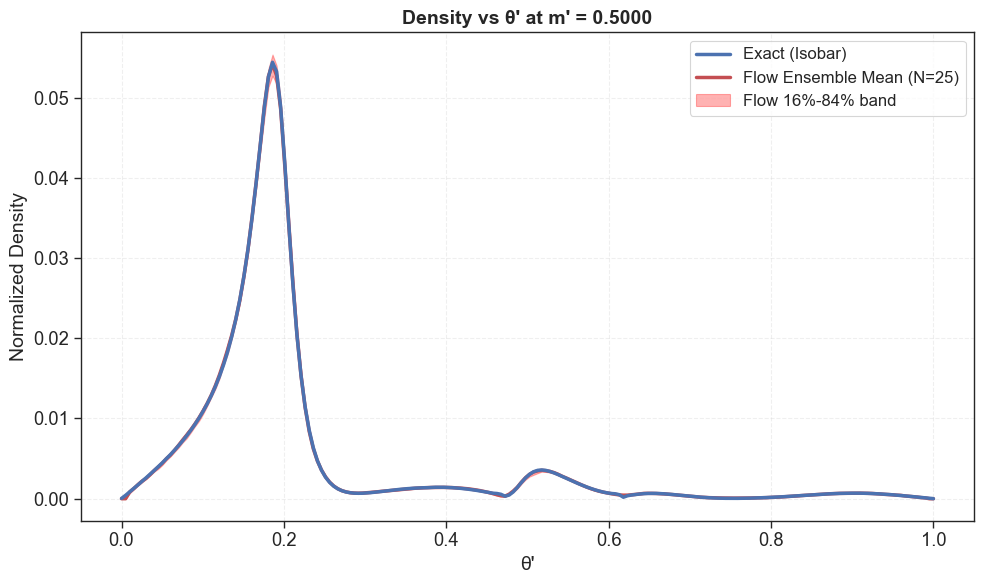


Comparison Metrics (normalized densities):
  MSE: 7.090545e-09
  MAE: 4.343426e-05
  Max absolute error: 5.107226e-04
  Correlation coefficient: 0.999970
  Coverage (exact within 16%-84% band): 89.5% (Expected: ~68%)

Plot saved to: ensemble_vs_isobar_1d_slice_m0.50.pdf
Comparing ensemble flow density with exact isobar model at fixed θ' = 0.3000...
Loading ensemble densities...
Combining models from 1 ensemble(s): ['test_ensemble_2e6']

  Loading from test_ensemble_2e6...
    Found 25 models
      Processing model 1/25...
      Processing model 2/25...
      Processing model 3/25...
      Processing model 4/25...


c:\Users\chinh\anaconda3\Lib\site-packages\nflows\transforms\coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


      Processing model 5/25...
      Processing model 6/25...
      Processing model 7/25...
      Processing model 8/25...
      Processing model 9/25...
      Processing model 10/25...
      Processing model 11/25...
      Processing model 12/25...
      Processing model 13/25...
      Processing model 14/25...
      Processing model 15/25...
      Processing model 16/25...
      Processing model 17/25...
      Processing model 18/25...
      Processing model 19/25...
      Processing model 20/25...
      Processing model 21/25...
      Processing model 22/25...
      Processing model 23/25...
      Processing model 24/25...
      Processing model 25/25...

  Total models combined: 25
Computing exact isobar model density...

Density statistics:
  Ensemble Mean - Min: 8.529690e-40, Max: 2.626099e-02
  Ensemble 16%  - Min: 0.000000e+00, Max: 2.524357e-02
  Ensemble 84%  - Min: 3.485492e-40, Max: 2.779674e-02
  Exact         - Min: 3.640702e-17, Max: 2.578006e-02


c:\Users\chinh\OneDrive\Documents\GitHub\Extraction-of-Gamma-with-Normalising-flows\Amplitude.py:487: RuntimeWarning: divide by zero encountered in scalar divide
  dmp_dsij = -(1.0 / np.pi) * (1.0 / np.sqrt(one_minus_x2)) * (1.0 / (denom_m * np.sqrt(mijSq)))
c:\Users\chinh\OneDrive\Documents\GitHub\Extraction-of-Gamma-with-Normalising-flows\Amplitude.py:426: RuntimeWarning: divide by zero encountered in scalar divide
  cosHel = -(mikSq - self.mSq[i] - self.mSq[k] - 2.0 * EiCmsij * EkCmsij) / (2.0 * self.qi * self.qk)


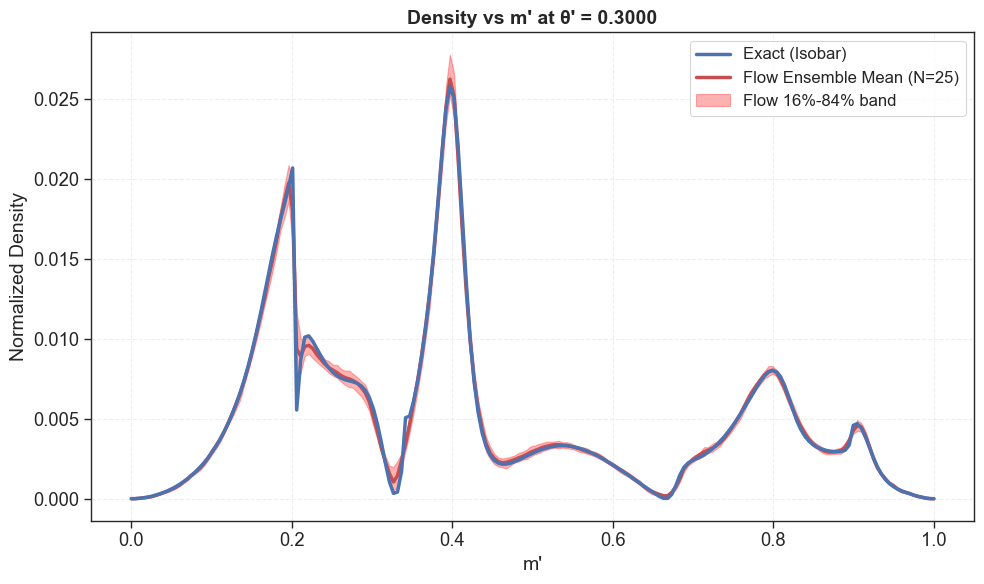


Comparison Metrics (normalized densities):
  MSE: 1.668310e-07
  MAE: 1.680347e-04
  Max absolute error: 3.828847e-03
  Correlation coefficient: 0.996925
  Coverage (exact within 16%-84% band): 87.5% (Expected: ~68%)

Plot saved to: ensemble_vs_isobar_1d_slice_theta0.30.pdf


(array([0.        , 0.00502513, 0.01005025, 0.01507538, 0.0201005 ,
        0.02512563, 0.03015075, 0.03517588, 0.04020101, 0.04522613,
        0.05025126, 0.05527638, 0.06030151, 0.06532663, 0.07035176,
        0.07537688, 0.08040201, 0.08542714, 0.09045226, 0.09547739,
        0.10050251, 0.10552764, 0.11055276, 0.11557789, 0.12060302,
        0.12562814, 0.13065327, 0.13567839, 0.14070352, 0.14572864,
        0.15075377, 0.15577889, 0.16080402, 0.16582915, 0.17085427,
        0.1758794 , 0.18090452, 0.18592965, 0.19095477, 0.1959799 ,
        0.20100503, 0.20603015, 0.21105528, 0.2160804 , 0.22110553,
        0.22613065, 0.23115578, 0.2361809 , 0.24120603, 0.24623116,
        0.25125628, 0.25628141, 0.26130653, 0.26633166, 0.27135678,
        0.27638191, 0.28140704, 0.28643216, 0.29145729, 0.29648241,
        0.30150754, 0.30653266, 0.31155779, 0.31658291, 0.32160804,
        0.32663317, 0.33165829, 0.33668342, 0.34170854, 0.34673367,
        0.35175879, 0.35678392, 0.36180905, 0.36

In [48]:
def plot_density_slice_ensemble_comparison(fixed_dim='m', fixed_value=0.5, n_points=200,
                                          ensemble_dirs='test_ensemble2',
                                          num_flows=16, hidden_features=128, num_bins=16,
                                          SDP_model=None, dkpp_model=None,
                                          device='cpu', savepath=None):
    """
    Compare ensemble flow density (mean with 16%-84% percentile band) with exact isobar model density along a 1D slice.
    
    Parameters
    ----------
    fixed_dim : str
        Which dimension to fix: 'm' for m' or 'theta' for θ'
    fixed_value : float
        Value to fix the dimension at
    n_points : int
        Number of points along the varying dimension
    ensemble_dirs : str or list of str
        Ensemble directory/directories to load models from
    num_flows, hidden_features, num_bins : int
        Flow architecture parameters
    SDP_model : torch model
        SDP model for exact density computation
    dkpp_model : DKpp instance
        D→Kππ amplitude model
    device : str
        Device for computation
    savepath : str, optional
        Path to save the figure
    
    Returns
    -------
    varying_values : ndarray
        Values along the varying dimension
    density_exact_norm : ndarray
        Normalized exact density
    ensemble_mean : ndarray
        Mean of normalized ensemble densities
    ensemble_p16 : ndarray
        16th percentile of ensemble densities
    ensemble_p84 : ndarray
        84th percentile of ensemble densities
    """
    # Determine labels based on fixed dimension
    if fixed_dim == 'm':
        varying_label = "θ'"
        fixed_label = "m'"
    elif fixed_dim == 'theta':
        varying_label = "m'"
        fixed_label = "θ'"
    else:
        raise ValueError("fixed_dim must be 'm' or 'theta'")
    
    print(f"Comparing ensemble flow density with exact isobar model at fixed {fixed_label} = {fixed_value:.4f}...")
    
    # Create 1D grid
    varying_values, pts = make_sdp_grid_1d_slice(fixed_dim=fixed_dim, 
                                                  fixed_value=fixed_value, 
                                                  n_points=n_points)
    
    # Grid shape for 1D slice
    grid_shape = (n_points,)
    
    # Load ensemble and compute densities
    print(f"Loading ensemble densities...")
    ensemble_densities, total_models, ensemble_info = load_combined_ensemble_densities(
        ensemble_dirs=ensemble_dirs,
        pts=pts,
        grid_shape=grid_shape,
        num_flows=num_flows,
        hidden_features=hidden_features,
        num_bins=num_bins,
        device=device
    )
    
    # Compute ensemble statistics
    # ensemble_densities shape: (total_models, n_points)
    ensemble_mean = np.mean(ensemble_densities, axis=0)
    ensemble_p16 = np.percentile(ensemble_densities, 16, axis=0)
    ensemble_p84 = np.percentile(ensemble_densities, 84, axis=0)
    
    # Compute exact density from isobar model
    print("Computing exact isobar model density...")
    
    # Load a flow model for compute_mag_exact (use first from ensemble or create dummy)
    flow_dummy = create_flow(num_flows=num_flows, hidden_features=hidden_features, num_bins=num_bins)
    flow_dummy.eval()
    flow_dummy.to(device)
    
    density_exact = compute_mag_exact(pts, SDP_model, flow_dummy, dkpp_model, device=device)
    
    # Convert to numpy if tensor
    if torch.is_tensor(density_exact):
        density_exact = density_exact.cpu().numpy()
    
    density_exact = density_exact.flatten()  # Ensure 1D
    
    # Normalize exact density
    density_exact_norm = density_exact / density_exact.sum()
    
    print(f"\nDensity statistics:")
    print(f"  Ensemble Mean - Min: {ensemble_mean.min():.6e}, Max: {ensemble_mean.max():.6e}")
    print(f"  Ensemble 16%  - Min: {ensemble_p16.min():.6e}, Max: {ensemble_p16.max():.6e}")
    print(f"  Ensemble 84%  - Min: {ensemble_p84.min():.6e}, Max: {ensemble_p84.max():.6e}")
    print(f"  Exact         - Min: {density_exact_norm.min():.6e}, Max: {density_exact_norm.max():.6e}")
    
    # Plot comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot exact density
    ax.plot(varying_values, density_exact_norm, 'b-', linewidth=2.5, 
            label='Exact (Isobar)', zorder=3)
    
    # Plot ensemble mean
    ax.plot(varying_values, ensemble_mean, 'r-', linewidth=2.5, 
            label=f'Flow Ensemble Mean (N={total_models})', zorder=2)
    
    # Plot 16%-84% percentile band
    ax.fill_between(varying_values, 
                     ensemble_p16, 
                     ensemble_p84,
                     color='red', alpha=0.3, label='Flow 16%-84% band', zorder=1)
    
    ax.set_xlabel(varying_label, fontsize=14)
    ax.set_ylabel('Normalized Density', fontsize=14)
    ax.set_title(f"Density vs {varying_label} at {fixed_label} = {fixed_value:.4f}", 
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=12, loc='best')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    # Generate default savepath if not provided
    if savepath is None:
        savepath = f'ensemble_vs_isobar_1d_slice_{fixed_dim}{fixed_value:.2f}.pdf'
    
    plt.savefig(savepath, dpi=150, bbox_inches='tight')
    plt.show()
    
    # Compute and print comparison metrics
    mse = np.mean((ensemble_mean - density_exact_norm)**2)
    mae = np.mean(np.abs(ensemble_mean - density_exact_norm))
    max_abs_error = np.max(np.abs(ensemble_mean - density_exact_norm))
    correlation = np.corrcoef(ensemble_mean, density_exact_norm)[0, 1]
    
    # Check coverage (how often exact falls within 16%-84% band)
    within_band = (density_exact_norm >= ensemble_p16) & (density_exact_norm <= ensemble_p84)
    coverage = np.mean(within_band)
    
    print(f"\nComparison Metrics (normalized densities):")
    print(f"  MSE: {mse:.6e}")
    print(f"  MAE: {mae:.6e}")
    print(f"  Max absolute error: {max_abs_error:.6e}")
    print(f"  Correlation coefficient: {correlation:.6f}")
    print(f"  Coverage (exact within 16%-84% band): {coverage:.1%} (Expected: ~68%)")
    print(f"\nPlot saved to: {savepath}")
    
    return varying_values, density_exact_norm, ensemble_mean, ensemble_p16, ensemble_p84


# Example usage:

# Plot density vs θ' at fixed m' = 0.5 with ensemble
plot_density_slice_ensemble_comparison(
    fixed_dim='m', 
    fixed_value=0.5, 
    n_points=200,
    ensemble_dirs='test_ensemble_2e6',  # or ['test_ensemble', 'test_ensemble2']
    num_flows=12,
    hidden_features=128,
    num_bins=24,
    SDP_model=SDP, 
    dkpp_model=dkpp_model,
    device=device
)

# Plot density vs m' at fixed θ' = 0.3 with ensemble
plot_density_slice_ensemble_comparison(
    fixed_dim='theta', 
    fixed_value=0.3, 
    n_points=200,
    ensemble_dirs='test_ensemble_2e6',
    num_flows=12,
    hidden_features=128,
    num_bins=24,
    SDP_model=SDP, 
    dkpp_model=dkpp_model,
    device=device
)

In [49]:
def plot_coverage_indicator_map(U, V, exact_density, ensemble_densities, 
                                num_models, savepath='coverage_indicator_map.pdf'):
    """
    Plot indicator map showing where exact density falls within ensemble 16%-84% band.
    
    Parameters
    ----------
    U, V : ndarray
        Meshgrid coordinates for the Dalitz plot
    exact_density : ndarray
        Exact density from isobar model
    ensemble_densities : ndarray, shape (num_models, ny, nx)
        Densities from all ensemble models
    num_models : int
        Number of models in ensemble
    savepath : str
        Path to save the figure
    """
    # Compute ensemble percentiles
    ensemble_p16 = np.percentile(ensemble_densities, 16, axis=0)
    ensemble_p84 = np.percentile(ensemble_densities, 84, axis=0)
    ensemble_mean = np.mean(ensemble_densities, axis=0)
    
    # Create indicator: 1 where exact is within band, 0 otherwise
    within_band = (exact_density >= ensemble_p16) & (exact_density <= ensemble_p84)
    indicator = within_band.astype(float)
    
    # For visualization: use NaN for outside band (white), 1 for inside (green)
    indicator_viz = np.where(within_band, 1, np.nan)
    
    # Calculate statistics
    total_points = exact_density.size
    points_in_band = np.sum(within_band)
    coverage = points_in_band / total_points
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot only regions where exact falls within band (in green)
    im = ax.pcolormesh(U, V, indicator_viz, cmap='Greens', shading='auto', 
                       vmin=0, vmax=1, alpha=0.8)
    
    ax.set_xlabel("m'", fontsize=14)
    ax.set_ylabel("θ'", fontsize=14)
    ax.set_title(f'Coverage Map: Exact Within Ensemble 16%-84% Band (N={num_models})', 
                 fontsize=14, fontweight='bold')
    ax.set_aspect('equal')
    
    # Add text with statistics
    stats_text = f'Points within band: {points_in_band}/{total_points}\n'
    stats_text += f'Coverage: {coverage:.1%}\n'
    stats_text += f'Expected: ~68%\n\n'
    stats_text += f'Green = Within band\n'
    stats_text += f'White = Outside band'
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            verticalalignment='top', fontsize=11,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))
    
    plt.tight_layout()
    plt.savefig(savepath, dpi=300, bbox_inches='tight')
    print(f"Coverage indicator map saved to: {savepath}")
    plt.show()
    
    print(f"\nCoverage Summary:")
    print(f"  Coverage: {coverage:.1%} (Expected: ~68%)")
    print(f"  Points within band: {points_in_band}/{total_points}")
    
    return indicator, coverage


def plot_coverage_detailed(U, V, exact_density, ensemble_densities, 
                          num_models, savepath='coverage_detailed.pdf'):
    """
    Create detailed 2x2 plot showing ensemble mean, exact density, band widths, and coverage.
    
    Parameters
    ----------
    U, V : ndarray
        Meshgrid coordinates for the Dalitz plot
    exact_density : ndarray
        Exact density from isobar model
    ensemble_densities : ndarray, shape (num_models, ny, nx)
        Densities from all ensemble models
    num_models : int
        Number of models in ensemble
    savepath : str
        Path to save the figure
    """
    # Compute ensemble statistics
    ensemble_mean = np.mean(ensemble_densities, axis=0)
    ensemble_p16 = np.percentile(ensemble_densities, 16, axis=0)
    ensemble_p84 = np.percentile(ensemble_densities, 84, axis=0)
    band_width = ensemble_p84 - ensemble_p16
    
    # Coverage indicator
    within_band = (exact_density >= ensemble_p16) & (exact_density <= ensemble_p84)
    indicator_viz = np.where(within_band, 1, np.nan)
    coverage = np.mean(within_band)
    
    # Create 2x2 plot
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Top left: Ensemble mean
    im0 = axes[0, 0].pcolormesh(U, V, ensemble_mean, cmap='viridis', shading='auto')
    axes[0, 0].set_xlabel("m'", fontsize=12)
    axes[0, 0].set_ylabel("θ'", fontsize=12)
    axes[0, 0].set_title(f'Ensemble Mean Density (N={num_models})', fontsize=12)
    axes[0, 0].set_aspect('equal')
    plt.colorbar(im0, ax=axes[0, 0], label='Density')
    
    # Top right: Exact density
    im1 = axes[0, 1].pcolormesh(U, V, exact_density, cmap='viridis', shading='auto')
    axes[0, 1].set_xlabel("m'", fontsize=12)
    axes[0, 1].set_ylabel("θ'", fontsize=12)
    axes[0, 1].set_title('Exact (Isobar) Density', fontsize=12)
    axes[0, 1].set_aspect('equal')
    plt.colorbar(im1, ax=axes[0, 1], label='Density')
    
    # Bottom left: Band width (84% - 16%)
    im2 = axes[1, 0].pcolormesh(U, V, band_width, cmap='plasma', shading='auto')
    axes[1, 0].set_xlabel("m'", fontsize=12)
    axes[1, 0].set_ylabel("θ'", fontsize=12)
    axes[1, 0].set_title('Uncertainty (84th - 16th Percentile)', fontsize=12)
    axes[1, 0].set_aspect('equal')
    plt.colorbar(im2, ax=axes[1, 0], label='Band Width')
    
    # Bottom right: Coverage indicator
    im3 = axes[1, 1].pcolormesh(U, V, indicator_viz, cmap='Greens', shading='auto', 
                                vmin=0, vmax=1, alpha=0.8)
    axes[1, 1].set_xlabel("m'", fontsize=12)
    axes[1, 1].set_ylabel("θ'", fontsize=12)
    axes[1, 1].set_title(f'Coverage Map (Green=Within Band, White=Outside)', fontsize=12)
    axes[1, 1].set_aspect('equal')
    
    # Add coverage text
    axes[1, 1].text(0.05, 0.95, f'Coverage: {coverage:.1%}\n(Expected: ~68%)', 
                    transform=axes[1, 1].transAxes,
                    verticalalignment='top', fontsize=11,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))
    
    plt.tight_layout()
    plt.savefig(savepath, dpi=300, bbox_inches='tight')
    print(f"Detailed coverage plot saved to: {savepath}")
    plt.show()
    
    print(f"\nCoverage: {coverage:.1%}")



In [50]:
# 1. Create full grid
U, V, pts = make_sdp_grid(nx=200, ny=200)

# 2. Load ensemble and compute densities
ensemble_densities, total_models, ensemble_info = load_combined_ensemble_densities(
    ensemble_dirs = "test_ensemble_2e6",
    pts=pts,
    grid_shape=U.shape,
    num_flows=12,
    hidden_features=128,
    num_bins=24,
    device=device
)

## 3. Compute exact density
density_exact_flat = compute_mag_exact(pts, SDP, flow, dkpp_model, device=device)

# Convert to numpy if tensor
if torch.is_tensor(density_exact_flat):
    density_exact_flat = density_exact_flat.cpu().numpy()

# Ensure 1D and normalize
density_exact_flat = density_exact_flat.flatten()
density_exact_normalized = density_exact_flat / density_exact_flat.sum()

# Reshape to 2D for plotting
density_exact = density_exact_normalized.reshape(U.shape)


Combining models from 1 ensemble(s): ['test_ensemble_2e6']

  Loading from test_ensemble_2e6...
    Found 25 models
      Processing model 1/25...


c:\Users\chinh\anaconda3\Lib\site-packages\nflows\transforms\coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


      Processing model 2/25...
      Processing model 3/25...
      Processing model 4/25...
      Processing model 5/25...
      Processing model 6/25...
      Processing model 7/25...
      Processing model 8/25...
      Processing model 9/25...
      Processing model 10/25...
      Processing model 11/25...
      Processing model 12/25...
      Processing model 13/25...
      Processing model 14/25...
      Processing model 15/25...
      Processing model 16/25...
      Processing model 17/25...
      Processing model 18/25...
      Processing model 19/25...
      Processing model 20/25...
      Processing model 21/25...
      Processing model 22/25...
      Processing model 23/25...
      Processing model 24/25...
      Processing model 25/25...

  Total models combined: 25


c:\Users\chinh\OneDrive\Documents\GitHub\Extraction-of-Gamma-with-Normalising-flows\Amplitude.py:487: RuntimeWarning: divide by zero encountered in scalar divide
  dmp_dsij = -(1.0 / np.pi) * (1.0 / np.sqrt(one_minus_x2)) * (1.0 / (denom_m * np.sqrt(mijSq)))
c:\Users\chinh\OneDrive\Documents\GitHub\Extraction-of-Gamma-with-Normalising-flows\Amplitude.py:426: RuntimeWarning: divide by zero encountered in scalar divide
  cosHel = -(mikSq - self.mSq[i] - self.mSq[k] - 2.0 * EiCmsij * EkCmsij) / (2.0 * self.qi * self.qk)


Coverage indicator map saved to: coverage_indicator_map.pdf


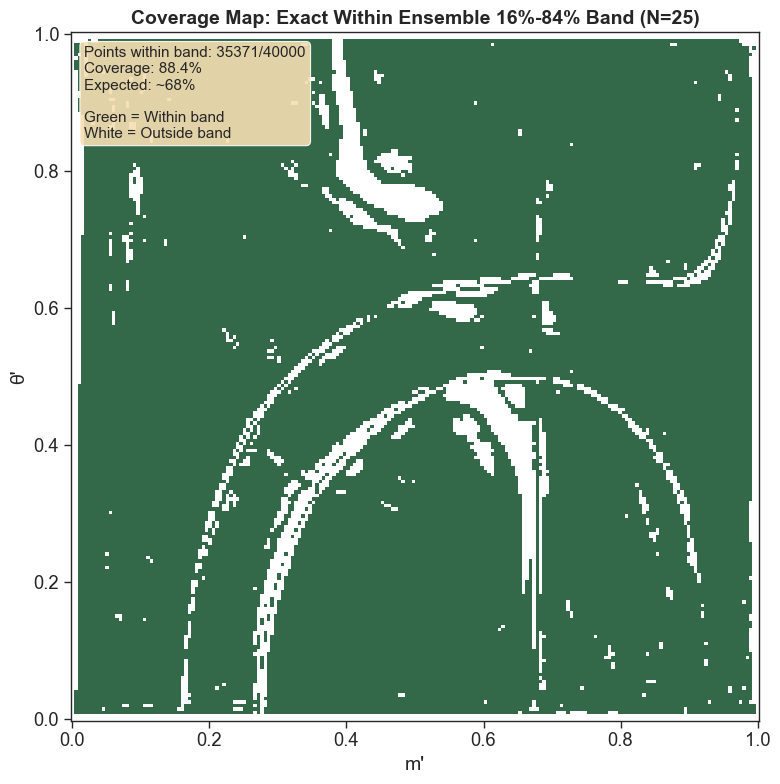


Coverage Summary:
  Coverage: 88.4% (Expected: ~68%)
  Points within band: 35371/40000
Detailed coverage plot saved to: coverage_detailed.pdf


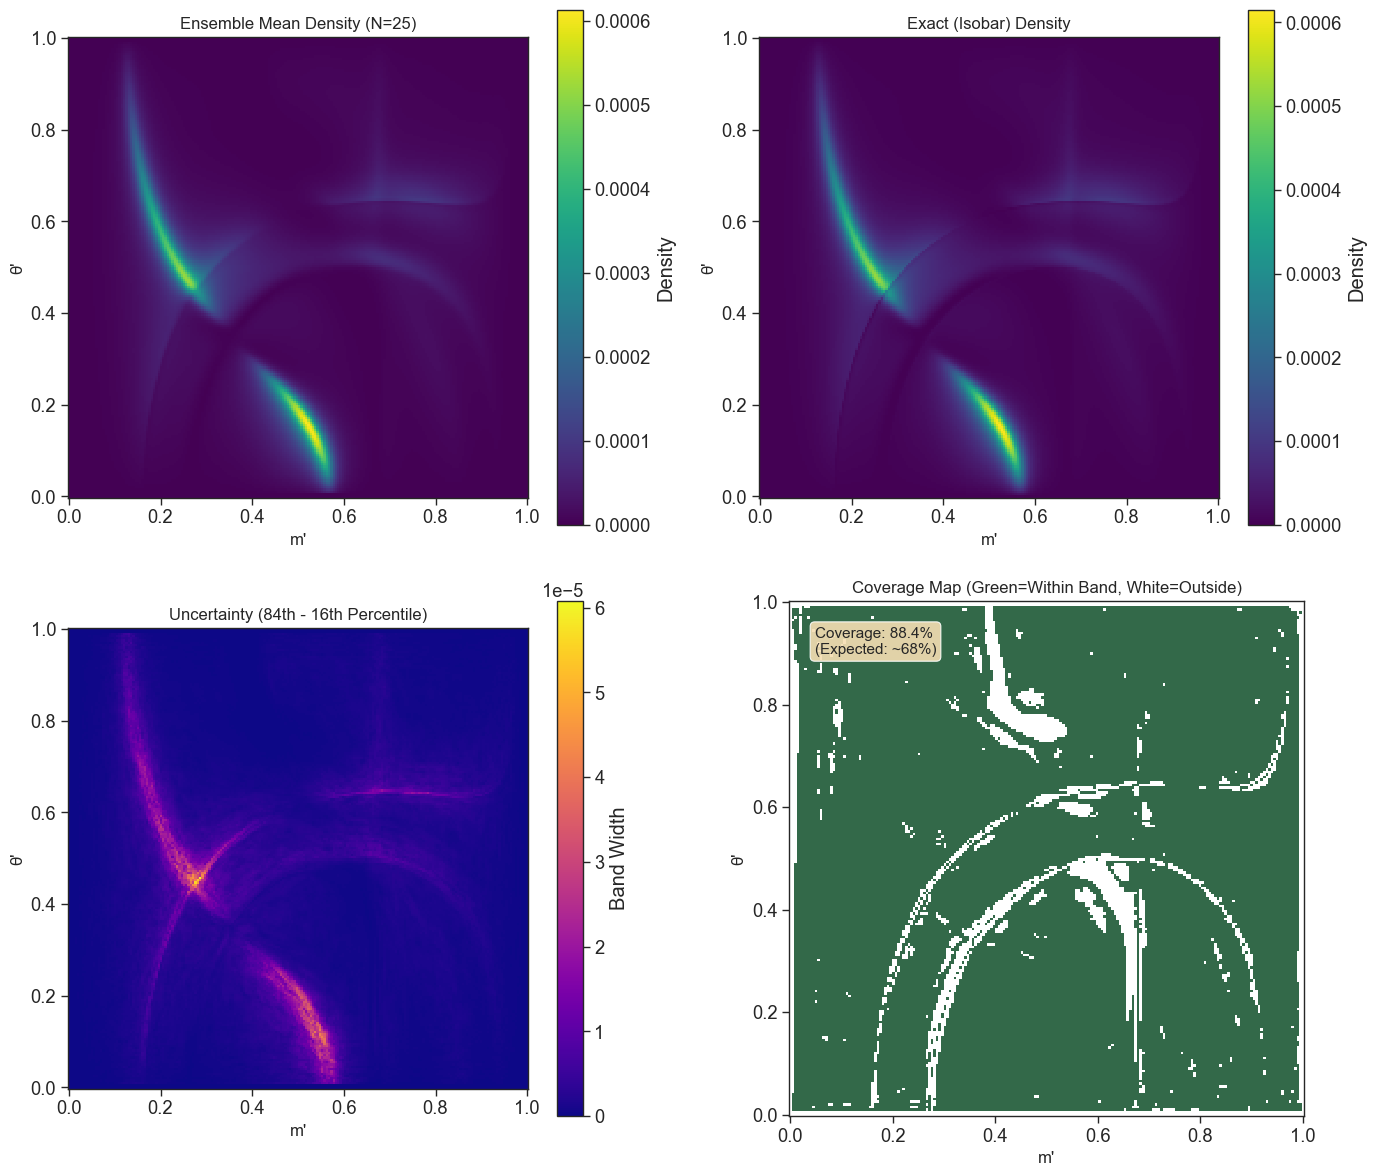


Coverage: 88.4%


In [51]:
# 4. Plot coverage maps
plot_coverage_indicator_map(U, V, density_exact, ensemble_densities, total_models)
plot_coverage_detailed(U, V, density_exact, ensemble_densities, total_models)

In [52]:
def plot_coverage_indicator_map_with_low_density(U, V, exact_density, ensemble_densities, 
                                                  num_models, threshold=0.0001,
                                                  savepath='coverage_indicator_map_red.pdf'):
    """
    Plot indicator map showing where exact density falls within ensemble 16%-84% band.
    - Green: Exact within band
    - Red: Exact outside band AND ensemble mean < threshold
    - White: Exact outside band AND ensemble mean >= threshold
    
    Parameters
    ----------
    U, V : ndarray
        Meshgrid coordinates for the Dalitz plot
    exact_density : ndarray
        Exact density from isobar model
    ensemble_densities : ndarray, shape (num_models, ny, nx)
        Densities from all ensemble models
    num_models : int
        Number of models in ensemble
    threshold : float
        Threshold for low ensemble mean density (default: 0.0001)
    savepath : str
        Path to save the figure
    """
    # Compute ensemble percentiles
    ensemble_p16 = np.percentile(ensemble_densities, 16, axis=0)
    ensemble_p84 = np.percentile(ensemble_densities, 84, axis=0)
    ensemble_mean = np.mean(ensemble_densities, axis=0)
    
    # Create indicator categories
    within_band = (exact_density >= ensemble_p16) & (exact_density <= ensemble_p84)
    outside_band = ~within_band
    low_mean = ensemble_mean < threshold
    
    # Create color map:
    # 0 = white (outside band, normal density)
    # 1 = green (within band)
    # 2 = red (outside band AND low mean)
    indicator = np.zeros_like(exact_density)
    indicator[within_band] = 1  # Green
    indicator[outside_band & low_mean] = 2  # Red
    indicator[outside_band & ~low_mean] = 0  # White (will be NaN for visualization)
    
    # For visualization: use custom colormap
    indicator_viz = indicator.copy().astype(float)
    indicator_viz[indicator == 0] = np.nan  # White for outside band with normal density
    
    # Calculate statistics
    total_points = exact_density.size
    points_in_band = np.sum(within_band)
    points_outside_low = np.sum(outside_band & low_mean)
    points_outside_normal = np.sum(outside_band & ~low_mean)
    coverage = points_in_band / total_points
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create custom colormap: green (1) and red (2)
    from matplotlib.colors import ListedColormap, BoundaryNorm
    colors = ['white', 'green', 'red']  # 0, 1, 2
    n_bins = 3
    cmap = ListedColormap(['green', 'red'])
    bounds = [0.5, 1.5, 2.5]
    norm = BoundaryNorm(bounds, cmap.N)
    
    # Plot
    im = ax.pcolormesh(U, V, indicator_viz, cmap=cmap, norm=norm, shading='auto')
    
    ax.set_xlabel("m'", fontsize=14)
    ax.set_ylabel("θ'", fontsize=14)
    ax.set_title(f'Coverage Map with Low Density Flag (N={num_models})', 
                 fontsize=14, fontweight='bold')
    ax.set_aspect('equal')
    
    # Add text with statistics
    stats_text = f'Within band: {points_in_band}/{total_points} ({coverage:.1%})\n'
    stats_text += f'Outside (low ρ): {points_outside_low} ({points_outside_low/total_points:.1%})\n'
    stats_text += f'Outside (normal): {points_outside_normal} ({points_outside_normal/total_points:.1%})\n\n'
    stats_text += f'Green = Within 16%-84% band\n'
    stats_text += f'Red = Outside band & ρ̄ < {threshold}\n'
    stats_text += f'White = Outside band & ρ̄ ≥ {threshold}'
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            verticalalignment='top', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))
    
    plt.tight_layout()
    plt.savefig(savepath, dpi=300, bbox_inches='tight')
    print(f"Coverage indicator map with low density flag saved to: {savepath}")
    plt.show()
    
    print(f"\nCoverage Summary:")
    print(f"  Within band: {coverage:.1%} (Expected: ~68%)")
    print(f"  Outside band with low density (ρ̄ < {threshold}): {points_outside_low/total_points:.1%}")
    print(f"  Outside band with normal density: {points_outside_normal/total_points:.1%}")
    
    return indicator, coverage


def plot_coverage_detailed_with_red(U, V, exact_density, ensemble_densities, 
                                   num_models, threshold=0.0001,
                                   savepath='coverage_detailed_red.pdf'):
    """
    Create detailed 2x2 plot with red indicator for low density regions outside band.
    
    Parameters
    ----------
    U, V : ndarray
        Meshgrid coordinates for the Dalitz plot
    exact_density : ndarray
        Exact density from isobar model
    ensemble_densities : ndarray, shape (num_models, ny, nx)
        Densities from all ensemble models
    num_models : int
        Number of models in ensemble
    threshold : float
        Threshold for low ensemble mean density
    savepath : str
        Path to save the figure
    """
    # Compute ensemble statistics
    ensemble_mean = np.mean(ensemble_densities, axis=0)
    ensemble_p16 = np.percentile(ensemble_densities, 16, axis=0)
    ensemble_p84 = np.percentile(ensemble_densities, 84, axis=0)
    band_width = ensemble_p84 - ensemble_p16
    
    # Coverage indicator with categories
    within_band = (exact_density >= ensemble_p16) & (exact_density <= ensemble_p84)
    outside_band = ~within_band
    low_mean = ensemble_mean < threshold
    
    indicator = np.zeros_like(exact_density)
    indicator[within_band] = 1  # Green
    indicator[outside_band & low_mean] = 2  # Red
    indicator_viz = indicator.copy().astype(float)
    indicator_viz[indicator == 0] = np.nan  # White
    
    coverage = np.mean(within_band)
    points_outside_low = np.sum(outside_band & low_mean)
    
    # Create 2x2 plot
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Top left: Ensemble mean
    im0 = axes[0, 0].pcolormesh(U, V, ensemble_mean, cmap='viridis', shading='auto')
    axes[0, 0].set_xlabel("m'", fontsize=12)
    axes[0, 0].set_ylabel("θ'", fontsize=12)
    axes[0, 0].set_title(f'Ensemble Mean Density (N={num_models})', fontsize=12)
    axes[0, 0].set_aspect('equal')
    plt.colorbar(im0, ax=axes[0, 0], label='Density')
    
    # Top right: Exact density
    im1 = axes[0, 1].pcolormesh(U, V, exact_density, cmap='viridis', shading='auto')
    axes[0, 1].set_xlabel("m'", fontsize=12)
    axes[0, 1].set_ylabel("θ'", fontsize=12)
    axes[0, 1].set_title('Exact (Isobar) Density', fontsize=12)
    axes[0, 1].set_aspect('equal')
    plt.colorbar(im1, ax=axes[0, 1], label='Density')
    
    # Bottom left: Band width (84% - 16%)
    im2 = axes[1, 0].pcolormesh(U, V, band_width, cmap='plasma', shading='auto')
    axes[1, 0].set_xlabel("m'", fontsize=12)
    axes[1, 0].set_ylabel("θ'", fontsize=12)
    axes[1, 0].set_title('Uncertainty (84th - 16th Percentile)', fontsize=12)
    axes[1, 0].set_aspect('equal')
    plt.colorbar(im2, ax=axes[1, 0], label='Band Width')
    
    # Bottom right: Coverage indicator with red
    from matplotlib.colors import ListedColormap, BoundaryNorm
    cmap = ListedColormap(['green', 'red'])
    bounds = [0.5, 1.5, 2.5]
    norm = BoundaryNorm(bounds, cmap.N)
    
    im3 = axes[1, 1].pcolormesh(U, V, indicator_viz, cmap=cmap, norm=norm, shading='auto')
    axes[1, 1].set_xlabel("m'", fontsize=12)
    axes[1, 1].set_ylabel("θ'", fontsize=12)
    axes[1, 1].set_title(f'Coverage Map (Green/Red/White)', fontsize=12)
    axes[1, 1].set_aspect('equal')
    
    # Add coverage text
    stats_text = f'Coverage: {coverage:.1%}\n'
    stats_text += f'Outside (low ρ): {points_outside_low/exact_density.size:.1%}\n\n'
    stats_text += f'Green: Within band\n'
    stats_text += f'Red: Outside & ρ̄<{threshold}\n'
    stats_text += f'White: Outside & ρ̄≥{threshold}'
    
    axes[1, 1].text(0.05, 0.95, stats_text, 
                    transform=axes[1, 1].transAxes,
                    verticalalignment='top', fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))
    
    plt.tight_layout()
    plt.savefig(savepath, dpi=300, bbox_inches='tight')
    print(f"Detailed coverage plot with red flag saved to: {savepath}")
    plt.show()
    
    print(f"\nCoverage: {coverage:.1%}")
    print(f"Outside band with low density: {points_outside_low/exact_density.size:.1%}")


Coverage indicator map with low density flag saved to: coverage_indicator_map_red.pdf


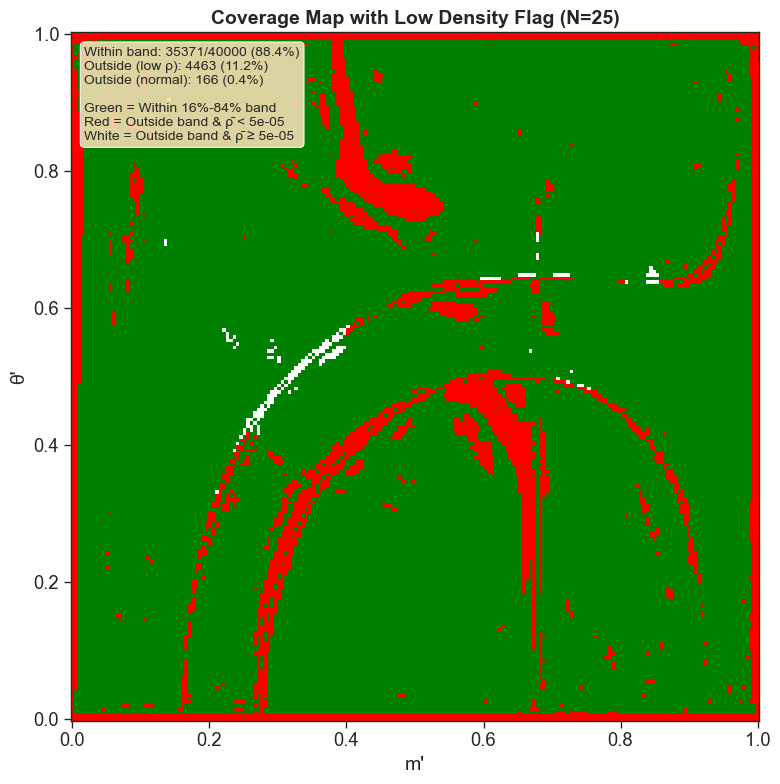


Coverage Summary:
  Within band: 88.4% (Expected: ~68%)
  Outside band with low density (ρ̄ < 5e-05): 11.2%
  Outside band with normal density: 0.4%
Detailed coverage plot with red flag saved to: coverage_detailed_red.pdf


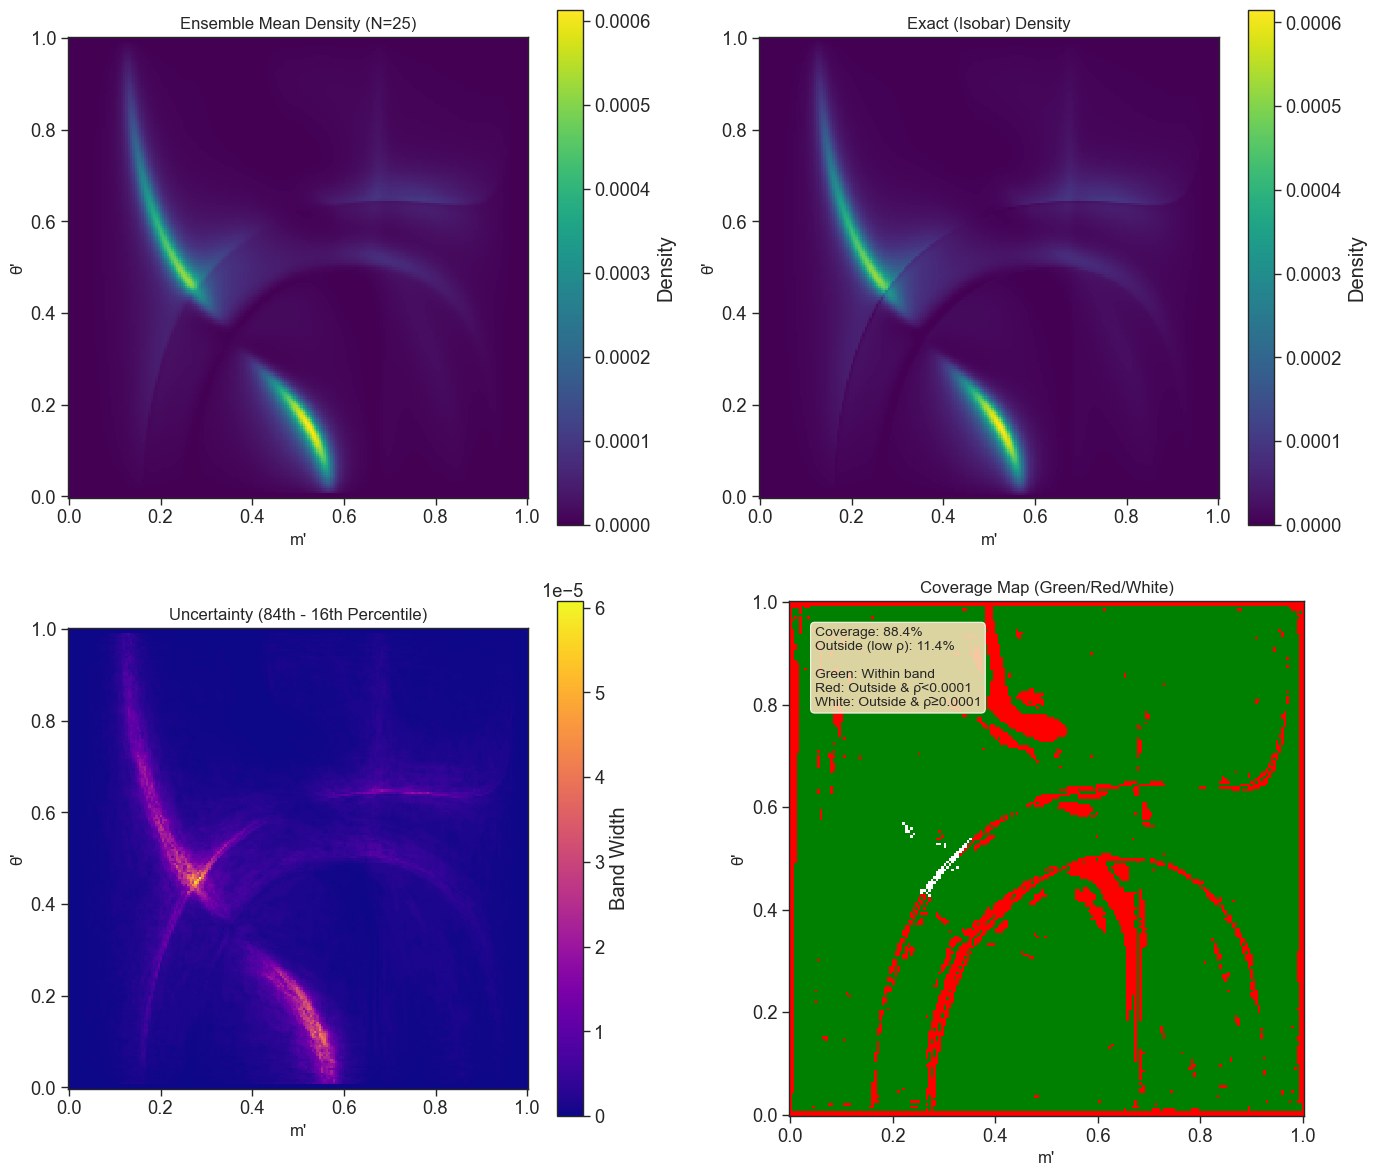


Coverage: 88.4%
Outside band with low density: 11.4%


In [53]:
# Example usage:
plot_coverage_indicator_map_with_low_density(U, V, density_exact, ensemble_densities, 
                                             total_models, threshold=0.00005)
plot_coverage_detailed_with_red(U, V, density_exact, ensemble_densities, 
                               total_models, threshold=0.0001)

COMBINED MULTI-ENSEMBLE PULL MAP ANALYSIS

Found 1 ensemble(s) to combine: ['test_ensemble_2e6']

Computing exact density from isobar model...

LOADING AND COMBINING ENSEMBLES
Combining models from 1 ensemble(s): ['test_ensemble_2e6']

  Loading from test_ensemble_2e6...
    Found 25 models
      Processing model 1/25...
      Processing model 2/25...
      Processing model 3/25...
      Processing model 4/25...
      Processing model 5/25...
      Processing model 6/25...
      Processing model 7/25...
      Processing model 8/25...
      Processing model 9/25...
      Processing model 10/25...
      Processing model 11/25...
      Processing model 12/25...
      Processing model 13/25...
      Processing model 14/25...
      Processing model 15/25...
      Processing model 16/25...
      Processing model 17/25...
      Processing model 18/25...
      Processing model 19/25...
      Processing model 20/25...
      Processing model 21/25...
      Processing model 22/25...
      Process

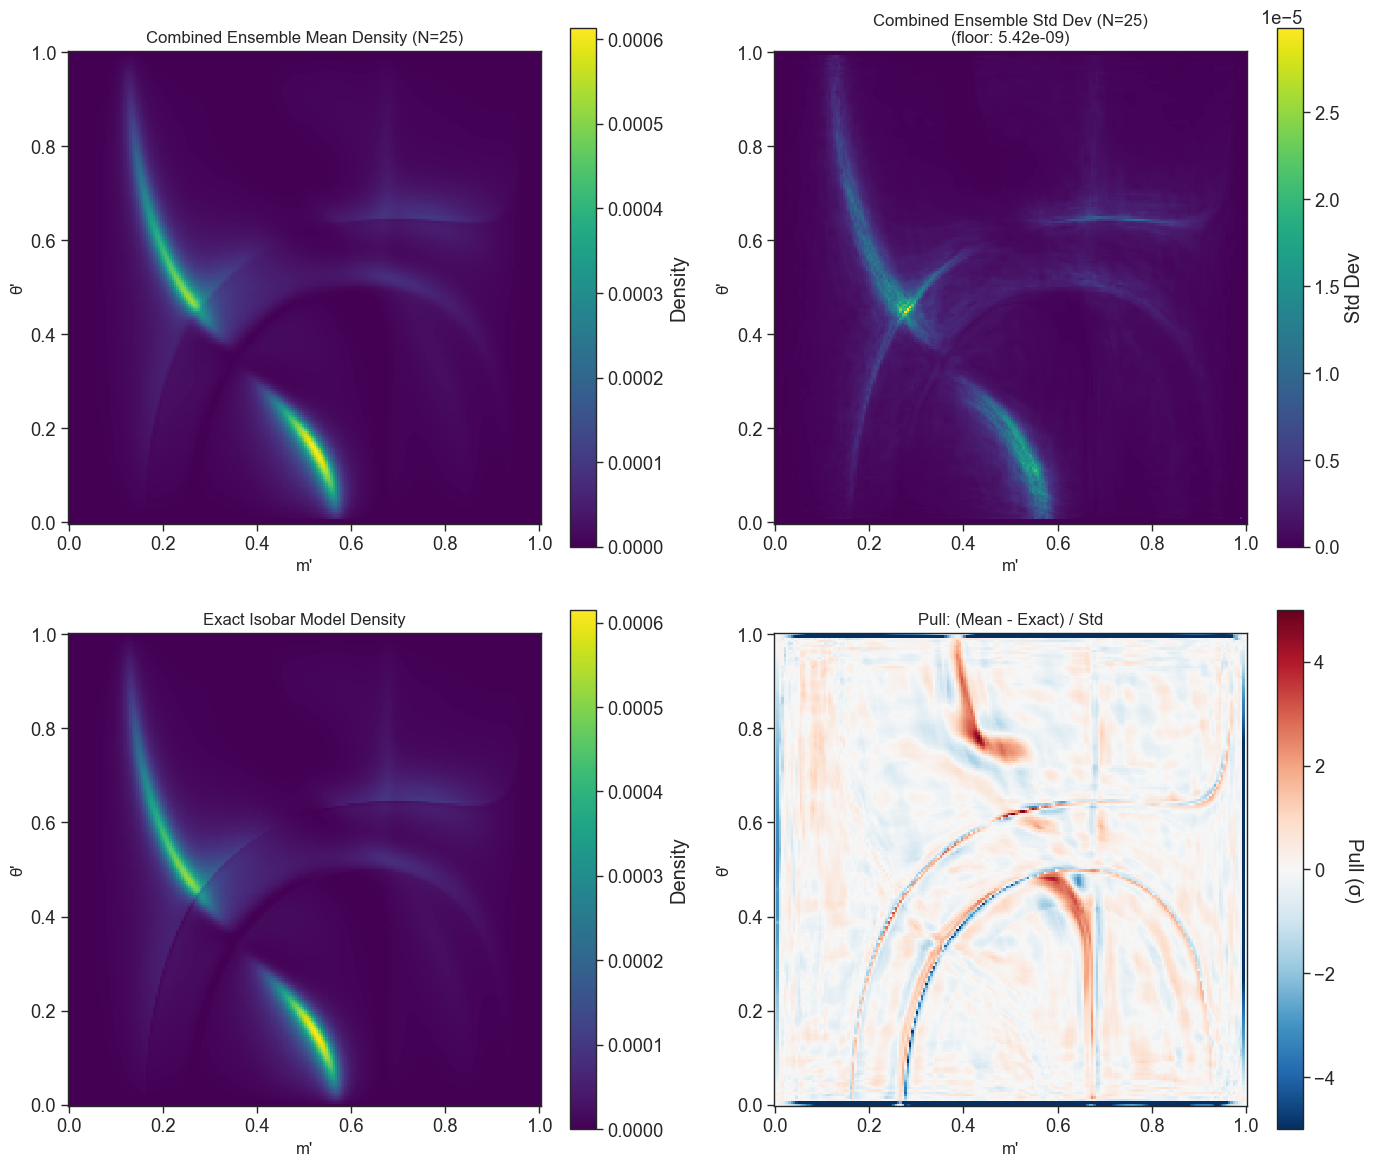


Pull map saved to: ensemble_pull_map_combined_1.pdf

PULL DISTRIBUTION ANALYSIS


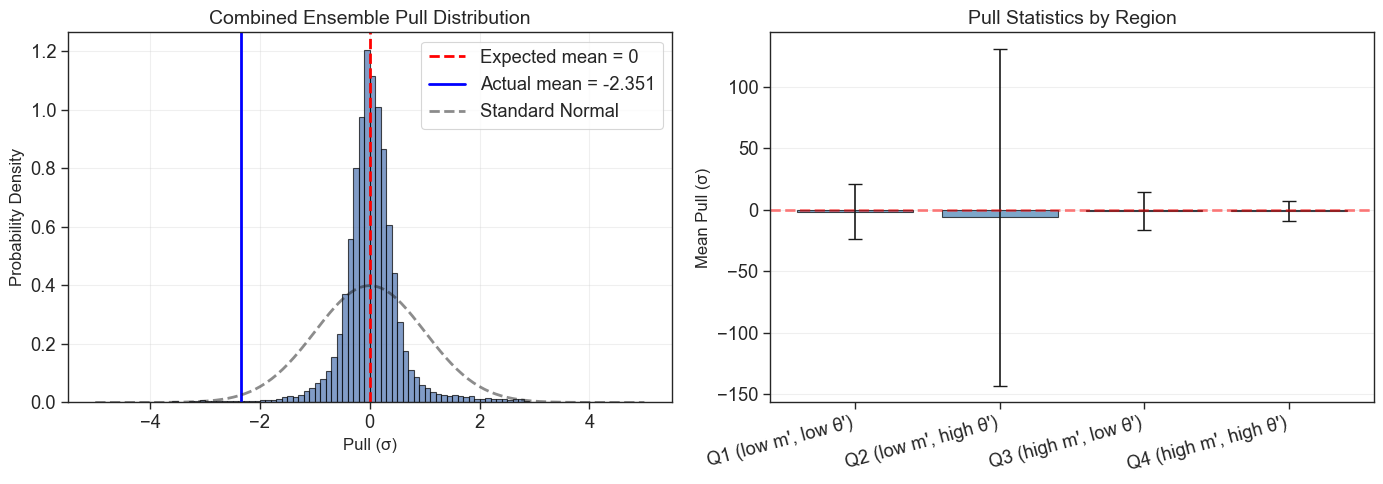


Pull distribution plot saved to: pull_distribution_combined_1.pdf

Pull Distribution Statistics:
  Sample size: 40,000 grid points
  Mean: -2.3508 (should be ~0)
  Std:  69.8851 (should be ~1)
  Median: 0.0034
  2.5%:  -2.62 (expected: -1.96)
  97.5%: 1.37 (expected: +1.96)
  Fraction outside ±2σ: 4.03% (expected: ~5%)
  Fraction outside ±3σ: 2.49% (expected: ~0.3%)

COMBINED ANALYSIS COMPLETE
Combined 25 models from 1 ensemble(s)
Generated files:
  - ensemble_pull_map_combined_1.pdf
  - pull_distribution_combined_1.pdf


In [57]:
# ============================================================================
# COMBINED MULTI-ENSEMBLE PULL MAP ANALYSIS
# ============================================================================
# This cell combines models from multiple ensemble directories into one
# larger ensemble for analysis. Easily reusable for any combination.

def load_combined_ensemble_densities(ensemble_dirs, pts, grid_shape, num_flows=16, 
                                     hidden_features=128, num_bins=16, device='cpu'):
    """
    Load and combine models from multiple ensemble directories into one ensemble.
    
    Parameters
    ----------
    ensemble_dirs : str or list of str
        Single ensemble directory or list of ensemble directories to combine
        Examples: "test_ensemble" or ["test_ensemble", "test_ensemble2"]
    pts : ndarray, shape (N, 2)
        Grid points in SDP coordinates
    grid_shape : tuple
        Shape of grid (ny, nx) for reshaping
    num_flows, hidden_features, num_bins : int
        Flow architecture parameters
    device : str
        Device for computation
    
    Returns
    -------
    ensemble_densities : ndarray, shape (total_models, ny, nx)
        Combined normalized densities from all models in all ensembles
    total_models : int
        Total number of models loaded
    ensemble_info : dict
        Information about which models came from which ensemble
    """
    from pathlib import Path
    import glob
    
    # Make ensemble_dirs a list if it's a single string
    if isinstance(ensemble_dirs, str):
        ensemble_dirs = [ensemble_dirs]
    
    print(f"Combining models from {len(ensemble_dirs)} ensemble(s): {ensemble_dirs}")
    
    all_densities = []
    ensemble_info = {'ensemble_dirs': ensemble_dirs, 'models_per_ensemble': []}
    
    for ens_idx, ensemble_dir in enumerate(ensemble_dirs, 1):
        print(f"\n  Loading from {ensemble_dir}...")
        
        # Find all model files in this ensemble
        model_files = sorted(glob.glob(f"{ensemble_dir}/trial_seed*.pth"))
        model_files = [f for f in model_files if not f.endswith('_best.pth')]
        num_models_this_ensemble = len(model_files)
        
        if num_models_this_ensemble == 0:
            print(f"    WARNING: No models found in {ensemble_dir}, skipping")
            continue
        
        print(f"    Found {num_models_this_ensemble} models")
        ensemble_info['models_per_ensemble'].append({
            'dir': ensemble_dir,
            'num_models': num_models_this_ensemble
        })
        
        for model_idx, model_path in enumerate(model_files, 1):
            print(f"      Processing model {model_idx}/{num_models_this_ensemble}...")
            
            # Load model
            model_flow = create_flow(num_flows=num_flows, hidden_features=hidden_features, 
                                     num_bins=num_bins)
            model_flow.load_state_dict(torch.load(model_path, map_location=device))
            model_flow.eval()
            model_flow.to(device)
            
            # Compute density
            with torch.no_grad():
                pts_tensor = torch.from_numpy(pts.astype(np.float32)).to(device)
                batch_size = 10000
                log_probs = []
                for i in range(0, len(pts_tensor), batch_size):
                    batch = pts_tensor[i:i+batch_size]
                    log_probs.append(model_flow.log_prob(batch).cpu().numpy())
                log_prob = np.concatenate(log_probs)
            
            density = np.exp(log_prob).reshape(grid_shape)
            density_norm = density / density.sum()  # Normalize
            all_densities.append(density_norm)
    
    if len(all_densities) == 0:
        raise ValueError("No models loaded from any ensemble!")
    
    total_models = len(all_densities)
    print(f"\n  Total models combined: {total_models}")
    
    return np.array(all_densities), total_models, ensemble_info


def compute_pull_map_combined(ensemble_mean, ensemble_std, exact_density, sigma_floor=None):
    """
    Compute pull map: (ensemble_mean - exact) / ensemble_std
    
    Parameters
    ----------
    ensemble_mean : ndarray
        Mean density from ensemble
    ensemble_std : ndarray
        Standard deviation from ensemble
    exact_density : ndarray
        Exact density from isobar model
    sigma_floor : float, optional
        Minimum allowed value for ensemble_std. If None, automatically set to
        a small fraction of the median std (default: 1% of median std).
    
    Returns
    -------
    pull : ndarray
        Pull values everywhere
    sigma_floor_used : float
        The actual sigma floor that was applied
    """
    # Set sigma floor: prevent unrealistically small variance
    if sigma_floor is None:
        # Auto-set floor to 1% of median std (reasonable default)
        sigma_floor = 0.01 * np.median(ensemble_std[ensemble_std > 0])
        print(f"  Auto-setting sigma floor: {sigma_floor:.6e} (1% of median std)")
    
    # Apply floor to ensemble std
    ensemble_std_floored = np.maximum(ensemble_std, sigma_floor)
    
    # Compute pull with floored sigma everywhere
    pull = (ensemble_mean - exact_density) / ensemble_std_floored

    return pull, sigma_floor


def plot_combined_pull_map(U, V, ensemble_mean, ensemble_std, exact_density, pull, 
                           num_models, sigma_floor=None, savepath='ensemble_pull_map_combined.pdf'):
    """
    Create 2x2 plot showing ensemble mean, std, exact density, and pull map.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Top left: Ensemble mean
    im0 = axes[0, 0].pcolormesh(U, V, ensemble_mean, cmap='viridis', shading='auto')
    axes[0, 0].set_xlabel("m'", fontsize=12)
    axes[0, 0].set_ylabel("θ'", fontsize=12)
    axes[0, 0].set_title(f'Combined Ensemble Mean Density (N={num_models})', fontsize=12)
    axes[0, 0].set_aspect('equal')
    plt.colorbar(im0, ax=axes[0, 0], label='Density')
    
    # Top right: Ensemble std
    im1 = axes[0, 1].pcolormesh(U, V, ensemble_std, cmap='viridis', shading='auto')
    axes[0, 1].set_xlabel("m'", fontsize=12)
    axes[0, 1].set_ylabel("θ'", fontsize=12)
    title_std = f'Combined Ensemble Std Dev (N={num_models})'
    if sigma_floor is not None:
        title_std += f'\n(floor: {sigma_floor:.2e})'
    axes[0, 1].set_title(title_std, fontsize=12)
    axes[0, 1].set_aspect('equal')
    plt.colorbar(im1, ax=axes[0, 1], label='Std Dev')
    
    # Bottom left: Exact density
    im2 = axes[1, 0].pcolormesh(U, V, exact_density, cmap='viridis', shading='auto')
    axes[1, 0].set_xlabel("m'", fontsize=12)
    axes[1, 0].set_ylabel("θ'", fontsize=12)
    axes[1, 0].set_title('Exact Isobar Model Density', fontsize=12)
    axes[1, 0].set_aspect('equal')
    plt.colorbar(im2, ax=axes[1, 0], label='Density')
    
    # Bottom right: Pull map
    # Clip to ±5 sigma for visualization
    pull_clipped = np.clip(pull, -5, 5)
    im3 = axes[1, 1].pcolormesh(U, V, pull_clipped, cmap='RdBu_r', shading='auto',
                                vmin=-5, vmax=5)
    axes[1, 1].set_xlabel("m'", fontsize=12)
    axes[1, 1].set_ylabel("θ'", fontsize=12)
    axes[1, 1].set_title('Pull: (Mean - Exact) / Std', fontsize=12)
    axes[1, 1].set_aspect('equal')
    cbar = plt.colorbar(im3, ax=axes[1, 1], label='Pull (σ)')
    cbar.set_label('Pull (σ)', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.savefig(savepath, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nPull map saved to: {savepath}")


def plot_combined_pull_distribution(pull, U, savepath='pull_distribution_combined.pdf'):
    """
    Plot pull distribution histogram and regional statistics.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Pull histogram
    pull_flat = pull.ravel()
    pull_flat = pull_flat[np.isfinite(pull_flat)]  # Remove NaN/inf values
    
    axes[0].hist(pull_flat, bins=100, range=(-5, 5), alpha=0.7, edgecolor='black', density=True)
    axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Expected mean = 0')
    axes[0].axvline(pull_flat.mean(), color='blue', linestyle='-', linewidth=2, 
                    label=f'Actual mean = {pull_flat.mean():.3f}')
    
    # Add Gaussian reference
    x_gauss = np.linspace(-5, 5, 200)
    y_gauss = (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * x_gauss**2)
    axes[0].plot(x_gauss, y_gauss, 'k--', linewidth=2, alpha=0.5, label='Standard Normal')
    
    axes[0].set_xlabel('Pull (σ)', fontsize=12)
    axes[0].set_ylabel('Probability Density', fontsize=12)
    axes[0].set_title('Combined Ensemble Pull Distribution', fontsize=14)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Right: Pull statistics by region
    # Divide SDP into quadrants
    mid_x = U.shape[1] // 2
    mid_y = U.shape[0] // 2
    
    quadrants = {
        'Q1 (low m\', low θ\')': pull[:mid_y, :mid_x],
        'Q2 (low m\', high θ\')': pull[:mid_y, mid_x:],
        'Q3 (high m\', low θ\')': pull[mid_y:, :mid_x],
        'Q4 (high m\', high θ\')': pull[mid_y:, mid_x:]
    }
    
    quad_means = []
    quad_stds = []
    quad_labels = []
    
    for label, quad_pull in quadrants.items():
        quad_flat = quad_pull.ravel()
        quad_flat = quad_flat[np.isfinite(quad_flat)]
        if len(quad_flat) > 0:
            quad_means.append(quad_flat.mean())
            quad_stds.append(quad_flat.std())
            quad_labels.append(label)
        else:
            quad_means.append(0)
            quad_stds.append(0)
            quad_labels.append(label)
    
    x_pos = np.arange(len(quad_labels))
    axes[1].bar(x_pos, quad_means, yerr=quad_stds, capsize=5, alpha=0.7, 
                edgecolor='black', color='steelblue')
    axes[1].axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.5)
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(quad_labels, rotation=15, ha='right')
    axes[1].set_ylabel('Mean Pull (σ)', fontsize=12)
    axes[1].set_title('Pull Statistics by Region', fontsize=14)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(savepath, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nPull distribution plot saved to: {savepath}")
    
    return pull_flat


# ============================================================================
# EXAMPLE USAGE: Combine multiple ensembles and analyze as one
# ============================================================================

print("="*80)
print("COMBINED MULTI-ENSEMBLE PULL MAP ANALYSIS")
print("="*80)

# List all ensembles to combine into one large ensemble
# Add more as you train them: ["test_ensemble", "test_ensemble2", "test_ensemble3", ...]
ensemble_list = ["test_ensemble_2e6"]

# Filter to only existing directories
import os
existing_ensembles = [e for e in ensemble_list if os.path.exists(e)]

if not existing_ensembles:
    print("\nNo ensembles found! Available ensembles will be analyzed when they exist.")
    print(f"Looking for: {ensemble_list}")
else:
    print(f"\nFound {len(existing_ensembles)} ensemble(s) to combine: {existing_ensembles}")
    
    # Configuration
    grid_nx, grid_ny = 200, 200
    sigma_floor = None  # Auto-set to 1% of median std
    
    # Create grid
    U, V, pts = make_sdp_grid(nx=grid_nx, ny=grid_ny)
    grid_shape = (grid_ny, grid_nx)
    
    # Compute exact density from isobar model
    print("\nComputing exact density from isobar model...")
    dkpp_model = DKpp()
    density_exact = compute_mag_exact(pts, SDP, flow, dkpp_model, device=device).reshape(grid_shape)
    density_exact_norm = density_exact / density_exact.sum()
    
    # Load and combine all ensembles into one
    print("\n" + "="*80)
    print("LOADING AND COMBINING ENSEMBLES")
    print("="*80)
    ensemble_densities, num_models, ensemble_info = load_combined_ensemble_densities(
        existing_ensembles, pts, grid_shape, 
        num_flows=12, hidden_features=128, num_bins=24, device=device
    )
    
    # Compute ensemble statistics (treating all models as one ensemble)
    print("\n" + "="*80)
    print("COMPUTING COMBINED ENSEMBLE STATISTICS")
    print("="*80)
    ensemble_mean = np.mean(ensemble_densities, axis=0)
    ensemble_std = np.std(ensemble_densities, axis=0, ddof=1)  # Sample std
    
    # Compute pull with sigma floor
    pull, sigma_floor_used = compute_pull_map_combined(ensemble_mean, ensemble_std, 
                                                       density_exact_norm, sigma_floor=sigma_floor)
    
    # Print statistics
    print(f"\nCombined Ensemble Statistics:")
    print(f"  Ensembles combined: {existing_ensembles}")
    for info in ensemble_info['models_per_ensemble']:
        print(f"    - {info['dir']}: {info['num_models']} models")
    print(f"  Total models: {num_models}")
    print(f"  Mean density - Min: {ensemble_mean.min():.6e}, Max: {ensemble_mean.max():.6e}")
    print(f"  Std density  - Min: {ensemble_std.min():.6e}, Max: {ensemble_std.max():.6e}")
    print(f"  Sigma floor used: {sigma_floor_used:.6e}")
    print(f"  Pull - Min: {pull.min():.2f}, Max: {pull.max():.2f}, Mean: {pull.mean():.2f}")
    print(f"  Pull std dev: {pull.std():.2f}")
    
    # Plot combined pull map
    print("\n" + "="*80)
    print("CREATING PULL MAP")
    print("="*80)
    
    plot_combined_pull_map(U, V, ensemble_mean, ensemble_std, density_exact_norm, pull, 
                          num_models, sigma_floor=sigma_floor_used, 
                          savepath=f'ensemble_pull_map_combined_{len(existing_ensembles)}.pdf')
    
    # Plot pull distribution
    print("\n" + "="*80)
    print("PULL DISTRIBUTION ANALYSIS")
    print("="*80)
    
    pull_flat = plot_combined_pull_distribution(pull, U, 
                                                savepath=f'pull_distribution_combined_{len(existing_ensembles)}.pdf')
    
    # Print detailed statistics
    print(f"\nPull Distribution Statistics:")
    print(f"  Sample size: {len(pull_flat):,} grid points")
    print(f"  Mean: {pull_flat.mean():.4f} (should be ~0)")
    print(f"  Std:  {pull_flat.std():.4f} (should be ~1)")
    print(f"  Median: {np.median(pull_flat):.4f}")
    print(f"  2.5%:  {np.percentile(pull_flat, 2.5):.2f} (expected: -1.96)")
    print(f"  97.5%: {np.percentile(pull_flat, 97.5):.2f} (expected: +1.96)")
    print(f"  Fraction outside ±2σ: {np.sum(np.abs(pull_flat) > 2) / len(pull_flat) * 100:.2f}% (expected: ~5%)")
    print(f"  Fraction outside ±3σ: {np.sum(np.abs(pull_flat) > 3) / len(pull_flat) * 100:.2f}% (expected: ~0.3%)")
    
    print("\n" + "="*80)
    print("COMBINED ANALYSIS COMPLETE")
    print("="*80)
    print(f"Combined {num_models} models from {len(existing_ensembles)} ensemble(s)")
    print("Generated files:")
    print(f"  - ensemble_pull_map_combined_{len(existing_ensembles)}.pdf")
    print(f"  - pull_distribution_combined_{len(existing_ensembles)}.pdf")

Pull indicator map saved to: pull_indicator_map.pdf


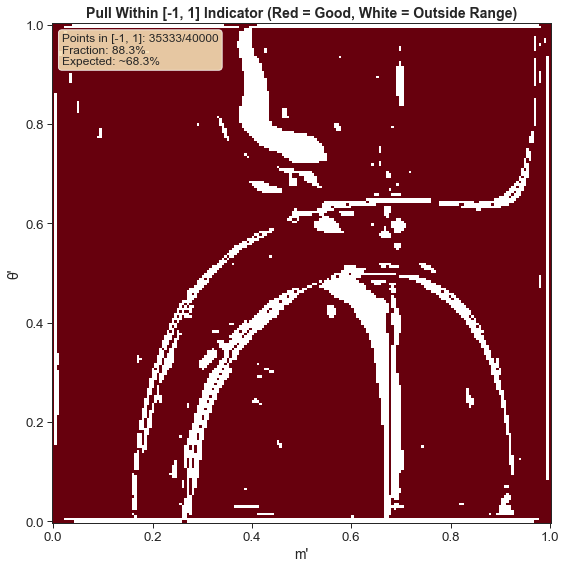


Summary: 88.3% of Dalitz plot has pull within [-1, 1]


In [70]:
def plot_pull_indicator_map(U, V, pull, savepath='pull_indicator_map.pdf'):
    """
    Plot 2D map showing regions where pull is within [-1, 1] in red, empty otherwise.
    
    Parameters
    ----------
    U, V : ndarray
        Meshgrid coordinates for the Dalitz plot
    pull : ndarray
        Pull values from compute_pull_map_combined
    savepath : str
        Path to save the figure
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create indicator: 1 where |pull| <= 1, NaN otherwise (for empty/white)
    indicator = np.where(np.abs(pull) <= 1, 1, np.nan)
    
    # Plot only the regions within [-1, 1] in red
    im = ax.pcolormesh(U, V, indicator, cmap='Reds', shading='auto', vmin=0, vmax=1)
    
    ax.set_xlabel("m'", fontsize=14)
    ax.set_ylabel("θ'", fontsize=14)
    ax.set_title('Pull Within [-1, 1] Indicator (Red = Good, White = Outside Range)', 
                 fontsize=14, fontweight='bold')
    ax.set_aspect('equal')
    
    # Calculate statistics
    total_points = pull.size
    points_in_range = np.sum(np.abs(pull) <= 1)
    fraction_in_range = points_in_range / total_points
    
    # Add text with statistics
    stats_text = f'Points in [-1, 1]: {points_in_range}/{total_points}\n'
    stats_text += f'Fraction: {fraction_in_range:.1%}\n'
    stats_text += f'Expected: ~68.3%'
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            verticalalignment='top', fontsize=12,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))
    
    plt.tight_layout()
    plt.savefig(savepath, dpi=300, bbox_inches='tight')
    print(f"Pull indicator map saved to: {savepath}")
    plt.show()
    
    print(f"\nSummary: {fraction_in_range:.1%} of Dalitz plot has pull within [-1, 1]")


plot_pull_indicator_map(U, V, pull, savepath='pull_indicator_map.pdf')


In [61]:
def plot_pull_indicator_map(U, V, pull, savepath='pull_indicator_map.pdf'):
    """
    Plot 2D map showing regions where pull is within [-1, 1] in red, empty otherwise.
    
    Parameters
    ----------
    U, V : ndarray
        Meshgrid coordinates for the Dalitz plot
    pull : ndarray
        Pull values from compute_pull_map_combined
    savepath : str
        Path to save the figure
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create indicator: 1 where |pull| <= 1, NaN otherwise (for empty/white)
    indicator = np.where(np.abs(pull) <= 1, 1, np.nan)
    
    # Plot only the regions within [-1, 1] in red
    im = ax.pcolormesh(U, V, indicator, cmap='Reds', shading='auto', vmin=0, vmax=1)
    
    ax.set_xlabel("m'", fontsize=14)
    ax.set_ylabel("θ'", fontsize=14)
    ax.set_title('Pull Within [-1, 1] Indicator (Red = Good, White = Outside Range)', 
                 fontsize=14, fontweight='bold')
    ax.set_aspect('equal')
    
    # Calculate statistics
    total_points = pull.size
    points_in_range = np.sum(np.abs(pull) <= 1)
    fraction_in_range = points_in_range / total_points
    
    # Add text with statistics
    stats_text = f'Points in [-1, 1]: {points_in_range}/{total_points}\n'
    stats_text += f'Fraction: {fraction_in_range:.1%}\n'
    stats_text += f'Expected: ~68.3%'
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            verticalalignment='top', fontsize=12,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))
    
    plt.tight_layout()
    plt.savefig(savepath, dpi=300, bbox_inches='tight')
    print(f"Pull indicator map saved to: {savepath}")
    plt.show()
    
    print(f"\nSummary: {fraction_in_range:.1%} of Dalitz plot has pull within [-1, 1]")





Pull indicator map saved to: pull_indicator_map.pdf


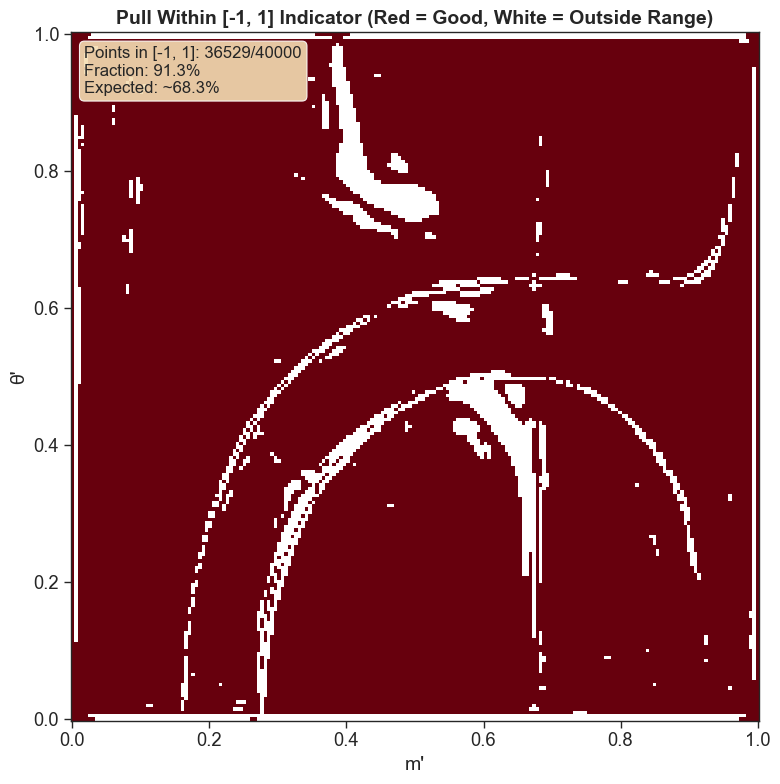


Summary: 91.3% of Dalitz plot has pull within [-1, 1]


In [60]:
plot_pull_indicator_map(U, V, pull, savepath='pull_indicator_map.pdf')

SIGMA DIAGNOSTICS


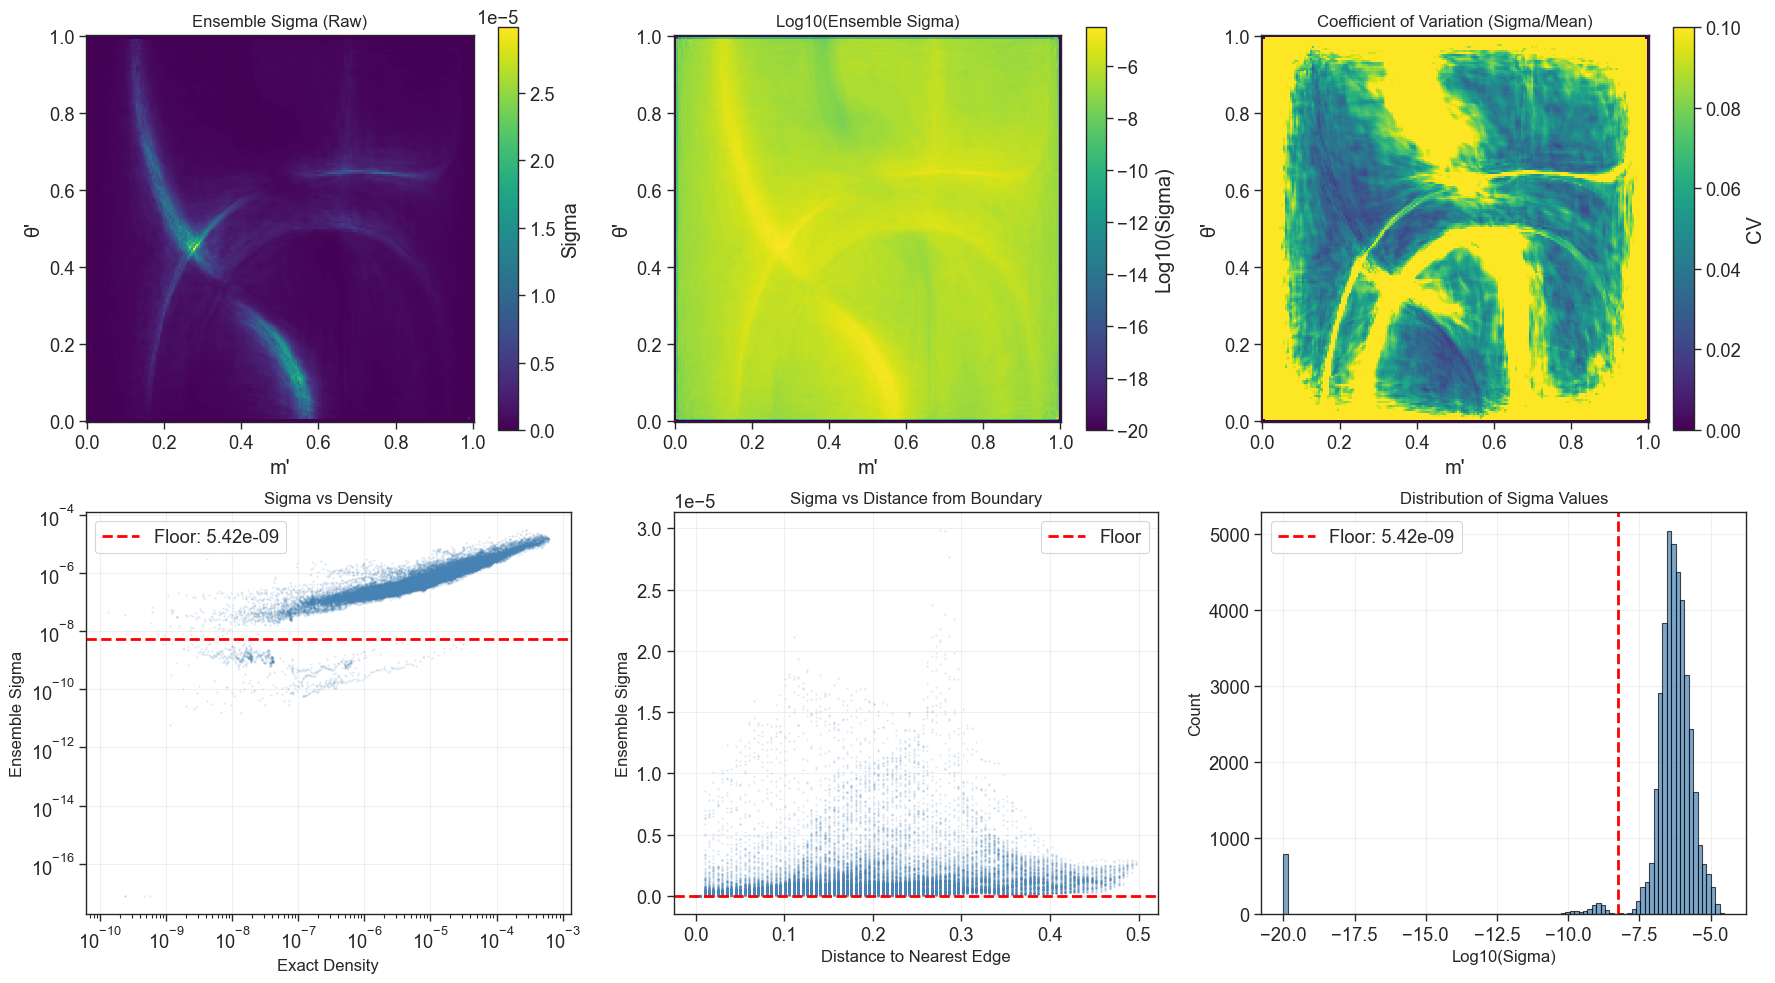


Sigma diagnostics saved to: sigma_diagnostics.pdf

SIGMA STATISTICS BY DENSITY REGION

Density > 1e-04 (5.1% of SDP):
  Sigma mean: 7.902666e-06
  Sigma std:  3.891938e-06
  Sigma range: [2.342607e-06, 2.987377e-05]
  Sigma/floor ratio: 1456.87

Density > 1e-05 (43.4% of SDP):
  Sigma mean: 2.256629e-06
  Sigma std:  2.640010e-06
  Sigma range: [1.176378e-09, 2.987377e-05]
  Sigma/floor ratio: 416.01

Density > 1e-06 (83.3% of SDP):
  Sigma mean: 1.372077e-06
  Sigma std:  2.123203e-06
  Sigma range: [0.000000e+00, 2.987377e-05]
  Sigma/floor ratio: 252.95

Density > 1e-07 (94.6% of SDP):
  Sigma mean: 1.227987e-06
  Sigma std:  2.032044e-06
  Sigma range: [0.000000e+00, 2.987377e-05]
  Sigma/floor ratio: 226.38

Density > 1e-08 (98.3% of SDP):
  Sigma mean: 1.182793e-06
  Sigma std:  2.005889e-06
  Sigma range: [0.000000e+00, 2.987377e-05]
  Sigma/floor ratio: 218.05

SIGMA STATISTICS BY DISTANCE FROM EDGE

Interior (dist > 0.05):
  Mean sigma: 1.365367e-06
  Fraction of pixels: 81.0

In [62]:
# ============================================================================
# DIAGNOSTIC: Analyze where and why sigma is low
# ============================================================================

print("="*80)
print("SIGMA DIAGNOSTICS")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Sigma map
im0 = axes[0, 0].pcolormesh(U, V, ensemble_std, cmap='viridis', shading='auto')
axes[0, 0].set_title('Ensemble Sigma (Raw)', fontsize=12)
axes[0, 0].set_xlabel("m'")
axes[0, 0].set_ylabel("θ'")
axes[0, 0].set_aspect('equal')
plt.colorbar(im0, ax=axes[0, 0], label='Sigma')

# 2. Log sigma map (better for wide ranges)
log_sigma = np.log10(ensemble_std + 1e-20)
im1 = axes[0, 1].pcolormesh(U, V, log_sigma, cmap='viridis', shading='auto')
axes[0, 1].set_title('Log10(Ensemble Sigma)', fontsize=12)
axes[0, 1].set_xlabel("m'")
axes[0, 1].set_ylabel("θ'")
axes[0, 1].set_aspect('equal')
plt.colorbar(im1, ax=axes[0, 1], label='Log10(Sigma)')

# 3. Coefficient of variation: Sigma / Mean
cv = ensemble_std / (ensemble_mean + 1e-20)
im2 = axes[0, 2].pcolormesh(U, V, cv, cmap='viridis', shading='auto', vmax=0.1)
axes[0, 2].set_title('Coefficient of Variation (Sigma/Mean)', fontsize=12)
axes[0, 2].set_xlabel("m'")
axes[0, 2].set_ylabel("θ'")
axes[0, 2].set_aspect('equal')
plt.colorbar(im2, ax=axes[0, 2], label='CV')

# 4. Sigma vs Density (scatter)
mask_plot = density_exact_norm > 1e-10
axes[1, 0].scatter(density_exact_norm[mask_plot], ensemble_std[mask_plot],
                   alpha=0.1, s=1, rasterized=True, c='steelblue')
axes[1, 0].set_xscale('log')
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlabel('Exact Density', fontsize=12)
axes[1, 0].set_ylabel('Ensemble Sigma', fontsize=12)
axes[1, 0].set_title('Sigma vs Density', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

# Add sigma floor line
axes[1, 0].axhline(sigma_floor_used, color='red', linestyle='--',
                   linewidth=2, label=f'Floor: {sigma_floor_used:.2e}')
axes[1, 0].legend()

# 5. Sigma vs Distance from Edge
dist_to_edge = np.minimum(np.minimum(U, 1-U), np.minimum(V, 1-V))
axes[1, 1].scatter(dist_to_edge.ravel(), ensemble_std.ravel(),
                   alpha=0.1, s=1, rasterized=True, c='steelblue')
axes[1, 1].set_xlabel('Distance to Nearest Edge', fontsize=12)
axes[1, 1].set_ylabel('Ensemble Sigma', fontsize=12)
axes[1, 1].set_title('Sigma vs Distance from Boundary', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(sigma_floor_used, color='red', linestyle='--',
                   linewidth=2, label='Floor')
axes[1, 1].legend()

# 6. Histogram of Sigma (log scale)
log_sigma_flat = np.log10(ensemble_std.ravel() + 1e-20)
axes[1, 2].hist(log_sigma_flat, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[1, 2].axvline(np.log10(sigma_floor_used), color='red',
                   linestyle='--', linewidth=2, label=f'Floor: {sigma_floor_used:.2e}')
axes[1, 2].set_xlabel('Log10(Sigma)', fontsize=12)
axes[1, 2].set_ylabel('Count', fontsize=12)
axes[1, 2].set_title('Distribution of Sigma Values', fontsize=12)
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('sigma_diagnostics.pdf', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSigma diagnostics saved to: sigma_diagnostics.pdf")

# ============================================================================
# Statistics by density region
# ============================================================================

print("\n" + "="*80)
print("SIGMA STATISTICS BY DENSITY REGION")
print("="*80)

density_thresholds = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8]

for threshold in density_thresholds:
    mask_region = density_exact_norm > threshold
    if mask_region.sum() > 0:
        sigma_mean = ensemble_std[mask_region].mean()
        sigma_std = ensemble_std[mask_region].std()
        sigma_min = ensemble_std[mask_region].min()
        sigma_max = ensemble_std[mask_region].max()
        frac_pixels = mask_region.sum() / mask_region.size * 100
        
        print(f"\nDensity > {threshold:.0e} ({frac_pixels:.1f}% of SDP):")
        print(f"  Sigma mean: {sigma_mean:.6e}")
        print(f"  Sigma std:  {sigma_std:.6e}")
        print(f"  Sigma range: [{sigma_min:.6e}, {sigma_max:.6e}]")
        print(f"  Sigma/floor ratio: {sigma_mean/sigma_floor_used:.2f}")

# ============================================================================
# Edge effect analysis
# ============================================================================

print("\n" + "="*80)
print("SIGMA STATISTICS BY DISTANCE FROM EDGE")
print("="*80)

edge_thresholds = [0.05, 0.10, 0.20, 0.50]

for threshold in edge_thresholds:
    # Far from edge
    mask_interior = dist_to_edge.ravel() > threshold
    if mask_interior.sum() > 0:
        sigma_interior = ensemble_std.ravel()[mask_interior]
        
        # Near edge
        mask_edge = dist_to_edge.ravel() <= 0.05
        sigma_edge = ensemble_std.ravel()[mask_edge]
        
        print(f"\nInterior (dist > {threshold}):")
        print(f"  Mean sigma: {sigma_interior.mean():.6e}")
        print(f"  Fraction of pixels: {mask_interior.sum() / len(mask_interior) * 100:.1f}%")
        
        if len(sigma_edge) > 0:
            ratio = sigma_edge.mean() / sigma_interior.mean() if sigma_interior.mean() > 0 else 0
            print(f"  Edge/Interior sigma ratio: {ratio:.3f}")

# ============================================================================
# Model-to-model correlation analysis
# ============================================================================

print("\n" + "="*80)
print("ENSEMBLE DIVERSITY: Model-to-Model Correlations")
print("="*80)

correlations = []
for i in range(num_models):
    for j in range(i+1, num_models):
        corr = np.corrcoef(
            ensemble_densities[i].ravel(),
            ensemble_densities[j].ravel()
        )[0, 1]
        correlations.append(corr)
        if num_models <= 10:  # Only print if small ensemble
            print(f"  Model {i+1} vs Model {j+1}: correlation = {corr:.6f}")

if correlations:
    print(f"\nCorrelation statistics:")
    print(f"  Mean correlation: {np.mean(correlations):.6f}")
    print(f"  Std correlation:  {np.std(correlations):.6f}")
    print(f"  Min correlation:  {np.min(correlations):.6f}")
    print(f"  Max correlation:  {np.max(correlations):.6f}")
    
    if np.mean(correlations) > 0.99:
        print("\n  ⚠️  WARNING: Models are very highly correlated (>0.99)")
        print("     This indicates low ensemble diversity.")
        print("     Possible causes:")
        print("       - Training data too similar across models")
        print("       - Early stopping too aggressive")
        print("       - Need larger training pool")
    elif np.mean(correlations) > 0.95:
        print("\n  ⚠️  Models are highly correlated (>0.95)")
        print("     Ensemble diversity could be improved.")
    else:
        print("\n  ✓ Ensemble diversity looks reasonable")

# ============================================================================
# Fraction of sigma below floor
# ============================================================================

print("\n" + "="*80)
print("SIGMA FLOOR EFFECTIVENESS")
print("="*80)

frac_below_floor = np.sum(ensemble_std < sigma_floor_used) / ensemble_std.size * 100
frac_at_floor = np.sum(np.abs(ensemble_std - sigma_floor_used) < 1e-15) / ensemble_std.size * 100

print(f"Fraction of pixels with original sigma < floor: {frac_below_floor:.2f}%")
print(f"Fraction of pixels clamped to floor:           {frac_at_floor:.2f}%")

if frac_below_floor > 20:
    print(f"\n  ⚠️  >20% of pixels below floor - consider:")
    print(f"     - Increasing ensemble size (currently N={num_models})")
    print(f"     - Checking training diversity")
    print(f"     - Using alternative sigma floor strategy")
elif frac_below_floor > 10:
    print(f"\n  ⚠️  10-20% of pixels below floor")
    print(f"     This is expected for small ensembles (N={num_models})")
else:
    print(f"\n  ✓ Floor affecting <10% of pixels - good!")

print("\n" + "="*80)

ENSEMBLE PULL MAP ANALYSIS (LOG-DENSITY)

Computing exact log-density from isobar model...


/Users/san/opt/anaconda3/lib/python3.9/site-packages/nflows/transforms/coupling.py:561: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(
/Users/san/Library/CloudStorage/OneDrive-CornellUniversity/Documents/GitHub/Gamma_Extraction/Amplitude.py:487: RuntimeWarning: divide by zero encountered in scalar divide
  dmp_dsij = -(1.0 / np.pi) * (1.0 / np.sqrt(one_minus_x2)) * (1.0 / (denom_m * np.sqrt(mijSq)))
/Users/san/Library/CloudStorage/OneDrive-CornellUniversity/Documents/GitHub/Gamma_Extraction/Amplitude.py:426: RuntimeWarning: divide by zero encountered in scalar divide
  cosHel = -(mikSq - self.mSq[i] - self.mSq[k] - 2.0 * EiCmsij * EkCmsij) / (2.0 * self.qi * self.qk)


Loading 5 models from test_ensemble (computing log-densities)...
  Processing model 1/5...
  Processing model 2/5...
  Processing model 3/5...
  Processing model 4/5...
  Processing model 5/5...

Computing ensemble statistics in log-space...

Ensemble statistics (log-density):
  Number of models: 5
  Mean log-density - Min: -175.66, Max: -7.40
  Std log-density  - Min: 0.0001, Max: 12.1394
  Log-density threshold: -100.00
  Valid region: 100.0% of SDP (log-density > threshold)
  Pull (log-space, valid region) - Min: -2127074.55, Max: 123.29, Mean: -449.70
  Pull std dev (log-space, valid region): 26463.88


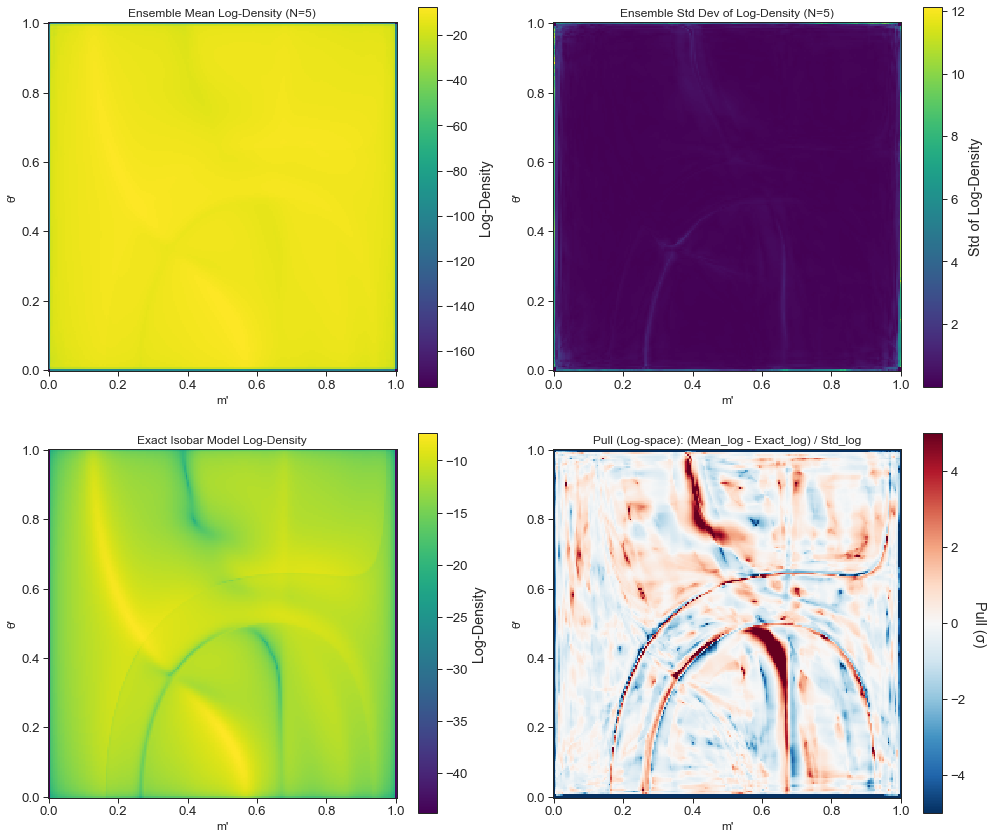


Log-density pull map saved to: ensemble_pull_map_log.pdf

LOG-DENSITY PULL DISTRIBUTION


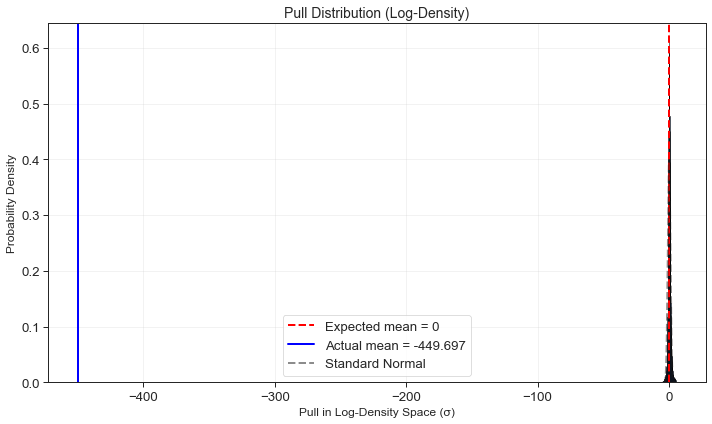


Log-density pull distribution statistics:
  Sample size: 40,000 grid points
  Mean: -449.6968 (should be ~0)
  Std:  26463.8820 (should be ~1)
  Median: -0.0603
  2.5%:  -7.42 (expected: -1.96)
  97.5%: 2.90 (expected: +1.96)
  Fraction outside ±2σ: 9.79% (expected: ~5%)
  Fraction outside ±3σ: 6.35% (expected: ~0.3%)

Plot saved to: pull_distribution_log.pdf


In [44]:
def load_ensemble_log_densities(ensemble_dir, pts, grid_shape, num_flows=16, 
                                hidden_features=128, num_bins=16, device='cpu'):
    """
    Load ensemble models and compute LOG-densities on a grid.
    
    Parameters
    ----------
    ensemble_dir : str
        Path to directory containing ensemble models
    pts : ndarray, shape (N, 2)
        Grid points in SDP coordinates
    grid_shape : tuple
        Shape of grid (ny, nx) for reshaping
    num_flows : int
        Number of coupling layers in flow architecture
    hidden_features : int
        Hidden layer size in flow architecture
    num_bins : int
        Number of spline bins in flow architecture
    device : str
        Device for computation ('cpu' or 'cuda')
    
    Returns
    -------
    ensemble_log_densities : ndarray, shape (num_models, ny, nx)
        Log-densities (normalized) from each model
    num_models : int
        Number of models loaded
    """
    from pathlib import Path
    import glob
    
    # Find all model files
    model_files = sorted(glob.glob(f"{ensemble_dir}/trial_seed*.pth"))
    # Exclude *_best.pth files
    model_files = [f for f in model_files if not f.endswith('_best.pth')]
    num_models = len(model_files)
    
    print(f"Loading {num_models} models from {ensemble_dir} (computing log-densities)...")
    ensemble_log_densities = []
    
    for idx, model_path in enumerate(model_files, 1):
        print(f"  Processing model {idx}/{num_models}...")
        
        # Load model
        model_flow = create_flow(num_flows=num_flows, hidden_features=hidden_features, 
                                 num_bins=num_bins)
        model_flow.load_state_dict(torch.load(model_path, map_location=device))
        model_flow.eval()
        model_flow.to(device)
        
        # Compute log-density directly (more numerically stable)
        with torch.no_grad():
            pts_tensor = torch.from_numpy(pts.astype(np.float32)).to(device)
            batch_size = 10000
            log_probs = []
            for i in range(0, len(pts_tensor), batch_size):
                batch = pts_tensor[i:i+batch_size]
                log_probs.append(model_flow.log_prob(batch).cpu().numpy())
            log_prob = np.concatenate(log_probs)
        
        log_density = log_prob.reshape(grid_shape)
        
        # Normalize: subtract log(integral) to get normalized log-density
        # log(p_norm) = log(p) - log(∫p) = log(p) - log(sum(exp(log(p))))
        # For numerical stability, use logsumexp
        from scipy.special import logsumexp
        log_integral = logsumexp(log_prob)  # log(sum(exp(log_prob)))
        log_density_norm = log_density - log_integral
        
        ensemble_log_densities.append(log_density_norm)
    
    return np.array(ensemble_log_densities), num_models


def compute_pull_map_log(ensemble_mean_log, ensemble_std_log, exact_log_density, log_density_threshold=None):
    """
    Compute pull map in log-density space: (ensemble_mean_log - exact_log) / ensemble_std_log
    
    Parameters
    ----------
    ensemble_mean_log : ndarray
        Mean log-density from ensemble
    ensemble_std_log : ndarray
        Standard deviation of log-density from ensemble
    exact_log_density : ndarray
        Exact log-density from isobar model
    log_density_threshold : float, optional
        Minimum log-density value to include in pull calculation.
        Points below this threshold are set to zero.
    
    Returns
    -------
    pull_log : ndarray
        Pull values in log-space, with masked regions set to zero
    mask : ndarray (bool)
        Boolean mask indicating valid regions (above threshold)
    """
    epsilon = 1e-10
    pull_log = (ensemble_mean_log - exact_log_density) / (ensemble_std_log + epsilon)
    
    # Apply log-density threshold if provided
    if log_density_threshold is not None:
        # Mask where exact log-density is too low
        mask = exact_log_density >= log_density_threshold
        pull_log_masked = pull_log.copy()
        pull_log_masked[~mask] = 0.0  # Set to zero instead of NaN
        return pull_log_masked, mask
    
    return pull_log, np.ones_like(pull_log, dtype=bool)


def plot_ensemble_pull_map_log(U, V, ensemble_mean_log, ensemble_std_log, exact_log_density, pull_log, 
                                num_models, savepath='ensemble_pull_map_log.pdf'):
    """
    Create 2x2 plot showing ensemble mean log-density, std, exact log-density, and pull map.
    
    Parameters
    ----------
    U, V : ndarray
        Mesh grid coordinates
    ensemble_mean_log : ndarray
        Ensemble mean log-density
    ensemble_std_log : ndarray
        Ensemble standard deviation of log-density
    exact_log_density : ndarray
        Exact log-density from isobar model
    pull_log : ndarray
        Pull values in log-space (regions below threshold are zero)
    num_models : int
        Number of models in ensemble
    savepath : str
        Path to save figure
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Top left: Ensemble mean log-density
    im0 = axes[0, 0].pcolormesh(U, V, ensemble_mean_log, cmap='viridis', shading='auto')
    axes[0, 0].set_xlabel("m'", fontsize=12)
    axes[0, 0].set_ylabel("θ'", fontsize=12)
    axes[0, 0].set_title(f'Ensemble Mean Log-Density (N={num_models})', fontsize=12)
    axes[0, 0].set_aspect('equal')
    plt.colorbar(im0, ax=axes[0, 0], label='Log-Density')
    
    # Top right: Ensemble std of log-density
    im1 = axes[0, 1].pcolormesh(U, V, ensemble_std_log, cmap='viridis', shading='auto')
    axes[0, 1].set_xlabel("m'", fontsize=12)
    axes[0, 1].set_ylabel("θ'", fontsize=12)
    axes[0, 1].set_title(f'Ensemble Std Dev of Log-Density (N={num_models})', fontsize=12)
    axes[0, 1].set_aspect('equal')
    plt.colorbar(im1, ax=axes[0, 1], label='Std of Log-Density')
    
    # Bottom left: Exact log-density
    im2 = axes[1, 0].pcolormesh(U, V, exact_log_density, cmap='viridis', shading='auto')
    axes[1, 0].set_xlabel("m'", fontsize=12)
    axes[1, 0].set_ylabel("θ'", fontsize=12)
    axes[1, 0].set_title('Exact Isobar Model Log-Density', fontsize=12)
    axes[1, 0].set_aspect('equal')
    plt.colorbar(im2, ax=axes[1, 0], label='Log-Density')
    
    # Bottom right: Pull map in log-space
    # Clip to ±5 sigma for visualization
    pull_log_clipped = np.clip(pull_log, -5, 5)
    im3 = axes[1, 1].pcolormesh(U, V, pull_log_clipped, cmap='RdBu_r', shading='auto',
                                vmin=-5, vmax=5)
    axes[1, 1].set_xlabel("m'", fontsize=12)
    axes[1, 1].set_ylabel("θ'", fontsize=12)
    axes[1, 1].set_title('Pull (Log-space): (Mean_log - Exact_log) / Std_log', fontsize=12)
    axes[1, 1].set_aspect('equal')
    cbar = plt.colorbar(im3, ax=axes[1, 1], label='Pull (σ)')
    cbar.set_label('Pull (σ)', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.savefig(savepath, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nLog-density pull map saved to: {savepath}")


# Main execution: Create pull map in LOG-DENSITY space using ensemble of models
print("="*80)
print("ENSEMBLE PULL MAP ANALYSIS (LOG-DENSITY)")
print("="*80)

# Configuration
ensemble_dir = "test_ensemble"  # Change to your ensemble directory
grid_nx, grid_ny = 200, 200
log_density_threshold = -100  # Only compute pull where log-density > threshold (e.g., -15 corresponds to density > exp(-15) ≈ 3e-7)

# Create grid
U, V, pts = make_sdp_grid(nx=grid_nx, ny=grid_ny)
grid_shape = (grid_ny, grid_nx)

# Compute exact log-density from isobar model
print("\nComputing exact log-density from isobar model...")
dkpp_model = DKpp()
density_exact = compute_mag_exact(pts, SDP, flow, dkpp_model, device=device).reshape(grid_shape)
density_exact_norm = density_exact / density_exact.sum()
log_density_exact_norm = np.log(density_exact_norm + 1e-300)  # Add tiny epsilon to avoid log(0)

# Load ensemble and compute log-densities
ensemble_log_densities, num_models = load_ensemble_log_densities(
    ensemble_dir, pts, grid_shape, 
    num_flows=16, hidden_features=128, num_bins=16, device=device
)

# Compute ensemble statistics in log-space
print("\nComputing ensemble statistics in log-space...")
ensemble_mean_log = np.mean(ensemble_log_densities, axis=0)
ensemble_std_log = np.std(ensemble_log_densities, axis=0, ddof=1)  # Sample std

# Compute pull in log-space with threshold
pull_log, mask_log = compute_pull_map_log(ensemble_mean_log, ensemble_std_log, log_density_exact_norm, 
                                          log_density_threshold=log_density_threshold)

# Print statistics
print(f"\nEnsemble statistics (log-density):")
print(f"  Number of models: {num_models}")
print(f"  Mean log-density - Min: {ensemble_mean_log.min():.2f}, Max: {ensemble_mean_log.max():.2f}")
print(f"  Std log-density  - Min: {ensemble_std_log.min():.4f}, Max: {ensemble_std_log.max():.4f}")
if log_density_threshold is not None:
    # Only analyze pull in valid region (non-zero values)
    pull_log_valid = pull_log[mask_log]
    frac_valid = np.sum(mask_log) / mask_log.size * 100
    print(f"  Log-density threshold: {log_density_threshold:.2f}")
    print(f"  Valid region: {frac_valid:.1f}% of SDP (log-density > threshold)")
    if len(pull_log_valid) > 0:
        print(f"  Pull (log-space, valid region) - Min: {pull_log_valid.min():.2f}, Max: {pull_log_valid.max():.2f}, Mean: {pull_log_valid.mean():.2f}")
        print(f"  Pull std dev (log-space, valid region): {pull_log_valid.std():.2f}")
else:
    print(f"  Pull (log-space) - Min: {pull_log.min():.2f}, Max: {pull_log.max():.2f}, Mean: {pull_log.mean():.2f}")
    print(f"  Pull std dev (log-space): {pull_log.std():.2f}")

# Plot
plot_ensemble_pull_map_log(U, V, ensemble_mean_log, ensemble_std_log, log_density_exact_norm, pull_log, 
                           num_models, savepath='ensemble_pull_map_log.pdf')

# Also plot histogram of log-density pull
print("\n" + "="*80)
print("LOG-DENSITY PULL DISTRIBUTION")
print("="*80)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

pull_log_flat = pull_log.ravel()
pull_log_flat = pull_log_flat[np.isfinite(pull_log_flat)]  # Remove NaN/inf values

ax.hist(pull_log_flat, bins=100, range=(-5, 5), alpha=0.7, edgecolor='black', density=True)
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Expected mean = 0')
ax.axvline(pull_log_flat.mean(), color='blue', linestyle='-', linewidth=2, 
           label=f'Actual mean = {pull_log_flat.mean():.3f}')

# Add Gaussian reference
x_gauss = np.linspace(-5, 5, 200)
y_gauss = (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * x_gauss**2)
ax.plot(x_gauss, y_gauss, 'k--', linewidth=2, alpha=0.5, label='Standard Normal')

ax.set_xlabel('Pull in Log-Density Space (σ)', fontsize=12)
ax.set_ylabel('Probability Density', fontsize=12)
ax.set_title('Pull Distribution (Log-Density)', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pull_distribution_log.pdf', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nLog-density pull distribution statistics:")
print(f"  Sample size: {len(pull_log_flat):,} grid points")
print(f"  Mean: {pull_log_flat.mean():.4f} (should be ~0)")
print(f"  Std:  {pull_log_flat.std():.4f} (should be ~1)")
print(f"  Median: {np.median(pull_log_flat):.4f}")
print(f"  2.5%:  {np.percentile(pull_log_flat, 2.5):.2f} (expected: -1.96)")
print(f"  97.5%: {np.percentile(pull_log_flat, 97.5):.2f} (expected: +1.96)")
print(f"  Fraction outside ±2σ: {np.sum(np.abs(pull_log_flat) > 2) / len(pull_log_flat) * 100:.2f}% (expected: ~5%)")
print(f"  Fraction outside ±3σ: {np.sum(np.abs(pull_log_flat) > 3) / len(pull_log_flat) * 100:.2f}% (expected: ~0.3%)")
print(f"\nPlot saved to: pull_distribution_log.pdf")

## Example 5: Train Full Ensemble (50 models)

In [ ]:
# WARNING: This will take 25-65 hours depending on your hardware!

# Train full ensemble with proper data split:
# - Total: 11M events
# - Training pool: 10M (first 10M)
# - Validation: 1M (last 1M, FIXED for all trials)
# - Each trial: samples 1M from the 10M training pool

results = train_ensemble(
    data_path="D_Kspipi_SDP_1e7.npy",  # Should have 11M events
    output_dir="trained_flows_ensemble",
    num_trials=50,
    train_pool_size=10_000_000,         # First 10M events
    val_size=1_000_000,                 # Last 1M events (FIXED)
    train_sample_size=1_000_000,        # Sample 1M per trial from pool
    batch_size=10000,
    lr=0.01,
    max_epochs=200,
    patience=15,
    min_delta=1e-5,
    num_flows=12,
    hidden_features=128,
    num_bins=12,
    device=device
)

print("\nFull ensemble complete!")
print("Check the 'trained_flows_ensemble/' directory for results")

In [ ]:
def pdf_from_flow(pts, flow, device):
    with torch.no_grad():
        logp = flow.log_prob(torch.from_numpy(pts.astype(np.float32)).to(device))
    return np.exp(logp.cpu().numpy())

## Example 6: Analyze Ensemble Results

In [ ]:
import glob

ensemble_dir = "trained_flows_ensemble"  # or "test_ensemble"

# Load summary
with open(f"{ensemble_dir}/summary.json") as f:
    summary = json.load(f)

print("Ensemble Summary:")
print(f"  Number of trials: {summary['num_trials']}")
print(f"  Best val loss: {summary['best_val_loss']:.6f}")
print(f"  Mean val loss: {summary['mean_val_loss']:.6f} ± {summary['std_val_loss']:.6f}")
print(f"  Mean epochs: {summary['mean_epochs']:.1f} ± {summary['std_epochs']:.1f}")
print(f"  Early stopped: {summary['num_early_stopped']}/{summary['num_trials']}")

# Load all histories
history_files = sorted(glob.glob(f"{ensemble_dir}/trial_seed*_history.json"))
print(f"\nFound {len(history_files)} history files")

histories = []
for path in history_files:
    with open(path) as f:
        histories.append(json.load(f))

In [ ]:
# Plot all training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for h in histories:
    axes[0].plot(h['train_loss'], alpha=0.3, color='blue', linewidth=1)
    axes[1].plot(h['val_loss'], alpha=0.3, color='orange', linewidth=1)

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss Curves (All Models)')
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Validation Loss Curves (All Models)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{ensemble_dir}/loss_curves.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {ensemble_dir}/loss_curves.png")

In [ ]:
# Distribution of best validation losses
best_losses = [min(h['val_loss']) for h in histories]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of best losses
axes[0].hist(best_losses, bins=20, edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(best_losses), color='red', linestyle='--',
               label=f'Mean: {np.mean(best_losses):.6f}', linewidth=2)
axes[0].set_xlabel('Best Validation Loss')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Best Validation Losses')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Histogram of epochs trained
epochs = [h['epochs_trained'] for h in histories]
axes[1].hist(epochs, bins=20, edgecolor='black', alpha=0.7, color='green')
axes[1].axvline(np.mean(epochs), color='red', linestyle='--',
               label=f'Mean: {np.mean(epochs):.1f}', linewidth=2)
axes[1].set_xlabel('Epochs Trained')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Training Epochs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{ensemble_dir}/distributions.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {ensemble_dir}/distributions.png")

## Example 7: Load and Compare Multiple Models from Ensemble

In [ ]:
# Find the best model
best_idx = np.argmin(best_losses) + 1
print(f"Best model: trial_seed{best_idx}")
print(f"Best validation loss: {min(best_losses):.6f}")

# Load best model
best_flow = create_flow(num_flows=12, hidden_features=128, num_bins=12)
best_flow.load_state_dict(torch.load(f"{ensemble_dir}/trial_seed{best_idx}.pth"))
best_flow.eval()
best_flow.to(device)

# Generate samples from best model
with torch.no_grad():
    best_samples = best_flow.sample(50_000).cpu().numpy()

# Plot
plt.figure(figsize=(8, 7))
plt.hist2d(best_samples[:, 0], best_samples[:, 1], bins=50, cmap='viridis')
plt.xlabel("m'")
plt.ylabel("θ'")
plt.title(f'Best Model (trial_seed{best_idx}) Samples')
plt.colorbar(label='Density')
plt.tight_layout()
plt.savefig(f"{ensemble_dir}/best_model_samples.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {ensemble_dir}/best_model_samples.png")

---
## Summary

This notebook provides an optimized workflow for training normalizing flows on D-decay data:

### Key Features:
1. **Early Stopping**: Automatically stops training when validation loss plateaus (~70% time savings)
2. **Fixed Validation Set**: All models validated on the same 1M events for fair comparison
3. **Efficient Data Usage**: 
   - Total dataset: 11M events
   - Training pool: 10M events (first 10M)
   - Validation set: 1M events (last 1M, FIXED for all trials)
   - Each trial: samples 1M from the 10M training pool (without replacement)
4. **Ensemble Training**: Automated sampling for 50 independent models
5. **Smart Checkpointing**: Saves best model based on validation performance
6. **Comprehensive Logging**: JSON files with training history for analysis

### Data Split Strategy:
```
Total: 11M events
├── Training Pool: 10M (indices 0 to 9,999,999)
│   └── Each trial samples 1M randomly (without replacement)
└── Validation: 1M (indices 10,000,000 to 10,999,999, FIXED for all trials)
```

### Why This Strategy?
- **Fixed validation set**: Ensures all models are compared fairly on identical data
- **Random sampling from pool**: Each trial sees different training data (diversity)
- **Without replacement**: Within each trial, no duplicate events
- **Large pool (10M)**: Many possible 1M subsets for ensemble diversity

### Typical Performance:
- Single model: 30-60 minutes (vs 200+ minutes before)
- 50-model ensemble: 25-50 hours (vs 166+ hours before)
- **Overall speedup: ~5×**

### Recommended Workflow:
1. **Generate 11M events** using your data generation code (if not already done)
2. Start with **Example 4** (small ensemble, 5 models) to test (~2-3 hours)
3. Verify early stopping is working (check epochs_trained < 100)
4. Run **Example 5** (full ensemble, 50 models) overnight
5. Analyze results with **Example 6**
6. Use best model for physics analysis

### Expected Results:
- Validation loss: ~0.25-0.35 (depends on data complexity)
- Early stopping: ~80-90% of models should stop before max_epochs
- Epochs trained: typically 30-80 epochs
- Ensemble variance: small (good models should agree)

For more details, see:
- `QUICK_START.md` - Quick reference guide
- `OPTIMIZATION_GUIDE.md` - Detailed optimization strategies
- `flowSDP_documentation.md` - Full documentation